<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [25]</a>'.</span>

# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IM

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
0
Tesla V100-PCIE-32GB


## Helper functions


### Binary Accuracy


In [4]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [5]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [6]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [8]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [9]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [10]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()

    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]

            predictions = model(inputs).squeeze(1)
            label = lab.to(dev)

            # label = label.unsqueeze(1)

            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch

    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [12]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Quantum Multi-Head Attention


In [13]:
import pennylane as qml
import pennylane.templates as qmlt
import pennylane.qnn.torch as qml_qnn_torch

In [14]:
class QuantumLayer(torch.nn.Module):
    def __init__(self, n_qubits, n_qlayers=1, q_device="default.qubit"):
        super().__init__()

        dev = qml.device(q_device, wires=n_qubits, torch_device="cuda")

        @qml.qnode(dev, interface="torch")
        def qlayer(inputs, weights):
            # qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="X")
            qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
            qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RZ)
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.linear = qml_qnn_torch.TorchLayer(qlayer, weight_shapes)

    def forward(self, inputs):
        return self.linear(inputs)

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
        n_qubits=4,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(MultiHeadedAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        # The quantum layers for the query, key, and value projections
        self.k_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.q_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.v_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        # The quantum layer to combine the heads
        self.combine_heads = QuantumLayer(n_qubits, n_qlayers, q_device)

        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        assert (
            embed_dim == self.embed_dim
        ), f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(key[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(query[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(value[:, t, :]) for t in range(seq_len)]

        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x: Tensor
        x, self.attn_weights = attention(Q, K, V, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)

        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

### Quantum Feed-Forward Network


In [16]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(
        self,
        embed_dim: int,
        n_qubits: int,
        n_qlayers=1,
        dropout=0.1,
        q_device="default.qubit",
    ):
        super(FeedForward, self).__init__()
        self.ffn_dim = n_qubits

        self.linear_1 = nn.Linear(embed_dim, self.ffn_dim)
        self.linear_2 = nn.Linear(self.ffn_dim, embed_dim)
        self.vqc = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.size()
        x = self.linear_1(x)
        X = [self.vqc(x[:, t, :]) for t in range(seq_len)]
        x = torch.Tensor(pad_sequence(X))
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Quantum Encoder


In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(Encoder, self).__init__()

        self.n_qubits_transformer = n_qubits_transformer
        self.n_qubits_ffn = n_qubits_ffn
        self.n_qlayers = n_qlayers

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            mask=mask,
            n_qubits=n_qubits_transformer,
            n_qlayers=n_qlayers,
            q_device=q_device,
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(
            embed_dim, n_qubits_ffn, n_qlayers, q_device=q_device, dropout=dropout
        )

        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [18]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        max_seq_len: int,
        ffn_dim=32,
        dropout=0.1,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(TextClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        print(
            f"++ Transformer will use {n_qubits_transformer} qubits and {n_qlayers} q layers"
        )

        print(f"The feed-forward head will use {n_qubits_ffn} qubits")

        print(f"Using quantum device {q_device}")

        self.transformers = get_clones(
            Encoder(
                embed_dim,
                num_heads,
                ffn_dim,
                n_qubits_transformer=n_qubits_transformer,
                n_qubits_ffn=n_qubits_ffn,
                n_qlayers=n_qlayers,
                q_device=q_device,
            ),
            num_blocks,
        )

        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # # Normalise the data to range [0, 2*pi]
        # min_val = x.min()
        # max_val = x.max()

        # x = (x - min_val) / (max_val - min_val) * (2 * torch.pi)

        # print(f"Minimum value: {x.min()}, Maximum value: {x.max()}")

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [19]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split




def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=2,
    num_blocks=2,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    n_qubits_transformer=0,
    n_qubits_ffn=0,
    n_qlayers=0,
    q_device="default.qubit",
    dropout_rate=0.1,
):
  
    save_dir = f".models_{n_epochs}_{n_qubits_transformer}_{n_qubits_ffn}_{n_qlayers}"
    save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
    os.makedirs(save_dir, exist_ok=True)

    # train_iter = IMDB(root="./.datatext", split="train")
    # test_iter = IMDB(root="./.datatext", split="test")

    # train_data = to_map_style_dataset(train_iter)
    # test_data = to_map_style_dataset(test_iter)

    size = total_size

    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data = np.array(train_data)[
        np.random.choice(len(train_data), size=size, replace=False)
    ].tolist()

    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("pos: ", len([label for label, text in train_data if label == 1]))
    print("neg: ", len([label for label, text in train_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")
    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )
    test_loader = DataLoader(
        test_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        n_qubits_transformer=n_qubits_transformer,
        n_qubits_ffn=n_qubits_ffn,
        n_qlayers=n_qlayers,
        dropout=dropout_rate,
        q_device=q_device,
        max_seq_len=max_seq_len,
    )

    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )

            # scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1
                
            torch.save(
                {
                    "epoch": iepoch + 1,
                    "model_state_dict": model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    "train_loss": train_loss_list,
                    "train_acc": train_acc_list,
                    "train_auc": train_auc_list,
                    "test_loss": test_loss_list,
                    "test_acc": test_acc_list,
                    "test_auc": test_auc_list,
                },
                save_path.format(iepoch + 1),
            )

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [20]:
qml.about()

Name: PennyLane
Version: 0.37.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/nchoong/.conda/envs/quant/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane_Lightning

Platform info:           Linux-4.18.0-348.12.2.el8_5.x86_64-x86_64-with-glibc2.28
Python version:          3.11.8
Numpy version:           1.26.3
Scipy version:           1.14.0
Installed devices:
- default.clifford (PennyLane-0.37.0)
- default.gaussian (PennyLane-0.37.0)
- default.mixed (PennyLane-0.37.0)
- default.qubit (PennyLane-0.37.0)
- default.qubit.autograd (PennyLane-0.37.0)
- default.qubit.ja

In [21]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [22]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main(
    n_epochs=30,
    embed_dim=8,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=3,
    num_blocks=2,
    num_heads=2,
    q_device="default.qubit.torch",
    total_size=5000,
)

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


pos:  1999
neg:  2001


++ There will be 2 transformer blocks
++ Transformer will use 8 qubits and 3 q layers
The feed-forward head will use 8 qubits
Using quantum device default.qubit.torch
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
The model has 400,601 trainable parameters



Epoch   1/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   1/30:   1%|          | 32/4000 [00:46<1:35:13,  1.44s/batch]


Epoch   1/30:   2%|▏         | 64/4000 [01:32<1:35:19,  1.45s/batch]


Epoch   1/30:   2%|▏         | 96/4000 [02:20<1:35:09,  1.46s/batch]


Epoch   1/30:   3%|▎         | 128/4000 [03:07<1:34:40,  1.47s/batch]


Epoch   1/30:   4%|▍         | 160/4000 [03:54<1:34:24,  1.48s/batch]


Epoch   1/30:   5%|▍         | 192/4000 [04:42<1:33:48,  1.48s/batch]


Epoch   1/30:   6%|▌         | 224/4000 [05:29<1:33:08,  1.48s/batch]


Epoch   1/30:   6%|▋         | 256/4000 [06:17<1:32:31,  1.48s/batch]


Epoch   1/30:   7%|▋         | 288/4000 [07:05<1:31:59,  1.49s/batch]


Epoch   1/30:   8%|▊         | 320/4000 [07:53<1:31:23,  1.49s/batch]


Epoch   1/30:   9%|▉         | 352/4000 [08:41<1:30:38,  1.49s/batch]


Epoch   1/30:  10%|▉         | 384/4000 [09:28<1:29:56,  1.49s/batch]


Epoch   1/30:  10%|█         | 416/4000 [10:16<1:29:07,  1.49s/batch]


Epoch   1/30:  11%|█         | 448/4000 [11:04<1:28:16,  1.49s/batch]


Epoch   1/30:  12%|█▏        | 480/4000 [11:51<1:27:27,  1.49s/batch]


Epoch   1/30:  13%|█▎        | 512/4000 [12:39<1:26:40,  1.49s/batch]


Epoch   1/30:  14%|█▎        | 544/4000 [13:27<1:25:57,  1.49s/batch]


Epoch   1/30:  14%|█▍        | 576/4000 [14:15<1:25:05,  1.49s/batch]


Epoch   1/30:  15%|█▌        | 608/4000 [15:02<1:24:13,  1.49s/batch]


Epoch   1/30:  16%|█▌        | 640/4000 [15:50<1:23:20,  1.49s/batch]


Epoch   1/30:  17%|█▋        | 672/4000 [16:37<1:22:17,  1.48s/batch]


Epoch   1/30:  18%|█▊        | 704/4000 [17:24<1:21:27,  1.48s/batch]


Epoch   1/30:  18%|█▊        | 736/4000 [18:11<1:20:27,  1.48s/batch]


Epoch   1/30:  19%|█▉        | 768/4000 [18:59<1:19:54,  1.48s/batch]


Epoch   1/30:  20%|██        | 800/4000 [19:47<1:19:15,  1.49s/batch]


Epoch   1/30:  21%|██        | 832/4000 [20:34<1:18:10,  1.48s/batch]


Epoch   1/30:  22%|██▏       | 864/4000 [21:21<1:17:09,  1.48s/batch]


Epoch   1/30:  22%|██▏       | 896/4000 [22:08<1:16:11,  1.47s/batch]


Epoch   1/30:  23%|██▎       | 928/4000 [22:54<1:15:15,  1.47s/batch]


Epoch   1/30:  24%|██▍       | 960/4000 [23:41<1:14:20,  1.47s/batch]


Epoch   1/30:  25%|██▍       | 992/4000 [24:28<1:13:34,  1.47s/batch]


Epoch   1/30:  26%|██▌       | 1024/4000 [25:15<1:12:43,  1.47s/batch]


Epoch   1/30:  26%|██▋       | 1056/4000 [26:03<1:12:15,  1.47s/batch]


Epoch   1/30:  27%|██▋       | 1088/4000 [26:49<1:11:14,  1.47s/batch]


Epoch   1/30:  28%|██▊       | 1120/4000 [27:36<1:10:17,  1.46s/batch]


Epoch   1/30:  29%|██▉       | 1152/4000 [28:22<1:09:15,  1.46s/batch]


Epoch   1/30:  30%|██▉       | 1184/4000 [29:09<1:08:23,  1.46s/batch]


Epoch   1/30:  30%|███       | 1216/4000 [29:55<1:07:30,  1.45s/batch]


Epoch   1/30:  31%|███       | 1248/4000 [30:42<1:06:47,  1.46s/batch]


Epoch   1/30:  32%|███▏      | 1280/4000 [31:28<1:05:48,  1.45s/batch]


Epoch   1/30:  33%|███▎      | 1312/4000 [32:14<1:04:51,  1.45s/batch]


Epoch   1/30:  34%|███▎      | 1344/4000 [33:00<1:04:06,  1.45s/batch]


Epoch   1/30:  34%|███▍      | 1376/4000 [33:47<1:03:34,  1.45s/batch]


Epoch   1/30:  35%|███▌      | 1408/4000 [34:34<1:02:49,  1.45s/batch]


Epoch   1/30:  36%|███▌      | 1440/4000 [35:20<1:01:45,  1.45s/batch]


Epoch   1/30:  37%|███▋      | 1472/4000 [36:05<1:00:46,  1.44s/batch]


Epoch   1/30:  38%|███▊      | 1504/4000 [36:51<59:49,  1.44s/batch]  


Epoch   1/30:  38%|███▊      | 1536/4000 [37:37<59:06,  1.44s/batch]


Epoch   1/30:  39%|███▉      | 1568/4000 [38:23<58:11,  1.44s/batch]


Epoch   1/30:  40%|████      | 1600/4000 [39:05<56:02,  1.40s/batch]


Epoch   1/30:  41%|████      | 1632/4000 [39:47<54:07,  1.37s/batch]


Epoch   1/30:  42%|████▏     | 1664/4000 [40:28<52:35,  1.35s/batch]


Epoch   1/30:  42%|████▏     | 1696/4000 [41:10<51:20,  1.34s/batch]


Epoch   1/30:  43%|████▎     | 1728/4000 [41:52<50:14,  1.33s/batch]


Epoch   1/30:  44%|████▍     | 1760/4000 [42:33<49:14,  1.32s/batch]


Epoch   1/30:  45%|████▍     | 1792/4000 [43:15<48:21,  1.31s/batch]


Epoch   1/30:  46%|████▌     | 1824/4000 [43:57<47:31,  1.31s/batch]


Epoch   1/30:  46%|████▋     | 1856/4000 [44:39<46:46,  1.31s/batch]


Epoch   1/30:  47%|████▋     | 1888/4000 [45:20<46:01,  1.31s/batch]


Epoch   1/30:  48%|████▊     | 1920/4000 [46:02<45:18,  1.31s/batch]


Epoch   1/30:  49%|████▉     | 1952/4000 [46:44<44:33,  1.31s/batch]


Epoch   1/30:  50%|████▉     | 1984/4000 [47:25<43:50,  1.30s/batch]


Epoch   1/30:  50%|█████     | 2016/4000 [48:07<43:07,  1.30s/batch]


Epoch   1/30:  51%|█████     | 2048/4000 [48:49<42:24,  1.30s/batch]


Epoch   1/30:  52%|█████▏    | 2080/4000 [49:31<41:42,  1.30s/batch]


Epoch   1/30:  53%|█████▎    | 2112/4000 [50:12<41:02,  1.30s/batch]


Epoch   1/30:  54%|█████▎    | 2144/4000 [50:54<40:18,  1.30s/batch]


Epoch   1/30:  54%|█████▍    | 2176/4000 [51:36<39:37,  1.30s/batch]


Epoch   1/30:  55%|█████▌    | 2208/4000 [52:17<38:55,  1.30s/batch]


Epoch   1/30:  56%|█████▌    | 2240/4000 [52:59<38:14,  1.30s/batch]


Epoch   1/30:  57%|█████▋    | 2272/4000 [53:41<37:33,  1.30s/batch]


Epoch   1/30:  58%|█████▊    | 2304/4000 [54:23<36:53,  1.31s/batch]


Epoch   1/30:  58%|█████▊    | 2336/4000 [55:04<36:09,  1.30s/batch]


Epoch   1/30:  59%|█████▉    | 2368/4000 [55:46<35:28,  1.30s/batch]


Epoch   1/30:  60%|██████    | 2400/4000 [56:28<34:47,  1.30s/batch]


Epoch   1/30:  61%|██████    | 2432/4000 [57:10<34:05,  1.30s/batch]


Epoch   1/30:  62%|██████▏   | 2464/4000 [57:51<33:24,  1.31s/batch]


Epoch   1/30:  62%|██████▏   | 2496/4000 [58:33<32:41,  1.30s/batch]


Epoch   1/30:  63%|██████▎   | 2528/4000 [59:15<32:00,  1.30s/batch]


Epoch   1/30:  64%|██████▍   | 2560/4000 [59:57<31:18,  1.30s/batch]


Epoch   1/30:  65%|██████▍   | 2592/4000 [1:00:39<30:38,  1.31s/batch]


Epoch   1/30:  66%|██████▌   | 2624/4000 [1:01:20<29:55,  1.31s/batch]


Epoch   1/30:  66%|██████▋   | 2656/4000 [1:02:02<29:14,  1.31s/batch]


Epoch   1/30:  67%|██████▋   | 2688/4000 [1:02:44<28:31,  1.30s/batch]


Epoch   1/30:  68%|██████▊   | 2720/4000 [1:03:25<27:49,  1.30s/batch]


Epoch   1/30:  69%|██████▉   | 2752/4000 [1:04:07<27:07,  1.30s/batch]


Epoch   1/30:  70%|██████▉   | 2784/4000 [1:04:49<26:26,  1.30s/batch]


Epoch   1/30:  70%|███████   | 2816/4000 [1:05:31<25:43,  1.30s/batch]


Epoch   1/30:  71%|███████   | 2848/4000 [1:06:12<25:02,  1.30s/batch]


Epoch   1/30:  72%|███████▏  | 2880/4000 [1:06:54<24:21,  1.30s/batch]


Epoch   1/30:  73%|███████▎  | 2912/4000 [1:07:36<23:38,  1.30s/batch]


Epoch   1/30:  74%|███████▎  | 2944/4000 [1:08:18<22:57,  1.30s/batch]


Epoch   1/30:  74%|███████▍  | 2976/4000 [1:08:59<22:15,  1.30s/batch]


Epoch   1/30:  75%|███████▌  | 3008/4000 [1:09:41<21:33,  1.30s/batch]


Epoch   1/30:  76%|███████▌  | 3040/4000 [1:10:23<20:52,  1.30s/batch]


Epoch   1/30:  77%|███████▋  | 3072/4000 [1:11:05<20:10,  1.30s/batch]


Epoch   1/30:  78%|███████▊  | 3104/4000 [1:11:46<19:27,  1.30s/batch]


Epoch   1/30:  78%|███████▊  | 3136/4000 [1:12:28<18:46,  1.30s/batch]


Epoch   1/30:  79%|███████▉  | 3168/4000 [1:13:10<18:04,  1.30s/batch]


Epoch   1/30:  80%|████████  | 3200/4000 [1:13:52<17:23,  1.30s/batch]


Epoch   1/30:  81%|████████  | 3232/4000 [1:14:33<16:41,  1.30s/batch]


Epoch   1/30:  82%|████████▏ | 3264/4000 [1:15:15<16:00,  1.30s/batch]


Epoch   1/30:  82%|████████▏ | 3296/4000 [1:15:57<15:17,  1.30s/batch]


Epoch   1/30:  83%|████████▎ | 3328/4000 [1:16:38<14:36,  1.30s/batch]


Epoch   1/30:  84%|████████▍ | 3360/4000 [1:17:20<13:54,  1.30s/batch]


Epoch   1/30:  85%|████████▍ | 3392/4000 [1:18:02<13:12,  1.30s/batch]


Epoch   1/30:  86%|████████▌ | 3424/4000 [1:18:44<12:31,  1.31s/batch]


Epoch   1/30:  86%|████████▋ | 3456/4000 [1:19:26<11:50,  1.31s/batch]


Epoch   1/30:  87%|████████▋ | 3488/4000 [1:20:07<11:08,  1.31s/batch]


Epoch   1/30:  88%|████████▊ | 3520/4000 [1:20:49<10:27,  1.31s/batch]


Epoch   1/30:  89%|████████▉ | 3552/4000 [1:21:31<09:45,  1.31s/batch]


Epoch   1/30:  90%|████████▉ | 3584/4000 [1:22:13<09:03,  1.31s/batch]


Epoch   1/30:  90%|█████████ | 3616/4000 [1:22:55<08:22,  1.31s/batch]


Epoch   1/30:  91%|█████████ | 3648/4000 [1:23:37<07:40,  1.31s/batch]


Epoch   1/30:  92%|█████████▏| 3680/4000 [1:24:19<06:59,  1.31s/batch]


Epoch   1/30:  93%|█████████▎| 3712/4000 [1:25:01<06:17,  1.31s/batch]


Epoch   1/30:  94%|█████████▎| 3744/4000 [1:25:43<05:36,  1.31s/batch]


Epoch   1/30:  94%|█████████▍| 3776/4000 [1:26:25<04:54,  1.31s/batch]


Epoch   1/30:  95%|█████████▌| 3808/4000 [1:27:07<04:11,  1.31s/batch]


Epoch   1/30:  96%|█████████▌| 3840/4000 [1:27:49<03:29,  1.31s/batch]


Epoch   1/30:  97%|█████████▋| 3872/4000 [1:28:31<02:48,  1.31s/batch]


Epoch   1/30:  98%|█████████▊| 3904/4000 [1:29:13<02:06,  1.31s/batch]


Epoch   1/30:  98%|█████████▊| 3936/4000 [1:29:55<01:24,  1.31s/batch]


Epoch   1/30:  99%|█████████▉| 3968/4000 [1:30:37<00:42,  1.31s/batch]


Epoch   1/30: 100%|██████████| 4000/4000 [1:31:19<00:00,  1.31s/batch]


Epoch   1/30: 100%|██████████| 4000/4000 [1:38:08<00:00,  1.31s/batch, Epoch = 98m 8s, Loss = 0.7053|0.7024, Acc = 0.496|0.494, AUC = 49.064|48.804]


Epoch   1/30: 100%|██████████| 4000/4000 [1:38:08<00:00,  1.47s/batch, Epoch = 98m 8s, Loss = 0.7053|0.7024, Acc = 0.496|0.494, AUC = 49.064|48.804]


Epoch   2/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   2/30:   1%|          | 32/4000 [00:38<1:20:13,  1.21s/batch]


Epoch   2/30:   2%|▏         | 64/4000 [01:18<1:21:04,  1.24s/batch]


Epoch   2/30:   2%|▏         | 96/4000 [01:59<1:21:00,  1.24s/batch]


Epoch   2/30:   3%|▎         | 128/4000 [02:39<1:20:59,  1.26s/batch]


Epoch   2/30:   4%|▍         | 160/4000 [03:20<1:20:54,  1.26s/batch]


Epoch   2/30:   5%|▍         | 192/4000 [04:01<1:20:42,  1.27s/batch]


Epoch   2/30:   6%|▌         | 224/4000 [04:42<1:20:18,  1.28s/batch]


Epoch   2/30:   6%|▋         | 256/4000 [05:24<1:19:55,  1.28s/batch]


Epoch   2/30:   7%|▋         | 288/4000 [06:05<1:19:28,  1.28s/batch]


Epoch   2/30:   8%|▊         | 320/4000 [06:47<1:18:56,  1.29s/batch]


Epoch   2/30:   9%|▉         | 352/4000 [07:28<1:18:29,  1.29s/batch]


Epoch   2/30:  10%|▉         | 384/4000 [08:10<1:18:00,  1.29s/batch]


Epoch   2/30:  10%|█         | 416/4000 [08:51<1:17:24,  1.30s/batch]


Epoch   2/30:  11%|█         | 448/4000 [09:33<1:16:51,  1.30s/batch]


Epoch   2/30:  12%|█▏        | 480/4000 [10:15<1:16:16,  1.30s/batch]


Epoch   2/30:  13%|█▎        | 512/4000 [10:57<1:15:43,  1.30s/batch]


Epoch   2/30:  14%|█▎        | 544/4000 [11:39<1:15:07,  1.30s/batch]


Epoch   2/30:  14%|█▍        | 576/4000 [12:20<1:14:30,  1.31s/batch]


Epoch   2/30:  15%|█▌        | 608/4000 [13:02<1:13:48,  1.31s/batch]


Epoch   2/30:  16%|█▌        | 640/4000 [13:44<1:13:05,  1.31s/batch]


Epoch   2/30:  17%|█▋        | 672/4000 [14:26<1:12:20,  1.30s/batch]


Epoch   2/30:  18%|█▊        | 704/4000 [15:08<1:11:44,  1.31s/batch]


Epoch   2/30:  18%|█▊        | 736/4000 [15:49<1:11:05,  1.31s/batch]


Epoch   2/30:  19%|█▉        | 768/4000 [16:31<1:10:26,  1.31s/batch]


Epoch   2/30:  20%|██        | 800/4000 [17:13<1:09:46,  1.31s/batch]


Epoch   2/30:  21%|██        | 832/4000 [17:55<1:09:03,  1.31s/batch]


Epoch   2/30:  22%|██▏       | 864/4000 [18:37<1:08:23,  1.31s/batch]


Epoch   2/30:  22%|██▏       | 896/4000 [19:19<1:07:40,  1.31s/batch]


Epoch   2/30:  23%|██▎       | 928/4000 [20:01<1:07:00,  1.31s/batch]


Epoch   2/30:  24%|██▍       | 960/4000 [20:43<1:06:20,  1.31s/batch]


Epoch   2/30:  25%|██▍       | 992/4000 [21:25<1:05:39,  1.31s/batch]


Epoch   2/30:  26%|██▌       | 1024/4000 [22:06<1:04:50,  1.31s/batch]


Epoch   2/30:  26%|██▋       | 1056/4000 [22:48<1:04:06,  1.31s/batch]


Epoch   2/30:  27%|██▋       | 1088/4000 [23:30<1:03:25,  1.31s/batch]


Epoch   2/30:  28%|██▊       | 1120/4000 [24:12<1:02:39,  1.31s/batch]


Epoch   2/30:  29%|██▉       | 1152/4000 [24:53<1:01:58,  1.31s/batch]


Epoch   2/30:  30%|██▉       | 1184/4000 [25:35<1:01:13,  1.30s/batch]


Epoch   2/30:  30%|███       | 1216/4000 [26:17<1:00:34,  1.31s/batch]


Epoch   2/30:  31%|███       | 1248/4000 [26:59<59:53,  1.31s/batch]  


Epoch   2/30:  32%|███▏      | 1280/4000 [27:40<59:12,  1.31s/batch]


Epoch   2/30:  33%|███▎      | 1312/4000 [28:22<58:29,  1.31s/batch]


Epoch   2/30:  34%|███▎      | 1344/4000 [29:04<57:49,  1.31s/batch]


Epoch   2/30:  34%|███▍      | 1376/4000 [29:46<57:06,  1.31s/batch]


Epoch   2/30:  35%|███▌      | 1408/4000 [30:28<56:25,  1.31s/batch]


Epoch   2/30:  36%|███▌      | 1440/4000 [31:10<55:47,  1.31s/batch]


Epoch   2/30:  37%|███▋      | 1472/4000 [31:51<55:06,  1.31s/batch]


Epoch   2/30:  38%|███▊      | 1504/4000 [32:33<54:22,  1.31s/batch]


Epoch   2/30:  38%|███▊      | 1536/4000 [33:15<53:39,  1.31s/batch]


Epoch   2/30:  39%|███▉      | 1568/4000 [33:57<52:58,  1.31s/batch]


Epoch   2/30:  40%|████      | 1600/4000 [34:39<52:14,  1.31s/batch]


Epoch   2/30:  41%|████      | 1632/4000 [35:20<51:32,  1.31s/batch]


Epoch   2/30:  42%|████▏     | 1664/4000 [36:02<50:52,  1.31s/batch]


Epoch   2/30:  42%|████▏     | 1696/4000 [36:44<50:08,  1.31s/batch]


Epoch   2/30:  43%|████▎     | 1728/4000 [37:26<49:28,  1.31s/batch]


Epoch   2/30:  44%|████▍     | 1760/4000 [38:08<48:48,  1.31s/batch]


Epoch   2/30:  45%|████▍     | 1792/4000 [38:49<48:04,  1.31s/batch]


Epoch   2/30:  46%|████▌     | 1824/4000 [39:31<47:23,  1.31s/batch]


Epoch   2/30:  46%|████▋     | 1856/4000 [40:13<46:40,  1.31s/batch]


Epoch   2/30:  47%|████▋     | 1888/4000 [40:55<46:01,  1.31s/batch]


Epoch   2/30:  48%|████▊     | 1920/4000 [41:37<45:19,  1.31s/batch]


Epoch   2/30:  49%|████▉     | 1952/4000 [42:19<44:38,  1.31s/batch]


Epoch   2/30:  50%|████▉     | 1984/4000 [43:00<43:53,  1.31s/batch]


Epoch   2/30:  50%|█████     | 2016/4000 [43:42<43:13,  1.31s/batch]


Epoch   2/30:  51%|█████     | 2048/4000 [44:24<42:29,  1.31s/batch]


Epoch   2/30:  52%|█████▏    | 2080/4000 [45:06<41:48,  1.31s/batch]


Epoch   2/30:  53%|█████▎    | 2112/4000 [45:48<41:05,  1.31s/batch]


Epoch   2/30:  54%|█████▎    | 2144/4000 [46:29<40:23,  1.31s/batch]


Epoch   2/30:  54%|█████▍    | 2176/4000 [47:11<39:41,  1.31s/batch]


Epoch   2/30:  55%|█████▌    | 2208/4000 [47:53<38:58,  1.30s/batch]


Epoch   2/30:  56%|█████▌    | 2240/4000 [48:35<38:16,  1.30s/batch]


Epoch   2/30:  57%|█████▋    | 2272/4000 [49:16<37:34,  1.30s/batch]


Epoch   2/30:  58%|█████▊    | 2304/4000 [49:58<36:54,  1.31s/batch]


Epoch   2/30:  58%|█████▊    | 2336/4000 [50:40<36:14,  1.31s/batch]


Epoch   2/30:  59%|█████▉    | 2368/4000 [51:22<35:33,  1.31s/batch]


Epoch   2/30:  60%|██████    | 2400/4000 [52:04<34:49,  1.31s/batch]


Epoch   2/30:  61%|██████    | 2432/4000 [52:45<34:08,  1.31s/batch]


Epoch   2/30:  62%|██████▏   | 2464/4000 [53:27<33:27,  1.31s/batch]


Epoch   2/30:  62%|██████▏   | 2496/4000 [54:09<32:43,  1.31s/batch]


Epoch   2/30:  63%|██████▎   | 2528/4000 [54:51<32:03,  1.31s/batch]


Epoch   2/30:  64%|██████▍   | 2560/4000 [55:33<31:23,  1.31s/batch]


Epoch   2/30:  65%|██████▍   | 2592/4000 [56:15<30:39,  1.31s/batch]


Epoch   2/30:  66%|██████▌   | 2624/4000 [56:56<29:58,  1.31s/batch]


Epoch   2/30:  66%|██████▋   | 2656/4000 [57:38<29:15,  1.31s/batch]


Epoch   2/30:  67%|██████▋   | 2688/4000 [58:20<28:34,  1.31s/batch]


Epoch   2/30:  68%|██████▊   | 2720/4000 [59:02<27:54,  1.31s/batch]


Epoch   2/30:  69%|██████▉   | 2752/4000 [59:44<27:12,  1.31s/batch]


Epoch   2/30:  70%|██████▉   | 2784/4000 [1:00:26<26:28,  1.31s/batch]


Epoch   2/30:  70%|███████   | 2816/4000 [1:01:07<25:47,  1.31s/batch]


Epoch   2/30:  71%|███████   | 2848/4000 [1:01:49<25:06,  1.31s/batch]


Epoch   2/30:  72%|███████▏  | 2880/4000 [1:02:31<24:23,  1.31s/batch]


Epoch   2/30:  73%|███████▎  | 2912/4000 [1:03:13<23:41,  1.31s/batch]


Epoch   2/30:  74%|███████▎  | 2944/4000 [1:03:55<22:58,  1.31s/batch]


Epoch   2/30:  74%|███████▍  | 2976/4000 [1:04:36<22:17,  1.31s/batch]


Epoch   2/30:  75%|███████▌  | 3008/4000 [1:05:18<21:36,  1.31s/batch]


Epoch   2/30:  76%|███████▌  | 3040/4000 [1:06:00<20:54,  1.31s/batch]


Epoch   2/30:  77%|███████▋  | 3072/4000 [1:06:42<20:11,  1.31s/batch]


Epoch   2/30:  78%|███████▊  | 3104/4000 [1:07:24<19:31,  1.31s/batch]


Epoch   2/30:  78%|███████▊  | 3136/4000 [1:08:05<18:48,  1.31s/batch]


Epoch   2/30:  79%|███████▉  | 3168/4000 [1:08:47<18:07,  1.31s/batch]


Epoch   2/30:  80%|████████  | 3200/4000 [1:09:29<17:25,  1.31s/batch]


Epoch   2/30:  81%|████████  | 3232/4000 [1:10:11<16:44,  1.31s/batch]


Epoch   2/30:  82%|████████▏ | 3264/4000 [1:10:53<16:01,  1.31s/batch]


Epoch   2/30:  82%|████████▏ | 3296/4000 [1:11:35<15:19,  1.31s/batch]


Epoch   2/30:  83%|████████▎ | 3328/4000 [1:12:16<14:38,  1.31s/batch]


Epoch   2/30:  84%|████████▍ | 3360/4000 [1:12:58<13:55,  1.31s/batch]


Epoch   2/30:  85%|████████▍ | 3392/4000 [1:13:40<13:13,  1.31s/batch]


Epoch   2/30:  86%|████████▌ | 3424/4000 [1:14:22<12:32,  1.31s/batch]


Epoch   2/30:  86%|████████▋ | 3456/4000 [1:15:04<11:50,  1.31s/batch]


Epoch   2/30:  87%|████████▋ | 3488/4000 [1:15:45<11:09,  1.31s/batch]


Epoch   2/30:  88%|████████▊ | 3520/4000 [1:16:27<10:27,  1.31s/batch]


Epoch   2/30:  89%|████████▉ | 3552/4000 [1:17:09<09:46,  1.31s/batch]


Epoch   2/30:  90%|████████▉ | 3584/4000 [1:17:51<09:04,  1.31s/batch]


Epoch   2/30:  90%|█████████ | 3616/4000 [1:18:33<08:22,  1.31s/batch]


Epoch   2/30:  91%|█████████ | 3648/4000 [1:19:15<07:41,  1.31s/batch]


Epoch   2/30:  92%|█████████▏| 3680/4000 [1:19:57<06:59,  1.31s/batch]


Epoch   2/30:  93%|█████████▎| 3712/4000 [1:20:39<06:17,  1.31s/batch]


Epoch   2/30:  94%|█████████▎| 3744/4000 [1:21:21<05:34,  1.31s/batch]


Epoch   2/30:  94%|█████████▍| 3776/4000 [1:22:03<04:53,  1.31s/batch]


Epoch   2/30:  95%|█████████▌| 3808/4000 [1:22:44<04:10,  1.31s/batch]


Epoch   2/30:  96%|█████████▌| 3840/4000 [1:23:26<03:29,  1.31s/batch]


Epoch   2/30:  97%|█████████▋| 3872/4000 [1:24:08<02:47,  1.31s/batch]


Epoch   2/30:  98%|█████████▊| 3904/4000 [1:24:50<02:05,  1.31s/batch]


Epoch   2/30:  98%|█████████▊| 3936/4000 [1:25:32<01:23,  1.31s/batch]


Epoch   2/30:  99%|█████████▉| 3968/4000 [1:26:13<00:41,  1.31s/batch]


Epoch   2/30: 100%|██████████| 4000/4000 [1:26:55<00:00,  1.31s/batch]


Epoch   2/30: 100%|██████████| 4000/4000 [1:33:45<00:00,  1.31s/batch, Epoch = 93m 45s, Loss = 0.7005|0.6985, Acc = 0.482|0.507, AUC = 48.030|48.812]


Epoch   2/30: 100%|██████████| 4000/4000 [1:33:45<00:00,  1.41s/batch, Epoch = 93m 45s, Loss = 0.7005|0.6985, Acc = 0.482|0.507, AUC = 48.030|48.812]


Epoch   3/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   3/30:   1%|          | 32/4000 [00:38<1:20:01,  1.21s/batch]


Epoch   3/30:   2%|▏         | 64/4000 [01:18<1:20:39,  1.23s/batch]


Epoch   3/30:   2%|▏         | 96/4000 [01:58<1:20:52,  1.24s/batch]


Epoch   3/30:   3%|▎         | 128/4000 [02:39<1:20:45,  1.25s/batch]


Epoch   3/30:   4%|▍         | 160/4000 [03:20<1:20:41,  1.26s/batch]


Epoch   3/30:   5%|▍         | 192/4000 [04:01<1:20:38,  1.27s/batch]


Epoch   3/30:   6%|▌         | 224/4000 [04:42<1:20:28,  1.28s/batch]


Epoch   3/30:   6%|▋         | 256/4000 [05:24<1:20:14,  1.29s/batch]


Epoch   3/30:   7%|▋         | 288/4000 [06:06<1:19:49,  1.29s/batch]


Epoch   3/30:   8%|▊         | 320/4000 [06:47<1:19:26,  1.30s/batch]


Epoch   3/30:   9%|▉         | 352/4000 [07:29<1:18:55,  1.30s/batch]


Epoch   3/30:  10%|▉         | 384/4000 [08:11<1:18:27,  1.30s/batch]


Epoch   3/30:  10%|█         | 416/4000 [08:53<1:17:55,  1.30s/batch]


Epoch   3/30:  11%|█         | 448/4000 [09:35<1:17:22,  1.31s/batch]


Epoch   3/30:  12%|█▏        | 480/4000 [10:17<1:16:43,  1.31s/batch]


Epoch   3/30:  13%|█▎        | 512/4000 [10:59<1:16:08,  1.31s/batch]


Epoch   3/30:  14%|█▎        | 544/4000 [11:41<1:15:28,  1.31s/batch]


Epoch   3/30:  14%|█▍        | 576/4000 [12:23<1:14:44,  1.31s/batch]


Epoch   3/30:  15%|█▌        | 608/4000 [13:05<1:14:06,  1.31s/batch]


Epoch   3/30:  16%|█▌        | 640/4000 [13:47<1:13:30,  1.31s/batch]


Epoch   3/30:  17%|█▋        | 672/4000 [14:29<1:12:47,  1.31s/batch]


Epoch   3/30:  18%|█▊        | 704/4000 [15:11<1:12:08,  1.31s/batch]


Epoch   3/30:  18%|█▊        | 736/4000 [15:53<1:11:25,  1.31s/batch]


Epoch   3/30:  19%|█▉        | 768/4000 [16:35<1:10:45,  1.31s/batch]


Epoch   3/30:  20%|██        | 800/4000 [17:17<1:10:06,  1.31s/batch]


Epoch   3/30:  21%|██        | 832/4000 [17:59<1:09:26,  1.32s/batch]


Epoch   3/30:  22%|██▏       | 864/4000 [18:41<1:08:40,  1.31s/batch]


Epoch   3/30:  22%|██▏       | 896/4000 [19:24<1:08:01,  1.31s/batch]


Epoch   3/30:  23%|██▎       | 928/4000 [20:06<1:07:21,  1.32s/batch]


Epoch   3/30:  24%|██▍       | 960/4000 [20:48<1:06:36,  1.31s/batch]


Epoch   3/30:  25%|██▍       | 992/4000 [21:30<1:05:54,  1.31s/batch]


Epoch   3/30:  26%|██▌       | 1024/4000 [22:12<1:05:08,  1.31s/batch]


Epoch   3/30:  26%|██▋       | 1056/4000 [22:54<1:04:28,  1.31s/batch]


Epoch   3/30:  27%|██▋       | 1088/4000 [23:36<1:03:48,  1.31s/batch]


Epoch   3/30:  28%|██▊       | 1120/4000 [24:18<1:03:07,  1.32s/batch]


Epoch   3/30:  29%|██▉       | 1152/4000 [25:00<1:02:23,  1.31s/batch]


Epoch   3/30:  30%|██▉       | 1184/4000 [25:42<1:01:42,  1.31s/batch]


Epoch   3/30:  30%|███       | 1216/4000 [26:24<1:00:56,  1.31s/batch]


Epoch   3/30:  31%|███       | 1248/4000 [27:06<1:00:14,  1.31s/batch]


Epoch   3/30:  32%|███▏      | 1280/4000 [27:48<59:35,  1.31s/batch]  


Epoch   3/30:  33%|███▎      | 1312/4000 [28:30<58:53,  1.31s/batch]


Epoch   3/30:  34%|███▎      | 1344/4000 [29:12<58:07,  1.31s/batch]


Epoch   3/30:  34%|███▍      | 1376/4000 [29:54<57:28,  1.31s/batch]


Epoch   3/30:  35%|███▌      | 1408/4000 [30:36<56:46,  1.31s/batch]


Epoch   3/30:  36%|███▌      | 1440/4000 [31:18<56:03,  1.31s/batch]


Epoch   3/30:  37%|███▋      | 1472/4000 [32:01<55:24,  1.32s/batch]


Epoch   3/30:  38%|███▊      | 1504/4000 [32:43<54:43,  1.32s/batch]


Epoch   3/30:  38%|███▊      | 1536/4000 [33:25<53:59,  1.31s/batch]


Epoch   3/30:  39%|███▉      | 1568/4000 [34:07<53:18,  1.32s/batch]


Epoch   3/30:  40%|████      | 1600/4000 [34:49<52:37,  1.32s/batch]


Epoch   3/30:  41%|████      | 1632/4000 [35:31<51:53,  1.31s/batch]


Epoch   3/30:  42%|████▏     | 1664/4000 [36:13<51:12,  1.32s/batch]


Epoch   3/30:  42%|████▏     | 1696/4000 [36:55<50:29,  1.31s/batch]


Epoch   3/30:  43%|████▎     | 1728/4000 [37:37<49:47,  1.32s/batch]


Epoch   3/30:  44%|████▍     | 1760/4000 [38:19<49:06,  1.32s/batch]


Epoch   3/30:  45%|████▍     | 1792/4000 [39:02<48:25,  1.32s/batch]


Epoch   3/30:  46%|████▌     | 1824/4000 [39:44<47:42,  1.32s/batch]


Epoch   3/30:  46%|████▋     | 1856/4000 [40:26<47:01,  1.32s/batch]


Epoch   3/30:  47%|████▋     | 1888/4000 [41:08<46:16,  1.31s/batch]


Epoch   3/30:  48%|████▊     | 1920/4000 [41:50<45:35,  1.32s/batch]


Epoch   3/30:  49%|████▉     | 1952/4000 [42:32<44:53,  1.32s/batch]


Epoch   3/30:  50%|████▉     | 1984/4000 [43:14<44:12,  1.32s/batch]


Epoch   3/30:  50%|█████     | 2016/4000 [43:56<43:32,  1.32s/batch]


Epoch   3/30:  51%|█████     | 2048/4000 [44:38<42:48,  1.32s/batch]


Epoch   3/30:  52%|█████▏    | 2080/4000 [45:20<42:06,  1.32s/batch]


Epoch   3/30:  53%|█████▎    | 2112/4000 [46:02<41:21,  1.31s/batch]


Epoch   3/30:  54%|█████▎    | 2144/4000 [46:45<40:40,  1.32s/batch]


Epoch   3/30:  54%|█████▍    | 2176/4000 [47:27<39:58,  1.31s/batch]


Epoch   3/30:  55%|█████▌    | 2208/4000 [48:09<39:16,  1.32s/batch]


Epoch   3/30:  56%|█████▌    | 2240/4000 [48:51<38:33,  1.31s/batch]


Epoch   3/30:  57%|█████▋    | 2272/4000 [49:33<37:52,  1.32s/batch]


Epoch   3/30:  58%|█████▊    | 2304/4000 [50:15<37:10,  1.32s/batch]


Epoch   3/30:  58%|█████▊    | 2336/4000 [50:57<36:26,  1.31s/batch]


Epoch   3/30:  59%|█████▉    | 2368/4000 [51:39<35:46,  1.32s/batch]


Epoch   3/30:  60%|██████    | 2400/4000 [52:21<35:05,  1.32s/batch]


Epoch   3/30:  61%|██████    | 2432/4000 [53:03<34:20,  1.31s/batch]


Epoch   3/30:  62%|██████▏   | 2464/4000 [53:45<33:40,  1.32s/batch]


Epoch   3/30:  62%|██████▏   | 2496/4000 [54:27<32:56,  1.31s/batch]


Epoch   3/30:  63%|██████▎   | 2528/4000 [55:10<32:16,  1.32s/batch]


Epoch   3/30:  64%|██████▍   | 2560/4000 [55:52<31:33,  1.32s/batch]


Epoch   3/30:  65%|██████▍   | 2592/4000 [56:34<30:52,  1.32s/batch]


Epoch   3/30:  66%|██████▌   | 2624/4000 [57:16<30:09,  1.31s/batch]


Epoch   3/30:  66%|██████▋   | 2656/4000 [57:58<29:27,  1.32s/batch]


Epoch   3/30:  67%|██████▋   | 2688/4000 [58:40<28:46,  1.32s/batch]


Epoch   3/30:  68%|██████▊   | 2720/4000 [59:22<28:02,  1.31s/batch]


Epoch   3/30:  69%|██████▉   | 2752/4000 [1:00:04<27:21,  1.32s/batch]


Epoch   3/30:  70%|██████▉   | 2784/4000 [1:00:46<26:38,  1.31s/batch]


Epoch   3/30:  70%|███████   | 2816/4000 [1:01:28<25:57,  1.32s/batch]


Epoch   3/30:  71%|███████   | 2848/4000 [1:02:10<25:15,  1.32s/batch]


Epoch   3/30:  72%|███████▏  | 2880/4000 [1:02:53<24:34,  1.32s/batch]


Epoch   3/30:  73%|███████▎  | 2912/4000 [1:03:35<23:51,  1.32s/batch]


Epoch   3/30:  74%|███████▎  | 2944/4000 [1:04:17<23:08,  1.31s/batch]


Epoch   3/30:  74%|███████▍  | 2976/4000 [1:04:59<22:25,  1.31s/batch]


Epoch   3/30:  75%|███████▌  | 3008/4000 [1:05:41<21:43,  1.31s/batch]


Epoch   3/30:  76%|███████▌  | 3040/4000 [1:06:23<21:02,  1.31s/batch]


Epoch   3/30:  77%|███████▋  | 3072/4000 [1:07:05<20:20,  1.32s/batch]


Epoch   3/30:  78%|███████▊  | 3104/4000 [1:07:47<19:38,  1.32s/batch]


Epoch   3/30:  78%|███████▊  | 3136/4000 [1:08:29<18:56,  1.32s/batch]


Epoch   3/30:  79%|███████▉  | 3168/4000 [1:09:11<18:14,  1.32s/batch]


Epoch   3/30:  80%|████████  | 3200/4000 [1:09:53<17:31,  1.31s/batch]


Epoch   3/30:  81%|████████  | 3232/4000 [1:10:35<16:50,  1.32s/batch]


Epoch   3/30:  82%|████████▏ | 3264/4000 [1:11:18<16:08,  1.32s/batch]


Epoch   3/30:  82%|████████▏ | 3296/4000 [1:12:00<15:25,  1.32s/batch]


Epoch   3/30:  83%|████████▎ | 3328/4000 [1:12:42<14:44,  1.32s/batch]


Epoch   3/30:  84%|████████▍ | 3360/4000 [1:13:24<14:02,  1.32s/batch]


Epoch   3/30:  85%|████████▍ | 3392/4000 [1:14:06<13:19,  1.31s/batch]


Epoch   3/30:  86%|████████▌ | 3424/4000 [1:14:48<12:37,  1.32s/batch]


Epoch   3/30:  86%|████████▋ | 3456/4000 [1:15:30<11:55,  1.31s/batch]


Epoch   3/30:  87%|████████▋ | 3488/4000 [1:16:12<11:13,  1.32s/batch]


Epoch   3/30:  88%|████████▊ | 3520/4000 [1:16:54<10:31,  1.32s/batch]


Epoch   3/30:  89%|████████▉ | 3552/4000 [1:17:36<09:49,  1.32s/batch]


Epoch   3/30:  90%|████████▉ | 3584/4000 [1:18:18<09:06,  1.31s/batch]


Epoch   3/30:  90%|█████████ | 3616/4000 [1:19:01<08:25,  1.32s/batch]


Epoch   3/30:  91%|█████████ | 3648/4000 [1:19:43<07:43,  1.32s/batch]


Epoch   3/30:  92%|█████████▏| 3680/4000 [1:20:25<07:01,  1.32s/batch]


Epoch   3/30:  93%|█████████▎| 3712/4000 [1:21:07<06:19,  1.32s/batch]


Epoch   3/30:  94%|█████████▎| 3744/4000 [1:21:49<05:36,  1.31s/batch]


Epoch   3/30:  94%|█████████▍| 3776/4000 [1:22:31<04:54,  1.31s/batch]


Epoch   3/30:  95%|█████████▌| 3808/4000 [1:23:13<04:12,  1.31s/batch]


Epoch   3/30:  96%|█████████▌| 3840/4000 [1:23:55<03:30,  1.31s/batch]


Epoch   3/30:  97%|█████████▋| 3872/4000 [1:24:37<02:48,  1.31s/batch]


Epoch   3/30:  98%|█████████▊| 3904/4000 [1:25:19<02:06,  1.31s/batch]


Epoch   3/30:  98%|█████████▊| 3936/4000 [1:26:01<01:24,  1.31s/batch]


Epoch   3/30:  99%|█████████▉| 3968/4000 [1:26:43<00:42,  1.31s/batch]


Epoch   3/30: 100%|██████████| 4000/4000 [1:27:25<00:00,  1.31s/batch]


Epoch   3/30: 100%|██████████| 4000/4000 [1:34:14<00:00,  1.31s/batch, Epoch = 94m 14s, Loss = 0.6948|0.6935, Acc = 0.509|0.517, AUC = 50.806|50.924]


Epoch   3/30: 100%|██████████| 4000/4000 [1:34:14<00:00,  1.41s/batch, Epoch = 94m 14s, Loss = 0.6948|0.6935, Acc = 0.509|0.517, AUC = 50.806|50.924]


Epoch   4/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   4/30:   1%|          | 32/4000 [00:38<1:20:19,  1.21s/batch]


Epoch   4/30:   2%|▏         | 64/4000 [01:18<1:21:03,  1.24s/batch]


Epoch   4/30:   2%|▏         | 96/4000 [01:59<1:21:10,  1.25s/batch]


Epoch   4/30:   3%|▎         | 128/4000 [02:40<1:21:14,  1.26s/batch]


Epoch   4/30:   4%|▍         | 160/4000 [03:21<1:21:07,  1.27s/batch]


Epoch   4/30:   5%|▍         | 192/4000 [04:02<1:20:53,  1.27s/batch]


Epoch   4/30:   6%|▌         | 224/4000 [04:47<1:22:53,  1.32s/batch]


Epoch   4/30:   6%|▋         | 256/4000 [05:32<1:23:57,  1.35s/batch]


Epoch   4/30:   7%|▋         | 288/4000 [06:17<1:24:33,  1.37s/batch]


Epoch   4/30:   8%|▊         | 320/4000 [07:02<1:24:39,  1.38s/batch]


Epoch   4/30:   9%|▉         | 352/4000 [07:48<1:24:35,  1.39s/batch]


Epoch   4/30:  10%|▉         | 384/4000 [08:33<1:24:24,  1.40s/batch]


Epoch   4/30:  10%|█         | 416/4000 [09:19<1:24:03,  1.41s/batch]


Epoch   4/30:  11%|█         | 448/4000 [10:04<1:23:32,  1.41s/batch]


Epoch   4/30:  12%|█▏        | 480/4000 [10:50<1:23:01,  1.42s/batch]


Epoch   4/30:  13%|█▎        | 512/4000 [11:35<1:22:26,  1.42s/batch]


Epoch   4/30:  14%|█▎        | 544/4000 [12:21<1:21:45,  1.42s/batch]


Epoch   4/30:  14%|█▍        | 576/4000 [13:06<1:21:07,  1.42s/batch]


Epoch   4/30:  15%|█▌        | 608/4000 [13:52<1:20:26,  1.42s/batch]


Epoch   4/30:  16%|█▌        | 640/4000 [14:37<1:19:38,  1.42s/batch]


Epoch   4/30:  17%|█▋        | 672/4000 [15:23<1:18:58,  1.42s/batch]


Epoch   4/30:  18%|█▊        | 704/4000 [16:09<1:18:13,  1.42s/batch]


Epoch   4/30:  18%|█▊        | 736/4000 [16:54<1:17:30,  1.42s/batch]


Epoch   4/30:  19%|█▉        | 768/4000 [17:40<1:16:45,  1.42s/batch]


Epoch   4/30:  20%|██        | 800/4000 [18:26<1:16:01,  1.43s/batch]


Epoch   4/30:  21%|██        | 832/4000 [19:11<1:15:14,  1.43s/batch]


Epoch   4/30:  22%|██▏       | 864/4000 [19:57<1:14:32,  1.43s/batch]


Epoch   4/30:  22%|██▏       | 896/4000 [20:43<1:13:49,  1.43s/batch]


Epoch   4/30:  23%|██▎       | 928/4000 [21:28<1:13:00,  1.43s/batch]


Epoch   4/30:  24%|██▍       | 960/4000 [22:14<1:12:17,  1.43s/batch]


Epoch   4/30:  25%|██▍       | 992/4000 [22:59<1:11:29,  1.43s/batch]


Epoch   4/30:  26%|██▌       | 1024/4000 [23:45<1:10:44,  1.43s/batch]


Epoch   4/30:  26%|██▋       | 1056/4000 [24:31<1:09:58,  1.43s/batch]


Epoch   4/30:  27%|██▋       | 1088/4000 [25:16<1:09:14,  1.43s/batch]


Epoch   4/30:  28%|██▊       | 1120/4000 [26:02<1:08:25,  1.43s/batch]


Epoch   4/30:  29%|██▉       | 1152/4000 [26:48<1:07:38,  1.43s/batch]


Epoch   4/30:  30%|██▉       | 1184/4000 [27:33<1:06:50,  1.42s/batch]


Epoch   4/30:  30%|███       | 1216/4000 [28:19<1:06:05,  1.42s/batch]


Epoch   4/30:  31%|███       | 1248/4000 [29:04<1:05:23,  1.43s/batch]


Epoch   4/30:  32%|███▏      | 1280/4000 [29:46<1:03:07,  1.39s/batch]


Epoch   4/30:  33%|███▎      | 1312/4000 [30:28<1:01:17,  1.37s/batch]


Epoch   4/30:  34%|███▎      | 1344/4000 [31:10<59:50,  1.35s/batch]  


Epoch   4/30:  34%|███▍      | 1376/4000 [31:52<58:37,  1.34s/batch]


Epoch   4/30:  35%|███▌      | 1408/4000 [32:34<57:29,  1.33s/batch]


Epoch   4/30:  36%|███▌      | 1440/4000 [33:16<56:33,  1.33s/batch]


Epoch   4/30:  37%|███▋      | 1472/4000 [33:58<55:41,  1.32s/batch]


Epoch   4/30:  38%|███▊      | 1504/4000 [34:40<54:50,  1.32s/batch]


Epoch   4/30:  38%|███▊      | 1536/4000 [35:22<54:04,  1.32s/batch]


Epoch   4/30:  39%|███▉      | 1568/4000 [36:04<53:18,  1.32s/batch]


Epoch   4/30:  40%|████      | 1600/4000 [36:46<52:30,  1.31s/batch]


Epoch   4/30:  41%|████      | 1632/4000 [37:28<51:47,  1.31s/batch]


Epoch   4/30:  42%|████▏     | 1664/4000 [38:10<51:02,  1.31s/batch]


Epoch   4/30:  42%|████▏     | 1696/4000 [38:52<50:20,  1.31s/batch]


Epoch   4/30:  43%|████▎     | 1728/4000 [39:34<49:39,  1.31s/batch]


Epoch   4/30:  44%|████▍     | 1760/4000 [40:16<48:58,  1.31s/batch]


Epoch   4/30:  45%|████▍     | 1792/4000 [40:58<48:12,  1.31s/batch]


Epoch   4/30:  46%|████▌     | 1824/4000 [41:40<47:31,  1.31s/batch]


Epoch   4/30:  46%|████▋     | 1856/4000 [42:22<46:49,  1.31s/batch]


Epoch   4/30:  47%|████▋     | 1888/4000 [43:04<46:07,  1.31s/batch]


Epoch   4/30:  48%|████▊     | 1920/4000 [43:45<45:25,  1.31s/batch]


Epoch   4/30:  49%|████▉     | 1952/4000 [44:27<44:45,  1.31s/batch]


Epoch   4/30:  50%|████▉     | 1984/4000 [45:09<44:04,  1.31s/batch]


Epoch   4/30:  50%|█████     | 2016/4000 [45:51<43:19,  1.31s/batch]


Epoch   4/30:  51%|█████     | 2048/4000 [46:33<42:38,  1.31s/batch]


Epoch   4/30:  52%|█████▏    | 2080/4000 [47:15<41:55,  1.31s/batch]


Epoch   4/30:  53%|█████▎    | 2112/4000 [47:57<41:14,  1.31s/batch]


Epoch   4/30:  54%|█████▎    | 2144/4000 [48:39<40:32,  1.31s/batch]


Epoch   4/30:  54%|█████▍    | 2176/4000 [49:21<39:50,  1.31s/batch]


Epoch   4/30:  55%|█████▌    | 2208/4000 [50:03<39:06,  1.31s/batch]


Epoch   4/30:  56%|█████▌    | 2240/4000 [50:45<38:24,  1.31s/batch]


Epoch   4/30:  57%|█████▋    | 2272/4000 [51:27<37:43,  1.31s/batch]


Epoch   4/30:  58%|█████▊    | 2304/4000 [52:09<37:00,  1.31s/batch]


Epoch   4/30:  58%|█████▊    | 2336/4000 [52:51<36:19,  1.31s/batch]


Epoch   4/30:  59%|█████▉    | 2368/4000 [53:32<35:37,  1.31s/batch]


Epoch   4/30:  60%|██████    | 2400/4000 [54:14<34:53,  1.31s/batch]


Epoch   4/30:  61%|██████    | 2432/4000 [54:56<34:12,  1.31s/batch]


Epoch   4/30:  62%|██████▏   | 2464/4000 [55:38<33:29,  1.31s/batch]


Epoch   4/30:  62%|██████▏   | 2496/4000 [56:20<32:47,  1.31s/batch]


Epoch   4/30:  63%|██████▎   | 2528/4000 [57:02<32:06,  1.31s/batch]


Epoch   4/30:  64%|██████▍   | 2560/4000 [57:44<31:26,  1.31s/batch]


Epoch   4/30:  65%|██████▍   | 2592/4000 [58:26<30:43,  1.31s/batch]


Epoch   4/30:  66%|██████▌   | 2624/4000 [59:08<30:02,  1.31s/batch]


Epoch   4/30:  66%|██████▋   | 2656/4000 [59:49<29:20,  1.31s/batch]


Epoch   4/30:  67%|██████▋   | 2688/4000 [1:00:31<28:37,  1.31s/batch]


Epoch   4/30:  68%|██████▊   | 2720/4000 [1:01:13<27:56,  1.31s/batch]


Epoch   4/30:  69%|██████▉   | 2752/4000 [1:01:55<27:13,  1.31s/batch]


Epoch   4/30:  70%|██████▉   | 2784/4000 [1:02:37<26:32,  1.31s/batch]


Epoch   4/30:  70%|███████   | 2816/4000 [1:03:19<25:51,  1.31s/batch]


Epoch   4/30:  71%|███████   | 2848/4000 [1:04:01<25:10,  1.31s/batch]


Epoch   4/30:  72%|███████▏  | 2880/4000 [1:04:43<24:27,  1.31s/batch]


Epoch   4/30:  73%|███████▎  | 2912/4000 [1:05:25<23:45,  1.31s/batch]


Epoch   4/30:  74%|███████▎  | 2944/4000 [1:06:07<23:02,  1.31s/batch]


Epoch   4/30:  74%|███████▍  | 2976/4000 [1:06:48<22:20,  1.31s/batch]


Epoch   4/30:  75%|███████▌  | 3008/4000 [1:07:30<21:39,  1.31s/batch]


Epoch   4/30:  76%|███████▌  | 3040/4000 [1:08:12<20:57,  1.31s/batch]


Epoch   4/30:  77%|███████▋  | 3072/4000 [1:08:54<20:14,  1.31s/batch]


Epoch   4/30:  78%|███████▊  | 3104/4000 [1:09:36<19:33,  1.31s/batch]


Epoch   4/30:  78%|███████▊  | 3136/4000 [1:10:18<18:51,  1.31s/batch]


Epoch   4/30:  79%|███████▉  | 3168/4000 [1:11:00<18:09,  1.31s/batch]


Epoch   4/30:  80%|████████  | 3200/4000 [1:11:42<17:27,  1.31s/batch]


Epoch   4/30:  81%|████████  | 3232/4000 [1:12:24<16:45,  1.31s/batch]


Epoch   4/30:  82%|████████▏ | 3264/4000 [1:13:06<16:03,  1.31s/batch]


Epoch   4/30:  82%|████████▏ | 3296/4000 [1:13:48<15:22,  1.31s/batch]


Epoch   4/30:  83%|████████▎ | 3328/4000 [1:14:29<14:40,  1.31s/batch]


Epoch   4/30:  84%|████████▍ | 3360/4000 [1:15:11<13:57,  1.31s/batch]


Epoch   4/30:  85%|████████▍ | 3392/4000 [1:15:53<13:16,  1.31s/batch]


Epoch   4/30:  86%|████████▌ | 3424/4000 [1:16:35<12:34,  1.31s/batch]


Epoch   4/30:  86%|████████▋ | 3456/4000 [1:17:17<11:52,  1.31s/batch]


Epoch   4/30:  87%|████████▋ | 3488/4000 [1:17:59<11:10,  1.31s/batch]


Epoch   4/30:  88%|████████▊ | 3520/4000 [1:18:41<10:28,  1.31s/batch]


Epoch   4/30:  89%|████████▉ | 3552/4000 [1:19:23<09:46,  1.31s/batch]


Epoch   4/30:  90%|████████▉ | 3584/4000 [1:20:05<09:04,  1.31s/batch]


Epoch   4/30:  90%|█████████ | 3616/4000 [1:20:47<08:22,  1.31s/batch]


Epoch   4/30:  91%|█████████ | 3648/4000 [1:21:29<07:41,  1.31s/batch]


Epoch   4/30:  92%|█████████▏| 3680/4000 [1:22:10<06:59,  1.31s/batch]


Epoch   4/30:  93%|█████████▎| 3712/4000 [1:22:52<06:17,  1.31s/batch]


Epoch   4/30:  94%|█████████▎| 3744/4000 [1:23:34<05:35,  1.31s/batch]


Epoch   4/30:  94%|█████████▍| 3776/4000 [1:24:16<04:53,  1.31s/batch]


Epoch   4/30:  95%|█████████▌| 3808/4000 [1:24:58<04:11,  1.31s/batch]


Epoch   4/30:  96%|█████████▌| 3840/4000 [1:25:40<03:29,  1.31s/batch]


Epoch   4/30:  97%|█████████▋| 3872/4000 [1:26:22<02:47,  1.31s/batch]


Epoch   4/30:  98%|█████████▊| 3904/4000 [1:27:04<02:05,  1.31s/batch]


Epoch   4/30:  98%|█████████▊| 3936/4000 [1:27:46<01:23,  1.31s/batch]


Epoch   4/30:  99%|█████████▉| 3968/4000 [1:28:28<00:41,  1.31s/batch]


Epoch   4/30: 100%|██████████| 4000/4000 [1:29:10<00:00,  1.31s/batch]


Epoch   4/30: 100%|██████████| 4000/4000 [1:35:59<00:00,  1.31s/batch, Epoch = 95m 59s, Loss = 0.6935|0.6905, Acc = 0.503|0.532, AUC = 51.446|54.364]


Epoch   4/30: 100%|██████████| 4000/4000 [1:35:59<00:00,  1.44s/batch, Epoch = 95m 59s, Loss = 0.6935|0.6905, Acc = 0.503|0.532, AUC = 51.446|54.364]


Epoch   5/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   5/30:   1%|          | 32/4000 [00:38<1:20:18,  1.21s/batch]


Epoch   5/30:   2%|▏         | 64/4000 [01:18<1:20:50,  1.23s/batch]


Epoch   5/30:   2%|▏         | 96/4000 [01:59<1:21:02,  1.25s/batch]


Epoch   5/30:   3%|▎         | 128/4000 [02:39<1:21:03,  1.26s/batch]


Epoch   5/30:   4%|▍         | 160/4000 [03:20<1:21:00,  1.27s/batch]


Epoch   5/30:   5%|▍         | 192/4000 [04:01<1:20:41,  1.27s/batch]


Epoch   5/30:   6%|▌         | 224/4000 [04:43<1:20:28,  1.28s/batch]


Epoch   5/30:   6%|▋         | 256/4000 [05:24<1:20:03,  1.28s/batch]


Epoch   5/30:   7%|▋         | 288/4000 [06:06<1:19:39,  1.29s/batch]


Epoch   5/30:   8%|▊         | 320/4000 [06:47<1:19:15,  1.29s/batch]


Epoch   5/30:   9%|▉         | 352/4000 [07:29<1:18:46,  1.30s/batch]


Epoch   5/30:  10%|▉         | 384/4000 [08:11<1:18:14,  1.30s/batch]


Epoch   5/30:  10%|█         | 416/4000 [08:52<1:17:35,  1.30s/batch]


Epoch   5/30:  11%|█         | 448/4000 [09:34<1:16:57,  1.30s/batch]


Epoch   5/30:  12%|█▏        | 480/4000 [10:16<1:16:15,  1.30s/batch]


Epoch   5/30:  13%|█▎        | 512/4000 [10:57<1:15:40,  1.30s/batch]


Epoch   5/30:  14%|█▎        | 544/4000 [11:39<1:15:03,  1.30s/batch]


Epoch   5/30:  14%|█▍        | 576/4000 [12:21<1:14:25,  1.30s/batch]


Epoch   5/30:  15%|█▌        | 608/4000 [13:03<1:13:37,  1.30s/batch]


Epoch   5/30:  16%|█▌        | 640/4000 [13:44<1:12:58,  1.30s/batch]


Epoch   5/30:  17%|█▋        | 672/4000 [14:26<1:12:19,  1.30s/batch]


Epoch   5/30:  18%|█▊        | 704/4000 [15:08<1:11:34,  1.30s/batch]


Epoch   5/30:  18%|█▊        | 736/4000 [15:49<1:10:54,  1.30s/batch]


Epoch   5/30:  19%|█▉        | 768/4000 [16:31<1:10:10,  1.30s/batch]


Epoch   5/30:  20%|██        | 800/4000 [17:13<1:09:31,  1.30s/batch]


Epoch   5/30:  21%|██        | 832/4000 [17:55<1:08:51,  1.30s/batch]


Epoch   5/30:  22%|██▏       | 864/4000 [18:36<1:08:10,  1.30s/batch]


Epoch   5/30:  22%|██▏       | 896/4000 [19:18<1:07:25,  1.30s/batch]


Epoch   5/30:  23%|██▎       | 928/4000 [20:00<1:06:45,  1.30s/batch]


Epoch   5/30:  24%|██▍       | 960/4000 [20:41<1:06:00,  1.30s/batch]


Epoch   5/30:  25%|██▍       | 992/4000 [21:23<1:05:19,  1.30s/batch]


Epoch   5/30:  26%|██▌       | 1024/4000 [22:05<1:04:40,  1.30s/batch]


Epoch   5/30:  26%|██▋       | 1056/4000 [22:47<1:04:01,  1.30s/batch]


Epoch   5/30:  27%|██▋       | 1088/4000 [23:28<1:03:17,  1.30s/batch]


Epoch   5/30:  28%|██▊       | 1120/4000 [24:10<1:02:37,  1.30s/batch]


Epoch   5/30:  29%|██▉       | 1152/4000 [24:52<1:01:55,  1.30s/batch]


Epoch   5/30:  30%|██▉       | 1184/4000 [25:34<1:01:13,  1.30s/batch]


Epoch   5/30:  30%|███       | 1216/4000 [26:16<1:00:32,  1.30s/batch]


Epoch   5/30:  31%|███       | 1248/4000 [26:57<59:51,  1.30s/batch]  


Epoch   5/30:  32%|███▏      | 1280/4000 [27:39<59:07,  1.30s/batch]


Epoch   5/30:  33%|███▎      | 1312/4000 [28:21<58:26,  1.30s/batch]


Epoch   5/30:  34%|███▎      | 1344/4000 [29:03<57:46,  1.30s/batch]


Epoch   5/30:  34%|███▍      | 1376/4000 [29:44<57:01,  1.30s/batch]


Epoch   5/30:  35%|███▌      | 1408/4000 [30:26<56:21,  1.30s/batch]


Epoch   5/30:  36%|███▌      | 1440/4000 [31:08<55:37,  1.30s/batch]


Epoch   5/30:  37%|███▋      | 1472/4000 [31:49<54:57,  1.30s/batch]


Epoch   5/30:  38%|███▊      | 1504/4000 [32:31<54:18,  1.31s/batch]


Epoch   5/30:  38%|███▊      | 1536/4000 [33:13<53:37,  1.31s/batch]


Epoch   5/30:  39%|███▉      | 1568/4000 [33:55<52:52,  1.30s/batch]


Epoch   5/30:  40%|████      | 1600/4000 [34:37<52:12,  1.31s/batch]


Epoch   5/30:  41%|████      | 1632/4000 [35:18<51:29,  1.30s/batch]


Epoch   5/30:  42%|████▏     | 1664/4000 [36:00<50:48,  1.30s/batch]


Epoch   5/30:  42%|████▏     | 1696/4000 [36:42<50:09,  1.31s/batch]


Epoch   5/30:  43%|████▎     | 1728/4000 [37:24<49:27,  1.31s/batch]


Epoch   5/30:  44%|████▍     | 1760/4000 [38:14<51:47,  1.39s/batch]


Epoch   5/30:  45%|████▍     | 1792/4000 [39:05<53:08,  1.44s/batch]


Epoch   5/30:  46%|████▌     | 1824/4000 [39:55<53:50,  1.48s/batch]


Epoch   5/30:  46%|████▋     | 1856/4000 [40:45<54:00,  1.51s/batch]


Epoch   5/30:  47%|████▋     | 1888/4000 [41:36<53:53,  1.53s/batch]


Epoch   5/30:  48%|████▊     | 1920/4000 [42:27<53:36,  1.55s/batch]


Epoch   5/30:  49%|████▉     | 1952/4000 [43:17<53:10,  1.56s/batch]


Epoch   5/30:  50%|████▉     | 1984/4000 [44:08<52:32,  1.56s/batch]


Epoch   5/30:  50%|█████     | 2016/4000 [44:58<51:54,  1.57s/batch]


Epoch   5/30:  51%|█████     | 2048/4000 [45:49<51:12,  1.57s/batch]


Epoch   5/30:  52%|█████▏    | 2080/4000 [46:40<50:25,  1.58s/batch]


Epoch   5/30:  53%|█████▎    | 2112/4000 [47:30<49:39,  1.58s/batch]


Epoch   5/30:  54%|█████▎    | 2144/4000 [48:21<48:52,  1.58s/batch]


Epoch   5/30:  54%|█████▍    | 2176/4000 [49:12<48:01,  1.58s/batch]


Epoch   5/30:  55%|█████▌    | 2208/4000 [50:02<47:12,  1.58s/batch]


Epoch   5/30:  56%|█████▌    | 2240/4000 [50:53<46:21,  1.58s/batch]


Epoch   5/30:  57%|█████▋    | 2272/4000 [51:43<45:32,  1.58s/batch]


Epoch   5/30:  58%|█████▊    | 2304/4000 [52:34<44:43,  1.58s/batch]


Epoch   5/30:  58%|█████▊    | 2336/4000 [53:25<43:54,  1.58s/batch]


Epoch   5/30:  59%|█████▉    | 2368/4000 [54:15<43:01,  1.58s/batch]


Epoch   5/30:  60%|██████    | 2400/4000 [55:06<42:10,  1.58s/batch]


Epoch   5/30:  61%|██████    | 2432/4000 [55:57<41:21,  1.58s/batch]


Epoch   5/30:  62%|██████▏   | 2464/4000 [56:47<40:29,  1.58s/batch]


Epoch   5/30:  62%|██████▏   | 2496/4000 [57:38<39:40,  1.58s/batch]


Epoch   5/30:  63%|██████▎   | 2528/4000 [58:28<38:47,  1.58s/batch]


Epoch   5/30:  64%|██████▍   | 2560/4000 [59:19<37:57,  1.58s/batch]


Epoch   5/30:  65%|██████▍   | 2592/4000 [1:00:10<37:07,  1.58s/batch]


Epoch   5/30:  66%|██████▌   | 2624/4000 [1:01:00<36:17,  1.58s/batch]


Epoch   5/30:  66%|██████▋   | 2656/4000 [1:01:51<35:25,  1.58s/batch]


Epoch   5/30:  67%|██████▋   | 2688/4000 [1:02:42<34:34,  1.58s/batch]


Epoch   5/30:  68%|██████▊   | 2720/4000 [1:03:32<33:42,  1.58s/batch]


Epoch   5/30:  69%|██████▉   | 2752/4000 [1:04:23<32:52,  1.58s/batch]


Epoch   5/30:  70%|██████▉   | 2784/4000 [1:05:13<32:01,  1.58s/batch]


Epoch   5/30:  70%|███████   | 2816/4000 [1:06:04<31:10,  1.58s/batch]


Epoch   5/30:  71%|███████   | 2848/4000 [1:06:54<30:18,  1.58s/batch]


Epoch   5/30:  72%|███████▏  | 2880/4000 [1:07:45<29:28,  1.58s/batch]


Epoch   5/30:  73%|███████▎  | 2912/4000 [1:08:35<28:38,  1.58s/batch]


Epoch   5/30:  74%|███████▎  | 2944/4000 [1:09:26<27:46,  1.58s/batch]


Epoch   5/30:  74%|███████▍  | 2976/4000 [1:10:16<26:56,  1.58s/batch]


Epoch   5/30:  75%|███████▌  | 3008/4000 [1:11:07<26:06,  1.58s/batch]


Epoch   5/30:  76%|███████▌  | 3040/4000 [1:11:57<25:15,  1.58s/batch]


Epoch   5/30:  77%|███████▋  | 3072/4000 [1:12:48<24:25,  1.58s/batch]


Epoch   5/30:  78%|███████▊  | 3104/4000 [1:13:39<23:35,  1.58s/batch]


Epoch   5/30:  78%|███████▊  | 3136/4000 [1:14:29<22:44,  1.58s/batch]


Epoch   5/30:  79%|███████▉  | 3168/4000 [1:15:20<21:54,  1.58s/batch]


Epoch   5/30:  80%|████████  | 3200/4000 [1:16:10<21:02,  1.58s/batch]


Epoch   5/30:  81%|████████  | 3232/4000 [1:17:01<20:12,  1.58s/batch]


Epoch   5/30:  82%|████████▏ | 3264/4000 [1:17:51<19:23,  1.58s/batch]


Epoch   5/30:  82%|████████▏ | 3296/4000 [1:18:42<18:33,  1.58s/batch]


Epoch   5/30:  83%|████████▎ | 3328/4000 [1:19:32<17:42,  1.58s/batch]


Epoch   5/30:  84%|████████▍ | 3360/4000 [1:20:23<16:51,  1.58s/batch]


Epoch   5/30:  85%|████████▍ | 3392/4000 [1:21:14<16:00,  1.58s/batch]


Epoch   5/30:  86%|████████▌ | 3424/4000 [1:22:04<15:10,  1.58s/batch]


Epoch   5/30:  86%|████████▋ | 3456/4000 [1:22:55<14:19,  1.58s/batch]


Epoch   5/30:  87%|████████▋ | 3488/4000 [1:23:45<13:29,  1.58s/batch]


Epoch   5/30:  88%|████████▊ | 3520/4000 [1:24:36<12:38,  1.58s/batch]


Epoch   5/30:  89%|████████▉ | 3552/4000 [1:25:26<11:47,  1.58s/batch]


Epoch   5/30:  90%|████████▉ | 3584/4000 [1:26:17<10:57,  1.58s/batch]


Epoch   5/30:  90%|█████████ | 3616/4000 [1:27:08<10:06,  1.58s/batch]


Epoch   5/30:  91%|█████████ | 3648/4000 [1:27:58<09:16,  1.58s/batch]


Epoch   5/30:  92%|█████████▏| 3680/4000 [1:28:49<08:25,  1.58s/batch]


Epoch   5/30:  93%|█████████▎| 3712/4000 [1:29:39<07:35,  1.58s/batch]


Epoch   5/30:  94%|█████████▎| 3744/4000 [1:30:30<06:44,  1.58s/batch]


Epoch   5/30:  94%|█████████▍| 3776/4000 [1:31:20<05:54,  1.58s/batch]


Epoch   5/30:  95%|█████████▌| 3808/4000 [1:32:11<05:03,  1.58s/batch]


Epoch   5/30:  96%|█████████▌| 3840/4000 [1:33:02<04:12,  1.58s/batch]


Epoch   5/30:  97%|█████████▋| 3872/4000 [1:33:52<03:22,  1.58s/batch]


Epoch   5/30:  98%|█████████▊| 3904/4000 [1:34:43<02:31,  1.58s/batch]


Epoch   5/30:  98%|█████████▊| 3936/4000 [1:35:34<01:41,  1.58s/batch]


Epoch   5/30:  99%|█████████▉| 3968/4000 [1:36:24<00:50,  1.58s/batch]


Epoch   5/30: 100%|██████████| 4000/4000 [1:37:15<00:00,  1.58s/batch]


Epoch   5/30: 100%|██████████| 4000/4000 [1:44:06<00:00,  1.58s/batch, Epoch = 104m 6s, Loss = 0.6920|0.6894, Acc = 0.520|0.540, AUC = 52.682|55.132]


Epoch   5/30: 100%|██████████| 4000/4000 [1:44:06<00:00,  1.56s/batch, Epoch = 104m 6s, Loss = 0.6920|0.6894, Acc = 0.520|0.540, AUC = 52.682|55.132]


Epoch   6/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   6/30:   1%|          | 32/4000 [00:47<1:37:40,  1.48s/batch]


Epoch   6/30:   2%|▏         | 64/4000 [01:35<1:38:24,  1.50s/batch]


Epoch   6/30:   2%|▏         | 96/4000 [02:24<1:38:29,  1.51s/batch]


Epoch   6/30:   3%|▎         | 128/4000 [03:14<1:38:22,  1.52s/batch]


Epoch   6/30:   4%|▍         | 160/4000 [04:03<1:38:02,  1.53s/batch]


Epoch   6/30:   5%|▍         | 192/4000 [04:53<1:37:43,  1.54s/batch]


Epoch   6/30:   6%|▌         | 224/4000 [05:43<1:37:14,  1.55s/batch]


Epoch   6/30:   6%|▋         | 256/4000 [06:32<1:36:34,  1.55s/batch]


Epoch   6/30:   7%|▋         | 288/4000 [07:22<1:35:56,  1.55s/batch]


Epoch   6/30:   8%|▊         | 320/4000 [08:12<1:35:18,  1.55s/batch]


Epoch   6/30:   9%|▉         | 352/4000 [09:02<1:34:53,  1.56s/batch]


Epoch   6/30:  10%|▉         | 384/4000 [09:53<1:34:19,  1.57s/batch]


Epoch   6/30:  10%|█         | 416/4000 [10:43<1:33:41,  1.57s/batch]


Epoch   6/30:  11%|█         | 448/4000 [11:34<1:32:57,  1.57s/batch]


Epoch   6/30:  12%|█▏        | 480/4000 [12:24<1:32:16,  1.57s/batch]


Epoch   6/30:  13%|█▎        | 512/4000 [13:15<1:31:33,  1.57s/batch]


Epoch   6/30:  14%|█▎        | 544/4000 [14:05<1:30:44,  1.58s/batch]


Epoch   6/30:  14%|█▍        | 576/4000 [14:56<1:29:57,  1.58s/batch]


Epoch   6/30:  15%|█▌        | 608/4000 [15:46<1:29:09,  1.58s/batch]


Epoch   6/30:  16%|█▌        | 640/4000 [16:37<1:28:17,  1.58s/batch]


Epoch   6/30:  17%|█▋        | 672/4000 [17:27<1:27:29,  1.58s/batch]


Epoch   6/30:  18%|█▊        | 704/4000 [18:18<1:26:33,  1.58s/batch]


Epoch   6/30:  18%|█▊        | 736/4000 [19:08<1:25:46,  1.58s/batch]


Epoch   6/30:  19%|█▉        | 768/4000 [19:59<1:24:56,  1.58s/batch]


Epoch   6/30:  20%|██        | 800/4000 [20:49<1:24:03,  1.58s/batch]


Epoch   6/30:  21%|██        | 832/4000 [21:39<1:23:17,  1.58s/batch]


Epoch   6/30:  22%|██▏       | 864/4000 [22:30<1:22:24,  1.58s/batch]


Epoch   6/30:  22%|██▏       | 896/4000 [23:20<1:21:37,  1.58s/batch]


Epoch   6/30:  23%|██▎       | 928/4000 [24:11<1:20:43,  1.58s/batch]


Epoch   6/30:  24%|██▍       | 960/4000 [25:01<1:19:54,  1.58s/batch]


Epoch   6/30:  25%|██▍       | 992/4000 [25:52<1:19:03,  1.58s/batch]


Epoch   6/30:  26%|██▌       | 1024/4000 [26:42<1:18:14,  1.58s/batch]


Epoch   6/30:  26%|██▋       | 1056/4000 [27:33<1:17:21,  1.58s/batch]


Epoch   6/30:  27%|██▋       | 1088/4000 [28:23<1:16:32,  1.58s/batch]


Epoch   6/30:  28%|██▊       | 1120/4000 [29:14<1:15:44,  1.58s/batch]


Epoch   6/30:  29%|██▉       | 1152/4000 [30:04<1:14:49,  1.58s/batch]


Epoch   6/30:  30%|██▉       | 1184/4000 [30:54<1:13:58,  1.58s/batch]


Epoch   6/30:  30%|███       | 1216/4000 [31:45<1:13:03,  1.57s/batch]


Epoch   6/30:  31%|███       | 1248/4000 [32:35<1:12:13,  1.57s/batch]


Epoch   6/30:  32%|███▏      | 1280/4000 [33:26<1:11:23,  1.57s/batch]


Epoch   6/30:  33%|███▎      | 1312/4000 [34:16<1:10:35,  1.58s/batch]


Epoch   6/30:  34%|███▎      | 1344/4000 [35:06<1:09:42,  1.57s/batch]


Epoch   6/30:  34%|███▍      | 1376/4000 [35:57<1:08:53,  1.58s/batch]


Epoch   6/30:  35%|███▌      | 1408/4000 [36:47<1:08:01,  1.57s/batch]


Epoch   6/30:  36%|███▌      | 1440/4000 [37:38<1:07:11,  1.57s/batch]


Epoch   6/30:  37%|███▋      | 1472/4000 [38:28<1:06:23,  1.58s/batch]


Epoch   6/30:  38%|███▊      | 1504/4000 [39:18<1:05:33,  1.58s/batch]


Epoch   6/30:  38%|███▊      | 1536/4000 [40:09<1:04:41,  1.58s/batch]


Epoch   6/30:  39%|███▉      | 1568/4000 [40:59<1:03:52,  1.58s/batch]


Epoch   6/30:  40%|████      | 1600/4000 [41:50<1:03:04,  1.58s/batch]


Epoch   6/30:  41%|████      | 1632/4000 [42:40<1:02:11,  1.58s/batch]


Epoch   6/30:  42%|████▏     | 1664/4000 [43:31<1:01:20,  1.58s/batch]


Epoch   6/30:  42%|████▏     | 1696/4000 [44:21<1:00:30,  1.58s/batch]


Epoch   6/30:  43%|████▎     | 1728/4000 [45:11<59:38,  1.57s/batch]  


Epoch   6/30:  44%|████▍     | 1760/4000 [46:02<58:49,  1.58s/batch]


Epoch   6/30:  45%|████▍     | 1792/4000 [46:52<57:59,  1.58s/batch]


Epoch   6/30:  46%|████▌     | 1824/4000 [47:43<57:08,  1.58s/batch]


Epoch   6/30:  46%|████▋     | 1856/4000 [48:33<56:20,  1.58s/batch]


Epoch   6/30:  47%|████▋     | 1888/4000 [49:24<55:27,  1.58s/batch]


Epoch   6/30:  48%|████▊     | 1920/4000 [50:14<54:38,  1.58s/batch]


Epoch   6/30:  49%|████▉     | 1952/4000 [51:05<53:50,  1.58s/batch]


Epoch   6/30:  50%|████▉     | 1984/4000 [51:55<53:00,  1.58s/batch]


Epoch   6/30:  50%|█████     | 2016/4000 [52:45<52:08,  1.58s/batch]


Epoch   6/30:  51%|█████     | 2048/4000 [53:36<51:19,  1.58s/batch]


Epoch   6/30:  52%|█████▏    | 2080/4000 [54:26<50:27,  1.58s/batch]


Epoch   6/30:  53%|█████▎    | 2112/4000 [55:17<49:37,  1.58s/batch]


Epoch   6/30:  54%|█████▎    | 2144/4000 [56:07<48:45,  1.58s/batch]


Epoch   6/30:  54%|█████▍    | 2176/4000 [56:58<47:55,  1.58s/batch]


Epoch   6/30:  55%|█████▌    | 2208/4000 [57:48<47:05,  1.58s/batch]


Epoch   6/30:  56%|█████▌    | 2240/4000 [58:39<46:13,  1.58s/batch]


Epoch   6/30:  57%|█████▋    | 2272/4000 [59:29<45:25,  1.58s/batch]


Epoch   6/30:  58%|█████▊    | 2304/4000 [1:00:20<44:34,  1.58s/batch]


Epoch   6/30:  58%|█████▊    | 2336/4000 [1:01:05<42:28,  1.53s/batch]


Epoch   6/30:  59%|█████▉    | 2368/4000 [1:01:51<40:46,  1.50s/batch]


Epoch   6/30:  60%|██████    | 2400/4000 [1:02:36<39:22,  1.48s/batch]


Epoch   6/30:  61%|██████    | 2432/4000 [1:03:22<38:09,  1.46s/batch]


Epoch   6/30:  62%|██████▏   | 2464/4000 [1:04:07<37:06,  1.45s/batch]


Epoch   6/30:  62%|██████▏   | 2496/4000 [1:04:53<36:09,  1.44s/batch]


Epoch   6/30:  63%|██████▎   | 2528/4000 [1:05:39<35:13,  1.44s/batch]


Epoch   6/30:  64%|██████▍   | 2560/4000 [1:06:24<34:21,  1.43s/batch]


Epoch   6/30:  65%|██████▍   | 2592/4000 [1:07:06<32:42,  1.39s/batch]


Epoch   6/30:  66%|██████▌   | 2624/4000 [1:07:47<31:19,  1.37s/batch]


Epoch   6/30:  66%|██████▋   | 2656/4000 [1:08:29<30:12,  1.35s/batch]


Epoch   6/30:  67%|██████▋   | 2688/4000 [1:09:11<29:11,  1.34s/batch]


Epoch   6/30:  68%|██████▊   | 2720/4000 [1:09:53<28:17,  1.33s/batch]


Epoch   6/30:  69%|██████▉   | 2752/4000 [1:10:35<27:27,  1.32s/batch]


Epoch   6/30:  70%|██████▉   | 2784/4000 [1:11:16<26:40,  1.32s/batch]


Epoch   6/30:  70%|███████   | 2816/4000 [1:11:58<25:52,  1.31s/batch]


Epoch   6/30:  71%|███████   | 2848/4000 [1:12:40<25:08,  1.31s/batch]


Epoch   6/30:  72%|███████▏  | 2880/4000 [1:13:22<24:25,  1.31s/batch]


Epoch   6/30:  73%|███████▎  | 2912/4000 [1:14:03<23:40,  1.31s/batch]


Epoch   6/30:  74%|███████▎  | 2944/4000 [1:14:45<22:59,  1.31s/batch]


Epoch   6/30:  74%|███████▍  | 2976/4000 [1:15:27<22:15,  1.30s/batch]


Epoch   6/30:  75%|███████▌  | 3008/4000 [1:16:08<21:34,  1.30s/batch]


Epoch   6/30:  76%|███████▌  | 3040/4000 [1:16:50<20:52,  1.31s/batch]


Epoch   6/30:  77%|███████▋  | 3072/4000 [1:17:32<20:10,  1.30s/batch]


Epoch   6/30:  78%|███████▊  | 3104/4000 [1:18:13<19:28,  1.30s/batch]


Epoch   6/30:  78%|███████▊  | 3136/4000 [1:18:55<18:47,  1.30s/batch]


Epoch   6/30:  79%|███████▉  | 3168/4000 [1:19:37<18:05,  1.30s/batch]


Epoch   6/30:  80%|████████  | 3200/4000 [1:20:19<17:24,  1.31s/batch]


Epoch   6/30:  81%|████████  | 3232/4000 [1:21:01<16:42,  1.31s/batch]


Epoch   6/30:  82%|████████▏ | 3264/4000 [1:21:43<16:01,  1.31s/batch]


Epoch   6/30:  82%|████████▏ | 3296/4000 [1:22:24<15:18,  1.30s/batch]


Epoch   6/30:  83%|████████▎ | 3328/4000 [1:23:06<14:37,  1.31s/batch]


Epoch   6/30:  84%|████████▍ | 3360/4000 [1:23:48<13:55,  1.31s/batch]


Epoch   6/30:  85%|████████▍ | 3392/4000 [1:24:30<13:13,  1.31s/batch]


Epoch   6/30:  86%|████████▌ | 3424/4000 [1:25:11<12:32,  1.31s/batch]


Epoch   6/30:  86%|████████▋ | 3456/4000 [1:25:53<11:50,  1.31s/batch]


Epoch   6/30:  87%|████████▋ | 3488/4000 [1:26:35<11:08,  1.31s/batch]


Epoch   6/30:  88%|████████▊ | 3520/4000 [1:27:17<10:26,  1.31s/batch]


Epoch   6/30:  89%|████████▉ | 3552/4000 [1:27:59<09:45,  1.31s/batch]


Epoch   6/30:  90%|████████▉ | 3584/4000 [1:28:40<09:03,  1.31s/batch]


Epoch   6/30:  90%|█████████ | 3616/4000 [1:29:22<08:21,  1.31s/batch]


Epoch   6/30:  91%|█████████ | 3648/4000 [1:30:04<07:39,  1.31s/batch]


Epoch   6/30:  92%|█████████▏| 3680/4000 [1:30:46<06:57,  1.31s/batch]


Epoch   6/30:  93%|█████████▎| 3712/4000 [1:31:28<06:16,  1.31s/batch]


Epoch   6/30:  94%|█████████▎| 3744/4000 [1:32:09<05:34,  1.31s/batch]


Epoch   6/30:  94%|█████████▍| 3776/4000 [1:32:51<04:52,  1.31s/batch]


Epoch   6/30:  95%|█████████▌| 3808/4000 [1:33:33<04:10,  1.31s/batch]


Epoch   6/30:  96%|█████████▌| 3840/4000 [1:34:15<03:29,  1.31s/batch]


Epoch   6/30:  97%|█████████▋| 3872/4000 [1:34:57<02:47,  1.31s/batch]


Epoch   6/30:  98%|█████████▊| 3904/4000 [1:35:39<02:05,  1.31s/batch]


Epoch   6/30:  98%|█████████▊| 3936/4000 [1:36:21<01:23,  1.31s/batch]


Epoch   6/30:  99%|█████████▉| 3968/4000 [1:37:02<00:41,  1.31s/batch]


Epoch   6/30: 100%|██████████| 4000/4000 [1:37:44<00:00,  1.31s/batch]


Epoch   6/30: 100%|██████████| 4000/4000 [1:44:29<00:00,  1.31s/batch, Epoch = 104m 29s, Loss = 0.6871|0.6885, Acc = 0.554|0.529, AUC = 57.587|56.128]


Epoch   6/30: 100%|██████████| 4000/4000 [1:44:29<00:00,  1.57s/batch, Epoch = 104m 29s, Loss = 0.6871|0.6885, Acc = 0.554|0.529, AUC = 57.587|56.128]


Epoch   7/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   7/30:   1%|          | 32/4000 [00:38<1:20:09,  1.21s/batch]


Epoch   7/30:   2%|▏         | 64/4000 [01:18<1:20:58,  1.23s/batch]


Epoch   7/30:   2%|▏         | 96/4000 [01:58<1:20:56,  1.24s/batch]


Epoch   7/30:   3%|▎         | 128/4000 [02:39<1:20:56,  1.25s/batch]


Epoch   7/30:   4%|▍         | 160/4000 [03:20<1:20:48,  1.26s/batch]


Epoch   7/30:   5%|▍         | 192/4000 [04:01<1:20:31,  1.27s/batch]


Epoch   7/30:   6%|▌         | 224/4000 [04:42<1:20:13,  1.27s/batch]


Epoch   7/30:   6%|▋         | 256/4000 [05:24<1:19:54,  1.28s/batch]


Epoch   7/30:   7%|▋         | 288/4000 [06:05<1:19:24,  1.28s/batch]


Epoch   7/30:   8%|▊         | 320/4000 [06:46<1:18:59,  1.29s/batch]


Epoch   7/30:   9%|▉         | 352/4000 [07:28<1:18:32,  1.29s/batch]


Epoch   7/30:  10%|▉         | 384/4000 [08:09<1:17:57,  1.29s/batch]


Epoch   7/30:  10%|█         | 416/4000 [08:51<1:17:28,  1.30s/batch]


Epoch   7/30:  11%|█         | 448/4000 [09:33<1:16:56,  1.30s/batch]


Epoch   7/30:  12%|█▏        | 480/4000 [10:15<1:16:17,  1.30s/batch]


Epoch   7/30:  13%|█▎        | 512/4000 [10:56<1:15:41,  1.30s/batch]


Epoch   7/30:  14%|█▎        | 544/4000 [11:38<1:15:00,  1.30s/batch]


Epoch   7/30:  14%|█▍        | 576/4000 [12:20<1:14:22,  1.30s/batch]


Epoch   7/30:  15%|█▌        | 608/4000 [13:02<1:13:45,  1.30s/batch]


Epoch   7/30:  16%|█▌        | 640/4000 [13:44<1:13:05,  1.31s/batch]


Epoch   7/30:  17%|█▋        | 672/4000 [14:25<1:12:26,  1.31s/batch]


Epoch   7/30:  18%|█▊        | 704/4000 [15:07<1:11:51,  1.31s/batch]


Epoch   7/30:  18%|█▊        | 736/4000 [15:50<1:11:18,  1.31s/batch]


Epoch   7/30:  19%|█▉        | 768/4000 [16:32<1:10:37,  1.31s/batch]


Epoch   7/30:  20%|██        | 800/4000 [17:14<1:10:00,  1.31s/batch]


Epoch   7/30:  21%|██        | 832/4000 [17:56<1:09:22,  1.31s/batch]


Epoch   7/30:  22%|██▏       | 864/4000 [18:38<1:08:45,  1.32s/batch]


Epoch   7/30:  22%|██▏       | 896/4000 [19:20<1:08:02,  1.32s/batch]


Epoch   7/30:  23%|██▎       | 928/4000 [20:02<1:07:23,  1.32s/batch]


Epoch   7/30:  24%|██▍       | 960/4000 [20:44<1:06:39,  1.32s/batch]


Epoch   7/30:  25%|██▍       | 992/4000 [21:26<1:05:50,  1.31s/batch]


Epoch   7/30:  26%|██▌       | 1024/4000 [22:08<1:05:09,  1.31s/batch]


Epoch   7/30:  26%|██▋       | 1056/4000 [22:50<1:04:23,  1.31s/batch]


Epoch   7/30:  27%|██▋       | 1088/4000 [23:32<1:03:40,  1.31s/batch]


Epoch   7/30:  28%|██▊       | 1120/4000 [24:14<1:02:58,  1.31s/batch]


Epoch   7/30:  29%|██▉       | 1152/4000 [24:56<1:02:16,  1.31s/batch]


Epoch   7/30:  30%|██▉       | 1184/4000 [25:38<1:01:29,  1.31s/batch]


Epoch   7/30:  30%|███       | 1216/4000 [26:20<1:00:49,  1.31s/batch]


Epoch   7/30:  31%|███       | 1248/4000 [27:02<1:00:03,  1.31s/batch]


Epoch   7/30:  32%|███▏      | 1280/4000 [27:44<59:22,  1.31s/batch]  


Epoch   7/30:  33%|███▎      | 1312/4000 [28:26<58:41,  1.31s/batch]


Epoch   7/30:  34%|███▎      | 1344/4000 [29:08<58:00,  1.31s/batch]


Epoch   7/30:  34%|███▍      | 1376/4000 [29:49<57:16,  1.31s/batch]


Epoch   7/30:  35%|███▌      | 1408/4000 [30:31<56:35,  1.31s/batch]


Epoch   7/30:  36%|███▌      | 1440/4000 [31:13<55:54,  1.31s/batch]


Epoch   7/30:  37%|███▋      | 1472/4000 [31:55<55:10,  1.31s/batch]


Epoch   7/30:  38%|███▊      | 1504/4000 [32:37<54:29,  1.31s/batch]


Epoch   7/30:  38%|███▊      | 1536/4000 [33:19<53:46,  1.31s/batch]


Epoch   7/30:  39%|███▉      | 1568/4000 [34:01<53:02,  1.31s/batch]


Epoch   7/30:  40%|████      | 1600/4000 [34:43<52:18,  1.31s/batch]


Epoch   7/30:  41%|████      | 1632/4000 [35:24<51:37,  1.31s/batch]


Epoch   7/30:  42%|████▏     | 1664/4000 [36:06<50:54,  1.31s/batch]


Epoch   7/30:  42%|████▏     | 1696/4000 [36:48<50:13,  1.31s/batch]


Epoch   7/30:  43%|████▎     | 1728/4000 [37:30<49:34,  1.31s/batch]


Epoch   7/30:  44%|████▍     | 1760/4000 [38:12<48:58,  1.31s/batch]


Epoch   7/30:  45%|████▍     | 1792/4000 [38:54<48:16,  1.31s/batch]


Epoch   7/30:  46%|████▌     | 1824/4000 [39:36<47:34,  1.31s/batch]


Epoch   7/30:  46%|████▋     | 1856/4000 [40:18<46:49,  1.31s/batch]


Epoch   7/30:  47%|████▋     | 1888/4000 [41:00<46:07,  1.31s/batch]


Epoch   7/30:  48%|████▊     | 1920/4000 [41:42<45:23,  1.31s/batch]


Epoch   7/30:  49%|████▉     | 1952/4000 [42:24<44:42,  1.31s/batch]


Epoch   7/30:  50%|████▉     | 1984/4000 [43:06<44:02,  1.31s/batch]


Epoch   7/30:  50%|█████     | 2016/4000 [43:48<43:21,  1.31s/batch]


Epoch   7/30:  51%|█████     | 2048/4000 [44:30<42:40,  1.31s/batch]


Epoch   7/30:  52%|█████▏    | 2080/4000 [45:12<41:56,  1.31s/batch]


Epoch   7/30:  53%|█████▎    | 2112/4000 [45:54<41:15,  1.31s/batch]


Epoch   7/30:  54%|█████▎    | 2144/4000 [46:35<40:30,  1.31s/batch]


Epoch   7/30:  54%|█████▍    | 2176/4000 [47:17<39:50,  1.31s/batch]


Epoch   7/30:  55%|█████▌    | 2208/4000 [47:59<39:07,  1.31s/batch]


Epoch   7/30:  56%|█████▌    | 2240/4000 [48:41<38:26,  1.31s/batch]


Epoch   7/30:  57%|█████▋    | 2272/4000 [49:23<37:43,  1.31s/batch]


Epoch   7/30:  58%|█████▊    | 2304/4000 [50:05<37:02,  1.31s/batch]


Epoch   7/30:  58%|█████▊    | 2336/4000 [50:47<36:20,  1.31s/batch]


Epoch   7/30:  59%|█████▉    | 2368/4000 [51:29<35:37,  1.31s/batch]


Epoch   7/30:  60%|██████    | 2400/4000 [52:11<34:56,  1.31s/batch]


Epoch   7/30:  61%|██████    | 2432/4000 [52:53<34:14,  1.31s/batch]


Epoch   7/30:  62%|██████▏   | 2464/4000 [53:35<33:30,  1.31s/batch]


Epoch   7/30:  62%|██████▏   | 2496/4000 [54:17<32:49,  1.31s/batch]


Epoch   7/30:  63%|██████▎   | 2528/4000 [54:58<32:07,  1.31s/batch]


Epoch   7/30:  64%|██████▍   | 2560/4000 [55:40<31:27,  1.31s/batch]


Epoch   7/30:  65%|██████▍   | 2592/4000 [56:22<30:45,  1.31s/batch]


Epoch   7/30:  66%|██████▌   | 2624/4000 [57:04<30:02,  1.31s/batch]


Epoch   7/30:  66%|██████▋   | 2656/4000 [57:46<29:18,  1.31s/batch]


Epoch   7/30:  67%|██████▋   | 2688/4000 [58:28<28:36,  1.31s/batch]


Epoch   7/30:  68%|██████▊   | 2720/4000 [59:10<27:54,  1.31s/batch]


Epoch   7/30:  69%|██████▉   | 2752/4000 [59:51<27:10,  1.31s/batch]


Epoch   7/30:  70%|██████▉   | 2784/4000 [1:00:33<26:28,  1.31s/batch]


Epoch   7/30:  70%|███████   | 2816/4000 [1:01:15<25:45,  1.31s/batch]


Epoch   7/30:  71%|███████   | 2848/4000 [1:01:57<25:03,  1.31s/batch]


Epoch   7/30:  72%|███████▏  | 2880/4000 [1:02:39<24:23,  1.31s/batch]


Epoch   7/30:  73%|███████▎  | 2912/4000 [1:03:20<23:41,  1.31s/batch]


Epoch   7/30:  74%|███████▎  | 2944/4000 [1:04:02<22:58,  1.31s/batch]


Epoch   7/30:  74%|███████▍  | 2976/4000 [1:04:44<22:17,  1.31s/batch]


Epoch   7/30:  75%|███████▌  | 3008/4000 [1:05:26<21:34,  1.30s/batch]


Epoch   7/30:  76%|███████▌  | 3040/4000 [1:06:07<20:53,  1.31s/batch]


Epoch   7/30:  77%|███████▋  | 3072/4000 [1:06:49<20:12,  1.31s/batch]


Epoch   7/30:  78%|███████▊  | 3104/4000 [1:07:31<19:31,  1.31s/batch]


Epoch   7/30:  78%|███████▊  | 3136/4000 [1:08:13<18:48,  1.31s/batch]


Epoch   7/30:  79%|███████▉  | 3168/4000 [1:08:55<18:07,  1.31s/batch]


Epoch   7/30:  80%|████████  | 3200/4000 [1:09:37<17:26,  1.31s/batch]


Epoch   7/30:  81%|████████  | 3232/4000 [1:10:22<17:10,  1.34s/batch]


Epoch   7/30:  82%|████████▏ | 3264/4000 [1:11:08<16:45,  1.37s/batch]


Epoch   7/30:  82%|████████▏ | 3296/4000 [1:11:53<16:14,  1.38s/batch]


Epoch   7/30:  83%|████████▎ | 3328/4000 [1:12:39<15:37,  1.40s/batch]


Epoch   7/30:  84%|████████▍ | 3360/4000 [1:13:24<14:58,  1.40s/batch]


Epoch   7/30:  85%|████████▍ | 3392/4000 [1:14:10<14:17,  1.41s/batch]


Epoch   7/30:  86%|████████▌ | 3424/4000 [1:14:56<13:34,  1.41s/batch]


Epoch   7/30:  86%|████████▋ | 3456/4000 [1:15:41<12:50,  1.42s/batch]


Epoch   7/30:  87%|████████▋ | 3488/4000 [1:16:27<12:06,  1.42s/batch]


Epoch   7/30:  88%|████████▊ | 3520/4000 [1:17:12<11:21,  1.42s/batch]


Epoch   7/30:  89%|████████▉ | 3552/4000 [1:17:58<10:37,  1.42s/batch]


Epoch   7/30:  90%|████████▉ | 3584/4000 [1:18:44<09:52,  1.42s/batch]


Epoch   7/30:  90%|█████████ | 3616/4000 [1:19:29<09:06,  1.42s/batch]


Epoch   7/30:  91%|█████████ | 3648/4000 [1:20:15<08:21,  1.42s/batch]


Epoch   7/30:  92%|█████████▏| 3680/4000 [1:21:00<07:35,  1.42s/batch]


Epoch   7/30:  93%|█████████▎| 3712/4000 [1:21:46<06:49,  1.42s/batch]


Epoch   7/30:  94%|█████████▎| 3744/4000 [1:22:31<06:04,  1.42s/batch]


Epoch   7/30:  94%|█████████▍| 3776/4000 [1:23:17<05:18,  1.42s/batch]


Epoch   7/30:  95%|█████████▌| 3808/4000 [1:24:02<04:33,  1.42s/batch]


Epoch   7/30:  96%|█████████▌| 3840/4000 [1:24:48<03:47,  1.42s/batch]


Epoch   7/30:  97%|█████████▋| 3872/4000 [1:25:33<03:02,  1.42s/batch]


Epoch   7/30:  98%|█████████▊| 3904/4000 [1:26:19<02:16,  1.42s/batch]


Epoch   7/30:  98%|█████████▊| 3936/4000 [1:27:04<01:31,  1.42s/batch]


Epoch   7/30:  99%|█████████▉| 3968/4000 [1:27:50<00:45,  1.42s/batch]


Epoch   7/30: 100%|██████████| 4000/4000 [1:28:36<00:00,  1.42s/batch]


Epoch   7/30: 100%|██████████| 4000/4000 [1:35:27<00:00,  1.42s/batch, Epoch = 95m 27s, Loss = 0.6858|0.6843, Acc = 0.553|0.556, AUC = 57.610|58.835]


Epoch   7/30: 100%|██████████| 4000/4000 [1:35:27<00:00,  1.43s/batch, Epoch = 95m 27s, Loss = 0.6858|0.6843, Acc = 0.553|0.556, AUC = 57.610|58.835]


Epoch   8/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   8/30:   1%|          | 32/4000 [00:38<1:20:06,  1.21s/batch]


Epoch   8/30:   2%|▏         | 64/4000 [01:18<1:20:56,  1.23s/batch]


Epoch   8/30:   2%|▏         | 96/4000 [01:58<1:20:58,  1.24s/batch]


Epoch   8/30:   3%|▎         | 128/4000 [02:39<1:20:55,  1.25s/batch]


Epoch   8/30:   4%|▍         | 160/4000 [03:20<1:20:39,  1.26s/batch]


Epoch   8/30:   5%|▍         | 192/4000 [04:01<1:20:24,  1.27s/batch]


Epoch   8/30:   6%|▌         | 224/4000 [04:48<1:24:21,  1.34s/batch]


Epoch   8/30:   6%|▋         | 256/4000 [05:30<1:22:36,  1.32s/batch]


Epoch   8/30:   7%|▋         | 288/4000 [06:15<1:23:32,  1.35s/batch]


Epoch   8/30:   8%|▊         | 320/4000 [07:00<1:23:59,  1.37s/batch]


Epoch   8/30:   9%|▉         | 352/4000 [07:42<1:22:04,  1.35s/batch]


Epoch   8/30:  10%|▉         | 384/4000 [08:27<1:22:35,  1.37s/batch]


Epoch   8/30:  10%|█         | 416/4000 [09:12<1:22:44,  1.39s/batch]


Epoch   8/30:  11%|█         | 448/4000 [09:58<1:22:32,  1.39s/batch]


Epoch   8/30:  12%|█▏        | 480/4000 [10:43<1:22:14,  1.40s/batch]


Epoch   8/30:  13%|█▎        | 512/4000 [11:29<1:21:49,  1.41s/batch]


Epoch   8/30:  14%|█▎        | 544/4000 [12:11<1:19:23,  1.38s/batch]


Epoch   8/30:  14%|█▍        | 576/4000 [12:53<1:17:34,  1.36s/batch]


Epoch   8/30:  15%|█▌        | 608/4000 [13:35<1:16:06,  1.35s/batch]


Epoch   8/30:  16%|█▌        | 640/4000 [14:17<1:14:48,  1.34s/batch]


Epoch   8/30:  17%|█▋        | 672/4000 [14:59<1:13:45,  1.33s/batch]


Epoch   8/30:  18%|█▊        | 704/4000 [15:41<1:12:43,  1.32s/batch]


Epoch   8/30:  18%|█▊        | 736/4000 [16:23<1:11:52,  1.32s/batch]


Epoch   8/30:  19%|█▉        | 768/4000 [17:05<1:11:02,  1.32s/batch]


Epoch   8/30:  20%|██        | 800/4000 [17:47<1:10:16,  1.32s/batch]


Epoch   8/30:  21%|██        | 832/4000 [18:29<1:09:28,  1.32s/batch]


Epoch   8/30:  22%|██▏       | 864/4000 [19:11<1:08:47,  1.32s/batch]


Epoch   8/30:  22%|██▏       | 896/4000 [19:53<1:08:02,  1.32s/batch]


Epoch   8/30:  23%|██▎       | 928/4000 [20:35<1:07:20,  1.32s/batch]


Epoch   8/30:  24%|██▍       | 960/4000 [21:17<1:06:40,  1.32s/batch]


Epoch   8/30:  25%|██▍       | 992/4000 [21:59<1:05:59,  1.32s/batch]


Epoch   8/30:  26%|██▌       | 1024/4000 [22:42<1:05:18,  1.32s/batch]


Epoch   8/30:  26%|██▋       | 1056/4000 [23:24<1:04:33,  1.32s/batch]


Epoch   8/30:  27%|██▋       | 1088/4000 [24:06<1:03:51,  1.32s/batch]


Epoch   8/30:  28%|██▊       | 1120/4000 [24:48<1:03:06,  1.31s/batch]


Epoch   8/30:  29%|██▉       | 1152/4000 [25:30<1:02:23,  1.31s/batch]


Epoch   8/30:  30%|██▉       | 1184/4000 [26:12<1:01:44,  1.32s/batch]


Epoch   8/30:  30%|███       | 1216/4000 [26:54<1:01:02,  1.32s/batch]


Epoch   8/30:  31%|███       | 1248/4000 [27:36<1:00:18,  1.32s/batch]


Epoch   8/30:  32%|███▏      | 1280/4000 [28:18<59:38,  1.32s/batch]  


Epoch   8/30:  33%|███▎      | 1312/4000 [29:00<58:58,  1.32s/batch]


Epoch   8/30:  34%|███▎      | 1344/4000 [29:42<58:12,  1.31s/batch]


Epoch   8/30:  34%|███▍      | 1376/4000 [30:25<57:32,  1.32s/batch]


Epoch   8/30:  35%|███▌      | 1408/4000 [31:07<56:51,  1.32s/batch]


Epoch   8/30:  36%|███▌      | 1440/4000 [31:49<56:07,  1.32s/batch]


Epoch   8/30:  37%|███▋      | 1472/4000 [32:31<55:28,  1.32s/batch]


Epoch   8/30:  38%|███▊      | 1504/4000 [33:13<54:44,  1.32s/batch]


Epoch   8/30:  38%|███▊      | 1536/4000 [33:55<54:04,  1.32s/batch]


Epoch   8/30:  39%|███▉      | 1568/4000 [34:37<53:21,  1.32s/batch]


Epoch   8/30:  40%|████      | 1600/4000 [35:20<52:39,  1.32s/batch]


Epoch   8/30:  41%|████      | 1632/4000 [36:02<51:54,  1.32s/batch]


Epoch   8/30:  42%|████▏     | 1664/4000 [36:44<51:14,  1.32s/batch]


Epoch   8/30:  42%|████▏     | 1696/4000 [37:26<50:29,  1.31s/batch]


Epoch   8/30:  43%|████▎     | 1728/4000 [38:08<49:41,  1.31s/batch]


Epoch   8/30:  44%|████▍     | 1760/4000 [38:50<49:00,  1.31s/batch]


Epoch   8/30:  45%|████▍     | 1792/4000 [39:31<48:13,  1.31s/batch]


Epoch   8/30:  46%|████▌     | 1824/4000 [40:13<47:32,  1.31s/batch]


Epoch   8/30:  46%|████▋     | 1856/4000 [40:55<46:51,  1.31s/batch]


Epoch   8/30:  47%|████▋     | 1888/4000 [41:37<46:09,  1.31s/batch]


Epoch   8/30:  48%|████▊     | 1920/4000 [42:19<45:25,  1.31s/batch]


Epoch   8/30:  49%|████▉     | 1952/4000 [43:01<44:45,  1.31s/batch]


Epoch   8/30:  50%|████▉     | 1984/4000 [43:43<44:01,  1.31s/batch]


Epoch   8/30:  50%|█████     | 2016/4000 [44:25<43:21,  1.31s/batch]


Epoch   8/30:  51%|█████     | 2048/4000 [45:07<42:39,  1.31s/batch]


Epoch   8/30:  52%|█████▏    | 2080/4000 [45:49<41:56,  1.31s/batch]


Epoch   8/30:  53%|█████▎    | 2112/4000 [46:31<41:11,  1.31s/batch]


Epoch   8/30:  54%|█████▎    | 2144/4000 [47:13<40:30,  1.31s/batch]


Epoch   8/30:  54%|█████▍    | 2176/4000 [47:55<39:50,  1.31s/batch]


Epoch   8/30:  55%|█████▌    | 2208/4000 [48:36<39:07,  1.31s/batch]


Epoch   8/30:  56%|█████▌    | 2240/4000 [49:18<38:26,  1.31s/batch]


Epoch   8/30:  57%|█████▋    | 2272/4000 [50:00<37:45,  1.31s/batch]


Epoch   8/30:  58%|█████▊    | 2304/4000 [50:42<37:01,  1.31s/batch]


Epoch   8/30:  58%|█████▊    | 2336/4000 [51:24<36:19,  1.31s/batch]


Epoch   8/30:  59%|█████▉    | 2368/4000 [52:06<35:37,  1.31s/batch]


Epoch   8/30:  60%|██████    | 2400/4000 [52:48<34:54,  1.31s/batch]


Epoch   8/30:  61%|██████    | 2432/4000 [53:30<34:13,  1.31s/batch]


Epoch   8/30:  62%|██████▏   | 2464/4000 [54:12<33:29,  1.31s/batch]


Epoch   8/30:  62%|██████▏   | 2496/4000 [54:54<32:49,  1.31s/batch]


Epoch   8/30:  63%|██████▎   | 2528/4000 [55:36<32:07,  1.31s/batch]


Epoch   8/30:  64%|██████▍   | 2560/4000 [56:18<31:26,  1.31s/batch]


Epoch   8/30:  65%|██████▍   | 2592/4000 [56:59<30:42,  1.31s/batch]


Epoch   8/30:  66%|██████▌   | 2624/4000 [57:41<30:00,  1.31s/batch]


Epoch   8/30:  66%|██████▋   | 2656/4000 [58:23<29:16,  1.31s/batch]


Epoch   8/30:  67%|██████▋   | 2688/4000 [59:05<28:34,  1.31s/batch]


Epoch   8/30:  68%|██████▊   | 2720/4000 [59:46<27:52,  1.31s/batch]


Epoch   8/30:  69%|██████▉   | 2752/4000 [1:00:28<27:10,  1.31s/batch]


Epoch   8/30:  70%|██████▉   | 2784/4000 [1:01:10<26:29,  1.31s/batch]


Epoch   8/30:  70%|███████   | 2816/4000 [1:01:52<25:46,  1.31s/batch]


Epoch   8/30:  71%|███████   | 2848/4000 [1:02:34<25:05,  1.31s/batch]


Epoch   8/30:  72%|███████▏  | 2880/4000 [1:03:15<24:22,  1.31s/batch]


Epoch   8/30:  73%|███████▎  | 2912/4000 [1:03:57<23:41,  1.31s/batch]


Epoch   8/30:  74%|███████▎  | 2944/4000 [1:04:39<23:00,  1.31s/batch]


Epoch   8/30:  74%|███████▍  | 2976/4000 [1:05:21<22:18,  1.31s/batch]


Epoch   8/30:  75%|███████▌  | 3008/4000 [1:06:03<21:36,  1.31s/batch]


Epoch   8/30:  76%|███████▌  | 3040/4000 [1:06:45<20:55,  1.31s/batch]


Epoch   8/30:  77%|███████▋  | 3072/4000 [1:07:27<20:14,  1.31s/batch]


Epoch   8/30:  78%|███████▊  | 3104/4000 [1:08:08<19:31,  1.31s/batch]


Epoch   8/30:  78%|███████▊  | 3136/4000 [1:08:50<18:49,  1.31s/batch]


Epoch   8/30:  79%|███████▉  | 3168/4000 [1:09:32<18:08,  1.31s/batch]


Epoch   8/30:  80%|████████  | 3200/4000 [1:10:14<17:25,  1.31s/batch]


Epoch   8/30:  81%|████████  | 3232/4000 [1:10:56<16:44,  1.31s/batch]


Epoch   8/30:  82%|████████▏ | 3264/4000 [1:11:38<16:02,  1.31s/batch]


Epoch   8/30:  82%|████████▏ | 3296/4000 [1:12:20<15:21,  1.31s/batch]


Epoch   8/30:  83%|████████▎ | 3328/4000 [1:13:01<14:39,  1.31s/batch]


Epoch   8/30:  84%|████████▍ | 3360/4000 [1:13:43<13:58,  1.31s/batch]


Epoch   8/30:  85%|████████▍ | 3392/4000 [1:14:25<13:15,  1.31s/batch]


Epoch   8/30:  86%|████████▌ | 3424/4000 [1:15:07<12:34,  1.31s/batch]


Epoch   8/30:  86%|████████▋ | 3456/4000 [1:15:49<11:52,  1.31s/batch]


Epoch   8/30:  87%|████████▋ | 3488/4000 [1:16:31<11:10,  1.31s/batch]


Epoch   8/30:  88%|████████▊ | 3520/4000 [1:17:13<10:29,  1.31s/batch]


Epoch   8/30:  89%|████████▉ | 3552/4000 [1:17:55<09:46,  1.31s/batch]


Epoch   8/30:  90%|████████▉ | 3584/4000 [1:18:37<09:05,  1.31s/batch]


Epoch   8/30:  90%|█████████ | 3616/4000 [1:19:19<08:23,  1.31s/batch]


Epoch   8/30:  91%|█████████ | 3648/4000 [1:20:01<07:41,  1.31s/batch]


Epoch   8/30:  92%|█████████▏| 3680/4000 [1:20:43<06:59,  1.31s/batch]


Epoch   8/30:  93%|█████████▎| 3712/4000 [1:21:25<06:17,  1.31s/batch]


Epoch   8/30:  94%|█████████▎| 3744/4000 [1:22:07<05:35,  1.31s/batch]


Epoch   8/30:  94%|█████████▍| 3776/4000 [1:22:49<04:53,  1.31s/batch]


Epoch   8/30:  95%|█████████▌| 3808/4000 [1:23:31<04:11,  1.31s/batch]


Epoch   8/30:  96%|█████████▌| 3840/4000 [1:24:13<03:29,  1.31s/batch]


Epoch   8/30:  97%|█████████▋| 3872/4000 [1:24:55<02:47,  1.31s/batch]


Epoch   8/30:  98%|█████████▊| 3904/4000 [1:25:36<02:05,  1.31s/batch]


Epoch   8/30:  98%|█████████▊| 3936/4000 [1:26:18<01:23,  1.31s/batch]


Epoch   8/30:  99%|█████████▉| 3968/4000 [1:27:00<00:41,  1.31s/batch]


Epoch   8/30: 100%|██████████| 4000/4000 [1:27:50<00:00,  1.38s/batch]


Epoch   8/30: 100%|██████████| 4000/4000 [1:34:41<00:00,  1.38s/batch, Epoch = 94m 41s, Loss = 0.6806|0.6753, Acc = 0.585|0.589, AUC = 61.482|61.806]


Epoch   8/30: 100%|██████████| 4000/4000 [1:34:41<00:00,  1.42s/batch, Epoch = 94m 41s, Loss = 0.6806|0.6753, Acc = 0.585|0.589, AUC = 61.482|61.806]


Epoch   9/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   9/30:   1%|          | 32/4000 [00:47<1:37:54,  1.48s/batch]


Epoch   9/30:   2%|▏         | 64/4000 [01:35<1:38:26,  1.50s/batch]


Epoch   9/30:   2%|▏         | 96/4000 [02:24<1:38:31,  1.51s/batch]


Epoch   9/30:   3%|▎         | 128/4000 [03:14<1:38:21,  1.52s/batch]


Epoch   9/30:   4%|▍         | 160/4000 [04:03<1:38:04,  1.53s/batch]


Epoch   9/30:   5%|▍         | 192/4000 [04:53<1:37:39,  1.54s/batch]


Epoch   9/30:   6%|▌         | 224/4000 [05:43<1:37:16,  1.55s/batch]


Epoch   9/30:   6%|▋         | 256/4000 [06:33<1:36:48,  1.55s/batch]


Epoch   9/30:   7%|▋         | 288/4000 [07:23<1:36:13,  1.56s/batch]


Epoch   9/30:   8%|▊         | 320/4000 [08:13<1:35:40,  1.56s/batch]


Epoch   9/30:   9%|▉         | 352/4000 [09:03<1:35:02,  1.56s/batch]


Epoch   9/30:  10%|▉         | 384/4000 [09:54<1:34:29,  1.57s/batch]


Epoch   9/30:  10%|█         | 416/4000 [10:44<1:33:50,  1.57s/batch]


Epoch   9/30:  11%|█         | 448/4000 [11:35<1:33:07,  1.57s/batch]


Epoch   9/30:  12%|█▏        | 480/4000 [12:25<1:32:21,  1.57s/batch]


Epoch   9/30:  13%|█▎        | 512/4000 [13:16<1:31:38,  1.58s/batch]


Epoch   9/30:  14%|█▎        | 544/4000 [14:06<1:30:48,  1.58s/batch]


Epoch   9/30:  14%|█▍        | 576/4000 [14:52<1:27:18,  1.53s/batch]


Epoch   9/30:  15%|█▌        | 608/4000 [15:37<1:24:39,  1.50s/batch]


Epoch   9/30:  16%|█▌        | 640/4000 [16:23<1:22:36,  1.48s/batch]


Epoch   9/30:  17%|█▋        | 672/4000 [17:04<1:18:55,  1.42s/batch]


Epoch   9/30:  18%|█▊        | 704/4000 [17:46<1:16:16,  1.39s/batch]


Epoch   9/30:  18%|█▊        | 736/4000 [18:28<1:14:14,  1.36s/batch]


Epoch   9/30:  19%|█▉        | 768/4000 [19:10<1:12:32,  1.35s/batch]


Epoch   9/30:  20%|██        | 800/4000 [19:52<1:11:13,  1.34s/batch]


Epoch   9/30:  21%|██        | 832/4000 [20:34<1:10:05,  1.33s/batch]


Epoch   9/30:  22%|██▏       | 864/4000 [21:15<1:09:01,  1.32s/batch]


Epoch   9/30:  22%|██▏       | 896/4000 [21:57<1:08:08,  1.32s/batch]


Epoch   9/30:  23%|██▎       | 928/4000 [22:39<1:07:19,  1.31s/batch]


Epoch   9/30:  24%|██▍       | 960/4000 [23:21<1:06:27,  1.31s/batch]


Epoch   9/30:  25%|██▍       | 992/4000 [24:03<1:05:43,  1.31s/batch]


Epoch   9/30:  26%|██▌       | 1024/4000 [24:45<1:04:56,  1.31s/batch]


Epoch   9/30:  26%|██▋       | 1056/4000 [25:27<1:04:13,  1.31s/batch]


Epoch   9/30:  27%|██▋       | 1088/4000 [26:08<1:03:31,  1.31s/batch]


Epoch   9/30:  28%|██▊       | 1120/4000 [26:50<1:02:48,  1.31s/batch]


Epoch   9/30:  29%|██▉       | 1152/4000 [27:32<1:02:03,  1.31s/batch]


Epoch   9/30:  30%|██▉       | 1184/4000 [28:14<1:01:21,  1.31s/batch]


Epoch   9/30:  30%|███       | 1216/4000 [28:56<1:00:36,  1.31s/batch]


Epoch   9/30:  31%|███       | 1248/4000 [29:37<59:57,  1.31s/batch]  


Epoch   9/30:  32%|███▏      | 1280/4000 [30:19<59:15,  1.31s/batch]


Epoch   9/30:  33%|███▎      | 1312/4000 [31:01<58:35,  1.31s/batch]


Epoch   9/30:  34%|███▎      | 1344/4000 [31:43<57:54,  1.31s/batch]


Epoch   9/30:  34%|███▍      | 1376/4000 [32:25<57:08,  1.31s/batch]


Epoch   9/30:  35%|███▌      | 1408/4000 [33:07<56:38,  1.31s/batch]


Epoch   9/30:  36%|███▌      | 1440/4000 [33:49<56:00,  1.31s/batch]


Epoch   9/30:  37%|███▋      | 1472/4000 [34:31<55:19,  1.31s/batch]


Epoch   9/30:  38%|███▊      | 1504/4000 [35:13<54:38,  1.31s/batch]


Epoch   9/30:  38%|███▊      | 1536/4000 [35:55<53:57,  1.31s/batch]


Epoch   9/30:  39%|███▉      | 1568/4000 [36:37<53:16,  1.31s/batch]


Epoch   9/30:  40%|████      | 1600/4000 [37:20<52:39,  1.32s/batch]


Epoch   9/30:  41%|████      | 1632/4000 [38:02<51:59,  1.32s/batch]


Epoch   9/30:  42%|████▏     | 1664/4000 [38:44<51:17,  1.32s/batch]


Epoch   9/30:  42%|████▏     | 1696/4000 [39:26<50:36,  1.32s/batch]


Epoch   9/30:  43%|████▎     | 1728/4000 [40:09<49:57,  1.32s/batch]


Epoch   9/30:  44%|████▍     | 1760/4000 [40:51<49:13,  1.32s/batch]


Epoch   9/30:  45%|████▍     | 1792/4000 [41:33<48:31,  1.32s/batch]


Epoch   9/30:  46%|████▌     | 1824/4000 [42:15<47:47,  1.32s/batch]


Epoch   9/30:  46%|████▋     | 1856/4000 [42:57<47:01,  1.32s/batch]


Epoch   9/30:  47%|████▋     | 1888/4000 [43:39<46:15,  1.31s/batch]


Epoch   9/30:  48%|████▊     | 1920/4000 [44:24<46:24,  1.34s/batch]


Epoch   9/30:  49%|████▉     | 1952/4000 [45:09<46:31,  1.36s/batch]


Epoch   9/30:  50%|████▉     | 1984/4000 [45:55<46:24,  1.38s/batch]


Epoch   9/30:  50%|█████     | 2016/4000 [46:40<46:07,  1.39s/batch]


Epoch   9/30:  51%|█████     | 2048/4000 [47:26<45:38,  1.40s/batch]


Epoch   9/30:  52%|█████▏    | 2080/4000 [48:11<45:07,  1.41s/batch]


Epoch   9/30:  53%|█████▎    | 2112/4000 [48:57<44:29,  1.41s/batch]


Epoch   9/30:  54%|█████▎    | 2144/4000 [49:43<43:50,  1.42s/batch]


Epoch   9/30:  54%|█████▍    | 2176/4000 [50:28<43:09,  1.42s/batch]


Epoch   9/30:  55%|█████▌    | 2208/4000 [51:14<42:27,  1.42s/batch]


Epoch   9/30:  56%|█████▌    | 2240/4000 [51:59<41:40,  1.42s/batch]


Epoch   9/30:  57%|█████▋    | 2272/4000 [52:45<40:56,  1.42s/batch]


Epoch   9/30:  58%|█████▊    | 2304/4000 [53:30<40:10,  1.42s/batch]


Epoch   9/30:  58%|█████▊    | 2336/4000 [54:16<39:26,  1.42s/batch]


Epoch   9/30:  59%|█████▉    | 2368/4000 [54:58<37:50,  1.39s/batch]


Epoch   9/30:  60%|██████    | 2400/4000 [55:40<36:31,  1.37s/batch]


Epoch   9/30:  61%|██████    | 2432/4000 [56:22<35:22,  1.35s/batch]


Epoch   9/30:  62%|██████▏   | 2464/4000 [57:05<34:22,  1.34s/batch]


Epoch   9/30:  62%|██████▏   | 2496/4000 [57:53<34:55,  1.39s/batch]


Epoch   9/30:  63%|██████▎   | 2528/4000 [58:44<35:36,  1.45s/batch]


Epoch   9/30:  64%|██████▍   | 2560/4000 [59:35<35:50,  1.49s/batch]


Epoch   9/30:  65%|██████▍   | 2592/4000 [1:00:26<35:43,  1.52s/batch]


Epoch   9/30:  66%|██████▌   | 2624/4000 [1:01:16<35:21,  1.54s/batch]


Epoch   9/30:  66%|██████▋   | 2656/4000 [1:02:07<34:50,  1.56s/batch]


Epoch   9/30:  67%|██████▋   | 2688/4000 [1:02:58<34:14,  1.57s/batch]


Epoch   9/30:  68%|██████▊   | 2720/4000 [1:03:49<33:31,  1.57s/batch]


Epoch   9/30:  69%|██████▉   | 2752/4000 [1:04:39<32:45,  1.58s/batch]


Epoch   9/30:  70%|██████▉   | 2784/4000 [1:05:30<31:56,  1.58s/batch]


Epoch   9/30:  70%|███████   | 2816/4000 [1:06:21<31:09,  1.58s/batch]


Epoch   9/30:  71%|███████   | 2848/4000 [1:07:11<30:20,  1.58s/batch]


Epoch   9/30:  72%|███████▏  | 2880/4000 [1:08:02<29:30,  1.58s/batch]


Epoch   9/30:  73%|███████▎  | 2912/4000 [1:08:53<28:39,  1.58s/batch]


Epoch   9/30:  74%|███████▎  | 2944/4000 [1:09:43<27:49,  1.58s/batch]


Epoch   9/30:  74%|███████▍  | 2976/4000 [1:10:34<26:58,  1.58s/batch]


Epoch   9/30:  75%|███████▌  | 3008/4000 [1:11:24<26:08,  1.58s/batch]


Epoch   9/30:  76%|███████▌  | 3040/4000 [1:12:15<25:18,  1.58s/batch]


Epoch   9/30:  77%|███████▋  | 3072/4000 [1:13:06<24:28,  1.58s/batch]


Epoch   9/30:  78%|███████▊  | 3104/4000 [1:13:56<23:38,  1.58s/batch]


Epoch   9/30:  78%|███████▊  | 3136/4000 [1:14:47<22:47,  1.58s/batch]


Epoch   9/30:  79%|███████▉  | 3168/4000 [1:15:38<21:56,  1.58s/batch]


Epoch   9/30:  80%|████████  | 3200/4000 [1:16:28<21:04,  1.58s/batch]


Epoch   9/30:  81%|████████  | 3232/4000 [1:17:19<20:14,  1.58s/batch]


Epoch   9/30:  82%|████████▏ | 3264/4000 [1:18:09<19:23,  1.58s/batch]


Epoch   9/30:  82%|████████▏ | 3296/4000 [1:19:00<18:32,  1.58s/batch]


Epoch   9/30:  83%|████████▎ | 3328/4000 [1:19:50<17:41,  1.58s/batch]


Epoch   9/30:  84%|████████▍ | 3360/4000 [1:20:41<16:50,  1.58s/batch]


Epoch   9/30:  85%|████████▍ | 3392/4000 [1:21:31<16:00,  1.58s/batch]


Epoch   9/30:  86%|████████▌ | 3424/4000 [1:22:22<15:09,  1.58s/batch]


Epoch   9/30:  86%|████████▋ | 3456/4000 [1:23:13<14:19,  1.58s/batch]


Epoch   9/30:  87%|████████▋ | 3488/4000 [1:24:03<13:29,  1.58s/batch]


Epoch   9/30:  88%|████████▊ | 3520/4000 [1:24:54<12:38,  1.58s/batch]


Epoch   9/30:  89%|████████▉ | 3552/4000 [1:25:44<11:47,  1.58s/batch]


Epoch   9/30:  90%|████████▉ | 3584/4000 [1:26:35<10:56,  1.58s/batch]


Epoch   9/30:  90%|█████████ | 3616/4000 [1:27:25<10:06,  1.58s/batch]


Epoch   9/30:  91%|█████████ | 3648/4000 [1:28:16<09:16,  1.58s/batch]


Epoch   9/30:  92%|█████████▏| 3680/4000 [1:29:06<08:25,  1.58s/batch]


Epoch   9/30:  93%|█████████▎| 3712/4000 [1:29:52<07:21,  1.53s/batch]


Epoch   9/30:  94%|█████████▎| 3744/4000 [1:30:37<06:23,  1.50s/batch]


Epoch   9/30:  94%|█████████▍| 3776/4000 [1:31:23<05:30,  1.48s/batch]


Epoch   9/30:  95%|█████████▌| 3808/4000 [1:32:09<04:40,  1.46s/batch]


Epoch   9/30:  96%|█████████▌| 3840/4000 [1:32:54<03:52,  1.45s/batch]


Epoch   9/30:  97%|█████████▋| 3872/4000 [1:33:40<03:04,  1.44s/batch]


Epoch   9/30:  98%|█████████▊| 3904/4000 [1:34:26<02:18,  1.44s/batch]


Epoch   9/30:  98%|█████████▊| 3936/4000 [1:35:12<01:31,  1.44s/batch]


Epoch   9/30:  99%|█████████▉| 3968/4000 [1:35:57<00:45,  1.44s/batch]


Epoch   9/30: 100%|██████████| 4000/4000 [1:36:43<00:00,  1.43s/batch]


Epoch   9/30: 100%|██████████| 4000/4000 [1:44:59<00:00,  1.43s/batch, Epoch = 104m 59s, Loss = 0.6762|0.6787, Acc = 0.592|0.552, AUC = 62.591|64.332]


Epoch   9/30: 100%|██████████| 4000/4000 [1:44:59<00:00,  1.57s/batch, Epoch = 104m 59s, Loss = 0.6762|0.6787, Acc = 0.592|0.552, AUC = 62.591|64.332]


Epoch  10/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  10/30:   1%|          | 32/4000 [00:42<1:27:58,  1.33s/batch]


Epoch  10/30:   2%|▏         | 64/4000 [01:26<1:28:37,  1.35s/batch]


Epoch  10/30:   2%|▏         | 96/4000 [02:06<1:25:03,  1.31s/batch]


Epoch  10/30:   3%|▎         | 128/4000 [02:47<1:23:24,  1.29s/batch]


Epoch  10/30:   4%|▍         | 160/4000 [03:27<1:22:20,  1.29s/batch]


Epoch  10/30:   5%|▍         | 192/4000 [04:08<1:21:31,  1.28s/batch]


Epoch  10/30:   6%|▌         | 224/4000 [04:50<1:21:06,  1.29s/batch]


Epoch  10/30:   6%|▋         | 256/4000 [05:32<1:20:41,  1.29s/batch]


Epoch  10/30:   7%|▋         | 288/4000 [06:13<1:20:02,  1.29s/batch]


Epoch  10/30:   8%|▊         | 320/4000 [06:55<1:19:28,  1.30s/batch]


Epoch  10/30:   9%|▉         | 352/4000 [07:36<1:18:58,  1.30s/batch]


Epoch  10/30:  10%|▉         | 384/4000 [08:18<1:18:22,  1.30s/batch]


Epoch  10/30:  10%|█         | 416/4000 [09:00<1:17:48,  1.30s/batch]


Epoch  10/30:  11%|█         | 448/4000 [09:42<1:17:13,  1.30s/batch]


Epoch  10/30:  12%|█▏        | 480/4000 [10:24<1:16:33,  1.31s/batch]


Epoch  10/30:  13%|█▎        | 512/4000 [11:06<1:15:57,  1.31s/batch]


Epoch  10/30:  14%|█▎        | 544/4000 [11:48<1:15:19,  1.31s/batch]


Epoch  10/30:  14%|█▍        | 576/4000 [12:29<1:14:37,  1.31s/batch]


Epoch  10/30:  15%|█▌        | 608/4000 [13:11<1:14:00,  1.31s/batch]


Epoch  10/30:  16%|█▌        | 640/4000 [13:53<1:13:23,  1.31s/batch]


Epoch  10/30:  17%|█▋        | 672/4000 [14:35<1:12:37,  1.31s/batch]


Epoch  10/30:  18%|█▊        | 704/4000 [15:17<1:11:57,  1.31s/batch]


Epoch  10/30:  18%|█▊        | 736/4000 [15:59<1:11:14,  1.31s/batch]


Epoch  10/30:  19%|█▉        | 768/4000 [16:41<1:10:33,  1.31s/batch]


Epoch  10/30:  20%|██        | 800/4000 [17:23<1:09:53,  1.31s/batch]


Epoch  10/30:  21%|██        | 832/4000 [18:05<1:09:14,  1.31s/batch]


Epoch  10/30:  22%|██▏       | 864/4000 [18:47<1:08:29,  1.31s/batch]


Epoch  10/30:  22%|██▏       | 896/4000 [19:29<1:07:49,  1.31s/batch]


Epoch  10/30:  23%|██▎       | 928/4000 [20:11<1:07:04,  1.31s/batch]


Epoch  10/30:  24%|██▍       | 960/4000 [20:53<1:06:24,  1.31s/batch]


Epoch  10/30:  25%|██▍       | 992/4000 [21:38<1:07:26,  1.35s/batch]


Epoch  10/30:  26%|██▌       | 1024/4000 [22:24<1:07:52,  1.37s/batch]


Epoch  10/30:  26%|██▋       | 1056/4000 [23:09<1:07:57,  1.39s/batch]


Epoch  10/30:  27%|██▋       | 1088/4000 [23:55<1:07:44,  1.40s/batch]


Epoch  10/30:  28%|██▊       | 1120/4000 [24:40<1:07:24,  1.40s/batch]


Epoch  10/30:  29%|██▉       | 1152/4000 [25:26<1:06:52,  1.41s/batch]


Epoch  10/30:  30%|██▉       | 1184/4000 [26:12<1:06:20,  1.41s/batch]


Epoch  10/30:  30%|███       | 1216/4000 [26:57<1:05:44,  1.42s/batch]


Epoch  10/30:  31%|███       | 1248/4000 [27:43<1:05:06,  1.42s/batch]


Epoch  10/30:  32%|███▏      | 1280/4000 [28:28<1:04:22,  1.42s/batch]


Epoch  10/30:  33%|███▎      | 1312/4000 [29:10<1:02:04,  1.39s/batch]


Epoch  10/30:  34%|███▎      | 1344/4000 [29:52<1:00:16,  1.36s/batch]


Epoch  10/30:  34%|███▍      | 1376/4000 [30:33<58:43,  1.34s/batch]  


Epoch  10/30:  35%|███▌      | 1408/4000 [31:15<57:31,  1.33s/batch]


Epoch  10/30:  36%|███▌      | 1440/4000 [31:57<56:29,  1.32s/batch]


Epoch  10/30:  37%|███▋      | 1472/4000 [32:39<55:39,  1.32s/batch]


Epoch  10/30:  38%|███▊      | 1504/4000 [33:21<54:56,  1.32s/batch]


Epoch  10/30:  38%|███▊      | 1536/4000 [34:03<54:07,  1.32s/batch]


Epoch  10/30:  39%|███▉      | 1568/4000 [34:45<53:25,  1.32s/batch]


Epoch  10/30:  40%|████      | 1600/4000 [35:28<52:43,  1.32s/batch]


Epoch  10/30:  41%|████      | 1632/4000 [36:10<52:02,  1.32s/batch]


Epoch  10/30:  42%|████▏     | 1664/4000 [36:52<51:18,  1.32s/batch]


Epoch  10/30:  42%|████▏     | 1696/4000 [37:34<50:37,  1.32s/batch]


Epoch  10/30:  43%|████▎     | 1728/4000 [38:16<49:55,  1.32s/batch]


Epoch  10/30:  44%|████▍     | 1760/4000 [38:58<49:09,  1.32s/batch]


Epoch  10/30:  45%|████▍     | 1792/4000 [39:41<48:29,  1.32s/batch]


Epoch  10/30:  46%|████▌     | 1824/4000 [40:23<47:45,  1.32s/batch]


Epoch  10/30:  46%|████▋     | 1856/4000 [41:05<47:02,  1.32s/batch]


Epoch  10/30:  47%|████▋     | 1888/4000 [41:47<46:22,  1.32s/batch]


Epoch  10/30:  48%|████▊     | 1920/4000 [42:29<45:39,  1.32s/batch]


Epoch  10/30:  49%|████▉     | 1952/4000 [43:11<44:55,  1.32s/batch]


Epoch  10/30:  50%|████▉     | 1984/4000 [43:53<44:15,  1.32s/batch]


Epoch  10/30:  50%|█████     | 2016/4000 [44:35<43:32,  1.32s/batch]


Epoch  10/30:  51%|█████     | 2048/4000 [45:18<42:51,  1.32s/batch]


Epoch  10/30:  52%|█████▏    | 2080/4000 [46:00<42:11,  1.32s/batch]


Epoch  10/30:  53%|█████▎    | 2112/4000 [46:42<41:30,  1.32s/batch]


Epoch  10/30:  54%|█████▎    | 2144/4000 [47:24<40:46,  1.32s/batch]


Epoch  10/30:  54%|█████▍    | 2176/4000 [48:06<40:04,  1.32s/batch]


Epoch  10/30:  55%|█████▌    | 2208/4000 [48:49<39:22,  1.32s/batch]


Epoch  10/30:  56%|█████▌    | 2240/4000 [49:31<38:38,  1.32s/batch]


Epoch  10/30:  57%|█████▋    | 2272/4000 [50:13<37:57,  1.32s/batch]


Epoch  10/30:  58%|█████▊    | 2304/4000 [50:55<37:15,  1.32s/batch]


Epoch  10/30:  58%|█████▊    | 2336/4000 [51:37<36:31,  1.32s/batch]


Epoch  10/30:  59%|█████▉    | 2368/4000 [52:19<35:49,  1.32s/batch]


Epoch  10/30:  60%|██████    | 2400/4000 [53:02<35:09,  1.32s/batch]


Epoch  10/30:  61%|██████    | 2432/4000 [53:44<34:25,  1.32s/batch]


Epoch  10/30:  62%|██████▏   | 2464/4000 [54:26<33:44,  1.32s/batch]


Epoch  10/30:  62%|██████▏   | 2496/4000 [55:08<32:59,  1.32s/batch]


Epoch  10/30:  63%|██████▎   | 2528/4000 [55:50<32:18,  1.32s/batch]


Epoch  10/30:  64%|██████▍   | 2560/4000 [56:32<31:37,  1.32s/batch]


Epoch  10/30:  65%|██████▍   | 2592/4000 [57:15<30:55,  1.32s/batch]


Epoch  10/30:  66%|██████▌   | 2624/4000 [57:57<30:12,  1.32s/batch]


Epoch  10/30:  66%|██████▋   | 2656/4000 [58:39<29:31,  1.32s/batch]


Epoch  10/30:  67%|██████▋   | 2688/4000 [59:21<28:47,  1.32s/batch]


Epoch  10/30:  68%|██████▊   | 2720/4000 [1:00:03<28:06,  1.32s/batch]


Epoch  10/30:  69%|██████▉   | 2752/4000 [1:00:45<27:25,  1.32s/batch]


Epoch  10/30:  70%|██████▉   | 2784/4000 [1:01:28<26:43,  1.32s/batch]


Epoch  10/30:  70%|███████   | 2816/4000 [1:02:10<26:01,  1.32s/batch]


Epoch  10/30:  71%|███████   | 2848/4000 [1:02:52<25:17,  1.32s/batch]


Epoch  10/30:  72%|███████▏  | 2880/4000 [1:03:34<24:35,  1.32s/batch]


Epoch  10/30:  73%|███████▎  | 2912/4000 [1:04:16<23:51,  1.32s/batch]


Epoch  10/30:  74%|███████▎  | 2944/4000 [1:04:58<23:10,  1.32s/batch]


Epoch  10/30:  74%|███████▍  | 2976/4000 [1:05:40<22:29,  1.32s/batch]


Epoch  10/30:  75%|███████▌  | 3008/4000 [1:06:23<21:47,  1.32s/batch]


Epoch  10/30:  76%|███████▌  | 3040/4000 [1:07:05<21:03,  1.32s/batch]


Epoch  10/30:  77%|███████▋  | 3072/4000 [1:07:47<20:22,  1.32s/batch]


Epoch  10/30:  78%|███████▊  | 3104/4000 [1:08:29<19:41,  1.32s/batch]


Epoch  10/30:  78%|███████▊  | 3136/4000 [1:09:11<18:57,  1.32s/batch]


Epoch  10/30:  79%|███████▉  | 3168/4000 [1:09:53<18:15,  1.32s/batch]


Epoch  10/30:  80%|████████  | 3200/4000 [1:10:35<17:33,  1.32s/batch]


Epoch  10/30:  81%|████████  | 3232/4000 [1:11:18<16:51,  1.32s/batch]


Epoch  10/30:  82%|████████▏ | 3264/4000 [1:12:00<16:08,  1.32s/batch]


Epoch  10/30:  82%|████████▏ | 3296/4000 [1:12:42<15:26,  1.32s/batch]


Epoch  10/30:  83%|████████▎ | 3328/4000 [1:13:24<14:45,  1.32s/batch]


Epoch  10/30:  84%|████████▍ | 3360/4000 [1:14:06<14:02,  1.32s/batch]


Epoch  10/30:  85%|████████▍ | 3392/4000 [1:14:48<13:19,  1.31s/batch]


Epoch  10/30:  86%|████████▌ | 3424/4000 [1:15:30<12:35,  1.31s/batch]


Epoch  10/30:  86%|████████▋ | 3456/4000 [1:16:12<11:53,  1.31s/batch]


Epoch  10/30:  87%|████████▋ | 3488/4000 [1:16:54<11:10,  1.31s/batch]


Epoch  10/30:  88%|████████▊ | 3520/4000 [1:17:35<10:28,  1.31s/batch]


Epoch  10/30:  89%|████████▉ | 3552/4000 [1:18:17<09:46,  1.31s/batch]


Epoch  10/30:  90%|████████▉ | 3584/4000 [1:18:59<09:03,  1.31s/batch]


Epoch  10/30:  90%|█████████ | 3616/4000 [1:19:49<08:53,  1.39s/batch]


Epoch  10/30:  91%|█████████ | 3648/4000 [1:20:40<08:29,  1.45s/batch]


Epoch  10/30:  92%|█████████▏| 3680/4000 [1:21:30<07:55,  1.49s/batch]


Epoch  10/30:  93%|█████████▎| 3712/4000 [1:22:21<07:15,  1.51s/batch]


Epoch  10/30:  94%|█████████▎| 3744/4000 [1:23:11<06:31,  1.53s/batch]


Epoch  10/30:  94%|█████████▍| 3776/4000 [1:24:02<05:45,  1.54s/batch]


Epoch  10/30:  95%|█████████▌| 3808/4000 [1:24:52<04:58,  1.55s/batch]


Epoch  10/30:  96%|█████████▌| 3840/4000 [1:25:42<04:09,  1.56s/batch]


Epoch  10/30:  97%|█████████▋| 3872/4000 [1:26:33<03:20,  1.57s/batch]


Epoch  10/30:  98%|█████████▊| 3904/4000 [1:27:23<02:30,  1.57s/batch]


Epoch  10/30:  98%|█████████▊| 3936/4000 [1:28:14<01:40,  1.57s/batch]


Epoch  10/30:  99%|█████████▉| 3968/4000 [1:29:04<00:50,  1.57s/batch]


Epoch  10/30: 100%|██████████| 4000/4000 [1:29:54<00:00,  1.57s/batch]


Epoch  10/30: 100%|██████████| 4000/4000 [1:36:40<00:00,  1.57s/batch, Epoch = 96m 40s, Loss = 0.6685|0.6639, Acc = 0.617|0.596, AUC = 65.376|65.931]


Epoch  10/30: 100%|██████████| 4000/4000 [1:36:40<00:00,  1.45s/batch, Epoch = 96m 40s, Loss = 0.6685|0.6639, Acc = 0.617|0.596, AUC = 65.376|65.931]


Epoch  11/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  11/30:   1%|          | 32/4000 [00:47<1:37:27,  1.47s/batch]


Epoch  11/30:   2%|▏         | 64/4000 [01:35<1:38:05,  1.50s/batch]


Epoch  11/30:   2%|▏         | 96/4000 [02:24<1:38:01,  1.51s/batch]


Epoch  11/30:   3%|▎         | 128/4000 [03:13<1:37:53,  1.52s/batch]


Epoch  11/30:   4%|▍         | 160/4000 [04:02<1:37:39,  1.53s/batch]


Epoch  11/30:   5%|▍         | 192/4000 [04:52<1:37:18,  1.53s/batch]


Epoch  11/30:   6%|▌         | 224/4000 [05:41<1:36:55,  1.54s/batch]


Epoch  11/30:   6%|▋         | 256/4000 [06:31<1:36:23,  1.54s/batch]


Epoch  11/30:   7%|▋         | 288/4000 [07:21<1:35:51,  1.55s/batch]


Epoch  11/30:   8%|▊         | 320/4000 [08:11<1:35:13,  1.55s/batch]


Epoch  11/30:   9%|▉         | 352/4000 [09:01<1:34:38,  1.56s/batch]


Epoch  11/30:  10%|▉         | 384/4000 [09:51<1:34:02,  1.56s/batch]


Epoch  11/30:  10%|█         | 416/4000 [10:41<1:33:22,  1.56s/batch]


Epoch  11/30:  11%|█         | 448/4000 [11:32<1:32:37,  1.56s/batch]


Epoch  11/30:  12%|█▏        | 480/4000 [12:22<1:31:53,  1.57s/batch]


Epoch  11/30:  13%|█▎        | 512/4000 [13:12<1:31:10,  1.57s/batch]


Epoch  11/30:  14%|█▎        | 544/4000 [14:02<1:30:21,  1.57s/batch]


Epoch  11/30:  14%|█▍        | 576/4000 [14:53<1:29:34,  1.57s/batch]


Epoch  11/30:  15%|█▌        | 608/4000 [15:43<1:28:46,  1.57s/batch]


Epoch  11/30:  16%|█▌        | 640/4000 [16:33<1:27:56,  1.57s/batch]


Epoch  11/30:  17%|█▋        | 672/4000 [17:24<1:27:10,  1.57s/batch]


Epoch  11/30:  18%|█▊        | 704/4000 [18:14<1:26:20,  1.57s/batch]


Epoch  11/30:  18%|█▊        | 736/4000 [19:04<1:25:30,  1.57s/batch]


Epoch  11/30:  19%|█▉        | 768/4000 [19:55<1:24:41,  1.57s/batch]


Epoch  11/30:  20%|██        | 800/4000 [20:45<1:23:54,  1.57s/batch]


Epoch  11/30:  21%|██        | 832/4000 [21:35<1:23:02,  1.57s/batch]


Epoch  11/30:  22%|██▏       | 864/4000 [22:26<1:22:14,  1.57s/batch]


Epoch  11/30:  22%|██▏       | 896/4000 [23:16<1:21:26,  1.57s/batch]


Epoch  11/30:  23%|██▎       | 928/4000 [24:06<1:20:34,  1.57s/batch]


Epoch  11/30:  24%|██▍       | 960/4000 [24:57<1:19:45,  1.57s/batch]


Epoch  11/30:  25%|██▍       | 992/4000 [25:47<1:18:51,  1.57s/batch]


Epoch  11/30:  26%|██▌       | 1024/4000 [26:37<1:18:02,  1.57s/batch]


Epoch  11/30:  26%|██▋       | 1056/4000 [27:28<1:17:13,  1.57s/batch]


Epoch  11/30:  27%|██▋       | 1088/4000 [28:18<1:16:25,  1.57s/batch]


Epoch  11/30:  28%|██▊       | 1120/4000 [29:09<1:15:31,  1.57s/batch]


Epoch  11/30:  29%|██▉       | 1152/4000 [29:59<1:14:43,  1.57s/batch]


Epoch  11/30:  30%|██▉       | 1184/4000 [30:49<1:13:51,  1.57s/batch]


Epoch  11/30:  30%|███       | 1216/4000 [31:40<1:13:01,  1.57s/batch]


Epoch  11/30:  31%|███       | 1248/4000 [32:30<1:12:12,  1.57s/batch]


Epoch  11/30:  32%|███▏      | 1280/4000 [33:21<1:11:22,  1.57s/batch]


Epoch  11/30:  33%|███▎      | 1312/4000 [34:11<1:10:29,  1.57s/batch]


Epoch  11/30:  34%|███▎      | 1344/4000 [35:01<1:09:41,  1.57s/batch]


Epoch  11/30:  34%|███▍      | 1376/4000 [35:52<1:08:52,  1.57s/batch]


Epoch  11/30:  35%|███▌      | 1408/4000 [36:42<1:07:59,  1.57s/batch]


Epoch  11/30:  36%|███▌      | 1440/4000 [37:32<1:07:11,  1.57s/batch]


Epoch  11/30:  37%|███▋      | 1472/4000 [38:23<1:06:20,  1.57s/batch]


Epoch  11/30:  38%|███▊      | 1504/4000 [39:13<1:05:27,  1.57s/batch]


Epoch  11/30:  38%|███▊      | 1536/4000 [40:03<1:04:38,  1.57s/batch]


Epoch  11/30:  39%|███▉      | 1568/4000 [40:54<1:03:49,  1.57s/batch]


Epoch  11/30:  40%|████      | 1600/4000 [41:44<1:02:57,  1.57s/batch]


Epoch  11/30:  41%|████      | 1632/4000 [42:35<1:02:17,  1.58s/batch]


Epoch  11/30:  42%|████▏     | 1664/4000 [43:26<1:01:32,  1.58s/batch]


Epoch  11/30:  42%|████▏     | 1696/4000 [44:17<1:00:43,  1.58s/batch]


Epoch  11/30:  43%|████▎     | 1728/4000 [45:07<59:54,  1.58s/batch]  


Epoch  11/30:  44%|████▍     | 1760/4000 [45:58<59:03,  1.58s/batch]


Epoch  11/30:  45%|████▍     | 1792/4000 [46:48<58:10,  1.58s/batch]


Epoch  11/30:  46%|████▌     | 1824/4000 [47:39<57:21,  1.58s/batch]


Epoch  11/30:  46%|████▋     | 1856/4000 [48:30<56:30,  1.58s/batch]


Epoch  11/30:  47%|████▋     | 1888/4000 [49:20<55:40,  1.58s/batch]


Epoch  11/30:  48%|████▊     | 1920/4000 [50:11<54:51,  1.58s/batch]


Epoch  11/30:  49%|████▉     | 1952/4000 [51:02<54:01,  1.58s/batch]


Epoch  11/30:  50%|████▉     | 1984/4000 [51:52<53:12,  1.58s/batch]


Epoch  11/30:  50%|█████     | 2016/4000 [52:43<52:20,  1.58s/batch]


Epoch  11/30:  51%|█████     | 2048/4000 [53:34<51:30,  1.58s/batch]


Epoch  11/30:  52%|█████▏    | 2080/4000 [54:24<50:37,  1.58s/batch]


Epoch  11/30:  53%|█████▎    | 2112/4000 [55:15<49:47,  1.58s/batch]


Epoch  11/30:  54%|█████▎    | 2144/4000 [56:05<48:57,  1.58s/batch]


Epoch  11/30:  54%|█████▍    | 2176/4000 [56:56<48:07,  1.58s/batch]


Epoch  11/30:  55%|█████▌    | 2208/4000 [57:47<47:14,  1.58s/batch]


Epoch  11/30:  56%|█████▌    | 2240/4000 [58:37<46:25,  1.58s/batch]


Epoch  11/30:  57%|█████▋    | 2272/4000 [59:28<45:35,  1.58s/batch]


Epoch  11/30:  58%|█████▊    | 2304/4000 [1:00:19<44:43,  1.58s/batch]


Epoch  11/30:  58%|█████▊    | 2336/4000 [1:01:09<43:53,  1.58s/batch]


Epoch  11/30:  59%|█████▉    | 2368/4000 [1:02:00<43:03,  1.58s/batch]


Epoch  11/30:  60%|██████    | 2400/4000 [1:02:50<42:09,  1.58s/batch]


Epoch  11/30:  61%|██████    | 2432/4000 [1:03:41<41:18,  1.58s/batch]


Epoch  11/30:  62%|██████▏   | 2464/4000 [1:04:31<40:24,  1.58s/batch]


Epoch  11/30:  62%|██████▏   | 2496/4000 [1:05:22<39:34,  1.58s/batch]


Epoch  11/30:  63%|██████▎   | 2528/4000 [1:06:12<38:44,  1.58s/batch]


Epoch  11/30:  64%|██████▍   | 2560/4000 [1:07:03<37:54,  1.58s/batch]


Epoch  11/30:  65%|██████▍   | 2592/4000 [1:07:53<37:02,  1.58s/batch]


Epoch  11/30:  66%|██████▌   | 2624/4000 [1:08:44<36:13,  1.58s/batch]


Epoch  11/30:  66%|██████▋   | 2656/4000 [1:09:35<35:23,  1.58s/batch]


Epoch  11/30:  67%|██████▋   | 2688/4000 [1:10:25<34:32,  1.58s/batch]


Epoch  11/30:  68%|██████▊   | 2720/4000 [1:11:16<33:42,  1.58s/batch]


Epoch  11/30:  69%|██████▉   | 2752/4000 [1:12:06<32:51,  1.58s/batch]


Epoch  11/30:  70%|██████▉   | 2784/4000 [1:12:57<32:01,  1.58s/batch]


Epoch  11/30:  70%|███████   | 2816/4000 [1:13:47<31:11,  1.58s/batch]


Epoch  11/30:  71%|███████   | 2848/4000 [1:14:38<30:21,  1.58s/batch]


Epoch  11/30:  72%|███████▏  | 2880/4000 [1:15:29<29:30,  1.58s/batch]


Epoch  11/30:  73%|███████▎  | 2912/4000 [1:16:19<28:40,  1.58s/batch]


Epoch  11/30:  74%|███████▎  | 2944/4000 [1:17:10<27:48,  1.58s/batch]


Epoch  11/30:  74%|███████▍  | 2976/4000 [1:18:00<26:58,  1.58s/batch]


Epoch  11/30:  75%|███████▌  | 3008/4000 [1:18:51<26:07,  1.58s/batch]


Epoch  11/30:  76%|███████▌  | 3040/4000 [1:19:42<25:17,  1.58s/batch]


Epoch  11/30:  77%|███████▋  | 3072/4000 [1:20:32<24:24,  1.58s/batch]


Epoch  11/30:  78%|███████▊  | 3104/4000 [1:21:22<23:33,  1.58s/batch]


Epoch  11/30:  78%|███████▊  | 3136/4000 [1:22:13<22:42,  1.58s/batch]


Epoch  11/30:  79%|███████▉  | 3168/4000 [1:23:03<21:49,  1.57s/batch]


Epoch  11/30:  80%|████████  | 3200/4000 [1:23:53<20:59,  1.57s/batch]


Epoch  11/30:  81%|████████  | 3232/4000 [1:24:44<20:08,  1.57s/batch]


Epoch  11/30:  82%|████████▏ | 3264/4000 [1:25:34<19:17,  1.57s/batch]


Epoch  11/30:  82%|████████▏ | 3296/4000 [1:26:24<18:28,  1.57s/batch]


Epoch  11/30:  83%|████████▎ | 3328/4000 [1:27:15<17:38,  1.58s/batch]


Epoch  11/30:  84%|████████▍ | 3360/4000 [1:28:05<16:48,  1.58s/batch]


Epoch  11/30:  85%|████████▍ | 3392/4000 [1:28:56<15:58,  1.58s/batch]


Epoch  11/30:  86%|████████▌ | 3424/4000 [1:29:46<15:08,  1.58s/batch]


Epoch  11/30:  86%|████████▋ | 3456/4000 [1:30:37<14:18,  1.58s/batch]


Epoch  11/30:  87%|████████▋ | 3488/4000 [1:31:27<13:27,  1.58s/batch]


Epoch  11/30:  88%|████████▊ | 3520/4000 [1:32:18<12:37,  1.58s/batch]


Epoch  11/30:  89%|████████▉ | 3552/4000 [1:33:03<11:25,  1.53s/batch]


Epoch  11/30:  90%|████████▉ | 3584/4000 [1:33:49<10:23,  1.50s/batch]


Epoch  11/30:  90%|█████████ | 3616/4000 [1:34:34<09:26,  1.48s/batch]


Epoch  11/30:  91%|█████████ | 3648/4000 [1:35:16<08:21,  1.43s/batch]


Epoch  11/30:  92%|█████████▏| 3680/4000 [1:35:58<07:25,  1.39s/batch]


Epoch  11/30:  93%|█████████▎| 3712/4000 [1:36:41<06:35,  1.37s/batch]


Epoch  11/30:  94%|█████████▎| 3744/4000 [1:37:23<05:47,  1.36s/batch]


Epoch  11/30:  94%|█████████▍| 3776/4000 [1:38:05<05:01,  1.34s/batch]


Epoch  11/30:  95%|█████████▌| 3808/4000 [1:38:47<04:16,  1.34s/batch]


Epoch  11/30:  96%|█████████▌| 3840/4000 [1:39:29<03:32,  1.33s/batch]


Epoch  11/30:  97%|█████████▋| 3872/4000 [1:40:12<02:49,  1.33s/batch]


Epoch  11/30:  98%|█████████▊| 3904/4000 [1:40:54<02:07,  1.33s/batch]


Epoch  11/30:  98%|█████████▊| 3936/4000 [1:41:36<01:24,  1.32s/batch]


Epoch  11/30:  99%|█████████▉| 3968/4000 [1:42:18<00:42,  1.32s/batch]


Epoch  11/30: 100%|██████████| 4000/4000 [1:43:01<00:00,  1.32s/batch]


Epoch  11/30: 100%|██████████| 4000/4000 [1:49:53<00:00,  1.32s/batch, Epoch = 109m 53s, Loss = 0.6599|0.6689, Acc = 0.624|0.560, AUC = 67.203|67.252]


Epoch  11/30: 100%|██████████| 4000/4000 [1:49:53<00:00,  1.65s/batch, Epoch = 109m 53s, Loss = 0.6599|0.6689, Acc = 0.624|0.560, AUC = 67.203|67.252]


Epoch  12/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  12/30:   1%|          | 32/4000 [00:39<1:20:50,  1.22s/batch]


Epoch  12/30:   2%|▏         | 64/4000 [01:19<1:21:29,  1.24s/batch]


Epoch  12/30:   2%|▏         | 96/4000 [01:59<1:21:40,  1.26s/batch]


Epoch  12/30:   3%|▎         | 128/4000 [02:40<1:21:40,  1.27s/batch]


Epoch  12/30:   4%|▍         | 160/4000 [03:22<1:21:30,  1.27s/batch]


Epoch  12/30:   5%|▍         | 192/4000 [04:03<1:21:11,  1.28s/batch]


Epoch  12/30:   6%|▌         | 224/4000 [04:45<1:20:55,  1.29s/batch]


Epoch  12/30:   6%|▋         | 256/4000 [05:26<1:20:29,  1.29s/batch]


Epoch  12/30:   7%|▋         | 288/4000 [06:08<1:20:08,  1.30s/batch]


Epoch  12/30:   8%|▊         | 320/4000 [06:50<1:19:43,  1.30s/batch]


Epoch  12/30:   9%|▉         | 352/4000 [07:32<1:19:13,  1.30s/batch]


Epoch  12/30:  10%|▉         | 384/4000 [08:14<1:18:44,  1.31s/batch]


Epoch  12/30:  10%|█         | 416/4000 [08:56<1:18:06,  1.31s/batch]


Epoch  12/30:  11%|█         | 448/4000 [09:38<1:17:32,  1.31s/batch]


Epoch  12/30:  12%|█▏        | 480/4000 [10:20<1:16:53,  1.31s/batch]


Epoch  12/30:  13%|█▎        | 512/4000 [11:02<1:16:17,  1.31s/batch]


Epoch  12/30:  14%|█▎        | 544/4000 [11:44<1:15:42,  1.31s/batch]


Epoch  12/30:  14%|█▍        | 576/4000 [12:26<1:15:02,  1.32s/batch]


Epoch  12/30:  15%|█▌        | 608/4000 [13:08<1:14:19,  1.31s/batch]


Epoch  12/30:  16%|█▌        | 640/4000 [13:51<1:13:43,  1.32s/batch]


Epoch  12/30:  17%|█▋        | 672/4000 [14:33<1:13:02,  1.32s/batch]


Epoch  12/30:  18%|█▊        | 704/4000 [15:15<1:12:12,  1.31s/batch]


Epoch  12/30:  18%|█▊        | 736/4000 [15:57<1:11:28,  1.31s/batch]


Epoch  12/30:  19%|█▉        | 768/4000 [16:39<1:10:40,  1.31s/batch]


Epoch  12/30:  20%|██        | 800/4000 [17:21<1:09:58,  1.31s/batch]


Epoch  12/30:  21%|██        | 832/4000 [18:03<1:09:17,  1.31s/batch]


Epoch  12/30:  22%|██▏       | 864/4000 [18:45<1:08:35,  1.31s/batch]


Epoch  12/30:  22%|██▏       | 896/4000 [19:26<1:07:51,  1.31s/batch]


Epoch  12/30:  23%|██▎       | 928/4000 [20:08<1:07:10,  1.31s/batch]


Epoch  12/30:  24%|██▍       | 960/4000 [20:50<1:06:25,  1.31s/batch]


Epoch  12/30:  25%|██▍       | 992/4000 [21:32<1:05:44,  1.31s/batch]


Epoch  12/30:  26%|██▌       | 1024/4000 [22:14<1:05:02,  1.31s/batch]


Epoch  12/30:  26%|██▋       | 1056/4000 [22:56<1:04:22,  1.31s/batch]


Epoch  12/30:  27%|██▋       | 1088/4000 [23:38<1:03:37,  1.31s/batch]


Epoch  12/30:  28%|██▊       | 1120/4000 [24:20<1:02:55,  1.31s/batch]


Epoch  12/30:  29%|██▉       | 1152/4000 [25:02<1:02:14,  1.31s/batch]


Epoch  12/30:  30%|██▉       | 1184/4000 [25:44<1:01:29,  1.31s/batch]


Epoch  12/30:  30%|███       | 1216/4000 [26:26<1:00:49,  1.31s/batch]


Epoch  12/30:  31%|███       | 1248/4000 [27:08<1:00:07,  1.31s/batch]


Epoch  12/30:  32%|███▏      | 1280/4000 [27:50<59:23,  1.31s/batch]  


Epoch  12/30:  33%|███▎      | 1312/4000 [28:32<58:40,  1.31s/batch]


Epoch  12/30:  34%|███▎      | 1344/4000 [29:14<57:57,  1.31s/batch]


Epoch  12/30:  34%|███▍      | 1376/4000 [29:55<57:14,  1.31s/batch]


Epoch  12/30:  35%|███▌      | 1408/4000 [30:37<56:33,  1.31s/batch]


Epoch  12/30:  36%|███▌      | 1440/4000 [31:19<55:48,  1.31s/batch]


Epoch  12/30:  37%|███▋      | 1472/4000 [32:01<55:07,  1.31s/batch]


Epoch  12/30:  38%|███▊      | 1504/4000 [32:43<54:25,  1.31s/batch]


Epoch  12/30:  38%|███▊      | 1536/4000 [33:25<53:42,  1.31s/batch]


Epoch  12/30:  39%|███▉      | 1568/4000 [34:06<52:56,  1.31s/batch]


Epoch  12/30:  40%|████      | 1600/4000 [34:57<55:30,  1.39s/batch]


Epoch  12/30:  41%|████      | 1632/4000 [35:47<56:59,  1.44s/batch]


Epoch  12/30:  42%|████▏     | 1664/4000 [36:38<57:45,  1.48s/batch]


Epoch  12/30:  42%|████▏     | 1696/4000 [37:28<58:04,  1.51s/batch]


Epoch  12/30:  43%|████▎     | 1728/4000 [38:19<58:02,  1.53s/batch]


Epoch  12/30:  44%|████▍     | 1760/4000 [39:09<57:43,  1.55s/batch]


Epoch  12/30:  45%|████▍     | 1792/4000 [40:00<57:14,  1.56s/batch]


Epoch  12/30:  46%|████▌     | 1824/4000 [40:45<54:59,  1.52s/batch]


Epoch  12/30:  46%|████▋     | 1856/4000 [41:31<53:08,  1.49s/batch]


Epoch  12/30:  47%|████▋     | 1888/4000 [42:16<51:39,  1.47s/batch]


Epoch  12/30:  48%|████▊     | 1920/4000 [43:02<50:25,  1.45s/batch]


Epoch  12/30:  49%|████▉     | 1952/4000 [43:47<49:20,  1.45s/batch]


Epoch  12/30:  50%|████▉     | 1984/4000 [44:33<48:19,  1.44s/batch]


Epoch  12/30:  50%|█████     | 2016/4000 [45:18<47:25,  1.43s/batch]


Epoch  12/30:  51%|█████     | 2048/4000 [46:04<46:33,  1.43s/batch]


Epoch  12/30:  52%|█████▏    | 2080/4000 [46:49<45:41,  1.43s/batch]


Epoch  12/30:  53%|█████▎    | 2112/4000 [47:35<44:53,  1.43s/batch]


Epoch  12/30:  54%|█████▎    | 2144/4000 [48:21<44:07,  1.43s/batch]


Epoch  12/30:  54%|█████▍    | 2176/4000 [49:06<43:18,  1.42s/batch]


Epoch  12/30:  55%|█████▌    | 2208/4000 [49:52<42:32,  1.42s/batch]


Epoch  12/30:  56%|█████▌    | 2240/4000 [50:37<41:44,  1.42s/batch]


Epoch  12/30:  57%|█████▋    | 2272/4000 [51:23<40:59,  1.42s/batch]


Epoch  12/30:  58%|█████▊    | 2304/4000 [52:08<40:14,  1.42s/batch]


Epoch  12/30:  58%|█████▊    | 2336/4000 [52:54<39:29,  1.42s/batch]


Epoch  12/30:  59%|█████▉    | 2368/4000 [53:39<38:42,  1.42s/batch]


Epoch  12/30:  60%|██████    | 2400/4000 [54:25<37:57,  1.42s/batch]


Epoch  12/30:  61%|██████    | 2432/4000 [55:10<37:12,  1.42s/batch]


Epoch  12/30:  62%|██████▏   | 2464/4000 [55:56<36:24,  1.42s/batch]


Epoch  12/30:  62%|██████▏   | 2496/4000 [56:41<35:40,  1.42s/batch]


Epoch  12/30:  63%|██████▎   | 2528/4000 [57:27<34:54,  1.42s/batch]


Epoch  12/30:  64%|██████▍   | 2560/4000 [58:13<34:09,  1.42s/batch]


Epoch  12/30:  65%|██████▍   | 2592/4000 [58:58<33:24,  1.42s/batch]


Epoch  12/30:  66%|██████▌   | 2624/4000 [59:40<31:55,  1.39s/batch]


Epoch  12/30:  66%|██████▋   | 2656/4000 [1:00:22<30:40,  1.37s/batch]


Epoch  12/30:  67%|██████▋   | 2688/4000 [1:01:05<29:36,  1.35s/batch]


Epoch  12/30:  68%|██████▊   | 2720/4000 [1:01:47<28:37,  1.34s/batch]


Epoch  12/30:  69%|██████▉   | 2752/4000 [1:02:29<27:45,  1.33s/batch]


Epoch  12/30:  70%|██████▉   | 2784/4000 [1:03:11<26:56,  1.33s/batch]


Epoch  12/30:  70%|███████   | 2816/4000 [1:03:53<26:10,  1.33s/batch]


Epoch  12/30:  71%|███████   | 2848/4000 [1:04:35<25:24,  1.32s/batch]


Epoch  12/30:  72%|███████▏  | 2880/4000 [1:05:17<24:40,  1.32s/batch]


Epoch  12/30:  73%|███████▎  | 2912/4000 [1:06:00<23:57,  1.32s/batch]


Epoch  12/30:  74%|███████▎  | 2944/4000 [1:06:42<23:12,  1.32s/batch]


Epoch  12/30:  74%|███████▍  | 2976/4000 [1:07:24<22:29,  1.32s/batch]


Epoch  12/30:  75%|███████▌  | 3008/4000 [1:08:06<21:47,  1.32s/batch]


Epoch  12/30:  76%|███████▌  | 3040/4000 [1:08:48<21:02,  1.32s/batch]


Epoch  12/30:  77%|███████▋  | 3072/4000 [1:09:30<20:20,  1.32s/batch]


Epoch  12/30:  78%|███████▊  | 3104/4000 [1:10:12<19:38,  1.32s/batch]


Epoch  12/30:  78%|███████▊  | 3136/4000 [1:10:54<18:54,  1.31s/batch]


Epoch  12/30:  79%|███████▉  | 3168/4000 [1:11:36<18:12,  1.31s/batch]


Epoch  12/30:  80%|████████  | 3200/4000 [1:12:18<17:30,  1.31s/batch]


Epoch  12/30:  81%|████████  | 3232/4000 [1:13:00<16:48,  1.31s/batch]


Epoch  12/30:  82%|████████▏ | 3264/4000 [1:13:42<16:06,  1.31s/batch]


Epoch  12/30:  82%|████████▏ | 3296/4000 [1:14:24<15:24,  1.31s/batch]


Epoch  12/30:  83%|████████▎ | 3328/4000 [1:15:06<14:42,  1.31s/batch]


Epoch  12/30:  84%|████████▍ | 3360/4000 [1:15:48<14:00,  1.31s/batch]


Epoch  12/30:  85%|████████▍ | 3392/4000 [1:16:30<13:18,  1.31s/batch]


Epoch  12/30:  86%|████████▌ | 3424/4000 [1:17:12<12:36,  1.31s/batch]


Epoch  12/30:  86%|████████▋ | 3456/4000 [1:17:54<11:54,  1.31s/batch]


Epoch  12/30:  87%|████████▋ | 3488/4000 [1:18:36<11:12,  1.31s/batch]


Epoch  12/30:  88%|████████▊ | 3520/4000 [1:19:18<10:30,  1.31s/batch]


Epoch  12/30:  89%|████████▉ | 3552/4000 [1:20:00<09:48,  1.31s/batch]


Epoch  12/30:  90%|████████▉ | 3584/4000 [1:20:42<09:06,  1.31s/batch]


Epoch  12/30:  90%|█████████ | 3616/4000 [1:21:24<08:24,  1.31s/batch]


Epoch  12/30:  91%|█████████ | 3648/4000 [1:22:06<07:42,  1.31s/batch]


Epoch  12/30:  92%|█████████▏| 3680/4000 [1:22:48<07:00,  1.31s/batch]


Epoch  12/30:  93%|█████████▎| 3712/4000 [1:23:30<06:18,  1.31s/batch]


Epoch  12/30:  94%|█████████▎| 3744/4000 [1:24:12<05:35,  1.31s/batch]


Epoch  12/30:  94%|█████████▍| 3776/4000 [1:24:54<04:53,  1.31s/batch]


Epoch  12/30:  95%|█████████▌| 3808/4000 [1:25:36<04:11,  1.31s/batch]


Epoch  12/30:  96%|█████████▌| 3840/4000 [1:26:18<03:29,  1.31s/batch]


Epoch  12/30:  97%|█████████▋| 3872/4000 [1:27:00<02:47,  1.31s/batch]


Epoch  12/30:  98%|█████████▊| 3904/4000 [1:27:42<02:05,  1.31s/batch]


Epoch  12/30:  98%|█████████▊| 3936/4000 [1:28:23<01:23,  1.31s/batch]


Epoch  12/30:  99%|█████████▉| 3968/4000 [1:29:05<00:41,  1.31s/batch]


Epoch  12/30: 100%|██████████| 4000/4000 [1:29:56<00:00,  1.39s/batch]


Epoch  12/30: 100%|██████████| 4000/4000 [1:36:43<00:00,  1.39s/batch, Epoch = 96m 43s, Loss = 0.6450|0.6440, Acc = 0.643|0.663, AUC = 70.371|70.032]


Epoch  12/30: 100%|██████████| 4000/4000 [1:36:43<00:00,  1.45s/batch, Epoch = 96m 43s, Loss = 0.6450|0.6440, Acc = 0.643|0.663, AUC = 70.371|70.032]


Epoch  13/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  13/30:   1%|          | 32/4000 [00:47<1:37:17,  1.47s/batch]


Epoch  13/30:   2%|▏         | 64/4000 [01:35<1:38:06,  1.50s/batch]


Epoch  13/30:   2%|▏         | 96/4000 [02:19<1:33:39,  1.44s/batch]


Epoch  13/30:   3%|▎         | 128/4000 [03:03<1:31:28,  1.42s/batch]


Epoch  13/30:   4%|▍         | 160/4000 [03:48<1:30:00,  1.41s/batch]


Epoch  13/30:   5%|▍         | 192/4000 [04:29<1:26:36,  1.36s/batch]


Epoch  13/30:   6%|▌         | 224/4000 [05:10<1:24:18,  1.34s/batch]


Epoch  13/30:   6%|▋         | 256/4000 [05:51<1:22:34,  1.32s/batch]


Epoch  13/30:   7%|▋         | 288/4000 [06:33<1:21:20,  1.31s/batch]


Epoch  13/30:   8%|▊         | 320/4000 [07:14<1:20:19,  1.31s/batch]


Epoch  13/30:   9%|▉         | 352/4000 [07:56<1:19:22,  1.31s/batch]


Epoch  13/30:  10%|▉         | 384/4000 [08:37<1:18:37,  1.30s/batch]


Epoch  13/30:  10%|█         | 416/4000 [09:19<1:17:54,  1.30s/batch]


Epoch  13/30:  11%|█         | 448/4000 [10:01<1:17:19,  1.31s/batch]


Epoch  13/30:  12%|█▏        | 480/4000 [10:43<1:16:45,  1.31s/batch]


Epoch  13/30:  13%|█▎        | 512/4000 [11:25<1:16:10,  1.31s/batch]


Epoch  13/30:  14%|█▎        | 544/4000 [12:07<1:15:22,  1.31s/batch]


Epoch  13/30:  14%|█▍        | 576/4000 [12:49<1:14:41,  1.31s/batch]


Epoch  13/30:  15%|█▌        | 608/4000 [13:31<1:13:59,  1.31s/batch]


Epoch  13/30:  16%|█▌        | 640/4000 [14:12<1:13:14,  1.31s/batch]


Epoch  13/30:  17%|█▋        | 672/4000 [14:54<1:12:33,  1.31s/batch]


Epoch  13/30:  18%|█▊        | 704/4000 [15:36<1:11:50,  1.31s/batch]


Epoch  13/30:  18%|█▊        | 736/4000 [16:18<1:11:09,  1.31s/batch]


Epoch  13/30:  19%|█▉        | 768/4000 [17:00<1:10:28,  1.31s/batch]


Epoch  13/30:  20%|██        | 800/4000 [17:42<1:09:48,  1.31s/batch]


Epoch  13/30:  21%|██        | 832/4000 [18:24<1:09:05,  1.31s/batch]


Epoch  13/30:  22%|██▏       | 864/4000 [19:05<1:08:21,  1.31s/batch]


Epoch  13/30:  22%|██▏       | 896/4000 [19:47<1:07:40,  1.31s/batch]


Epoch  13/30:  23%|██▎       | 928/4000 [20:29<1:06:56,  1.31s/batch]


Epoch  13/30:  24%|██▍       | 960/4000 [21:11<1:06:15,  1.31s/batch]


Epoch  13/30:  25%|██▍       | 992/4000 [21:53<1:05:34,  1.31s/batch]


Epoch  13/30:  26%|██▌       | 1024/4000 [22:35<1:04:52,  1.31s/batch]


Epoch  13/30:  26%|██▋       | 1056/4000 [23:16<1:04:07,  1.31s/batch]


Epoch  13/30:  27%|██▋       | 1088/4000 [23:58<1:03:26,  1.31s/batch]


Epoch  13/30:  28%|██▊       | 1120/4000 [24:40<1:02:41,  1.31s/batch]


Epoch  13/30:  29%|██▉       | 1152/4000 [25:21<1:01:53,  1.30s/batch]


Epoch  13/30:  30%|██▉       | 1184/4000 [26:03<1:01:13,  1.30s/batch]


Epoch  13/30:  30%|███       | 1216/4000 [26:45<1:00:29,  1.30s/batch]


Epoch  13/30:  31%|███       | 1248/4000 [27:27<59:49,  1.30s/batch]  


Epoch  13/30:  32%|███▏      | 1280/4000 [28:08<59:08,  1.30s/batch]


Epoch  13/30:  33%|███▎      | 1312/4000 [28:50<58:28,  1.31s/batch]


Epoch  13/30:  34%|███▎      | 1344/4000 [29:32<57:44,  1.30s/batch]


Epoch  13/30:  34%|███▍      | 1376/4000 [30:14<57:03,  1.30s/batch]


Epoch  13/30:  35%|███▌      | 1408/4000 [30:55<56:19,  1.30s/batch]


Epoch  13/30:  36%|███▌      | 1440/4000 [31:37<55:39,  1.30s/batch]


Epoch  13/30:  37%|███▋      | 1472/4000 [32:19<54:58,  1.30s/batch]


Epoch  13/30:  38%|███▊      | 1504/4000 [33:01<54:17,  1.31s/batch]


Epoch  13/30:  38%|███▊      | 1536/4000 [33:42<53:32,  1.30s/batch]


Epoch  13/30:  39%|███▉      | 1568/4000 [34:24<52:51,  1.30s/batch]


Epoch  13/30:  40%|████      | 1600/4000 [35:06<52:11,  1.30s/batch]


Epoch  13/30:  41%|████      | 1632/4000 [35:48<51:27,  1.30s/batch]


Epoch  13/30:  42%|████▏     | 1664/4000 [36:29<50:45,  1.30s/batch]


Epoch  13/30:  42%|████▏     | 1696/4000 [37:11<50:06,  1.30s/batch]


Epoch  13/30:  43%|████▎     | 1728/4000 [37:53<49:22,  1.30s/batch]


Epoch  13/30:  44%|████▍     | 1760/4000 [38:35<48:42,  1.30s/batch]


Epoch  13/30:  45%|████▍     | 1792/4000 [39:16<48:01,  1.31s/batch]


Epoch  13/30:  46%|████▌     | 1824/4000 [39:58<47:19,  1.30s/batch]


Epoch  13/30:  46%|████▋     | 1856/4000 [40:40<46:38,  1.31s/batch]


Epoch  13/30:  47%|████▋     | 1888/4000 [41:22<45:53,  1.30s/batch]


Epoch  13/30:  48%|████▊     | 1920/4000 [42:03<45:13,  1.30s/batch]


Epoch  13/30:  49%|████▉     | 1952/4000 [42:54<47:18,  1.39s/batch]


Epoch  13/30:  50%|████▉     | 1984/4000 [43:39<46:57,  1.40s/batch]


Epoch  13/30:  50%|█████     | 2016/4000 [44:25<46:26,  1.40s/batch]


Epoch  13/30:  51%|█████     | 2048/4000 [45:10<45:50,  1.41s/batch]


Epoch  13/30:  52%|█████▏    | 2080/4000 [45:56<45:10,  1.41s/batch]


Epoch  13/30:  53%|█████▎    | 2112/4000 [46:41<44:31,  1.41s/batch]


Epoch  13/30:  54%|█████▎    | 2144/4000 [47:27<43:50,  1.42s/batch]


Epoch  13/30:  54%|█████▍    | 2176/4000 [48:12<43:07,  1.42s/batch]


Epoch  13/30:  55%|█████▌    | 2208/4000 [48:58<42:25,  1.42s/batch]


Epoch  13/30:  56%|█████▌    | 2240/4000 [49:43<41:39,  1.42s/batch]


Epoch  13/30:  57%|█████▋    | 2272/4000 [50:29<40:54,  1.42s/batch]


Epoch  13/30:  58%|█████▊    | 2304/4000 [51:14<40:07,  1.42s/batch]


Epoch  13/30:  58%|█████▊    | 2336/4000 [52:00<39:23,  1.42s/batch]


Epoch  13/30:  59%|█████▉    | 2368/4000 [52:45<38:38,  1.42s/batch]


Epoch  13/30:  60%|██████    | 2400/4000 [53:31<37:55,  1.42s/batch]


Epoch  13/30:  61%|██████    | 2432/4000 [54:16<37:07,  1.42s/batch]


Epoch  13/30:  62%|██████▏   | 2464/4000 [55:02<36:23,  1.42s/batch]


Epoch  13/30:  62%|██████▏   | 2496/4000 [55:47<35:38,  1.42s/batch]


Epoch  13/30:  63%|██████▎   | 2528/4000 [56:33<34:52,  1.42s/batch]


Epoch  13/30:  64%|██████▍   | 2560/4000 [57:18<34:07,  1.42s/batch]


Epoch  13/30:  65%|██████▍   | 2592/4000 [58:04<33:23,  1.42s/batch]


Epoch  13/30:  66%|██████▌   | 2624/4000 [58:49<32:36,  1.42s/batch]


Epoch  13/30:  66%|██████▋   | 2656/4000 [59:35<31:51,  1.42s/batch]


Epoch  13/30:  67%|██████▋   | 2688/4000 [1:00:20<31:05,  1.42s/batch]


Epoch  13/30:  68%|██████▊   | 2720/4000 [1:01:06<30:19,  1.42s/batch]


Epoch  13/30:  69%|██████▉   | 2752/4000 [1:01:51<29:33,  1.42s/batch]


Epoch  13/30:  70%|██████▉   | 2784/4000 [1:02:37<28:48,  1.42s/batch]


Epoch  13/30:  70%|███████   | 2816/4000 [1:03:22<28:02,  1.42s/batch]


Epoch  13/30:  71%|███████   | 2848/4000 [1:04:07<27:17,  1.42s/batch]


Epoch  13/30:  72%|███████▏  | 2880/4000 [1:04:53<26:32,  1.42s/batch]


Epoch  13/30:  73%|███████▎  | 2912/4000 [1:05:38<25:45,  1.42s/batch]


Epoch  13/30:  74%|███████▎  | 2944/4000 [1:06:24<25:01,  1.42s/batch]


Epoch  13/30:  74%|███████▍  | 2976/4000 [1:07:06<23:39,  1.39s/batch]


Epoch  13/30:  75%|███████▌  | 3008/4000 [1:07:47<22:31,  1.36s/batch]


Epoch  13/30:  76%|███████▌  | 3040/4000 [1:08:29<21:32,  1.35s/batch]


Epoch  13/30:  77%|███████▋  | 3072/4000 [1:09:11<20:39,  1.34s/batch]


Epoch  13/30:  78%|███████▊  | 3104/4000 [1:09:53<19:47,  1.33s/batch]


Epoch  13/30:  78%|███████▊  | 3136/4000 [1:10:35<19:01,  1.32s/batch]


Epoch  13/30:  79%|███████▉  | 3168/4000 [1:11:17<18:14,  1.32s/batch]


Epoch  13/30:  80%|████████  | 3200/4000 [1:11:58<17:30,  1.31s/batch]


Epoch  13/30:  81%|████████  | 3232/4000 [1:12:40<16:47,  1.31s/batch]


Epoch  13/30:  82%|████████▏ | 3264/4000 [1:13:22<16:05,  1.31s/batch]


Epoch  13/30:  82%|████████▏ | 3296/4000 [1:14:04<15:21,  1.31s/batch]


Epoch  13/30:  83%|████████▎ | 3328/4000 [1:14:46<14:40,  1.31s/batch]


Epoch  13/30:  84%|████████▍ | 3360/4000 [1:15:28<13:57,  1.31s/batch]


Epoch  13/30:  85%|████████▍ | 3392/4000 [1:16:10<13:16,  1.31s/batch]


Epoch  13/30:  86%|████████▌ | 3424/4000 [1:16:52<12:34,  1.31s/batch]


Epoch  13/30:  86%|████████▋ | 3456/4000 [1:17:34<11:53,  1.31s/batch]


Epoch  13/30:  87%|████████▋ | 3488/4000 [1:18:16<11:11,  1.31s/batch]


Epoch  13/30:  88%|████████▊ | 3520/4000 [1:18:58<10:29,  1.31s/batch]


Epoch  13/30:  89%|████████▉ | 3552/4000 [1:19:40<09:48,  1.31s/batch]


Epoch  13/30:  90%|████████▉ | 3584/4000 [1:20:22<09:05,  1.31s/batch]


Epoch  13/30:  90%|█████████ | 3616/4000 [1:21:04<08:24,  1.31s/batch]


Epoch  13/30:  91%|█████████ | 3648/4000 [1:21:46<07:41,  1.31s/batch]


Epoch  13/30:  92%|█████████▏| 3680/4000 [1:22:28<07:00,  1.31s/batch]


Epoch  13/30:  93%|█████████▎| 3712/4000 [1:23:10<06:18,  1.31s/batch]


Epoch  13/30:  94%|█████████▎| 3744/4000 [1:23:52<05:36,  1.31s/batch]


Epoch  13/30:  94%|█████████▍| 3776/4000 [1:24:34<04:53,  1.31s/batch]


Epoch  13/30:  95%|█████████▌| 3808/4000 [1:25:16<04:12,  1.31s/batch]


Epoch  13/30:  96%|█████████▌| 3840/4000 [1:25:58<03:29,  1.31s/batch]


Epoch  13/30:  97%|█████████▋| 3872/4000 [1:26:40<02:48,  1.31s/batch]


Epoch  13/30:  98%|█████████▊| 3904/4000 [1:27:22<02:06,  1.31s/batch]


Epoch  13/30:  98%|█████████▊| 3936/4000 [1:28:04<01:24,  1.31s/batch]


Epoch  13/30:  99%|█████████▉| 3968/4000 [1:28:46<00:42,  1.31s/batch]


Epoch  13/30: 100%|██████████| 4000/4000 [1:29:28<00:00,  1.31s/batch]


Epoch  13/30: 100%|██████████| 4000/4000 [1:36:19<00:00,  1.31s/batch, Epoch = 96m 19s, Loss = 0.6395|0.6375, Acc = 0.647|0.616, AUC = 70.309|70.903]


Epoch  13/30: 100%|██████████| 4000/4000 [1:36:19<00:00,  1.44s/batch, Epoch = 96m 19s, Loss = 0.6395|0.6375, Acc = 0.647|0.616, AUC = 70.309|70.903]


Epoch  14/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  14/30:   1%|          | 32/4000 [00:38<1:20:25,  1.22s/batch]


Epoch  14/30:   2%|▏         | 64/4000 [01:19<1:21:13,  1.24s/batch]


Epoch  14/30:   2%|▏         | 96/4000 [01:59<1:21:09,  1.25s/batch]


Epoch  14/30:   3%|▎         | 128/4000 [02:40<1:21:10,  1.26s/batch]


Epoch  14/30:   4%|▍         | 160/4000 [03:21<1:21:03,  1.27s/batch]


Epoch  14/30:   5%|▍         | 192/4000 [04:02<1:20:42,  1.27s/batch]


Epoch  14/30:   6%|▌         | 224/4000 [04:43<1:20:26,  1.28s/batch]


Epoch  14/30:   6%|▋         | 256/4000 [05:24<1:20:00,  1.28s/batch]


Epoch  14/30:   7%|▋         | 288/4000 [06:05<1:19:27,  1.28s/batch]


Epoch  14/30:   8%|▊         | 320/4000 [06:47<1:18:58,  1.29s/batch]


Epoch  14/30:   9%|▉         | 352/4000 [07:28<1:18:30,  1.29s/batch]


Epoch  14/30:  10%|▉         | 384/4000 [08:10<1:17:55,  1.29s/batch]


Epoch  14/30:  10%|█         | 416/4000 [09:00<1:22:16,  1.38s/batch]


Epoch  14/30:  11%|█         | 448/4000 [09:51<1:25:03,  1.44s/batch]


Epoch  14/30:  12%|█▏        | 480/4000 [10:41<1:26:39,  1.48s/batch]


Epoch  14/30:  13%|█▎        | 512/4000 [11:31<1:27:35,  1.51s/batch]


Epoch  14/30:  14%|█▎        | 544/4000 [12:22<1:27:53,  1.53s/batch]


Epoch  14/30:  14%|█▍        | 576/4000 [13:12<1:27:53,  1.54s/batch]


Epoch  14/30:  15%|█▌        | 608/4000 [14:02<1:27:41,  1.55s/batch]


Epoch  14/30:  16%|█▌        | 640/4000 [14:53<1:27:19,  1.56s/batch]


Epoch  14/30:  17%|█▋        | 672/4000 [15:43<1:26:46,  1.56s/batch]


Epoch  14/30:  18%|█▊        | 704/4000 [16:34<1:26:04,  1.57s/batch]


Epoch  14/30:  18%|█▊        | 736/4000 [17:24<1:25:23,  1.57s/batch]


Epoch  14/30:  19%|█▉        | 768/4000 [18:14<1:24:36,  1.57s/batch]


Epoch  14/30:  20%|██        | 800/4000 [19:05<1:23:53,  1.57s/batch]


Epoch  14/30:  21%|██        | 832/4000 [19:55<1:23:07,  1.57s/batch]


Epoch  14/30:  22%|██▏       | 864/4000 [20:46<1:22:21,  1.58s/batch]


Epoch  14/30:  22%|██▏       | 896/4000 [21:36<1:21:29,  1.58s/batch]


Epoch  14/30:  23%|██▎       | 928/4000 [22:27<1:20:40,  1.58s/batch]


Epoch  14/30:  24%|██▍       | 960/4000 [23:17<1:19:51,  1.58s/batch]


Epoch  14/30:  25%|██▍       | 992/4000 [24:08<1:19:01,  1.58s/batch]


Epoch  14/30:  26%|██▌       | 1024/4000 [24:58<1:18:12,  1.58s/batch]


Epoch  14/30:  26%|██▋       | 1056/4000 [25:49<1:17:19,  1.58s/batch]


Epoch  14/30:  27%|██▋       | 1088/4000 [26:39<1:16:30,  1.58s/batch]


Epoch  14/30:  28%|██▊       | 1120/4000 [27:30<1:15:42,  1.58s/batch]


Epoch  14/30:  29%|██▉       | 1152/4000 [28:20<1:14:52,  1.58s/batch]


Epoch  14/30:  30%|██▉       | 1184/4000 [29:10<1:13:58,  1.58s/batch]


Epoch  14/30:  30%|███       | 1216/4000 [30:01<1:13:09,  1.58s/batch]


Epoch  14/30:  31%|███       | 1248/4000 [30:51<1:12:17,  1.58s/batch]


Epoch  14/30:  32%|███▏      | 1280/4000 [31:42<1:11:29,  1.58s/batch]


Epoch  14/30:  33%|███▎      | 1312/4000 [32:32<1:10:39,  1.58s/batch]


Epoch  14/30:  34%|███▎      | 1344/4000 [33:23<1:09:48,  1.58s/batch]


Epoch  14/30:  34%|███▍      | 1376/4000 [34:13<1:08:54,  1.58s/batch]


Epoch  14/30:  35%|███▌      | 1408/4000 [35:04<1:08:06,  1.58s/batch]


Epoch  14/30:  36%|███▌      | 1440/4000 [35:54<1:07:17,  1.58s/batch]


Epoch  14/30:  37%|███▋      | 1472/4000 [36:40<1:04:27,  1.53s/batch]


Epoch  14/30:  38%|███▊      | 1504/4000 [37:25<1:02:18,  1.50s/batch]


Epoch  14/30:  38%|███▊      | 1536/4000 [38:11<1:00:35,  1.48s/batch]


Epoch  14/30:  39%|███▉      | 1568/4000 [38:56<59:06,  1.46s/batch]  


Epoch  14/30:  40%|████      | 1600/4000 [39:42<57:56,  1.45s/batch]


Epoch  14/30:  41%|████      | 1632/4000 [40:27<56:53,  1.44s/batch]


Epoch  14/30:  42%|████▏     | 1664/4000 [41:13<55:51,  1.43s/batch]


Epoch  14/30:  42%|████▏     | 1696/4000 [41:58<54:59,  1.43s/batch]


Epoch  14/30:  43%|████▎     | 1728/4000 [42:40<52:45,  1.39s/batch]


Epoch  14/30:  44%|████▍     | 1760/4000 [43:22<51:03,  1.37s/batch]


Epoch  14/30:  45%|████▍     | 1792/4000 [44:04<49:39,  1.35s/batch]


Epoch  14/30:  46%|████▌     | 1824/4000 [44:45<48:27,  1.34s/batch]


Epoch  14/30:  46%|████▋     | 1856/4000 [45:27<47:23,  1.33s/batch]


Epoch  14/30:  47%|████▋     | 1888/4000 [46:09<46:29,  1.32s/batch]


Epoch  14/30:  48%|████▊     | 1920/4000 [46:51<45:35,  1.31s/batch]


Epoch  14/30:  49%|████▉     | 1952/4000 [47:32<44:48,  1.31s/batch]


Epoch  14/30:  50%|████▉     | 1984/4000 [48:14<44:02,  1.31s/batch]


Epoch  14/30:  50%|█████     | 2016/4000 [48:56<43:18,  1.31s/batch]


Epoch  14/30:  51%|█████     | 2048/4000 [49:38<42:34,  1.31s/batch]


Epoch  14/30:  52%|█████▏    | 2080/4000 [50:20<41:50,  1.31s/batch]


Epoch  14/30:  53%|█████▎    | 2112/4000 [51:01<41:08,  1.31s/batch]


Epoch  14/30:  54%|█████▎    | 2144/4000 [51:43<40:23,  1.31s/batch]


Epoch  14/30:  54%|█████▍    | 2176/4000 [52:25<39:42,  1.31s/batch]


Epoch  14/30:  55%|█████▌    | 2208/4000 [53:07<39:01,  1.31s/batch]


Epoch  14/30:  56%|█████▌    | 2240/4000 [53:49<38:18,  1.31s/batch]


Epoch  14/30:  57%|█████▋    | 2272/4000 [54:30<37:35,  1.31s/batch]


Epoch  14/30:  58%|█████▊    | 2304/4000 [55:12<37:00,  1.31s/batch]


Epoch  14/30:  58%|█████▊    | 2336/4000 [55:55<36:22,  1.31s/batch]


Epoch  14/30:  59%|█████▉    | 2368/4000 [56:37<35:40,  1.31s/batch]


Epoch  14/30:  60%|██████    | 2400/4000 [57:19<35:01,  1.31s/batch]


Epoch  14/30:  61%|██████    | 2432/4000 [58:01<34:20,  1.31s/batch]


Epoch  14/30:  62%|██████▏   | 2464/4000 [58:43<33:37,  1.31s/batch]


Epoch  14/30:  62%|██████▏   | 2496/4000 [59:25<32:57,  1.31s/batch]


Epoch  14/30:  63%|██████▎   | 2528/4000 [1:00:07<32:13,  1.31s/batch]


Epoch  14/30:  64%|██████▍   | 2560/4000 [1:00:49<31:32,  1.31s/batch]


Epoch  14/30:  65%|██████▍   | 2592/4000 [1:01:31<30:52,  1.32s/batch]


Epoch  14/30:  66%|██████▌   | 2624/4000 [1:02:13<30:10,  1.32s/batch]


Epoch  14/30:  66%|██████▋   | 2656/4000 [1:02:55<29:27,  1.32s/batch]


Epoch  14/30:  67%|██████▋   | 2688/4000 [1:03:38<28:46,  1.32s/batch]


Epoch  14/30:  68%|██████▊   | 2720/4000 [1:04:20<28:05,  1.32s/batch]


Epoch  14/30:  69%|██████▉   | 2752/4000 [1:05:02<27:21,  1.32s/batch]


Epoch  14/30:  70%|██████▉   | 2784/4000 [1:05:44<26:38,  1.31s/batch]


Epoch  14/30:  70%|███████   | 2816/4000 [1:06:26<25:53,  1.31s/batch]


Epoch  14/30:  71%|███████   | 2848/4000 [1:07:07<25:10,  1.31s/batch]


Epoch  14/30:  72%|███████▏  | 2880/4000 [1:07:49<24:27,  1.31s/batch]


Epoch  14/30:  73%|███████▎  | 2912/4000 [1:08:31<23:45,  1.31s/batch]


Epoch  14/30:  74%|███████▎  | 2944/4000 [1:09:13<23:01,  1.31s/batch]


Epoch  14/30:  74%|███████▍  | 2976/4000 [1:09:55<22:19,  1.31s/batch]


Epoch  14/30:  75%|███████▌  | 3008/4000 [1:10:37<21:37,  1.31s/batch]


Epoch  14/30:  76%|███████▌  | 3040/4000 [1:11:19<20:56,  1.31s/batch]


Epoch  14/30:  77%|███████▋  | 3072/4000 [1:12:00<20:13,  1.31s/batch]


Epoch  14/30:  78%|███████▊  | 3104/4000 [1:12:42<19:31,  1.31s/batch]


Epoch  14/30:  78%|███████▊  | 3136/4000 [1:13:24<18:48,  1.31s/batch]


Epoch  14/30:  79%|███████▉  | 3168/4000 [1:14:06<18:06,  1.31s/batch]


Epoch  14/30:  80%|████████  | 3200/4000 [1:14:51<17:53,  1.34s/batch]


Epoch  14/30:  81%|████████  | 3232/4000 [1:15:37<17:28,  1.37s/batch]


Epoch  14/30:  82%|████████▏ | 3264/4000 [1:16:22<16:57,  1.38s/batch]


Epoch  14/30:  82%|████████▏ | 3296/4000 [1:17:08<16:22,  1.40s/batch]


Epoch  14/30:  83%|████████▎ | 3328/4000 [1:17:50<15:19,  1.37s/batch]


Epoch  14/30:  84%|████████▍ | 3360/4000 [1:18:32<14:24,  1.35s/batch]


Epoch  14/30:  85%|████████▍ | 3392/4000 [1:19:13<13:34,  1.34s/batch]


Epoch  14/30:  86%|████████▌ | 3424/4000 [1:19:55<12:45,  1.33s/batch]


Epoch  14/30:  86%|████████▋ | 3456/4000 [1:20:37<11:59,  1.32s/batch]


Epoch  14/30:  87%|████████▋ | 3488/4000 [1:21:19<11:16,  1.32s/batch]


Epoch  14/30:  88%|████████▊ | 3520/4000 [1:22:02<10:34,  1.32s/batch]


Epoch  14/30:  89%|████████▉ | 3552/4000 [1:22:44<09:51,  1.32s/batch]


Epoch  14/30:  90%|████████▉ | 3584/4000 [1:23:26<09:09,  1.32s/batch]


Epoch  14/30:  90%|█████████ | 3616/4000 [1:24:08<08:26,  1.32s/batch]


Epoch  14/30:  91%|█████████ | 3648/4000 [1:24:50<07:44,  1.32s/batch]


Epoch  14/30:  92%|█████████▏| 3680/4000 [1:25:32<07:01,  1.32s/batch]


Epoch  14/30:  93%|█████████▎| 3712/4000 [1:26:14<06:19,  1.32s/batch]


Epoch  14/30:  94%|█████████▎| 3744/4000 [1:26:56<05:36,  1.32s/batch]


Epoch  14/30:  94%|█████████▍| 3776/4000 [1:27:38<04:54,  1.31s/batch]


Epoch  14/30:  95%|█████████▌| 3808/4000 [1:28:20<04:12,  1.31s/batch]


Epoch  14/30:  96%|█████████▌| 3840/4000 [1:29:02<03:29,  1.31s/batch]


Epoch  14/30:  97%|█████████▋| 3872/4000 [1:29:44<02:47,  1.31s/batch]


Epoch  14/30:  98%|█████████▊| 3904/4000 [1:30:26<02:05,  1.31s/batch]


Epoch  14/30:  98%|█████████▊| 3936/4000 [1:31:07<01:23,  1.31s/batch]


Epoch  14/30:  99%|█████████▉| 3968/4000 [1:31:49<00:41,  1.31s/batch]


Epoch  14/30: 100%|██████████| 4000/4000 [1:32:31<00:00,  1.31s/batch]


Epoch  14/30: 100%|██████████| 4000/4000 [1:39:17<00:00,  1.31s/batch, Epoch = 99m 17s, Loss = 0.6232|0.6375, Acc = 0.663|0.614, AUC = 73.111|71.310]


Epoch  14/30: 100%|██████████| 4000/4000 [1:39:17<00:00,  1.49s/batch, Epoch = 99m 17s, Loss = 0.6232|0.6375, Acc = 0.663|0.614, AUC = 73.111|71.310]


Epoch  15/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  15/30:   1%|          | 32/4000 [00:38<1:20:07,  1.21s/batch]


Epoch  15/30:   2%|▏         | 64/4000 [01:18<1:20:52,  1.23s/batch]


Epoch  15/30:   2%|▏         | 96/4000 [01:59<1:21:03,  1.25s/batch]


Epoch  15/30:   3%|▎         | 128/4000 [02:39<1:20:58,  1.25s/batch]


Epoch  15/30:   4%|▍         | 160/4000 [03:20<1:20:43,  1.26s/batch]


Epoch  15/30:   5%|▍         | 192/4000 [04:01<1:20:30,  1.27s/batch]


Epoch  15/30:   6%|▌         | 224/4000 [04:42<1:20:06,  1.27s/batch]


Epoch  15/30:   6%|▋         | 256/4000 [05:23<1:19:45,  1.28s/batch]


Epoch  15/30:   7%|▋         | 288/4000 [06:13<1:24:36,  1.37s/batch]


Epoch  15/30:   8%|▊         | 320/4000 [07:03<1:27:39,  1.43s/batch]


Epoch  15/30:   9%|▉         | 352/4000 [07:54<1:29:27,  1.47s/batch]


Epoch  15/30:  10%|▉         | 384/4000 [08:44<1:30:26,  1.50s/batch]


Epoch  15/30:  10%|█         | 416/4000 [09:29<1:28:08,  1.48s/batch]


Epoch  15/30:  11%|█         | 448/4000 [10:15<1:26:20,  1.46s/batch]


Epoch  15/30:  12%|█▏        | 480/4000 [11:00<1:24:59,  1.45s/batch]


Epoch  15/30:  13%|█▎        | 512/4000 [11:46<1:23:48,  1.44s/batch]


Epoch  15/30:  14%|█▎        | 544/4000 [12:31<1:22:40,  1.44s/batch]


Epoch  15/30:  14%|█▍        | 576/4000 [13:17<1:21:45,  1.43s/batch]


Epoch  15/30:  15%|█▌        | 608/4000 [14:03<1:20:53,  1.43s/batch]


Epoch  15/30:  16%|█▌        | 640/4000 [14:48<1:20:00,  1.43s/batch]


Epoch  15/30:  17%|█▋        | 672/4000 [15:32<1:18:10,  1.41s/batch]


Epoch  15/30:  18%|█▊        | 704/4000 [16:13<1:15:40,  1.38s/batch]


Epoch  15/30:  18%|█▊        | 736/4000 [16:55<1:13:47,  1.36s/batch]


Epoch  15/30:  19%|█▉        | 768/4000 [17:37<1:12:16,  1.34s/batch]


Epoch  15/30:  20%|██        | 800/4000 [18:19<1:11:12,  1.34s/batch]


Epoch  15/30:  21%|██        | 832/4000 [19:01<1:10:10,  1.33s/batch]


Epoch  15/30:  22%|██▏       | 864/4000 [19:44<1:09:19,  1.33s/batch]


Epoch  15/30:  22%|██▏       | 896/4000 [20:26<1:08:26,  1.32s/batch]


Epoch  15/30:  23%|██▎       | 928/4000 [21:08<1:07:39,  1.32s/batch]


Epoch  15/30:  24%|██▍       | 960/4000 [21:50<1:06:56,  1.32s/batch]


Epoch  15/30:  25%|██▍       | 992/4000 [22:32<1:06:13,  1.32s/batch]


Epoch  15/30:  26%|██▌       | 1024/4000 [23:15<1:05:30,  1.32s/batch]


Epoch  15/30:  26%|██▋       | 1056/4000 [23:57<1:04:43,  1.32s/batch]


Epoch  15/30:  27%|██▋       | 1088/4000 [24:39<1:04:01,  1.32s/batch]


Epoch  15/30:  28%|██▊       | 1120/4000 [25:21<1:03:09,  1.32s/batch]


Epoch  15/30:  29%|██▉       | 1152/4000 [26:03<1:02:23,  1.31s/batch]


Epoch  15/30:  30%|██▉       | 1184/4000 [26:45<1:01:39,  1.31s/batch]


Epoch  15/30:  30%|███       | 1216/4000 [27:27<1:00:58,  1.31s/batch]


Epoch  15/30:  31%|███       | 1248/4000 [28:09<1:00:14,  1.31s/batch]


Epoch  15/30:  32%|███▏      | 1280/4000 [28:51<59:32,  1.31s/batch]  


Epoch  15/30:  33%|███▎      | 1312/4000 [29:33<58:50,  1.31s/batch]


Epoch  15/30:  34%|███▎      | 1344/4000 [30:15<58:03,  1.31s/batch]


Epoch  15/30:  34%|███▍      | 1376/4000 [30:57<57:21,  1.31s/batch]


Epoch  15/30:  35%|███▌      | 1408/4000 [31:39<56:38,  1.31s/batch]


Epoch  15/30:  36%|███▌      | 1440/4000 [32:20<55:53,  1.31s/batch]


Epoch  15/30:  37%|███▋      | 1472/4000 [33:02<55:11,  1.31s/batch]


Epoch  15/30:  38%|███▊      | 1504/4000 [33:44<54:26,  1.31s/batch]


Epoch  15/30:  38%|███▊      | 1536/4000 [34:26<53:44,  1.31s/batch]


Epoch  15/30:  39%|███▉      | 1568/4000 [35:08<53:03,  1.31s/batch]


Epoch  15/30:  40%|████      | 1600/4000 [35:50<52:20,  1.31s/batch]


Epoch  15/30:  41%|████      | 1632/4000 [36:32<51:35,  1.31s/batch]


Epoch  15/30:  42%|████▏     | 1664/4000 [37:13<50:55,  1.31s/batch]


Epoch  15/30:  42%|████▏     | 1696/4000 [37:55<50:14,  1.31s/batch]


Epoch  15/30:  43%|████▎     | 1728/4000 [38:37<49:29,  1.31s/batch]


Epoch  15/30:  44%|████▍     | 1760/4000 [39:19<48:49,  1.31s/batch]


Epoch  15/30:  45%|████▍     | 1792/4000 [40:01<48:05,  1.31s/batch]


Epoch  15/30:  46%|████▌     | 1824/4000 [40:43<47:26,  1.31s/batch]


Epoch  15/30:  46%|████▋     | 1856/4000 [41:25<46:45,  1.31s/batch]


Epoch  15/30:  47%|████▋     | 1888/4000 [42:06<46:03,  1.31s/batch]


Epoch  15/30:  48%|████▊     | 1920/4000 [42:48<45:21,  1.31s/batch]


Epoch  15/30:  49%|████▉     | 1952/4000 [43:30<44:39,  1.31s/batch]


Epoch  15/30:  50%|████▉     | 1984/4000 [44:12<43:55,  1.31s/batch]


Epoch  15/30:  50%|█████     | 2016/4000 [44:54<43:14,  1.31s/batch]


Epoch  15/30:  51%|█████     | 2048/4000 [45:36<42:33,  1.31s/batch]


Epoch  15/30:  52%|█████▏    | 2080/4000 [46:18<41:52,  1.31s/batch]


Epoch  15/30:  53%|█████▎    | 2112/4000 [46:59<41:08,  1.31s/batch]


Epoch  15/30:  54%|█████▎    | 2144/4000 [47:41<40:27,  1.31s/batch]


Epoch  15/30:  54%|█████▍    | 2176/4000 [48:23<39:46,  1.31s/batch]


Epoch  15/30:  55%|█████▌    | 2208/4000 [49:05<39:02,  1.31s/batch]


Epoch  15/30:  56%|█████▌    | 2240/4000 [49:47<38:21,  1.31s/batch]


Epoch  15/30:  57%|█████▋    | 2272/4000 [50:29<37:40,  1.31s/batch]


Epoch  15/30:  58%|█████▊    | 2304/4000 [51:10<36:56,  1.31s/batch]


Epoch  15/30:  58%|█████▊    | 2336/4000 [51:52<36:15,  1.31s/batch]


Epoch  15/30:  59%|█████▉    | 2368/4000 [52:34<35:32,  1.31s/batch]


Epoch  15/30:  60%|██████    | 2400/4000 [53:16<34:48,  1.31s/batch]


Epoch  15/30:  61%|██████    | 2432/4000 [53:57<34:07,  1.31s/batch]


Epoch  15/30:  62%|██████▏   | 2464/4000 [54:39<33:24,  1.30s/batch]


Epoch  15/30:  62%|██████▏   | 2496/4000 [55:21<32:43,  1.31s/batch]


Epoch  15/30:  63%|██████▎   | 2528/4000 [56:03<32:02,  1.31s/batch]


Epoch  15/30:  64%|██████▍   | 2560/4000 [56:45<31:22,  1.31s/batch]


Epoch  15/30:  65%|██████▍   | 2592/4000 [57:26<30:38,  1.31s/batch]


Epoch  15/30:  66%|██████▌   | 2624/4000 [58:17<31:49,  1.39s/batch]


Epoch  15/30:  66%|██████▋   | 2656/4000 [59:07<32:20,  1.44s/batch]


Epoch  15/30:  67%|██████▋   | 2688/4000 [59:58<32:26,  1.48s/batch]


Epoch  15/30:  68%|██████▊   | 2720/4000 [1:00:48<32:14,  1.51s/batch]


Epoch  15/30:  69%|██████▉   | 2752/4000 [1:01:39<31:51,  1.53s/batch]


Epoch  15/30:  70%|██████▉   | 2784/4000 [1:02:29<31:19,  1.55s/batch]


Epoch  15/30:  70%|███████   | 2816/4000 [1:03:20<30:40,  1.55s/batch]


Epoch  15/30:  71%|███████   | 2848/4000 [1:04:10<29:58,  1.56s/batch]


Epoch  15/30:  72%|███████▏  | 2880/4000 [1:05:01<29:12,  1.56s/batch]


Epoch  15/30:  73%|███████▎  | 2912/4000 [1:05:51<28:26,  1.57s/batch]


Epoch  15/30:  74%|███████▎  | 2944/4000 [1:06:41<27:39,  1.57s/batch]


Epoch  15/30:  74%|███████▍  | 2976/4000 [1:07:32<26:51,  1.57s/batch]


Epoch  15/30:  75%|███████▌  | 3008/4000 [1:08:22<26:01,  1.57s/batch]


Epoch  15/30:  76%|███████▌  | 3040/4000 [1:09:13<25:12,  1.58s/batch]


Epoch  15/30:  77%|███████▋  | 3072/4000 [1:10:03<24:23,  1.58s/batch]


Epoch  15/30:  78%|███████▊  | 3104/4000 [1:10:54<23:31,  1.58s/batch]


Epoch  15/30:  78%|███████▊  | 3136/4000 [1:11:44<22:42,  1.58s/batch]


Epoch  15/30:  79%|███████▉  | 3168/4000 [1:12:35<21:52,  1.58s/batch]


Epoch  15/30:  80%|████████  | 3200/4000 [1:13:25<21:01,  1.58s/batch]


Epoch  15/30:  81%|████████  | 3232/4000 [1:14:16<20:11,  1.58s/batch]


Epoch  15/30:  82%|████████▏ | 3264/4000 [1:15:06<19:19,  1.58s/batch]


Epoch  15/30:  82%|████████▏ | 3296/4000 [1:15:57<18:29,  1.58s/batch]


Epoch  15/30:  83%|████████▎ | 3328/4000 [1:16:47<17:39,  1.58s/batch]


Epoch  15/30:  84%|████████▍ | 3360/4000 [1:17:38<16:49,  1.58s/batch]


Epoch  15/30:  85%|████████▍ | 3392/4000 [1:18:28<15:58,  1.58s/batch]


Epoch  15/30:  86%|████████▌ | 3424/4000 [1:19:18<15:08,  1.58s/batch]


Epoch  15/30:  86%|████████▋ | 3456/4000 [1:20:09<14:18,  1.58s/batch]


Epoch  15/30:  87%|████████▋ | 3488/4000 [1:20:59<13:27,  1.58s/batch]


Epoch  15/30:  88%|████████▊ | 3520/4000 [1:21:50<12:37,  1.58s/batch]


Epoch  15/30:  89%|████████▉ | 3552/4000 [1:22:40<11:46,  1.58s/batch]


Epoch  15/30:  90%|████████▉ | 3584/4000 [1:23:31<10:56,  1.58s/batch]


Epoch  15/30:  90%|█████████ | 3616/4000 [1:24:21<10:06,  1.58s/batch]


Epoch  15/30:  91%|█████████ | 3648/4000 [1:25:12<09:15,  1.58s/batch]


Epoch  15/30:  92%|█████████▏| 3680/4000 [1:26:02<08:24,  1.58s/batch]


Epoch  15/30:  93%|█████████▎| 3712/4000 [1:26:53<07:34,  1.58s/batch]


Epoch  15/30:  94%|█████████▎| 3744/4000 [1:27:43<06:43,  1.58s/batch]


Epoch  15/30:  94%|█████████▍| 3776/4000 [1:28:34<05:53,  1.58s/batch]


Epoch  15/30:  95%|█████████▌| 3808/4000 [1:29:24<05:03,  1.58s/batch]


Epoch  15/30:  96%|█████████▌| 3840/4000 [1:30:15<04:12,  1.58s/batch]


Epoch  15/30:  97%|█████████▋| 3872/4000 [1:31:05<03:21,  1.58s/batch]


Epoch  15/30:  98%|█████████▊| 3904/4000 [1:31:56<02:31,  1.58s/batch]


Epoch  15/30:  98%|█████████▊| 3936/4000 [1:32:42<01:38,  1.53s/batch]


Epoch  15/30:  99%|█████████▉| 3968/4000 [1:33:27<00:47,  1.50s/batch]


Epoch  15/30: 100%|██████████| 4000/4000 [1:34:13<00:00,  1.48s/batch]


Epoch  15/30: 100%|██████████| 4000/4000 [1:42:29<00:00,  1.48s/batch, Epoch = 102m 29s, Loss = 0.6131|0.6204, Acc = 0.676|0.649, AUC = 74.091|72.092]


Epoch  15/30: 100%|██████████| 4000/4000 [1:42:29<00:00,  1.54s/batch, Epoch = 102m 29s, Loss = 0.6131|0.6204, Acc = 0.676|0.649, AUC = 74.091|72.092]


Epoch  16/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  16/30:   1%|          | 32/4000 [00:42<1:27:48,  1.33s/batch]


Epoch  16/30:   2%|▏         | 64/4000 [01:25<1:28:18,  1.35s/batch]


Epoch  16/30:   2%|▏         | 96/4000 [02:09<1:28:23,  1.36s/batch]


Epoch  16/30:   3%|▎         | 128/4000 [02:54<1:28:20,  1.37s/batch]


Epoch  16/30:   4%|▍         | 160/4000 [03:38<1:28:05,  1.38s/batch]


Epoch  16/30:   5%|▍         | 192/4000 [04:19<1:25:16,  1.34s/batch]


Epoch  16/30:   6%|▌         | 224/4000 [05:01<1:23:36,  1.33s/batch]


Epoch  16/30:   6%|▋         | 256/4000 [05:42<1:22:25,  1.32s/batch]


Epoch  16/30:   7%|▋         | 288/4000 [06:24<1:21:22,  1.32s/batch]


Epoch  16/30:   8%|▊         | 320/4000 [07:06<1:20:32,  1.31s/batch]


Epoch  16/30:   9%|▉         | 352/4000 [07:48<1:19:43,  1.31s/batch]


Epoch  16/30:  10%|▉         | 384/4000 [08:30<1:19:04,  1.31s/batch]


Epoch  16/30:  10%|█         | 416/4000 [09:12<1:18:23,  1.31s/batch]


Epoch  16/30:  11%|█         | 448/4000 [09:54<1:17:46,  1.31s/batch]


Epoch  16/30:  12%|█▏        | 480/4000 [10:36<1:17:03,  1.31s/batch]


Epoch  16/30:  13%|█▎        | 512/4000 [11:18<1:16:23,  1.31s/batch]


Epoch  16/30:  14%|█▎        | 544/4000 [12:00<1:15:41,  1.31s/batch]


Epoch  16/30:  14%|█▍        | 576/4000 [12:42<1:15:04,  1.32s/batch]


Epoch  16/30:  15%|█▌        | 608/4000 [13:24<1:14:15,  1.31s/batch]


Epoch  16/30:  16%|█▌        | 640/4000 [14:06<1:13:30,  1.31s/batch]


Epoch  16/30:  17%|█▋        | 672/4000 [14:48<1:12:41,  1.31s/batch]


Epoch  16/30:  18%|█▊        | 704/4000 [15:30<1:11:58,  1.31s/batch]


Epoch  16/30:  18%|█▊        | 736/4000 [16:12<1:11:16,  1.31s/batch]


Epoch  16/30:  19%|█▉        | 768/4000 [16:54<1:10:29,  1.31s/batch]


Epoch  16/30:  20%|██        | 800/4000 [17:36<1:09:49,  1.31s/batch]


Epoch  16/30:  21%|██        | 832/4000 [18:17<1:09:08,  1.31s/batch]


Epoch  16/30:  22%|██▏       | 864/4000 [18:59<1:08:24,  1.31s/batch]


Epoch  16/30:  22%|██▏       | 896/4000 [19:41<1:07:40,  1.31s/batch]


Epoch  16/30:  23%|██▎       | 928/4000 [20:23<1:06:57,  1.31s/batch]


Epoch  16/30:  24%|██▍       | 960/4000 [21:05<1:06:11,  1.31s/batch]


Epoch  16/30:  25%|██▍       | 992/4000 [21:46<1:05:30,  1.31s/batch]


Epoch  16/30:  26%|██▌       | 1024/4000 [22:28<1:04:47,  1.31s/batch]


Epoch  16/30:  26%|██▋       | 1056/4000 [23:10<1:04:06,  1.31s/batch]


Epoch  16/30:  27%|██▋       | 1088/4000 [23:52<1:03:26,  1.31s/batch]


Epoch  16/30:  28%|██▊       | 1120/4000 [24:34<1:02:45,  1.31s/batch]


Epoch  16/30:  29%|██▉       | 1152/4000 [25:16<1:02:01,  1.31s/batch]


Epoch  16/30:  30%|██▉       | 1184/4000 [26:01<1:02:59,  1.34s/batch]


Epoch  16/30:  30%|███       | 1216/4000 [26:47<1:03:23,  1.37s/batch]


Epoch  16/30:  31%|███       | 1248/4000 [27:32<1:03:27,  1.38s/batch]


Epoch  16/30:  32%|███▏      | 1280/4000 [28:18<1:03:18,  1.40s/batch]


Epoch  16/30:  33%|███▎      | 1312/4000 [29:03<1:02:56,  1.40s/batch]


Epoch  16/30:  34%|███▎      | 1344/4000 [29:49<1:02:30,  1.41s/batch]


Epoch  16/30:  34%|███▍      | 1376/4000 [30:35<1:01:53,  1.42s/batch]


Epoch  16/30:  35%|███▌      | 1408/4000 [31:20<1:01:17,  1.42s/batch]


Epoch  16/30:  36%|███▌      | 1440/4000 [32:06<1:00:34,  1.42s/batch]


Epoch  16/30:  37%|███▋      | 1472/4000 [32:52<59:54,  1.42s/batch]  


Epoch  16/30:  38%|███▊      | 1504/4000 [33:37<59:13,  1.42s/batch]


Epoch  16/30:  38%|███▊      | 1536/4000 [34:23<58:29,  1.42s/batch]


Epoch  16/30:  39%|███▉      | 1568/4000 [35:08<57:43,  1.42s/batch]


Epoch  16/30:  40%|████      | 1600/4000 [35:54<56:59,  1.42s/batch]


Epoch  16/30:  41%|████      | 1632/4000 [36:40<56:15,  1.43s/batch]


Epoch  16/30:  42%|████▏     | 1664/4000 [37:25<55:26,  1.42s/batch]


Epoch  16/30:  42%|████▏     | 1696/4000 [38:11<54:42,  1.42s/batch]


Epoch  16/30:  43%|████▎     | 1728/4000 [38:56<53:58,  1.43s/batch]


Epoch  16/30:  44%|████▍     | 1760/4000 [39:42<53:11,  1.42s/batch]


Epoch  16/30:  45%|████▍     | 1792/4000 [40:28<52:26,  1.42s/batch]


Epoch  16/30:  46%|████▌     | 1824/4000 [41:13<51:38,  1.42s/batch]


Epoch  16/30:  46%|████▋     | 1856/4000 [41:59<50:55,  1.42s/batch]


Epoch  16/30:  47%|████▋     | 1888/4000 [42:41<48:54,  1.39s/batch]


Epoch  16/30:  48%|████▊     | 1920/4000 [43:22<47:18,  1.36s/batch]


Epoch  16/30:  49%|████▉     | 1952/4000 [44:04<45:56,  1.35s/batch]


Epoch  16/30:  50%|████▉     | 1984/4000 [44:46<44:51,  1.33s/batch]


Epoch  16/30:  50%|█████     | 2016/4000 [45:28<43:56,  1.33s/batch]


Epoch  16/30:  51%|█████     | 2048/4000 [46:10<43:03,  1.32s/batch]


Epoch  16/30:  52%|█████▏    | 2080/4000 [46:52<42:15,  1.32s/batch]


Epoch  16/30:  53%|█████▎    | 2112/4000 [47:34<41:27,  1.32s/batch]


Epoch  16/30:  54%|█████▎    | 2144/4000 [48:16<40:43,  1.32s/batch]


Epoch  16/30:  54%|█████▍    | 2176/4000 [48:58<40:00,  1.32s/batch]


Epoch  16/30:  55%|█████▌    | 2208/4000 [49:40<39:16,  1.32s/batch]


Epoch  16/30:  56%|█████▌    | 2240/4000 [50:22<38:32,  1.31s/batch]


Epoch  16/30:  57%|█████▋    | 2272/4000 [51:04<37:49,  1.31s/batch]


Epoch  16/30:  58%|█████▊    | 2304/4000 [51:46<37:04,  1.31s/batch]


Epoch  16/30:  58%|█████▊    | 2336/4000 [52:28<36:23,  1.31s/batch]


Epoch  16/30:  59%|█████▉    | 2368/4000 [53:10<35:44,  1.31s/batch]


Epoch  16/30:  60%|██████    | 2400/4000 [53:52<35:01,  1.31s/batch]


Epoch  16/30:  61%|██████    | 2432/4000 [54:34<34:17,  1.31s/batch]


Epoch  16/30:  62%|██████▏   | 2464/4000 [55:16<33:34,  1.31s/batch]


Epoch  16/30:  62%|██████▏   | 2496/4000 [55:58<32:53,  1.31s/batch]


Epoch  16/30:  63%|██████▎   | 2528/4000 [56:40<32:08,  1.31s/batch]


Epoch  16/30:  64%|██████▍   | 2560/4000 [57:22<31:27,  1.31s/batch]


Epoch  16/30:  65%|██████▍   | 2592/4000 [58:06<31:19,  1.34s/batch]


Epoch  16/30:  66%|██████▌   | 2624/4000 [58:57<32:17,  1.41s/batch]


Epoch  16/30:  66%|██████▋   | 2656/4000 [59:47<32:41,  1.46s/batch]


Epoch  16/30:  67%|██████▋   | 2688/4000 [1:00:38<32:43,  1.50s/batch]


Epoch  16/30:  68%|██████▊   | 2720/4000 [1:01:28<32:26,  1.52s/batch]


Epoch  16/30:  69%|██████▉   | 2752/4000 [1:02:19<32:00,  1.54s/batch]


Epoch  16/30:  70%|██████▉   | 2784/4000 [1:03:10<31:25,  1.55s/batch]


Epoch  16/30:  70%|███████   | 2816/4000 [1:04:00<30:46,  1.56s/batch]


Epoch  16/30:  71%|███████   | 2848/4000 [1:04:51<30:04,  1.57s/batch]


Epoch  16/30:  72%|███████▏  | 2880/4000 [1:05:41<29:19,  1.57s/batch]


Epoch  16/30:  73%|███████▎  | 2912/4000 [1:06:32<28:31,  1.57s/batch]


Epoch  16/30:  74%|███████▎  | 2944/4000 [1:07:22<27:43,  1.58s/batch]


Epoch  16/30:  74%|███████▍  | 2976/4000 [1:08:13<26:53,  1.58s/batch]


Epoch  16/30:  75%|███████▌  | 3008/4000 [1:09:03<26:04,  1.58s/batch]


Epoch  16/30:  76%|███████▌  | 3040/4000 [1:09:54<25:14,  1.58s/batch]


Epoch  16/30:  77%|███████▋  | 3072/4000 [1:10:45<24:25,  1.58s/batch]


Epoch  16/30:  78%|███████▊  | 3104/4000 [1:11:35<23:35,  1.58s/batch]


Epoch  16/30:  78%|███████▊  | 3136/4000 [1:12:26<22:44,  1.58s/batch]


Epoch  16/30:  79%|███████▉  | 3168/4000 [1:13:16<21:53,  1.58s/batch]


Epoch  16/30:  80%|████████  | 3200/4000 [1:14:07<21:02,  1.58s/batch]


Epoch  16/30:  81%|████████  | 3232/4000 [1:14:57<20:11,  1.58s/batch]


Epoch  16/30:  82%|████████▏ | 3264/4000 [1:15:48<19:21,  1.58s/batch]


Epoch  16/30:  82%|████████▏ | 3296/4000 [1:16:38<18:31,  1.58s/batch]


Epoch  16/30:  83%|████████▎ | 3328/4000 [1:17:28<17:39,  1.58s/batch]


Epoch  16/30:  84%|████████▍ | 3360/4000 [1:18:19<16:49,  1.58s/batch]


Epoch  16/30:  85%|████████▍ | 3392/4000 [1:19:09<15:58,  1.58s/batch]


Epoch  16/30:  86%|████████▌ | 3424/4000 [1:20:00<15:08,  1.58s/batch]


Epoch  16/30:  86%|████████▋ | 3456/4000 [1:20:50<14:18,  1.58s/batch]


Epoch  16/30:  87%|████████▋ | 3488/4000 [1:21:41<13:28,  1.58s/batch]


Epoch  16/30:  88%|████████▊ | 3520/4000 [1:22:31<12:37,  1.58s/batch]


Epoch  16/30:  89%|████████▉ | 3552/4000 [1:23:22<11:47,  1.58s/batch]


Epoch  16/30:  90%|████████▉ | 3584/4000 [1:24:13<10:56,  1.58s/batch]


Epoch  16/30:  90%|█████████ | 3616/4000 [1:25:03<10:06,  1.58s/batch]


Epoch  16/30:  91%|█████████ | 3648/4000 [1:25:54<09:15,  1.58s/batch]


Epoch  16/30:  92%|█████████▏| 3680/4000 [1:26:44<08:25,  1.58s/batch]


Epoch  16/30:  93%|█████████▎| 3712/4000 [1:27:35<07:34,  1.58s/batch]


Epoch  16/30:  94%|█████████▎| 3744/4000 [1:28:25<06:44,  1.58s/batch]


Epoch  16/30:  94%|█████████▍| 3776/4000 [1:29:16<05:53,  1.58s/batch]


Epoch  16/30:  95%|█████████▌| 3808/4000 [1:30:06<05:03,  1.58s/batch]


Epoch  16/30:  96%|█████████▌| 3840/4000 [1:30:57<04:12,  1.58s/batch]


Epoch  16/30:  97%|█████████▋| 3872/4000 [1:31:47<03:21,  1.58s/batch]


Epoch  16/30:  98%|█████████▊| 3904/4000 [1:32:38<02:31,  1.58s/batch]


Epoch  16/30:  98%|█████████▊| 3936/4000 [1:33:28<01:41,  1.58s/batch]


Epoch  16/30:  99%|█████████▉| 3968/4000 [1:34:19<00:50,  1.58s/batch]


Epoch  16/30: 100%|██████████| 4000/4000 [1:35:09<00:00,  1.58s/batch]


Epoch  16/30: 100%|██████████| 4000/4000 [1:41:57<00:00,  1.58s/batch, Epoch = 101m 57s, Loss = 0.5965|0.6376, Acc = 0.692|0.629, AUC = 76.217|73.546]


Epoch  16/30: 100%|██████████| 4000/4000 [1:41:57<00:00,  1.53s/batch, Epoch = 101m 57s, Loss = 0.5965|0.6376, Acc = 0.692|0.629, AUC = 76.217|73.546]


Epoch  17/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  17/30:   1%|          | 32/4000 [00:47<1:37:37,  1.48s/batch]


Epoch  17/30:   2%|▏         | 64/4000 [01:35<1:38:21,  1.50s/batch]


Epoch  17/30:   2%|▏         | 96/4000 [02:24<1:38:12,  1.51s/batch]


Epoch  17/30:   3%|▎         | 128/4000 [03:13<1:38:04,  1.52s/batch]


Epoch  17/30:   4%|▍         | 160/4000 [04:03<1:37:53,  1.53s/batch]


Epoch  17/30:   5%|▍         | 192/4000 [04:52<1:37:27,  1.54s/batch]


Epoch  17/30:   6%|▌         | 224/4000 [05:42<1:37:04,  1.54s/batch]


Epoch  17/30:   6%|▋         | 256/4000 [06:32<1:36:37,  1.55s/batch]


Epoch  17/30:   7%|▋         | 288/4000 [07:17<1:33:02,  1.50s/batch]


Epoch  17/30:   8%|▊         | 320/4000 [07:58<1:28:20,  1.44s/batch]


Epoch  17/30:   9%|▉         | 352/4000 [08:40<1:24:58,  1.40s/batch]


Epoch  17/30:  10%|▉         | 384/4000 [09:22<1:22:26,  1.37s/batch]


Epoch  17/30:  10%|█         | 416/4000 [10:03<1:20:33,  1.35s/batch]


Epoch  17/30:  11%|█         | 448/4000 [10:45<1:19:04,  1.34s/batch]


Epoch  17/30:  12%|█▏        | 480/4000 [11:27<1:17:44,  1.33s/batch]


Epoch  17/30:  13%|█▎        | 512/4000 [12:08<1:16:40,  1.32s/batch]


Epoch  17/30:  14%|█▎        | 544/4000 [12:50<1:15:44,  1.31s/batch]


Epoch  17/30:  14%|█▍        | 576/4000 [13:32<1:14:47,  1.31s/batch]


Epoch  17/30:  15%|█▌        | 608/4000 [14:14<1:14:00,  1.31s/batch]


Epoch  17/30:  16%|█▌        | 640/4000 [14:55<1:13:14,  1.31s/batch]


Epoch  17/30:  17%|█▋        | 672/4000 [15:37<1:12:28,  1.31s/batch]


Epoch  17/30:  18%|█▊        | 704/4000 [16:19<1:11:46,  1.31s/batch]


Epoch  17/30:  18%|█▊        | 736/4000 [17:01<1:10:59,  1.30s/batch]


Epoch  17/30:  19%|█▉        | 768/4000 [17:42<1:10:17,  1.30s/batch]


Epoch  17/30:  20%|██        | 800/4000 [18:24<1:09:35,  1.30s/batch]


Epoch  17/30:  21%|██        | 832/4000 [19:06<1:08:54,  1.31s/batch]


Epoch  17/30:  22%|██▏       | 864/4000 [19:48<1:08:22,  1.31s/batch]


Epoch  17/30:  22%|██▏       | 896/4000 [20:30<1:07:49,  1.31s/batch]


Epoch  17/30:  23%|██▎       | 928/4000 [21:12<1:07:12,  1.31s/batch]


Epoch  17/30:  24%|██▍       | 960/4000 [21:54<1:06:35,  1.31s/batch]


Epoch  17/30:  25%|██▍       | 992/4000 [22:36<1:05:53,  1.31s/batch]


Epoch  17/30:  26%|██▌       | 1024/4000 [23:19<1:05:11,  1.31s/batch]


Epoch  17/30:  26%|██▋       | 1056/4000 [24:01<1:04:28,  1.31s/batch]


Epoch  17/30:  27%|██▋       | 1088/4000 [24:42<1:03:42,  1.31s/batch]


Epoch  17/30:  28%|██▊       | 1120/4000 [25:24<1:02:56,  1.31s/batch]


Epoch  17/30:  29%|██▉       | 1152/4000 [26:06<1:02:12,  1.31s/batch]


Epoch  17/30:  30%|██▉       | 1184/4000 [26:48<1:01:32,  1.31s/batch]


Epoch  17/30:  30%|███       | 1216/4000 [27:30<1:00:52,  1.31s/batch]


Epoch  17/30:  31%|███       | 1248/4000 [28:14<1:01:02,  1.33s/batch]


Epoch  17/30:  32%|███▏      | 1280/4000 [29:00<1:01:33,  1.36s/batch]


Epoch  17/30:  33%|███▎      | 1312/4000 [29:45<1:01:43,  1.38s/batch]


Epoch  17/30:  34%|███▎      | 1344/4000 [30:31<1:01:37,  1.39s/batch]


Epoch  17/30:  34%|███▍      | 1376/4000 [31:13<59:41,  1.36s/batch]  


Epoch  17/30:  35%|███▌      | 1408/4000 [31:54<58:11,  1.35s/batch]


Epoch  17/30:  36%|███▌      | 1440/4000 [32:36<56:55,  1.33s/batch]


Epoch  17/30:  37%|███▋      | 1472/4000 [33:18<55:54,  1.33s/batch]


Epoch  17/30:  38%|███▊      | 1504/4000 [34:00<55:01,  1.32s/batch]


Epoch  17/30:  38%|███▊      | 1536/4000 [34:42<54:09,  1.32s/batch]


Epoch  17/30:  39%|███▉      | 1568/4000 [35:24<53:23,  1.32s/batch]


Epoch  17/30:  40%|████      | 1600/4000 [36:06<52:38,  1.32s/batch]


Epoch  17/30:  41%|████      | 1632/4000 [36:48<51:55,  1.32s/batch]


Epoch  17/30:  42%|████▏     | 1664/4000 [37:30<51:08,  1.31s/batch]


Epoch  17/30:  42%|████▏     | 1696/4000 [38:12<50:26,  1.31s/batch]


Epoch  17/30:  43%|████▎     | 1728/4000 [38:54<49:44,  1.31s/batch]


Epoch  17/30:  44%|████▍     | 1760/4000 [39:36<48:59,  1.31s/batch]


Epoch  17/30:  45%|████▍     | 1792/4000 [40:18<48:17,  1.31s/batch]


Epoch  17/30:  46%|████▌     | 1824/4000 [41:00<47:33,  1.31s/batch]


Epoch  17/30:  46%|████▋     | 1856/4000 [41:42<46:49,  1.31s/batch]


Epoch  17/30:  47%|████▋     | 1888/4000 [42:24<46:07,  1.31s/batch]


Epoch  17/30:  48%|████▊     | 1920/4000 [43:05<45:25,  1.31s/batch]


Epoch  17/30:  49%|████▉     | 1952/4000 [43:47<44:40,  1.31s/batch]


Epoch  17/30:  50%|████▉     | 1984/4000 [44:29<43:58,  1.31s/batch]


Epoch  17/30:  50%|█████     | 2016/4000 [45:11<43:13,  1.31s/batch]


Epoch  17/30:  51%|█████     | 2048/4000 [45:53<42:33,  1.31s/batch]


Epoch  17/30:  52%|█████▏    | 2080/4000 [46:35<41:51,  1.31s/batch]


Epoch  17/30:  53%|█████▎    | 2112/4000 [47:16<41:09,  1.31s/batch]


Epoch  17/30:  54%|█████▎    | 2144/4000 [47:58<40:24,  1.31s/batch]


Epoch  17/30:  54%|█████▍    | 2176/4000 [48:40<39:43,  1.31s/batch]


Epoch  17/30:  55%|█████▌    | 2208/4000 [49:22<39:01,  1.31s/batch]


Epoch  17/30:  56%|█████▌    | 2240/4000 [50:04<38:18,  1.31s/batch]


Epoch  17/30:  57%|█████▋    | 2272/4000 [50:45<37:36,  1.31s/batch]


Epoch  17/30:  58%|█████▊    | 2304/4000 [51:27<36:55,  1.31s/batch]


Epoch  17/30:  58%|█████▊    | 2336/4000 [52:09<36:12,  1.31s/batch]


Epoch  17/30:  59%|█████▉    | 2368/4000 [52:51<35:31,  1.31s/batch]


Epoch  17/30:  60%|██████    | 2400/4000 [53:33<34:49,  1.31s/batch]


Epoch  17/30:  61%|██████    | 2432/4000 [54:14<34:05,  1.30s/batch]


Epoch  17/30:  62%|██████▏   | 2464/4000 [54:56<33:24,  1.30s/batch]


Epoch  17/30:  62%|██████▏   | 2496/4000 [55:38<32:42,  1.30s/batch]


Epoch  17/30:  63%|██████▎   | 2528/4000 [56:20<32:02,  1.31s/batch]


Epoch  17/30:  64%|██████▍   | 2560/4000 [57:01<31:21,  1.31s/batch]


Epoch  17/30:  65%|██████▍   | 2592/4000 [57:43<30:40,  1.31s/batch]


Epoch  17/30:  66%|██████▌   | 2624/4000 [58:25<29:56,  1.31s/batch]


Epoch  17/30:  66%|██████▋   | 2656/4000 [59:07<29:15,  1.31s/batch]


Epoch  17/30:  67%|██████▋   | 2688/4000 [59:48<28:32,  1.30s/batch]


Epoch  17/30:  68%|██████▊   | 2720/4000 [1:00:30<27:50,  1.31s/batch]


Epoch  17/30:  69%|██████▉   | 2752/4000 [1:01:12<27:09,  1.31s/batch]


Epoch  17/30:  70%|██████▉   | 2784/4000 [1:01:54<26:28,  1.31s/batch]


Epoch  17/30:  70%|███████   | 2816/4000 [1:02:36<25:46,  1.31s/batch]


Epoch  17/30:  71%|███████   | 2848/4000 [1:03:18<25:05,  1.31s/batch]


Epoch  17/30:  72%|███████▏  | 2880/4000 [1:04:03<25:03,  1.34s/batch]


Epoch  17/30:  73%|███████▎  | 2912/4000 [1:04:49<24:46,  1.37s/batch]


Epoch  17/30:  74%|███████▎  | 2944/4000 [1:05:34<24:21,  1.38s/batch]


Epoch  17/30:  74%|███████▍  | 2976/4000 [1:06:20<23:50,  1.40s/batch]


Epoch  17/30:  75%|███████▌  | 3008/4000 [1:07:06<23:14,  1.41s/batch]


Epoch  17/30:  76%|███████▌  | 3040/4000 [1:07:51<22:34,  1.41s/batch]


Epoch  17/30:  77%|███████▋  | 3072/4000 [1:08:37<21:53,  1.42s/batch]


Epoch  17/30:  78%|███████▊  | 3104/4000 [1:09:22<21:11,  1.42s/batch]


Epoch  17/30:  78%|███████▊  | 3136/4000 [1:10:08<20:27,  1.42s/batch]


Epoch  17/30:  79%|███████▉  | 3168/4000 [1:10:54<19:42,  1.42s/batch]


Epoch  17/30:  80%|████████  | 3200/4000 [1:11:39<18:58,  1.42s/batch]


Epoch  17/30:  81%|████████  | 3232/4000 [1:12:21<17:45,  1.39s/batch]


Epoch  17/30:  82%|████████▏ | 3264/4000 [1:13:03<16:42,  1.36s/batch]


Epoch  17/30:  82%|████████▏ | 3296/4000 [1:13:45<15:49,  1.35s/batch]


Epoch  17/30:  83%|████████▎ | 3328/4000 [1:14:27<15:00,  1.34s/batch]


Epoch  17/30:  84%|████████▍ | 3360/4000 [1:15:09<14:13,  1.33s/batch]


Epoch  17/30:  85%|████████▍ | 3392/4000 [1:15:52<13:28,  1.33s/batch]


Epoch  17/30:  86%|████████▌ | 3424/4000 [1:16:34<12:43,  1.33s/batch]


Epoch  17/30:  86%|████████▋ | 3456/4000 [1:17:16<12:00,  1.32s/batch]


Epoch  17/30:  87%|████████▋ | 3488/4000 [1:17:58<11:17,  1.32s/batch]


Epoch  17/30:  88%|████████▊ | 3520/4000 [1:18:40<10:34,  1.32s/batch]


Epoch  17/30:  89%|████████▉ | 3552/4000 [1:19:23<09:51,  1.32s/batch]


Epoch  17/30:  90%|████████▉ | 3584/4000 [1:20:05<09:08,  1.32s/batch]


Epoch  17/30:  90%|█████████ | 3616/4000 [1:20:47<08:25,  1.32s/batch]


Epoch  17/30:  91%|█████████ | 3648/4000 [1:21:29<07:43,  1.32s/batch]


Epoch  17/30:  92%|█████████▏| 3680/4000 [1:22:11<07:00,  1.32s/batch]


Epoch  17/30:  93%|█████████▎| 3712/4000 [1:22:53<06:18,  1.31s/batch]


Epoch  17/30:  94%|█████████▎| 3744/4000 [1:23:35<05:36,  1.31s/batch]


Epoch  17/30:  94%|█████████▍| 3776/4000 [1:24:17<04:54,  1.31s/batch]


Epoch  17/30:  95%|█████████▌| 3808/4000 [1:24:59<04:12,  1.31s/batch]


Epoch  17/30:  96%|█████████▌| 3840/4000 [1:25:41<03:30,  1.31s/batch]


Epoch  17/30:  97%|█████████▋| 3872/4000 [1:26:23<02:48,  1.31s/batch]


Epoch  17/30:  98%|█████████▊| 3904/4000 [1:27:05<02:05,  1.31s/batch]


Epoch  17/30:  98%|█████████▊| 3936/4000 [1:27:47<01:23,  1.31s/batch]


Epoch  17/30:  99%|█████████▉| 3968/4000 [1:28:29<00:41,  1.31s/batch]


Epoch  17/30: 100%|██████████| 4000/4000 [1:29:10<00:00,  1.31s/batch]


Epoch  17/30: 100%|██████████| 4000/4000 [1:37:11<00:00,  1.31s/batch, Epoch = 97m 11s, Loss = 0.5806|0.6450, Acc = 0.713|0.615, AUC = 77.812|74.364]


Epoch  17/30: 100%|██████████| 4000/4000 [1:37:11<00:00,  1.46s/batch, Epoch = 97m 11s, Loss = 0.5806|0.6450, Acc = 0.713|0.615, AUC = 77.812|74.364]


Epoch  18/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  18/30:   1%|          | 32/4000 [00:42<1:27:42,  1.33s/batch]


Epoch  18/30:   2%|▏         | 64/4000 [01:26<1:28:24,  1.35s/batch]


Epoch  18/30:   2%|▏         | 96/4000 [02:06<1:25:19,  1.31s/batch]


Epoch  18/30:   3%|▎         | 128/4000 [02:47<1:23:40,  1.30s/batch]


Epoch  18/30:   4%|▍         | 160/4000 [03:28<1:22:45,  1.29s/batch]


Epoch  18/30:   5%|▍         | 192/4000 [04:09<1:21:55,  1.29s/batch]


Epoch  18/30:   6%|▌         | 224/4000 [04:51<1:21:19,  1.29s/batch]


Epoch  18/30:   6%|▋         | 256/4000 [05:32<1:20:49,  1.30s/batch]


Epoch  18/30:   7%|▋         | 288/4000 [06:14<1:20:17,  1.30s/batch]


Epoch  18/30:   8%|▊         | 320/4000 [06:59<1:21:34,  1.33s/batch]


Epoch  18/30:   9%|▉         | 352/4000 [07:44<1:22:23,  1.36s/batch]


Epoch  18/30:  10%|▉         | 384/4000 [08:30<1:22:51,  1.37s/batch]


Epoch  18/30:  10%|█         | 416/4000 [09:15<1:22:52,  1.39s/batch]


Epoch  18/30:  11%|█         | 448/4000 [10:00<1:22:42,  1.40s/batch]


Epoch  18/30:  12%|█▏        | 480/4000 [10:46<1:22:23,  1.40s/batch]


Epoch  18/30:  13%|█▎        | 512/4000 [11:33<1:22:49,  1.42s/batch]


Epoch  18/30:  14%|█▎        | 544/4000 [12:23<1:24:37,  1.47s/batch]


Epoch  18/30:  14%|█▍        | 576/4000 [13:13<1:25:35,  1.50s/batch]


Epoch  18/30:  15%|█▌        | 608/4000 [14:04<1:26:00,  1.52s/batch]


Epoch  18/30:  16%|█▌        | 640/4000 [14:54<1:26:04,  1.54s/batch]


Epoch  18/30:  17%|█▋        | 672/4000 [15:44<1:25:48,  1.55s/batch]


Epoch  18/30:  18%|█▊        | 704/4000 [16:35<1:25:24,  1.55s/batch]


Epoch  18/30:  18%|█▊        | 736/4000 [17:25<1:24:48,  1.56s/batch]


Epoch  18/30:  19%|█▉        | 768/4000 [18:15<1:24:12,  1.56s/batch]


Epoch  18/30:  20%|██        | 800/4000 [19:06<1:23:42,  1.57s/batch]


Epoch  18/30:  21%|██        | 832/4000 [19:57<1:23:07,  1.57s/batch]


Epoch  18/30:  22%|██▏       | 864/4000 [20:47<1:22:28,  1.58s/batch]


Epoch  18/30:  22%|██▏       | 896/4000 [21:38<1:21:42,  1.58s/batch]


Epoch  18/30:  23%|██▎       | 928/4000 [22:29<1:20:56,  1.58s/batch]


Epoch  18/30:  24%|██▍       | 960/4000 [23:19<1:20:06,  1.58s/batch]


Epoch  18/30:  25%|██▍       | 992/4000 [24:10<1:19:22,  1.58s/batch]


Epoch  18/30:  26%|██▌       | 1024/4000 [25:01<1:18:35,  1.58s/batch]


Epoch  18/30:  26%|██▋       | 1056/4000 [25:52<1:17:49,  1.59s/batch]


Epoch  18/30:  27%|██▋       | 1088/4000 [26:43<1:16:57,  1.59s/batch]


Epoch  18/30:  28%|██▊       | 1120/4000 [27:33<1:16:09,  1.59s/batch]


Epoch  18/30:  29%|██▉       | 1152/4000 [28:24<1:15:16,  1.59s/batch]


Epoch  18/30:  30%|██▉       | 1184/4000 [29:15<1:14:29,  1.59s/batch]


Epoch  18/30:  30%|███       | 1216/4000 [30:06<1:13:40,  1.59s/batch]


Epoch  18/30:  31%|███       | 1248/4000 [30:57<1:12:50,  1.59s/batch]


Epoch  18/30:  32%|███▏      | 1280/4000 [31:48<1:12:01,  1.59s/batch]


Epoch  18/30:  33%|███▎      | 1312/4000 [32:38<1:11:06,  1.59s/batch]


Epoch  18/30:  34%|███▎      | 1344/4000 [33:29<1:10:17,  1.59s/batch]


Epoch  18/30:  34%|███▍      | 1376/4000 [34:20<1:09:23,  1.59s/batch]


Epoch  18/30:  35%|███▌      | 1408/4000 [35:11<1:08:34,  1.59s/batch]


Epoch  18/30:  36%|███▌      | 1440/4000 [36:02<1:07:45,  1.59s/batch]


Epoch  18/30:  37%|███▋      | 1472/4000 [36:52<1:06:55,  1.59s/batch]


Epoch  18/30:  38%|███▊      | 1504/4000 [37:43<1:06:01,  1.59s/batch]


Epoch  18/30:  38%|███▊      | 1536/4000 [38:34<1:05:12,  1.59s/batch]


Epoch  18/30:  39%|███▉      | 1568/4000 [39:25<1:04:19,  1.59s/batch]


Epoch  18/30:  40%|████      | 1600/4000 [40:16<1:03:31,  1.59s/batch]


Epoch  18/30:  41%|████      | 1632/4000 [41:06<1:02:42,  1.59s/batch]


Epoch  18/30:  42%|████▏     | 1664/4000 [41:57<1:01:52,  1.59s/batch]


Epoch  18/30:  42%|████▏     | 1696/4000 [42:48<1:01:01,  1.59s/batch]


Epoch  18/30:  43%|████▎     | 1728/4000 [43:39<1:00:09,  1.59s/batch]


Epoch  18/30:  44%|████▍     | 1760/4000 [44:30<59:20,  1.59s/batch]  


Epoch  18/30:  45%|████▍     | 1792/4000 [45:21<58:27,  1.59s/batch]


Epoch  18/30:  46%|████▌     | 1824/4000 [46:12<57:38,  1.59s/batch]


Epoch  18/30:  46%|████▋     | 1856/4000 [47:03<56:48,  1.59s/batch]


Epoch  18/30:  47%|████▋     | 1888/4000 [47:53<55:49,  1.59s/batch]


Epoch  18/30:  48%|████▊     | 1920/4000 [48:43<54:50,  1.58s/batch]


Epoch  18/30:  49%|████▉     | 1952/4000 [49:34<53:57,  1.58s/batch]


Epoch  18/30:  50%|████▉     | 1984/4000 [50:24<53:03,  1.58s/batch]


Epoch  18/30:  50%|█████     | 2016/4000 [51:15<52:11,  1.58s/batch]


Epoch  18/30:  51%|█████     | 2048/4000 [52:05<51:20,  1.58s/batch]


Epoch  18/30:  52%|█████▏    | 2080/4000 [52:56<50:30,  1.58s/batch]


Epoch  18/30:  53%|█████▎    | 2112/4000 [53:46<49:37,  1.58s/batch]


Epoch  18/30:  54%|█████▎    | 2144/4000 [54:36<48:46,  1.58s/batch]


Epoch  18/30:  54%|█████▍    | 2176/4000 [55:27<47:57,  1.58s/batch]


Epoch  18/30:  55%|█████▌    | 2208/4000 [56:17<47:04,  1.58s/batch]


Epoch  18/30:  56%|█████▌    | 2240/4000 [57:08<46:14,  1.58s/batch]


Epoch  18/30:  57%|█████▋    | 2272/4000 [57:58<45:25,  1.58s/batch]


Epoch  18/30:  58%|█████▊    | 2304/4000 [58:49<44:33,  1.58s/batch]


Epoch  18/30:  58%|█████▊    | 2336/4000 [59:39<43:44,  1.58s/batch]


Epoch  18/30:  59%|█████▉    | 2368/4000 [1:00:30<42:54,  1.58s/batch]


Epoch  18/30:  60%|██████    | 2400/4000 [1:01:20<42:02,  1.58s/batch]


Epoch  18/30:  61%|██████    | 2432/4000 [1:02:11<41:12,  1.58s/batch]


Epoch  18/30:  62%|██████▏   | 2464/4000 [1:03:01<40:20,  1.58s/batch]


Epoch  18/30:  62%|██████▏   | 2496/4000 [1:03:51<39:30,  1.58s/batch]


Epoch  18/30:  63%|██████▎   | 2528/4000 [1:04:42<38:40,  1.58s/batch]


Epoch  18/30:  64%|██████▍   | 2560/4000 [1:05:32<37:51,  1.58s/batch]


Epoch  18/30:  65%|██████▍   | 2592/4000 [1:06:23<36:58,  1.58s/batch]


Epoch  18/30:  66%|██████▌   | 2624/4000 [1:07:13<36:09,  1.58s/batch]


Epoch  18/30:  66%|██████▋   | 2656/4000 [1:08:04<35:17,  1.58s/batch]


Epoch  18/30:  67%|██████▋   | 2688/4000 [1:08:54<34:27,  1.58s/batch]


Epoch  18/30:  68%|██████▊   | 2720/4000 [1:09:44<33:36,  1.58s/batch]


Epoch  18/30:  69%|██████▉   | 2752/4000 [1:10:35<32:45,  1.58s/batch]


Epoch  18/30:  70%|██████▉   | 2784/4000 [1:11:25<31:56,  1.58s/batch]


Epoch  18/30:  70%|███████   | 2816/4000 [1:12:16<31:04,  1.57s/batch]


Epoch  18/30:  71%|███████   | 2848/4000 [1:13:06<30:14,  1.58s/batch]


Epoch  18/30:  72%|███████▏  | 2880/4000 [1:13:56<29:23,  1.57s/batch]


Epoch  18/30:  73%|███████▎  | 2912/4000 [1:14:47<28:33,  1.58s/batch]


Epoch  18/30:  74%|███████▎  | 2944/4000 [1:15:37<27:43,  1.58s/batch]


Epoch  18/30:  74%|███████▍  | 2976/4000 [1:16:28<26:54,  1.58s/batch]


Epoch  18/30:  75%|███████▌  | 3008/4000 [1:17:18<26:05,  1.58s/batch]


Epoch  18/30:  76%|███████▌  | 3040/4000 [1:18:09<25:15,  1.58s/batch]


Epoch  18/30:  77%|███████▋  | 3072/4000 [1:18:59<24:24,  1.58s/batch]


Epoch  18/30:  78%|███████▊  | 3104/4000 [1:19:50<23:33,  1.58s/batch]


Epoch  18/30:  78%|███████▊  | 3136/4000 [1:20:40<22:42,  1.58s/batch]


Epoch  18/30:  79%|███████▉  | 3168/4000 [1:21:31<21:53,  1.58s/batch]


Epoch  18/30:  80%|████████  | 3200/4000 [1:22:21<21:01,  1.58s/batch]


Epoch  18/30:  81%|████████  | 3232/4000 [1:23:12<20:12,  1.58s/batch]


Epoch  18/30:  82%|████████▏ | 3264/4000 [1:24:02<19:20,  1.58s/batch]


Epoch  18/30:  82%|████████▏ | 3296/4000 [1:24:50<18:09,  1.55s/batch]


Epoch  18/30:  83%|████████▎ | 3328/4000 [1:25:31<16:31,  1.47s/batch]


Epoch  18/30:  84%|████████▍ | 3360/4000 [1:26:13<15:11,  1.42s/batch]


Epoch  18/30:  85%|████████▍ | 3392/4000 [1:26:55<14:03,  1.39s/batch]


Epoch  18/30:  86%|████████▌ | 3424/4000 [1:27:37<13:05,  1.36s/batch]


Epoch  18/30:  86%|████████▋ | 3456/4000 [1:28:18<12:12,  1.35s/batch]


Epoch  18/30:  87%|████████▋ | 3488/4000 [1:29:00<11:22,  1.33s/batch]


Epoch  18/30:  88%|████████▊ | 3520/4000 [1:29:42<10:35,  1.32s/batch]


Epoch  18/30:  89%|████████▉ | 3552/4000 [1:30:24<09:50,  1.32s/batch]


Epoch  18/30:  90%|████████▉ | 3584/4000 [1:31:05<09:06,  1.31s/batch]


Epoch  18/30:  90%|█████████ | 3616/4000 [1:31:47<08:23,  1.31s/batch]


Epoch  18/30:  91%|█████████ | 3648/4000 [1:32:29<07:41,  1.31s/batch]


Epoch  18/30:  92%|█████████▏| 3680/4000 [1:33:11<06:58,  1.31s/batch]


Epoch  18/30:  93%|█████████▎| 3712/4000 [1:33:52<06:16,  1.31s/batch]


Epoch  18/30:  94%|█████████▎| 3744/4000 [1:34:34<05:34,  1.31s/batch]


Epoch  18/30:  94%|█████████▍| 3776/4000 [1:35:16<04:52,  1.31s/batch]


Epoch  18/30:  95%|█████████▌| 3808/4000 [1:35:58<04:10,  1.31s/batch]


Epoch  18/30:  96%|█████████▌| 3840/4000 [1:36:40<03:28,  1.31s/batch]


Epoch  18/30:  97%|█████████▋| 3872/4000 [1:37:21<02:47,  1.30s/batch]


Epoch  18/30:  98%|█████████▊| 3904/4000 [1:38:03<02:05,  1.31s/batch]


Epoch  18/30:  98%|█████████▊| 3936/4000 [1:38:45<01:23,  1.30s/batch]


Epoch  18/30:  99%|█████████▉| 3968/4000 [1:39:26<00:41,  1.30s/batch]


Epoch  18/30: 100%|██████████| 4000/4000 [1:40:08<00:00,  1.30s/batch]


Epoch  18/30: 100%|██████████| 4000/4000 [1:46:53<00:00,  1.30s/batch, Epoch = 106m 53s, Loss = 0.5671|0.6255, Acc = 0.713|0.647, AUC = 78.915|75.504]


Epoch  18/30: 100%|██████████| 4000/4000 [1:46:53<00:00,  1.60s/batch, Epoch = 106m 53s, Loss = 0.5671|0.6255, Acc = 0.713|0.647, AUC = 78.915|75.504]


Epoch  19/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  19/30:   1%|          | 32/4000 [00:38<1:19:53,  1.21s/batch]


Epoch  19/30:   2%|▏         | 64/4000 [01:18<1:20:30,  1.23s/batch]


Epoch  19/30:   2%|▏         | 96/4000 [01:58<1:20:39,  1.24s/batch]


Epoch  19/30:   3%|▎         | 128/4000 [02:39<1:20:41,  1.25s/batch]


Epoch  19/30:   4%|▍         | 160/4000 [03:19<1:20:37,  1.26s/batch]


Epoch  19/30:   5%|▍         | 192/4000 [04:00<1:20:19,  1.27s/batch]


Epoch  19/30:   6%|▌         | 224/4000 [04:41<1:20:04,  1.27s/batch]


Epoch  19/30:   6%|▋         | 256/4000 [05:23<1:19:45,  1.28s/batch]


Epoch  19/30:   7%|▋         | 288/4000 [06:13<1:24:31,  1.37s/batch]


Epoch  19/30:   8%|▊         | 320/4000 [07:03<1:27:33,  1.43s/batch]


Epoch  19/30:   9%|▉         | 352/4000 [07:53<1:29:20,  1.47s/batch]


Epoch  19/30:  10%|▉         | 384/4000 [08:43<1:30:22,  1.50s/batch]


Epoch  19/30:  10%|█         | 416/4000 [09:33<1:30:54,  1.52s/batch]


Epoch  19/30:  11%|█         | 448/4000 [10:24<1:31:00,  1.54s/batch]


Epoch  19/30:  12%|█▏        | 480/4000 [11:09<1:28:04,  1.50s/batch]


Epoch  19/30:  13%|█▎        | 512/4000 [11:54<1:25:51,  1.48s/batch]


Epoch  19/30:  14%|█▎        | 544/4000 [12:36<1:22:03,  1.42s/batch]


Epoch  19/30:  14%|█▍        | 576/4000 [13:18<1:19:16,  1.39s/batch]


Epoch  19/30:  15%|█▌        | 608/4000 [14:00<1:17:08,  1.36s/batch]


Epoch  19/30:  16%|█▌        | 640/4000 [14:42<1:15:29,  1.35s/batch]


Epoch  19/30:  17%|█▋        | 672/4000 [15:23<1:14:02,  1.33s/batch]


Epoch  19/30:  18%|█▊        | 704/4000 [16:05<1:12:53,  1.33s/batch]


Epoch  19/30:  18%|█▊        | 736/4000 [16:48<1:12:03,  1.32s/batch]


Epoch  19/30:  19%|█▉        | 768/4000 [17:30<1:11:12,  1.32s/batch]


Epoch  19/30:  20%|██        | 800/4000 [18:12<1:10:25,  1.32s/batch]


Epoch  19/30:  21%|██        | 832/4000 [18:54<1:09:43,  1.32s/batch]


Epoch  19/30:  22%|██▏       | 864/4000 [19:36<1:08:55,  1.32s/batch]


Epoch  19/30:  22%|██▏       | 896/4000 [20:18<1:08:14,  1.32s/batch]


Epoch  19/30:  23%|██▎       | 928/4000 [21:01<1:07:33,  1.32s/batch]


Epoch  19/30:  24%|██▍       | 960/4000 [21:43<1:06:48,  1.32s/batch]


Epoch  19/30:  25%|██▍       | 992/4000 [22:25<1:06:07,  1.32s/batch]


Epoch  19/30:  26%|██▌       | 1024/4000 [23:07<1:05:21,  1.32s/batch]


Epoch  19/30:  26%|██▋       | 1056/4000 [23:49<1:04:40,  1.32s/batch]


Epoch  19/30:  27%|██▋       | 1088/4000 [24:31<1:04:00,  1.32s/batch]


Epoch  19/30:  28%|██▊       | 1120/4000 [25:14<1:03:21,  1.32s/batch]


Epoch  19/30:  29%|██▉       | 1152/4000 [25:55<1:02:24,  1.31s/batch]


Epoch  19/30:  30%|██▉       | 1184/4000 [26:37<1:01:40,  1.31s/batch]


Epoch  19/30:  30%|███       | 1216/4000 [27:19<1:00:52,  1.31s/batch]


Epoch  19/30:  31%|███       | 1248/4000 [28:01<1:00:11,  1.31s/batch]


Epoch  19/30:  32%|███▏      | 1280/4000 [28:43<59:30,  1.31s/batch]  


Epoch  19/30:  33%|███▎      | 1312/4000 [29:25<58:47,  1.31s/batch]


Epoch  19/30:  34%|███▎      | 1344/4000 [30:07<58:06,  1.31s/batch]


Epoch  19/30:  34%|███▍      | 1376/4000 [30:49<57:22,  1.31s/batch]


Epoch  19/30:  35%|███▌      | 1408/4000 [31:31<56:41,  1.31s/batch]


Epoch  19/30:  36%|███▌      | 1440/4000 [32:13<55:58,  1.31s/batch]


Epoch  19/30:  37%|███▋      | 1472/4000 [32:55<55:15,  1.31s/batch]


Epoch  19/30:  38%|███▊      | 1504/4000 [33:37<54:35,  1.31s/batch]


Epoch  19/30:  38%|███▊      | 1536/4000 [34:19<53:54,  1.31s/batch]


Epoch  19/30:  39%|███▉      | 1568/4000 [35:01<53:09,  1.31s/batch]


Epoch  19/30:  40%|████      | 1600/4000 [35:43<52:28,  1.31s/batch]


Epoch  19/30:  41%|████      | 1632/4000 [36:25<51:49,  1.31s/batch]


Epoch  19/30:  42%|████▏     | 1664/4000 [37:07<51:04,  1.31s/batch]


Epoch  19/30:  42%|████▏     | 1696/4000 [37:49<50:22,  1.31s/batch]


Epoch  19/30:  43%|████▎     | 1728/4000 [38:31<49:42,  1.31s/batch]


Epoch  19/30:  44%|████▍     | 1760/4000 [39:13<48:57,  1.31s/batch]


Epoch  19/30:  45%|████▍     | 1792/4000 [39:55<48:15,  1.31s/batch]


Epoch  19/30:  46%|████▌     | 1824/4000 [40:37<47:31,  1.31s/batch]


Epoch  19/30:  46%|████▋     | 1856/4000 [41:19<46:51,  1.31s/batch]


Epoch  19/30:  47%|████▋     | 1888/4000 [42:01<46:09,  1.31s/batch]


Epoch  19/30:  48%|████▊     | 1920/4000 [42:43<45:29,  1.31s/batch]


Epoch  19/30:  49%|████▉     | 1952/4000 [43:25<44:44,  1.31s/batch]


Epoch  19/30:  50%|████▉     | 1984/4000 [44:07<44:00,  1.31s/batch]


Epoch  19/30:  50%|█████     | 2016/4000 [44:48<43:17,  1.31s/batch]


Epoch  19/30:  51%|█████     | 2048/4000 [45:30<42:32,  1.31s/batch]


Epoch  19/30:  52%|█████▏    | 2080/4000 [46:12<41:52,  1.31s/batch]


Epoch  19/30:  53%|█████▎    | 2112/4000 [46:54<41:07,  1.31s/batch]


Epoch  19/30:  54%|█████▎    | 2144/4000 [47:36<40:26,  1.31s/batch]


Epoch  19/30:  54%|█████▍    | 2176/4000 [48:18<39:45,  1.31s/batch]


Epoch  19/30:  55%|█████▌    | 2208/4000 [49:00<39:06,  1.31s/batch]


Epoch  19/30:  56%|█████▌    | 2240/4000 [49:41<38:23,  1.31s/batch]


Epoch  19/30:  57%|█████▋    | 2272/4000 [50:23<37:42,  1.31s/batch]


Epoch  19/30:  58%|█████▊    | 2304/4000 [51:05<36:58,  1.31s/batch]


Epoch  19/30:  58%|█████▊    | 2336/4000 [51:47<36:18,  1.31s/batch]


Epoch  19/30:  59%|█████▉    | 2368/4000 [52:29<35:34,  1.31s/batch]


Epoch  19/30:  60%|██████    | 2400/4000 [53:11<34:52,  1.31s/batch]


Epoch  19/30:  61%|██████    | 2432/4000 [53:52<34:07,  1.31s/batch]


Epoch  19/30:  62%|██████▏   | 2464/4000 [54:34<33:25,  1.31s/batch]


Epoch  19/30:  62%|██████▏   | 2496/4000 [55:16<32:43,  1.31s/batch]


Epoch  19/30:  63%|██████▎   | 2528/4000 [55:58<31:59,  1.30s/batch]


Epoch  19/30:  64%|██████▍   | 2560/4000 [56:39<31:18,  1.30s/batch]


Epoch  19/30:  65%|██████▍   | 2592/4000 [57:21<30:36,  1.30s/batch]


Epoch  19/30:  66%|██████▌   | 2624/4000 [58:03<29:53,  1.30s/batch]


Epoch  19/30:  66%|██████▋   | 2656/4000 [58:44<29:12,  1.30s/batch]


Epoch  19/30:  67%|██████▋   | 2688/4000 [59:26<28:30,  1.30s/batch]


Epoch  19/30:  68%|██████▊   | 2720/4000 [1:00:08<27:47,  1.30s/batch]


Epoch  19/30:  69%|██████▉   | 2752/4000 [1:00:50<27:07,  1.30s/batch]


Epoch  19/30:  70%|██████▉   | 2784/4000 [1:01:31<26:24,  1.30s/batch]


Epoch  19/30:  70%|███████   | 2816/4000 [1:02:13<25:43,  1.30s/batch]


Epoch  19/30:  71%|███████   | 2848/4000 [1:02:55<25:02,  1.30s/batch]


Epoch  19/30:  72%|███████▏  | 2880/4000 [1:03:36<24:20,  1.30s/batch]


Epoch  19/30:  73%|███████▎  | 2912/4000 [1:04:18<23:37,  1.30s/batch]


Epoch  19/30:  74%|███████▎  | 2944/4000 [1:05:00<22:56,  1.30s/batch]


Epoch  19/30:  74%|███████▍  | 2976/4000 [1:05:41<22:13,  1.30s/batch]


Epoch  19/30:  75%|███████▌  | 3008/4000 [1:06:23<21:32,  1.30s/batch]


Epoch  19/30:  76%|███████▌  | 3040/4000 [1:07:05<20:51,  1.30s/batch]


Epoch  19/30:  77%|███████▋  | 3072/4000 [1:07:47<20:09,  1.30s/batch]


Epoch  19/30:  78%|███████▊  | 3104/4000 [1:08:29<19:28,  1.30s/batch]


Epoch  19/30:  78%|███████▊  | 3136/4000 [1:09:10<18:45,  1.30s/batch]


Epoch  19/30:  79%|███████▉  | 3168/4000 [1:09:52<18:04,  1.30s/batch]


Epoch  19/30:  80%|████████  | 3200/4000 [1:10:34<17:22,  1.30s/batch]


Epoch  19/30:  81%|████████  | 3232/4000 [1:11:15<16:41,  1.30s/batch]


Epoch  19/30:  82%|████████▏ | 3264/4000 [1:11:57<16:00,  1.30s/batch]


Epoch  19/30:  82%|████████▏ | 3296/4000 [1:12:39<15:18,  1.30s/batch]


Epoch  19/30:  83%|████████▎ | 3328/4000 [1:13:21<14:36,  1.30s/batch]


Epoch  19/30:  84%|████████▍ | 3360/4000 [1:14:02<13:55,  1.30s/batch]


Epoch  19/30:  85%|████████▍ | 3392/4000 [1:14:44<13:13,  1.31s/batch]


Epoch  19/30:  86%|████████▌ | 3424/4000 [1:15:26<12:30,  1.30s/batch]


Epoch  19/30:  86%|████████▋ | 3456/4000 [1:16:08<11:49,  1.30s/batch]


Epoch  19/30:  87%|████████▋ | 3488/4000 [1:16:49<11:08,  1.31s/batch]


Epoch  19/30:  88%|████████▊ | 3520/4000 [1:17:31<10:26,  1.30s/batch]


Epoch  19/30:  89%|████████▉ | 3552/4000 [1:18:13<09:46,  1.31s/batch]


Epoch  19/30:  90%|████████▉ | 3584/4000 [1:18:56<09:05,  1.31s/batch]


Epoch  19/30:  90%|█████████ | 3616/4000 [1:19:37<08:23,  1.31s/batch]


Epoch  19/30:  91%|█████████ | 3648/4000 [1:20:20<07:41,  1.31s/batch]


Epoch  19/30:  92%|█████████▏| 3680/4000 [1:21:02<06:59,  1.31s/batch]


Epoch  19/30:  93%|█████████▎| 3712/4000 [1:21:52<06:40,  1.39s/batch]


Epoch  19/30:  94%|█████████▎| 3744/4000 [1:22:43<06:10,  1.45s/batch]


Epoch  19/30:  94%|█████████▍| 3776/4000 [1:23:33<05:33,  1.49s/batch]


Epoch  19/30:  95%|█████████▌| 3808/4000 [1:24:24<04:50,  1.51s/batch]


Epoch  19/30:  96%|█████████▌| 3840/4000 [1:25:14<04:05,  1.53s/batch]


Epoch  19/30:  97%|█████████▋| 3872/4000 [1:26:00<03:12,  1.50s/batch]


Epoch  19/30:  98%|█████████▊| 3904/4000 [1:26:45<02:21,  1.48s/batch]


Epoch  19/30:  98%|█████████▊| 3936/4000 [1:27:31<01:33,  1.46s/batch]


Epoch  19/30:  99%|█████████▉| 3968/4000 [1:28:16<00:46,  1.45s/batch]


Epoch  19/30: 100%|██████████| 4000/4000 [1:29:02<00:00,  1.44s/batch]


Epoch  19/30: 100%|██████████| 4000/4000 [1:37:18<00:00,  1.44s/batch, Epoch = 97m 18s, Loss = 0.5555|0.6220, Acc = 0.723|0.656, AUC = 79.714|75.986]


Epoch  19/30: 100%|██████████| 4000/4000 [1:37:18<00:00,  1.46s/batch, Epoch = 97m 18s, Loss = 0.5555|0.6220, Acc = 0.723|0.656, AUC = 79.714|75.986]


Epoch  20/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  20/30:   1%|          | 32/4000 [00:42<1:27:35,  1.32s/batch]


Epoch  20/30:   2%|▏         | 64/4000 [01:26<1:28:24,  1.35s/batch]


Epoch  20/30:   2%|▏         | 96/4000 [02:09<1:28:20,  1.36s/batch]


Epoch  20/30:   3%|▎         | 128/4000 [02:54<1:28:13,  1.37s/batch]


Epoch  20/30:   4%|▍         | 160/4000 [03:38<1:28:05,  1.38s/batch]


Epoch  20/30:   5%|▍         | 192/4000 [04:23<1:27:43,  1.38s/batch]


Epoch  20/30:   6%|▌         | 224/4000 [05:08<1:27:23,  1.39s/batch]


Epoch  20/30:   6%|▋         | 256/4000 [05:53<1:27:01,  1.39s/batch]


Epoch  20/30:   7%|▋         | 288/4000 [06:38<1:26:30,  1.40s/batch]


Epoch  20/30:   8%|▊         | 320/4000 [07:23<1:26:01,  1.40s/batch]


Epoch  20/30:   9%|▉         | 352/4000 [08:04<1:23:24,  1.37s/batch]


Epoch  20/30:  10%|▉         | 384/4000 [08:46<1:21:20,  1.35s/batch]


Epoch  20/30:  10%|█         | 416/4000 [09:28<1:19:47,  1.34s/batch]


Epoch  20/30:  11%|█         | 448/4000 [10:10<1:18:30,  1.33s/batch]


Epoch  20/30:  12%|█▏        | 480/4000 [10:51<1:17:22,  1.32s/batch]


Epoch  20/30:  13%|█▎        | 512/4000 [11:33<1:16:26,  1.31s/batch]


Epoch  20/30:  14%|█▎        | 544/4000 [12:15<1:15:34,  1.31s/batch]


Epoch  20/30:  14%|█▍        | 576/4000 [12:56<1:14:42,  1.31s/batch]


Epoch  20/30:  15%|█▌        | 608/4000 [13:38<1:13:57,  1.31s/batch]


Epoch  20/30:  16%|█▌        | 640/4000 [14:20<1:13:14,  1.31s/batch]


Epoch  20/30:  17%|█▋        | 672/4000 [15:02<1:12:26,  1.31s/batch]


Epoch  20/30:  18%|█▊        | 704/4000 [15:44<1:11:46,  1.31s/batch]


Epoch  20/30:  18%|█▊        | 736/4000 [16:25<1:11:02,  1.31s/batch]


Epoch  20/30:  19%|█▉        | 768/4000 [17:07<1:10:21,  1.31s/batch]


Epoch  20/30:  20%|██        | 800/4000 [17:49<1:09:41,  1.31s/batch]


Epoch  20/30:  21%|██        | 832/4000 [18:31<1:09:00,  1.31s/batch]


Epoch  20/30:  22%|██▏       | 864/4000 [19:13<1:08:17,  1.31s/batch]


Epoch  20/30:  22%|██▏       | 896/4000 [19:54<1:07:36,  1.31s/batch]


Epoch  20/30:  23%|██▎       | 928/4000 [20:36<1:06:51,  1.31s/batch]


Epoch  20/30:  24%|██▍       | 960/4000 [21:18<1:06:11,  1.31s/batch]


Epoch  20/30:  25%|██▍       | 992/4000 [22:00<1:05:32,  1.31s/batch]


Epoch  20/30:  26%|██▌       | 1024/4000 [22:42<1:05:02,  1.31s/batch]


Epoch  20/30:  26%|██▋       | 1056/4000 [23:24<1:04:27,  1.31s/batch]


Epoch  20/30:  27%|██▋       | 1088/4000 [24:06<1:03:47,  1.31s/batch]


Epoch  20/30:  28%|██▊       | 1120/4000 [24:49<1:03:09,  1.32s/batch]


Epoch  20/30:  29%|██▉       | 1152/4000 [25:31<1:02:26,  1.32s/batch]


Epoch  20/30:  30%|██▉       | 1184/4000 [26:13<1:01:48,  1.32s/batch]


Epoch  20/30:  30%|███       | 1216/4000 [26:55<1:01:06,  1.32s/batch]


Epoch  20/30:  31%|███       | 1248/4000 [27:37<1:00:27,  1.32s/batch]


Epoch  20/30:  32%|███▏      | 1280/4000 [28:20<59:44,  1.32s/batch]  


Epoch  20/30:  33%|███▎      | 1312/4000 [29:02<58:59,  1.32s/batch]


Epoch  20/30:  34%|███▎      | 1344/4000 [29:44<58:15,  1.32s/batch]


Epoch  20/30:  34%|███▍      | 1376/4000 [30:26<57:29,  1.31s/batch]


Epoch  20/30:  35%|███▌      | 1408/4000 [31:08<56:46,  1.31s/batch]


Epoch  20/30:  36%|███▌      | 1440/4000 [31:50<56:04,  1.31s/batch]


Epoch  20/30:  37%|███▋      | 1472/4000 [32:32<55:18,  1.31s/batch]


Epoch  20/30:  38%|███▊      | 1504/4000 [33:14<54:37,  1.31s/batch]


Epoch  20/30:  38%|███▊      | 1536/4000 [33:56<53:52,  1.31s/batch]


Epoch  20/30:  39%|███▉      | 1568/4000 [34:38<53:12,  1.31s/batch]


Epoch  20/30:  40%|████      | 1600/4000 [35:20<52:31,  1.31s/batch]


Epoch  20/30:  41%|████      | 1632/4000 [36:02<51:48,  1.31s/batch]


Epoch  20/30:  42%|████▏     | 1664/4000 [36:44<51:04,  1.31s/batch]


Epoch  20/30:  42%|████▏     | 1696/4000 [37:26<50:24,  1.31s/batch]


Epoch  20/30:  43%|████▎     | 1728/4000 [38:08<49:43,  1.31s/batch]


Epoch  20/30:  44%|████▍     | 1760/4000 [38:50<48:58,  1.31s/batch]


Epoch  20/30:  45%|████▍     | 1792/4000 [39:32<48:16,  1.31s/batch]


Epoch  20/30:  46%|████▌     | 1824/4000 [40:13<47:33,  1.31s/batch]


Epoch  20/30:  46%|████▋     | 1856/4000 [40:55<46:51,  1.31s/batch]


Epoch  20/30:  47%|████▋     | 1888/4000 [41:37<46:10,  1.31s/batch]


Epoch  20/30:  48%|████▊     | 1920/4000 [42:19<45:29,  1.31s/batch]


Epoch  20/30:  49%|████▉     | 1952/4000 [43:01<44:44,  1.31s/batch]


Epoch  20/30:  50%|████▉     | 1984/4000 [43:43<44:03,  1.31s/batch]


Epoch  20/30:  50%|█████     | 2016/4000 [44:25<43:19,  1.31s/batch]


Epoch  20/30:  51%|█████     | 2048/4000 [45:07<42:38,  1.31s/batch]


Epoch  20/30:  52%|█████▏    | 2080/4000 [45:49<41:56,  1.31s/batch]


Epoch  20/30:  53%|█████▎    | 2112/4000 [46:31<41:13,  1.31s/batch]


Epoch  20/30:  54%|█████▎    | 2144/4000 [47:13<40:27,  1.31s/batch]


Epoch  20/30:  54%|█████▍    | 2176/4000 [47:54<39:44,  1.31s/batch]


Epoch  20/30:  55%|█████▌    | 2208/4000 [48:36<39:02,  1.31s/batch]


Epoch  20/30:  56%|█████▌    | 2240/4000 [49:18<38:17,  1.31s/batch]


Epoch  20/30:  57%|█████▋    | 2272/4000 [50:00<37:37,  1.31s/batch]


Epoch  20/30:  58%|█████▊    | 2304/4000 [50:42<36:55,  1.31s/batch]


Epoch  20/30:  58%|█████▊    | 2336/4000 [51:23<36:12,  1.31s/batch]


Epoch  20/30:  59%|█████▉    | 2368/4000 [52:05<35:32,  1.31s/batch]


Epoch  20/30:  60%|██████    | 2400/4000 [52:47<34:50,  1.31s/batch]


Epoch  20/30:  61%|██████    | 2432/4000 [53:29<34:07,  1.31s/batch]


Epoch  20/30:  62%|██████▏   | 2464/4000 [54:19<35:31,  1.39s/batch]


Epoch  20/30:  62%|██████▏   | 2496/4000 [55:10<36:11,  1.44s/batch]


Epoch  20/30:  63%|██████▎   | 2528/4000 [56:00<36:25,  1.48s/batch]


Epoch  20/30:  64%|██████▍   | 2560/4000 [56:46<35:11,  1.47s/batch]


Epoch  20/30:  65%|██████▍   | 2592/4000 [57:31<34:07,  1.45s/batch]


Epoch  20/30:  66%|██████▌   | 2624/4000 [58:17<33:07,  1.44s/batch]


Epoch  20/30:  66%|██████▋   | 2656/4000 [59:02<32:12,  1.44s/batch]


Epoch  20/30:  67%|██████▋   | 2688/4000 [59:48<31:19,  1.43s/batch]


Epoch  20/30:  68%|██████▊   | 2720/4000 [1:00:33<30:30,  1.43s/batch]


Epoch  20/30:  69%|██████▉   | 2752/4000 [1:01:19<29:42,  1.43s/batch]


Epoch  20/30:  70%|██████▉   | 2784/4000 [1:02:05<28:55,  1.43s/batch]


Epoch  20/30:  70%|███████   | 2816/4000 [1:02:50<28:09,  1.43s/batch]


Epoch  20/30:  71%|███████   | 2848/4000 [1:03:32<26:45,  1.39s/batch]


Epoch  20/30:  72%|███████▏  | 2880/4000 [1:04:14<25:34,  1.37s/batch]


Epoch  20/30:  73%|███████▎  | 2912/4000 [1:04:56<24:32,  1.35s/batch]


Epoch  20/30:  74%|███████▎  | 2944/4000 [1:05:39<23:37,  1.34s/batch]


Epoch  20/30:  74%|███████▍  | 2976/4000 [1:06:21<22:46,  1.33s/batch]


Epoch  20/30:  75%|███████▌  | 3008/4000 [1:07:03<21:58,  1.33s/batch]


Epoch  20/30:  76%|███████▌  | 3040/4000 [1:07:45<21:11,  1.32s/batch]


Epoch  20/30:  77%|███████▋  | 3072/4000 [1:08:27<20:26,  1.32s/batch]


Epoch  20/30:  78%|███████▊  | 3104/4000 [1:09:09<19:42,  1.32s/batch]


Epoch  20/30:  78%|███████▊  | 3136/4000 [1:09:51<18:58,  1.32s/batch]


Epoch  20/30:  79%|███████▉  | 3168/4000 [1:10:33<18:16,  1.32s/batch]


Epoch  20/30:  80%|████████  | 3200/4000 [1:11:15<17:34,  1.32s/batch]


Epoch  20/30:  81%|████████  | 3232/4000 [1:11:58<16:51,  1.32s/batch]


Epoch  20/30:  82%|████████▏ | 3264/4000 [1:12:40<16:09,  1.32s/batch]


Epoch  20/30:  82%|████████▏ | 3296/4000 [1:13:22<15:26,  1.32s/batch]


Epoch  20/30:  83%|████████▎ | 3328/4000 [1:14:04<14:44,  1.32s/batch]


Epoch  20/30:  84%|████████▍ | 3360/4000 [1:14:46<14:02,  1.32s/batch]


Epoch  20/30:  85%|████████▍ | 3392/4000 [1:15:28<13:21,  1.32s/batch]


Epoch  20/30:  86%|████████▌ | 3424/4000 [1:16:10<12:38,  1.32s/batch]


Epoch  20/30:  86%|████████▋ | 3456/4000 [1:16:52<11:56,  1.32s/batch]


Epoch  20/30:  87%|████████▋ | 3488/4000 [1:17:35<11:14,  1.32s/batch]


Epoch  20/30:  88%|████████▊ | 3520/4000 [1:18:17<10:31,  1.32s/batch]


Epoch  20/30:  89%|████████▉ | 3552/4000 [1:18:59<09:49,  1.32s/batch]


Epoch  20/30:  90%|████████▉ | 3584/4000 [1:19:41<09:06,  1.31s/batch]


Epoch  20/30:  90%|█████████ | 3616/4000 [1:20:23<08:24,  1.31s/batch]


Epoch  20/30:  91%|█████████ | 3648/4000 [1:21:05<07:42,  1.31s/batch]


Epoch  20/30:  92%|█████████▏| 3680/4000 [1:21:47<07:00,  1.31s/batch]


Epoch  20/30:  93%|█████████▎| 3712/4000 [1:22:29<06:17,  1.31s/batch]


Epoch  20/30:  94%|█████████▎| 3744/4000 [1:23:11<05:35,  1.31s/batch]


Epoch  20/30:  94%|█████████▍| 3776/4000 [1:23:53<04:53,  1.31s/batch]


Epoch  20/30:  95%|█████████▌| 3808/4000 [1:24:38<04:18,  1.35s/batch]


Epoch  20/30:  96%|█████████▌| 3840/4000 [1:25:24<03:39,  1.37s/batch]


Epoch  20/30:  97%|█████████▋| 3872/4000 [1:26:10<02:57,  1.39s/batch]


Epoch  20/30:  98%|█████████▊| 3904/4000 [1:26:55<02:14,  1.40s/batch]


Epoch  20/30:  98%|█████████▊| 3936/4000 [1:27:41<01:30,  1.41s/batch]


Epoch  20/30:  99%|█████████▉| 3968/4000 [1:28:23<00:44,  1.38s/batch]


Epoch  20/30: 100%|██████████| 4000/4000 [1:29:05<00:00,  1.36s/batch]


Epoch  20/30: 100%|██████████| 4000/4000 [1:35:51<00:00,  1.36s/batch, Epoch = 95m 51s, Loss = 0.5501|0.6852, Acc = 0.723|0.599, AUC = 79.886|76.289]


Epoch  20/30: 100%|██████████| 4000/4000 [1:35:51<00:00,  1.44s/batch, Epoch = 95m 51s, Loss = 0.5501|0.6852, Acc = 0.723|0.599, AUC = 79.886|76.289]


Epoch  21/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  21/30:   1%|          | 32/4000 [00:38<1:20:28,  1.22s/batch]


Epoch  21/30:   2%|▏         | 64/4000 [01:18<1:21:07,  1.24s/batch]


Epoch  21/30:   2%|▏         | 96/4000 [01:59<1:21:07,  1.25s/batch]


Epoch  21/30:   3%|▎         | 128/4000 [02:39<1:20:56,  1.25s/batch]


Epoch  21/30:   4%|▍         | 160/4000 [03:20<1:20:50,  1.26s/batch]


Epoch  21/30:   5%|▍         | 192/4000 [04:01<1:20:30,  1.27s/batch]


Epoch  21/30:   6%|▌         | 224/4000 [04:42<1:20:13,  1.27s/batch]


Epoch  21/30:   6%|▋         | 256/4000 [05:24<1:19:50,  1.28s/batch]


Epoch  21/30:   7%|▋         | 288/4000 [06:05<1:19:29,  1.28s/batch]


Epoch  21/30:   8%|▊         | 320/4000 [06:47<1:19:05,  1.29s/batch]


Epoch  21/30:   9%|▉         | 352/4000 [07:29<1:18:44,  1.30s/batch]


Epoch  21/30:  10%|▉         | 384/4000 [08:11<1:18:23,  1.30s/batch]


Epoch  21/30:  10%|█         | 416/4000 [08:52<1:17:52,  1.30s/batch]


Epoch  21/30:  11%|█         | 448/4000 [09:35<1:17:23,  1.31s/batch]


Epoch  21/30:  12%|█▏        | 480/4000 [10:17<1:16:48,  1.31s/batch]


Epoch  21/30:  13%|█▎        | 512/4000 [10:59<1:16:10,  1.31s/batch]


Epoch  21/30:  14%|█▎        | 544/4000 [11:41<1:15:36,  1.31s/batch]


Epoch  21/30:  14%|█▍        | 576/4000 [12:23<1:14:57,  1.31s/batch]


Epoch  21/30:  15%|█▌        | 608/4000 [13:05<1:14:21,  1.32s/batch]


Epoch  21/30:  16%|█▌        | 640/4000 [13:47<1:13:43,  1.32s/batch]


Epoch  21/30:  17%|█▋        | 672/4000 [14:29<1:12:53,  1.31s/batch]


Epoch  21/30:  18%|█▊        | 704/4000 [15:11<1:12:09,  1.31s/batch]


Epoch  21/30:  18%|█▊        | 736/4000 [15:53<1:11:23,  1.31s/batch]


Epoch  21/30:  19%|█▉        | 768/4000 [16:35<1:10:41,  1.31s/batch]


Epoch  21/30:  20%|██        | 800/4000 [17:17<1:09:58,  1.31s/batch]


Epoch  21/30:  21%|██        | 832/4000 [17:59<1:09:15,  1.31s/batch]


Epoch  21/30:  22%|██▏       | 864/4000 [18:41<1:08:33,  1.31s/batch]


Epoch  21/30:  22%|██▏       | 896/4000 [19:23<1:07:45,  1.31s/batch]


Epoch  21/30:  23%|██▎       | 928/4000 [20:05<1:07:02,  1.31s/batch]


Epoch  21/30:  24%|██▍       | 960/4000 [20:50<1:08:01,  1.34s/batch]


Epoch  21/30:  25%|██▍       | 992/4000 [21:36<1:08:30,  1.37s/batch]


Epoch  21/30:  26%|██▌       | 1024/4000 [22:21<1:08:37,  1.38s/batch]


Epoch  21/30:  26%|██▋       | 1056/4000 [23:07<1:08:27,  1.40s/batch]


Epoch  21/30:  27%|██▋       | 1088/4000 [23:52<1:08:04,  1.40s/batch]


Epoch  21/30:  28%|██▊       | 1120/4000 [24:38<1:07:38,  1.41s/batch]


Epoch  21/30:  29%|██▉       | 1152/4000 [25:23<1:07:02,  1.41s/batch]


Epoch  21/30:  30%|██▉       | 1184/4000 [26:09<1:06:25,  1.42s/batch]


Epoch  21/30:  30%|███       | 1216/4000 [26:54<1:05:48,  1.42s/batch]


Epoch  21/30:  31%|███       | 1248/4000 [27:36<1:03:29,  1.38s/batch]


Epoch  21/30:  32%|███▏      | 1280/4000 [28:18<1:01:39,  1.36s/batch]


Epoch  21/30:  33%|███▎      | 1312/4000 [28:59<1:00:09,  1.34s/batch]


Epoch  21/30:  34%|███▎      | 1344/4000 [29:41<58:56,  1.33s/batch]  


Epoch  21/30:  34%|███▍      | 1376/4000 [30:23<57:50,  1.32s/batch]


Epoch  21/30:  35%|███▌      | 1408/4000 [31:05<56:53,  1.32s/batch]


Epoch  21/30:  36%|███▌      | 1440/4000 [31:46<56:02,  1.31s/batch]


Epoch  21/30:  37%|███▋      | 1472/4000 [32:28<55:14,  1.31s/batch]


Epoch  21/30:  38%|███▊      | 1504/4000 [33:10<54:23,  1.31s/batch]


Epoch  21/30:  38%|███▊      | 1536/4000 [33:51<53:40,  1.31s/batch]


Epoch  21/30:  39%|███▉      | 1568/4000 [34:33<52:54,  1.31s/batch]


Epoch  21/30:  40%|████      | 1600/4000 [35:15<52:11,  1.30s/batch]


Epoch  21/30:  41%|████      | 1632/4000 [35:57<51:29,  1.30s/batch]


Epoch  21/30:  42%|████▏     | 1664/4000 [36:38<50:47,  1.30s/batch]


Epoch  21/30:  42%|████▏     | 1696/4000 [37:20<50:06,  1.30s/batch]


Epoch  21/30:  43%|████▎     | 1728/4000 [38:02<49:20,  1.30s/batch]


Epoch  21/30:  44%|████▍     | 1760/4000 [38:43<48:41,  1.30s/batch]


Epoch  21/30:  45%|████▍     | 1792/4000 [39:25<47:57,  1.30s/batch]


Epoch  21/30:  46%|████▌     | 1824/4000 [40:07<47:19,  1.30s/batch]


Epoch  21/30:  46%|████▋     | 1856/4000 [40:49<46:37,  1.30s/batch]


Epoch  21/30:  47%|████▋     | 1888/4000 [41:30<45:56,  1.31s/batch]


Epoch  21/30:  48%|████▊     | 1920/4000 [42:12<45:13,  1.30s/batch]


Epoch  21/30:  49%|████▉     | 1952/4000 [42:54<44:33,  1.31s/batch]


Epoch  21/30:  50%|████▉     | 1984/4000 [43:36<43:49,  1.30s/batch]


Epoch  21/30:  50%|█████     | 2016/4000 [44:17<43:08,  1.30s/batch]


Epoch  21/30:  51%|█████     | 2048/4000 [44:59<42:27,  1.31s/batch]


Epoch  21/30:  52%|█████▏    | 2080/4000 [45:41<41:46,  1.31s/batch]


Epoch  21/30:  53%|█████▎    | 2112/4000 [46:23<41:01,  1.30s/batch]


Epoch  21/30:  54%|█████▎    | 2144/4000 [47:05<40:28,  1.31s/batch]


Epoch  21/30:  54%|█████▍    | 2176/4000 [47:47<39:52,  1.31s/batch]


Epoch  21/30:  55%|█████▌    | 2208/4000 [48:29<39:11,  1.31s/batch]


Epoch  21/30:  56%|█████▌    | 2240/4000 [49:11<38:32,  1.31s/batch]


Epoch  21/30:  57%|█████▋    | 2272/4000 [49:54<37:53,  1.32s/batch]


Epoch  21/30:  58%|█████▊    | 2304/4000 [50:35<37:09,  1.31s/batch]


Epoch  21/30:  58%|█████▊    | 2336/4000 [51:17<36:26,  1.31s/batch]


Epoch  21/30:  59%|█████▉    | 2368/4000 [51:59<35:43,  1.31s/batch]


Epoch  21/30:  60%|██████    | 2400/4000 [52:41<34:59,  1.31s/batch]


Epoch  21/30:  61%|██████    | 2432/4000 [53:23<34:18,  1.31s/batch]


Epoch  21/30:  62%|██████▏   | 2464/4000 [54:05<33:34,  1.31s/batch]


Epoch  21/30:  62%|██████▏   | 2496/4000 [54:47<32:51,  1.31s/batch]


Epoch  21/30:  63%|██████▎   | 2528/4000 [55:29<32:10,  1.31s/batch]


Epoch  21/30:  64%|██████▍   | 2560/4000 [56:11<31:28,  1.31s/batch]


Epoch  21/30:  65%|██████▍   | 2592/4000 [56:53<30:45,  1.31s/batch]


Epoch  21/30:  66%|██████▌   | 2624/4000 [57:35<30:03,  1.31s/batch]


Epoch  21/30:  66%|██████▋   | 2656/4000 [58:17<29:20,  1.31s/batch]


Epoch  21/30:  67%|██████▋   | 2688/4000 [58:59<28:40,  1.31s/batch]


Epoch  21/30:  68%|██████▊   | 2720/4000 [59:41<27:58,  1.31s/batch]


Epoch  21/30:  69%|██████▉   | 2752/4000 [1:00:23<27:16,  1.31s/batch]


Epoch  21/30:  70%|██████▉   | 2784/4000 [1:01:05<26:34,  1.31s/batch]


Epoch  21/30:  70%|███████   | 2816/4000 [1:01:47<25:50,  1.31s/batch]


Epoch  21/30:  71%|███████   | 2848/4000 [1:02:28<25:08,  1.31s/batch]


Epoch  21/30:  72%|███████▏  | 2880/4000 [1:03:10<24:24,  1.31s/batch]


Epoch  21/30:  73%|███████▎  | 2912/4000 [1:03:52<23:43,  1.31s/batch]


Epoch  21/30:  74%|███████▎  | 2944/4000 [1:04:34<23:01,  1.31s/batch]


Epoch  21/30:  74%|███████▍  | 2976/4000 [1:05:16<22:19,  1.31s/batch]


Epoch  21/30:  75%|███████▌  | 3008/4000 [1:06:06<22:57,  1.39s/batch]


Epoch  21/30:  76%|███████▌  | 3040/4000 [1:06:57<23:08,  1.45s/batch]


Epoch  21/30:  77%|███████▋  | 3072/4000 [1:07:47<22:58,  1.49s/batch]


Epoch  21/30:  78%|███████▊  | 3104/4000 [1:08:38<22:34,  1.51s/batch]


Epoch  21/30:  78%|███████▊  | 3136/4000 [1:09:28<22:03,  1.53s/batch]


Epoch  21/30:  79%|███████▉  | 3168/4000 [1:10:19<21:26,  1.55s/batch]


Epoch  21/30:  80%|████████  | 3200/4000 [1:11:09<20:44,  1.56s/batch]


Epoch  21/30:  81%|████████  | 3232/4000 [1:11:55<19:24,  1.52s/batch]


Epoch  21/30:  82%|████████▏ | 3264/4000 [1:12:40<18:14,  1.49s/batch]


Epoch  21/30:  82%|████████▏ | 3296/4000 [1:13:26<17:13,  1.47s/batch]


Epoch  21/30:  83%|████████▎ | 3328/4000 [1:14:11<16:17,  1.46s/batch]


Epoch  21/30:  84%|████████▍ | 3360/4000 [1:14:57<15:25,  1.45s/batch]


Epoch  21/30:  85%|████████▍ | 3392/4000 [1:15:42<14:34,  1.44s/batch]


Epoch  21/30:  86%|████████▌ | 3424/4000 [1:16:28<13:46,  1.43s/batch]


Epoch  21/30:  86%|████████▋ | 3456/4000 [1:17:10<12:39,  1.40s/batch]


Epoch  21/30:  87%|████████▋ | 3488/4000 [1:17:52<11:41,  1.37s/batch]


Epoch  21/30:  88%|████████▊ | 3520/4000 [1:18:34<10:50,  1.35s/batch]


Epoch  21/30:  89%|████████▉ | 3552/4000 [1:19:16<10:01,  1.34s/batch]


Epoch  21/30:  90%|████████▉ | 3584/4000 [1:19:58<09:14,  1.33s/batch]


Epoch  21/30:  90%|█████████ | 3616/4000 [1:20:40<08:29,  1.33s/batch]


Epoch  21/30:  91%|█████████ | 3648/4000 [1:21:22<07:45,  1.32s/batch]


Epoch  21/30:  92%|█████████▏| 3680/4000 [1:22:04<07:02,  1.32s/batch]


Epoch  21/30:  93%|█████████▎| 3712/4000 [1:22:46<06:19,  1.32s/batch]


Epoch  21/30:  94%|█████████▎| 3744/4000 [1:23:28<05:36,  1.32s/batch]


Epoch  21/30:  94%|█████████▍| 3776/4000 [1:24:11<04:56,  1.32s/batch]


Epoch  21/30:  95%|█████████▌| 3808/4000 [1:25:02<04:29,  1.40s/batch]


Epoch  21/30:  96%|█████████▌| 3840/4000 [1:25:52<03:53,  1.46s/batch]


Epoch  21/30:  97%|█████████▋| 3872/4000 [1:26:43<03:11,  1.49s/batch]


Epoch  21/30:  98%|█████████▊| 3904/4000 [1:27:34<02:25,  1.52s/batch]


Epoch  21/30:  98%|█████████▊| 3936/4000 [1:28:24<01:38,  1.54s/batch]


Epoch  21/30:  99%|█████████▉| 3968/4000 [1:29:15<00:49,  1.55s/batch]


Epoch  21/30: 100%|██████████| 4000/4000 [1:30:06<00:00,  1.56s/batch]


Epoch  21/30: 100%|██████████| 4000/4000 [1:36:57<00:00,  1.56s/batch, Epoch = 96m 57s, Loss = 0.5379|0.6662, Acc = 0.731|0.630, AUC = 80.938|76.899]


Epoch  21/30: 100%|██████████| 4000/4000 [1:36:57<00:00,  1.45s/batch, Epoch = 96m 57s, Loss = 0.5379|0.6662, Acc = 0.731|0.630, AUC = 80.938|76.899]


Epoch  22/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  22/30:   1%|          | 32/4000 [00:47<1:37:55,  1.48s/batch]


Epoch  22/30:   2%|▏         | 64/4000 [01:35<1:38:19,  1.50s/batch]


Epoch  22/30:   2%|▏         | 96/4000 [02:24<1:38:24,  1.51s/batch]


Epoch  22/30:   3%|▎         | 128/4000 [03:13<1:38:16,  1.52s/batch]


Epoch  22/30:   4%|▍         | 160/4000 [04:03<1:37:59,  1.53s/batch]


Epoch  22/30:   5%|▍         | 192/4000 [04:52<1:37:34,  1.54s/batch]


Epoch  22/30:   6%|▌         | 224/4000 [05:42<1:37:12,  1.54s/batch]


Epoch  22/30:   6%|▋         | 256/4000 [06:32<1:36:45,  1.55s/batch]


Epoch  22/30:   7%|▋         | 288/4000 [07:22<1:36:05,  1.55s/batch]


Epoch  22/30:   8%|▊         | 320/4000 [08:12<1:35:29,  1.56s/batch]


Epoch  22/30:   9%|▉         | 352/4000 [09:02<1:34:49,  1.56s/batch]


Epoch  22/30:  10%|▉         | 384/4000 [09:53<1:34:13,  1.56s/batch]


Epoch  22/30:  10%|█         | 416/4000 [10:43<1:33:32,  1.57s/batch]


Epoch  22/30:  11%|█         | 448/4000 [11:33<1:32:50,  1.57s/batch]


Epoch  22/30:  12%|█▏        | 480/4000 [12:24<1:32:01,  1.57s/batch]


Epoch  22/30:  13%|█▎        | 512/4000 [13:14<1:31:15,  1.57s/batch]


Epoch  22/30:  14%|█▎        | 544/4000 [14:04<1:30:26,  1.57s/batch]


Epoch  22/30:  14%|█▍        | 576/4000 [14:55<1:29:42,  1.57s/batch]


Epoch  22/30:  15%|█▌        | 608/4000 [15:40<1:26:19,  1.53s/batch]


Epoch  22/30:  16%|█▌        | 640/4000 [16:26<1:23:45,  1.50s/batch]


Epoch  22/30:  17%|█▋        | 672/4000 [17:11<1:21:40,  1.47s/batch]


Epoch  22/30:  18%|█▊        | 704/4000 [17:57<1:20:04,  1.46s/batch]


Epoch  22/30:  18%|█▊        | 736/4000 [18:42<1:18:42,  1.45s/batch]


Epoch  22/30:  19%|█▉        | 768/4000 [19:28<1:17:55,  1.45s/batch]


Epoch  22/30:  20%|██        | 800/4000 [20:24<1:21:41,  1.53s/batch]


Epoch  22/30:  21%|██        | 832/4000 [21:10<1:19:28,  1.51s/batch]


Epoch  22/30:  22%|██▏       | 864/4000 [21:55<1:17:18,  1.48s/batch]


Epoch  22/30:  22%|██▏       | 896/4000 [22:41<1:15:39,  1.46s/batch]


Epoch  22/30:  23%|██▎       | 928/4000 [23:26<1:14:15,  1.45s/batch]


Epoch  22/30:  24%|██▍       | 960/4000 [24:12<1:12:59,  1.44s/batch]


Epoch  22/30:  25%|██▍       | 992/4000 [24:57<1:11:57,  1.44s/batch]


Epoch  22/30:  26%|██▌       | 1024/4000 [25:43<1:10:58,  1.43s/batch]


Epoch  22/30:  26%|██▋       | 1056/4000 [26:28<1:10:06,  1.43s/batch]


Epoch  22/30:  27%|██▋       | 1088/4000 [27:14<1:09:17,  1.43s/batch]


Epoch  22/30:  28%|██▊       | 1120/4000 [27:56<1:06:49,  1.39s/batch]


Epoch  22/30:  29%|██▉       | 1152/4000 [28:38<1:04:51,  1.37s/batch]


Epoch  22/30:  30%|██▉       | 1184/4000 [29:20<1:03:29,  1.35s/batch]


Epoch  22/30:  30%|███       | 1216/4000 [30:02<1:02:15,  1.34s/batch]


Epoch  22/30:  31%|███       | 1248/4000 [30:44<1:01:10,  1.33s/batch]


Epoch  22/30:  32%|███▏      | 1280/4000 [31:26<1:00:11,  1.33s/batch]


Epoch  22/30:  33%|███▎      | 1312/4000 [32:08<59:16,  1.32s/batch]  


Epoch  22/30:  34%|███▎      | 1344/4000 [32:50<58:25,  1.32s/batch]


Epoch  22/30:  34%|███▍      | 1376/4000 [33:32<57:36,  1.32s/batch]


Epoch  22/30:  35%|███▌      | 1408/4000 [34:14<56:53,  1.32s/batch]


Epoch  22/30:  36%|███▌      | 1440/4000 [34:56<56:05,  1.31s/batch]


Epoch  22/30:  37%|███▋      | 1472/4000 [35:38<55:22,  1.31s/batch]


Epoch  22/30:  38%|███▊      | 1504/4000 [36:20<54:39,  1.31s/batch]


Epoch  22/30:  38%|███▊      | 1536/4000 [37:02<53:57,  1.31s/batch]


Epoch  22/30:  39%|███▉      | 1568/4000 [37:44<53:11,  1.31s/batch]


Epoch  22/30:  40%|████      | 1600/4000 [38:26<52:30,  1.31s/batch]


Epoch  22/30:  41%|████      | 1632/4000 [39:08<51:49,  1.31s/batch]


Epoch  22/30:  42%|████▏     | 1664/4000 [39:50<51:05,  1.31s/batch]


Epoch  22/30:  42%|████▏     | 1696/4000 [40:32<50:23,  1.31s/batch]


Epoch  22/30:  43%|████▎     | 1728/4000 [41:14<49:43,  1.31s/batch]


Epoch  22/30:  44%|████▍     | 1760/4000 [41:56<49:00,  1.31s/batch]


Epoch  22/30:  45%|████▍     | 1792/4000 [42:38<48:19,  1.31s/batch]


Epoch  22/30:  46%|████▌     | 1824/4000 [43:20<47:33,  1.31s/batch]


Epoch  22/30:  46%|████▋     | 1856/4000 [44:02<46:52,  1.31s/batch]


Epoch  22/30:  47%|████▋     | 1888/4000 [44:44<46:10,  1.31s/batch]


Epoch  22/30:  48%|████▊     | 1920/4000 [45:26<45:26,  1.31s/batch]


Epoch  22/30:  49%|████▉     | 1952/4000 [46:08<44:41,  1.31s/batch]


Epoch  22/30:  50%|████▉     | 1984/4000 [46:50<43:58,  1.31s/batch]


Epoch  22/30:  50%|█████     | 2016/4000 [47:31<43:17,  1.31s/batch]


Epoch  22/30:  51%|█████     | 2048/4000 [48:13<42:32,  1.31s/batch]


Epoch  22/30:  52%|█████▏    | 2080/4000 [48:55<41:52,  1.31s/batch]


Epoch  22/30:  53%|█████▎    | 2112/4000 [49:37<41:09,  1.31s/batch]


Epoch  22/30:  54%|█████▎    | 2144/4000 [50:19<40:27,  1.31s/batch]


Epoch  22/30:  54%|█████▍    | 2176/4000 [51:01<39:46,  1.31s/batch]


Epoch  22/30:  55%|█████▌    | 2208/4000 [51:43<39:06,  1.31s/batch]


Epoch  22/30:  56%|█████▌    | 2240/4000 [52:24<38:22,  1.31s/batch]


Epoch  22/30:  57%|█████▋    | 2272/4000 [53:06<37:41,  1.31s/batch]


Epoch  22/30:  58%|█████▊    | 2304/4000 [53:48<36:57,  1.31s/batch]


Epoch  22/30:  58%|█████▊    | 2336/4000 [54:30<36:16,  1.31s/batch]


Epoch  22/30:  59%|█████▉    | 2368/4000 [55:12<35:34,  1.31s/batch]


Epoch  22/30:  60%|██████    | 2400/4000 [55:54<34:53,  1.31s/batch]


Epoch  22/30:  61%|██████    | 2432/4000 [56:35<34:10,  1.31s/batch]


Epoch  22/30:  62%|██████▏   | 2464/4000 [57:17<33:29,  1.31s/batch]


Epoch  22/30:  62%|██████▏   | 2496/4000 [57:59<32:47,  1.31s/batch]


Epoch  22/30:  63%|██████▎   | 2528/4000 [58:50<34:03,  1.39s/batch]


Epoch  22/30:  64%|██████▍   | 2560/4000 [59:40<34:41,  1.45s/batch]


Epoch  22/30:  65%|██████▍   | 2592/4000 [1:00:31<34:52,  1.49s/batch]


Epoch  22/30:  66%|██████▌   | 2624/4000 [1:01:21<34:41,  1.51s/batch]


Epoch  22/30:  66%|██████▋   | 2656/4000 [1:02:12<34:19,  1.53s/batch]


Epoch  22/30:  67%|██████▋   | 2688/4000 [1:03:02<33:49,  1.55s/batch]


Epoch  22/30:  68%|██████▊   | 2720/4000 [1:03:53<33:09,  1.55s/batch]


Epoch  22/30:  69%|██████▉   | 2752/4000 [1:04:43<32:29,  1.56s/batch]


Epoch  22/30:  70%|██████▉   | 2784/4000 [1:05:34<31:44,  1.57s/batch]


Epoch  22/30:  70%|███████   | 2816/4000 [1:06:24<30:58,  1.57s/batch]


Epoch  22/30:  71%|███████   | 2848/4000 [1:07:10<29:18,  1.53s/batch]


Epoch  22/30:  72%|███████▏  | 2880/4000 [1:07:55<27:54,  1.50s/batch]


Epoch  22/30:  73%|███████▎  | 2912/4000 [1:08:41<26:42,  1.47s/batch]


Epoch  22/30:  74%|███████▎  | 2944/4000 [1:09:26<25:39,  1.46s/batch]


Epoch  22/30:  74%|███████▍  | 2976/4000 [1:10:12<24:40,  1.45s/batch]


Epoch  22/30:  75%|███████▌  | 3008/4000 [1:10:57<23:47,  1.44s/batch]


Epoch  22/30:  76%|███████▌  | 3040/4000 [1:11:43<22:57,  1.43s/batch]


Epoch  22/30:  77%|███████▋  | 3072/4000 [1:12:28<22:08,  1.43s/batch]


Epoch  22/30:  78%|███████▊  | 3104/4000 [1:13:14<21:21,  1.43s/batch]


Epoch  22/30:  78%|███████▊  | 3136/4000 [1:13:59<20:33,  1.43s/batch]


Epoch  22/30:  79%|███████▉  | 3168/4000 [1:14:45<19:46,  1.43s/batch]


Epoch  22/30:  80%|████████  | 3200/4000 [1:15:30<18:58,  1.42s/batch]


Epoch  22/30:  81%|████████  | 3232/4000 [1:16:16<18:13,  1.42s/batch]


Epoch  22/30:  82%|████████▏ | 3264/4000 [1:17:01<17:28,  1.42s/batch]


Epoch  22/30:  82%|████████▏ | 3296/4000 [1:17:47<16:43,  1.42s/batch]


Epoch  22/30:  83%|████████▎ | 3328/4000 [1:18:33<15:56,  1.42s/batch]


Epoch  22/30:  84%|████████▍ | 3360/4000 [1:19:18<15:11,  1.42s/batch]


Epoch  22/30:  85%|████████▍ | 3392/4000 [1:20:04<14:26,  1.43s/batch]


Epoch  22/30:  86%|████████▌ | 3424/4000 [1:20:46<13:20,  1.39s/batch]


Epoch  22/30:  86%|████████▋ | 3456/4000 [1:21:28<12:22,  1.37s/batch]


Epoch  22/30:  87%|████████▋ | 3488/4000 [1:22:10<11:30,  1.35s/batch]


Epoch  22/30:  88%|████████▊ | 3520/4000 [1:22:51<10:41,  1.34s/batch]


Epoch  22/30:  89%|████████▉ | 3552/4000 [1:23:33<09:55,  1.33s/batch]


Epoch  22/30:  90%|████████▉ | 3584/4000 [1:24:15<09:09,  1.32s/batch]


Epoch  22/30:  90%|█████████ | 3616/4000 [1:24:57<08:26,  1.32s/batch]


Epoch  22/30:  91%|█████████ | 3648/4000 [1:25:39<07:43,  1.32s/batch]


Epoch  22/30:  92%|█████████▏| 3680/4000 [1:26:21<07:00,  1.31s/batch]


Epoch  22/30:  93%|█████████▎| 3712/4000 [1:27:03<06:17,  1.31s/batch]


Epoch  22/30:  94%|█████████▎| 3744/4000 [1:27:45<05:35,  1.31s/batch]


Epoch  22/30:  94%|█████████▍| 3776/4000 [1:28:27<04:53,  1.31s/batch]


Epoch  22/30:  95%|█████████▌| 3808/4000 [1:29:08<04:11,  1.31s/batch]


Epoch  22/30:  96%|█████████▌| 3840/4000 [1:29:50<03:29,  1.31s/batch]


Epoch  22/30:  97%|█████████▋| 3872/4000 [1:30:32<02:47,  1.31s/batch]


Epoch  22/30:  98%|█████████▊| 3904/4000 [1:31:14<02:05,  1.31s/batch]


Epoch  22/30:  98%|█████████▊| 3936/4000 [1:31:56<01:23,  1.31s/batch]


Epoch  22/30:  99%|█████████▉| 3968/4000 [1:32:38<00:41,  1.31s/batch]


Epoch  22/30: 100%|██████████| 4000/4000 [1:33:19<00:00,  1.31s/batch]


Epoch  22/30: 100%|██████████| 4000/4000 [1:40:05<00:00,  1.31s/batch, Epoch = 100m 5s, Loss = 0.5212|0.6073, Acc = 0.743|0.680, AUC = 82.572|76.946]


Epoch  22/30: 100%|██████████| 4000/4000 [1:40:05<00:00,  1.50s/batch, Epoch = 100m 5s, Loss = 0.5212|0.6073, Acc = 0.743|0.680, AUC = 82.572|76.946]


Epoch  23/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  23/30:   1%|          | 32/4000 [00:38<1:20:11,  1.21s/batch]


Epoch  23/30:   2%|▏         | 64/4000 [01:18<1:20:54,  1.23s/batch]


Epoch  23/30:   2%|▏         | 96/4000 [01:58<1:20:52,  1.24s/batch]


Epoch  23/30:   3%|▎         | 128/4000 [02:39<1:20:51,  1.25s/batch]


Epoch  23/30:   4%|▍         | 160/4000 [03:20<1:20:44,  1.26s/batch]


Epoch  23/30:   5%|▍         | 192/4000 [04:01<1:20:26,  1.27s/batch]


Epoch  23/30:   6%|▌         | 224/4000 [04:42<1:20:10,  1.27s/batch]


Epoch  23/30:   6%|▋         | 256/4000 [05:23<1:19:47,  1.28s/batch]


Epoch  23/30:   7%|▋         | 288/4000 [06:05<1:19:32,  1.29s/batch]


Epoch  23/30:   8%|▊         | 320/4000 [06:47<1:19:17,  1.29s/batch]


Epoch  23/30:   9%|▉         | 352/4000 [07:29<1:18:57,  1.30s/batch]


Epoch  23/30:  10%|▉         | 384/4000 [08:11<1:18:25,  1.30s/batch]


Epoch  23/30:  10%|█         | 416/4000 [08:53<1:17:57,  1.31s/batch]


Epoch  23/30:  11%|█         | 448/4000 [09:35<1:17:28,  1.31s/batch]


Epoch  23/30:  12%|█▏        | 480/4000 [10:17<1:16:51,  1.31s/batch]


Epoch  23/30:  13%|█▎        | 512/4000 [10:59<1:16:16,  1.31s/batch]


Epoch  23/30:  14%|█▎        | 544/4000 [11:41<1:15:41,  1.31s/batch]


Epoch  23/30:  14%|█▍        | 576/4000 [12:23<1:14:58,  1.31s/batch]


Epoch  23/30:  15%|█▌        | 608/4000 [13:05<1:14:21,  1.32s/batch]


Epoch  23/30:  16%|█▌        | 640/4000 [13:47<1:13:41,  1.32s/batch]


Epoch  23/30:  17%|█▋        | 672/4000 [14:29<1:12:57,  1.32s/batch]


Epoch  23/30:  18%|█▊        | 704/4000 [15:12<1:12:18,  1.32s/batch]


Epoch  23/30:  18%|█▊        | 736/4000 [15:54<1:11:28,  1.31s/batch]


Epoch  23/30:  19%|█▉        | 768/4000 [16:35<1:10:42,  1.31s/batch]


Epoch  23/30:  20%|██        | 800/4000 [17:18<1:10:02,  1.31s/batch]


Epoch  23/30:  21%|██        | 832/4000 [18:00<1:09:20,  1.31s/batch]


Epoch  23/30:  22%|██▏       | 864/4000 [18:41<1:08:32,  1.31s/batch]


Epoch  23/30:  22%|██▏       | 896/4000 [19:23<1:07:48,  1.31s/batch]


Epoch  23/30:  23%|██▎       | 928/4000 [20:05<1:07:00,  1.31s/batch]


Epoch  23/30:  24%|██▍       | 960/4000 [20:47<1:06:18,  1.31s/batch]


Epoch  23/30:  25%|██▍       | 992/4000 [21:29<1:05:35,  1.31s/batch]


Epoch  23/30:  26%|██▌       | 1024/4000 [22:11<1:04:53,  1.31s/batch]


Epoch  23/30:  26%|██▋       | 1056/4000 [22:52<1:04:09,  1.31s/batch]


Epoch  23/30:  27%|██▋       | 1088/4000 [23:34<1:03:24,  1.31s/batch]


Epoch  23/30:  28%|██▊       | 1120/4000 [24:16<1:02:44,  1.31s/batch]


Epoch  23/30:  29%|██▉       | 1152/4000 [24:58<1:02:02,  1.31s/batch]


Epoch  23/30:  30%|██▉       | 1184/4000 [25:40<1:01:21,  1.31s/batch]


Epoch  23/30:  30%|███       | 1216/4000 [26:22<1:00:40,  1.31s/batch]


Epoch  23/30:  31%|███       | 1248/4000 [27:03<59:59,  1.31s/batch]  


Epoch  23/30:  32%|███▏      | 1280/4000 [27:45<59:13,  1.31s/batch]


Epoch  23/30:  33%|███▎      | 1312/4000 [28:27<58:33,  1.31s/batch]


Epoch  23/30:  34%|███▎      | 1344/4000 [29:09<57:53,  1.31s/batch]


Epoch  23/30:  34%|███▍      | 1376/4000 [29:51<57:07,  1.31s/batch]


Epoch  23/30:  35%|███▌      | 1408/4000 [30:32<56:26,  1.31s/batch]


Epoch  23/30:  36%|███▌      | 1440/4000 [31:23<59:12,  1.39s/batch]


Epoch  23/30:  37%|███▋      | 1472/4000 [32:13<1:00:48,  1.44s/batch]


Epoch  23/30:  38%|███▊      | 1504/4000 [33:04<1:01:41,  1.48s/batch]


Epoch  23/30:  38%|███▊      | 1536/4000 [33:54<1:02:01,  1.51s/batch]


Epoch  23/30:  39%|███▉      | 1568/4000 [34:44<1:02:02,  1.53s/batch]


Epoch  23/30:  40%|████      | 1600/4000 [35:35<1:01:47,  1.54s/batch]


Epoch  23/30:  41%|████      | 1632/4000 [36:20<59:30,  1.51s/batch]  


Epoch  23/30:  42%|████▏     | 1664/4000 [37:06<57:39,  1.48s/batch]


Epoch  23/30:  42%|████▏     | 1696/4000 [37:51<56:12,  1.46s/batch]


Epoch  23/30:  43%|████▎     | 1728/4000 [38:37<54:58,  1.45s/batch]


Epoch  23/30:  44%|████▍     | 1760/4000 [39:22<53:49,  1.44s/batch]


Epoch  23/30:  45%|████▍     | 1792/4000 [40:08<52:49,  1.44s/batch]


Epoch  23/30:  46%|████▌     | 1824/4000 [40:53<51:52,  1.43s/batch]


Epoch  23/30:  46%|████▋     | 1856/4000 [41:39<51:01,  1.43s/batch]


Epoch  23/30:  47%|████▋     | 1888/4000 [42:24<50:13,  1.43s/batch]


Epoch  23/30:  48%|████▊     | 1920/4000 [43:10<49:26,  1.43s/batch]


Epoch  23/30:  49%|████▉     | 1952/4000 [43:52<47:25,  1.39s/batch]


Epoch  23/30:  50%|████▉     | 1984/4000 [44:33<45:51,  1.36s/batch]


Epoch  23/30:  50%|█████     | 2016/4000 [45:15<44:31,  1.35s/batch]


Epoch  23/30:  51%|█████     | 2048/4000 [45:57<43:26,  1.34s/batch]


Epoch  23/30:  52%|█████▏    | 2080/4000 [46:39<42:29,  1.33s/batch]


Epoch  23/30:  53%|█████▎    | 2112/4000 [47:21<41:37,  1.32s/batch]


Epoch  23/30:  54%|█████▎    | 2144/4000 [48:03<40:45,  1.32s/batch]


Epoch  23/30:  54%|█████▍    | 2176/4000 [48:44<39:56,  1.31s/batch]


Epoch  23/30:  55%|█████▌    | 2208/4000 [49:26<39:11,  1.31s/batch]


Epoch  23/30:  56%|█████▌    | 2240/4000 [50:08<38:26,  1.31s/batch]


Epoch  23/30:  57%|█████▋    | 2272/4000 [50:50<37:43,  1.31s/batch]


Epoch  23/30:  58%|█████▊    | 2304/4000 [51:32<37:02,  1.31s/batch]


Epoch  23/30:  58%|█████▊    | 2336/4000 [52:14<36:22,  1.31s/batch]


Epoch  23/30:  59%|█████▉    | 2368/4000 [52:56<35:45,  1.31s/batch]


Epoch  23/30:  60%|██████    | 2400/4000 [53:39<35:07,  1.32s/batch]


Epoch  23/30:  61%|██████    | 2432/4000 [54:21<34:23,  1.32s/batch]


Epoch  23/30:  62%|██████▏   | 2464/4000 [55:03<33:43,  1.32s/batch]


Epoch  23/30:  62%|██████▏   | 2496/4000 [55:45<33:01,  1.32s/batch]


Epoch  23/30:  63%|██████▎   | 2528/4000 [56:27<32:17,  1.32s/batch]


Epoch  23/30:  64%|██████▍   | 2560/4000 [57:09<31:34,  1.32s/batch]


Epoch  23/30:  65%|██████▍   | 2592/4000 [57:51<30:51,  1.32s/batch]


Epoch  23/30:  66%|██████▌   | 2624/4000 [58:33<30:06,  1.31s/batch]


Epoch  23/30:  66%|██████▋   | 2656/4000 [59:15<29:24,  1.31s/batch]


Epoch  23/30:  67%|██████▋   | 2688/4000 [59:57<28:40,  1.31s/batch]


Epoch  23/30:  68%|██████▊   | 2720/4000 [1:00:39<27:56,  1.31s/batch]


Epoch  23/30:  69%|██████▉   | 2752/4000 [1:01:21<27:13,  1.31s/batch]


Epoch  23/30:  70%|██████▉   | 2784/4000 [1:02:02<26:30,  1.31s/batch]


Epoch  23/30:  70%|███████   | 2816/4000 [1:02:44<25:48,  1.31s/batch]


Epoch  23/30:  71%|███████   | 2848/4000 [1:03:26<25:04,  1.31s/batch]


Epoch  23/30:  72%|███████▏  | 2880/4000 [1:04:08<24:23,  1.31s/batch]


Epoch  23/30:  73%|███████▎  | 2912/4000 [1:04:49<23:40,  1.31s/batch]


Epoch  23/30:  74%|███████▎  | 2944/4000 [1:05:31<22:58,  1.31s/batch]


Epoch  23/30:  74%|███████▍  | 2976/4000 [1:06:13<22:17,  1.31s/batch]


Epoch  23/30:  75%|███████▌  | 3008/4000 [1:06:55<21:36,  1.31s/batch]


Epoch  23/30:  76%|███████▌  | 3040/4000 [1:07:37<20:53,  1.31s/batch]


Epoch  23/30:  77%|███████▋  | 3072/4000 [1:08:19<20:12,  1.31s/batch]


Epoch  23/30:  78%|███████▊  | 3104/4000 [1:09:04<20:02,  1.34s/batch]


Epoch  23/30:  78%|███████▊  | 3136/4000 [1:09:50<19:40,  1.37s/batch]


Epoch  23/30:  79%|███████▉  | 3168/4000 [1:10:35<19:11,  1.38s/batch]


Epoch  23/30:  80%|████████  | 3200/4000 [1:11:21<18:37,  1.40s/batch]


Epoch  23/30:  81%|████████  | 3232/4000 [1:12:06<17:58,  1.40s/batch]


Epoch  23/30:  82%|████████▏ | 3264/4000 [1:12:52<17:17,  1.41s/batch]


Epoch  23/30:  82%|████████▏ | 3296/4000 [1:13:37<16:34,  1.41s/batch]


Epoch  23/30:  83%|████████▎ | 3328/4000 [1:14:23<15:52,  1.42s/batch]


Epoch  23/30:  84%|████████▍ | 3360/4000 [1:15:09<15:08,  1.42s/batch]


Epoch  23/30:  85%|████████▍ | 3392/4000 [1:15:51<14:02,  1.39s/batch]


Epoch  23/30:  86%|████████▌ | 3424/4000 [1:16:32<13:03,  1.36s/batch]


Epoch  23/30:  86%|████████▋ | 3456/4000 [1:17:14<12:11,  1.34s/batch]


Epoch  23/30:  87%|████████▋ | 3488/4000 [1:17:56<11:22,  1.33s/batch]


Epoch  23/30:  88%|████████▊ | 3520/4000 [1:18:37<10:35,  1.32s/batch]


Epoch  23/30:  89%|████████▉ | 3552/4000 [1:19:19<09:50,  1.32s/batch]


Epoch  23/30:  90%|████████▉ | 3584/4000 [1:20:01<09:07,  1.32s/batch]


Epoch  23/30:  90%|█████████ | 3616/4000 [1:20:43<08:25,  1.32s/batch]


Epoch  23/30:  91%|█████████ | 3648/4000 [1:21:26<07:43,  1.32s/batch]


Epoch  23/30:  92%|█████████▏| 3680/4000 [1:22:08<07:01,  1.32s/batch]


Epoch  23/30:  93%|█████████▎| 3712/4000 [1:22:50<06:18,  1.31s/batch]


Epoch  23/30:  94%|█████████▎| 3744/4000 [1:23:32<05:36,  1.31s/batch]


Epoch  23/30:  94%|█████████▍| 3776/4000 [1:24:13<04:53,  1.31s/batch]


Epoch  23/30:  95%|█████████▌| 3808/4000 [1:24:55<04:11,  1.31s/batch]


Epoch  23/30:  96%|█████████▌| 3840/4000 [1:25:38<03:30,  1.31s/batch]


Epoch  23/30:  97%|█████████▋| 3872/4000 [1:26:20<02:48,  1.31s/batch]


Epoch  23/30:  98%|█████████▊| 3904/4000 [1:27:01<02:05,  1.31s/batch]


Epoch  23/30:  98%|█████████▊| 3936/4000 [1:27:43<01:23,  1.31s/batch]


Epoch  23/30:  99%|█████████▉| 3968/4000 [1:28:25<00:41,  1.31s/batch]


Epoch  23/30: 100%|██████████| 4000/4000 [1:29:07<00:00,  1.31s/batch]


Epoch  23/30: 100%|██████████| 4000/4000 [1:35:58<00:00,  1.31s/batch, Epoch = 95m 58s, Loss = 0.5163|0.6546, Acc = 0.753|0.642, AUC = 82.822|77.878]


Epoch  23/30: 100%|██████████| 4000/4000 [1:35:58<00:00,  1.44s/batch, Epoch = 95m 58s, Loss = 0.5163|0.6546, Acc = 0.753|0.642, AUC = 82.822|77.878]


Epoch  24/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  24/30:   1%|          | 32/4000 [00:38<1:20:23,  1.22s/batch]


Epoch  24/30:   2%|▏         | 64/4000 [01:18<1:21:02,  1.24s/batch]


Epoch  24/30:   2%|▏         | 96/4000 [01:59<1:21:05,  1.25s/batch]


Epoch  24/30:   3%|▎         | 128/4000 [02:39<1:20:56,  1.25s/batch]


Epoch  24/30:   4%|▍         | 160/4000 [03:20<1:20:46,  1.26s/batch]


Epoch  24/30:   5%|▍         | 192/4000 [04:01<1:20:29,  1.27s/batch]


Epoch  24/30:   6%|▌         | 224/4000 [04:42<1:20:13,  1.27s/batch]


Epoch  24/30:   6%|▋         | 256/4000 [05:24<1:19:54,  1.28s/batch]


Epoch  24/30:   7%|▋         | 288/4000 [06:05<1:19:29,  1.28s/batch]


Epoch  24/30:   8%|▊         | 320/4000 [06:47<1:19:01,  1.29s/batch]


Epoch  24/30:   9%|▉         | 352/4000 [07:28<1:18:29,  1.29s/batch]


Epoch  24/30:  10%|▉         | 384/4000 [08:10<1:17:58,  1.29s/batch]


Epoch  24/30:  10%|█         | 416/4000 [08:51<1:17:20,  1.29s/batch]


Epoch  24/30:  11%|█         | 448/4000 [09:33<1:16:48,  1.30s/batch]


Epoch  24/30:  12%|█▏        | 480/4000 [10:15<1:16:16,  1.30s/batch]


Epoch  24/30:  13%|█▎        | 512/4000 [10:56<1:15:36,  1.30s/batch]


Epoch  24/30:  14%|█▎        | 544/4000 [11:38<1:15:01,  1.30s/batch]


Epoch  24/30:  14%|█▍        | 576/4000 [12:20<1:14:23,  1.30s/batch]


Epoch  24/30:  15%|█▌        | 608/4000 [13:02<1:13:43,  1.30s/batch]


Epoch  24/30:  16%|█▌        | 640/4000 [13:44<1:13:05,  1.31s/batch]


Epoch  24/30:  17%|█▋        | 672/4000 [14:25<1:12:21,  1.30s/batch]


Epoch  24/30:  18%|█▊        | 704/4000 [15:07<1:11:43,  1.31s/batch]


Epoch  24/30:  18%|█▊        | 736/4000 [15:49<1:10:59,  1.31s/batch]


Epoch  24/30:  19%|█▉        | 768/4000 [16:31<1:10:19,  1.31s/batch]


Epoch  24/30:  20%|██        | 800/4000 [17:12<1:09:39,  1.31s/batch]


Epoch  24/30:  21%|██        | 832/4000 [17:54<1:09:00,  1.31s/batch]


Epoch  24/30:  22%|██▏       | 864/4000 [18:36<1:08:20,  1.31s/batch]


Epoch  24/30:  22%|██▏       | 896/4000 [19:18<1:07:32,  1.31s/batch]


Epoch  24/30:  23%|██▎       | 928/4000 [20:08<1:11:02,  1.39s/batch]


Epoch  24/30:  24%|██▍       | 960/4000 [20:59<1:13:06,  1.44s/batch]


Epoch  24/30:  25%|██▍       | 992/4000 [21:49<1:14:23,  1.48s/batch]


Epoch  24/30:  26%|██▌       | 1024/4000 [22:40<1:15:01,  1.51s/batch]


Epoch  24/30:  26%|██▋       | 1056/4000 [23:25<1:12:55,  1.49s/batch]


Epoch  24/30:  27%|██▋       | 1088/4000 [24:11<1:11:09,  1.47s/batch]


Epoch  24/30:  28%|██▊       | 1120/4000 [24:53<1:08:09,  1.42s/batch]


Epoch  24/30:  29%|██▉       | 1152/4000 [25:35<1:05:46,  1.39s/batch]


Epoch  24/30:  30%|██▉       | 1184/4000 [26:16<1:03:57,  1.36s/batch]


Epoch  24/30:  30%|███       | 1216/4000 [26:58<1:02:29,  1.35s/batch]


Epoch  24/30:  31%|███       | 1248/4000 [27:40<1:01:16,  1.34s/batch]


Epoch  24/30:  32%|███▏      | 1280/4000 [28:22<1:00:13,  1.33s/batch]


Epoch  24/30:  33%|███▎      | 1312/4000 [29:04<59:14,  1.32s/batch]  


Epoch  24/30:  34%|███▎      | 1344/4000 [29:46<58:20,  1.32s/batch]


Epoch  24/30:  34%|███▍      | 1376/4000 [30:28<57:32,  1.32s/batch]


Epoch  24/30:  35%|███▌      | 1408/4000 [31:10<56:44,  1.31s/batch]


Epoch  24/30:  36%|███▌      | 1440/4000 [31:52<55:57,  1.31s/batch]


Epoch  24/30:  37%|███▋      | 1472/4000 [32:34<55:15,  1.31s/batch]


Epoch  24/30:  38%|███▊      | 1504/4000 [33:15<54:29,  1.31s/batch]


Epoch  24/30:  38%|███▊      | 1536/4000 [33:57<53:44,  1.31s/batch]


Epoch  24/30:  39%|███▉      | 1568/4000 [34:39<52:59,  1.31s/batch]


Epoch  24/30:  40%|████      | 1600/4000 [35:21<52:17,  1.31s/batch]


Epoch  24/30:  41%|████      | 1632/4000 [36:03<51:44,  1.31s/batch]


Epoch  24/30:  42%|████▏     | 1664/4000 [36:45<51:08,  1.31s/batch]


Epoch  24/30:  42%|████▏     | 1696/4000 [37:27<50:30,  1.32s/batch]


Epoch  24/30:  43%|████▎     | 1728/4000 [38:09<49:49,  1.32s/batch]


Epoch  24/30:  44%|████▍     | 1760/4000 [38:52<49:11,  1.32s/batch]


Epoch  24/30:  45%|████▍     | 1792/4000 [39:34<48:27,  1.32s/batch]


Epoch  24/30:  46%|████▌     | 1824/4000 [40:16<47:48,  1.32s/batch]


Epoch  24/30:  46%|████▋     | 1856/4000 [40:58<47:07,  1.32s/batch]


Epoch  24/30:  47%|████▋     | 1888/4000 [41:41<46:27,  1.32s/batch]


Epoch  24/30:  48%|████▊     | 1920/4000 [42:23<45:43,  1.32s/batch]


Epoch  24/30:  49%|████▉     | 1952/4000 [43:05<44:59,  1.32s/batch]


Epoch  24/30:  50%|████▉     | 1984/4000 [43:47<44:13,  1.32s/batch]


Epoch  24/30:  50%|█████     | 2016/4000 [44:29<43:30,  1.32s/batch]


Epoch  24/30:  51%|█████     | 2048/4000 [45:11<42:47,  1.32s/batch]


Epoch  24/30:  52%|█████▏    | 2080/4000 [45:53<42:05,  1.32s/batch]


Epoch  24/30:  53%|█████▎    | 2112/4000 [46:35<41:21,  1.31s/batch]


Epoch  24/30:  54%|█████▎    | 2144/4000 [47:17<40:38,  1.31s/batch]


Epoch  24/30:  54%|█████▍    | 2176/4000 [47:59<39:56,  1.31s/batch]


Epoch  24/30:  55%|█████▌    | 2208/4000 [48:41<39:11,  1.31s/batch]


Epoch  24/30:  56%|█████▌    | 2240/4000 [49:23<38:29,  1.31s/batch]


Epoch  24/30:  57%|█████▋    | 2272/4000 [50:05<37:48,  1.31s/batch]


Epoch  24/30:  58%|█████▊    | 2304/4000 [50:47<37:04,  1.31s/batch]


Epoch  24/30:  58%|█████▊    | 2336/4000 [51:29<36:22,  1.31s/batch]


Epoch  24/30:  59%|█████▉    | 2368/4000 [52:11<35:42,  1.31s/batch]


Epoch  24/30:  60%|██████    | 2400/4000 [52:53<34:58,  1.31s/batch]


Epoch  24/30:  61%|██████    | 2432/4000 [53:35<34:17,  1.31s/batch]


Epoch  24/30:  62%|██████▏   | 2464/4000 [54:17<33:33,  1.31s/batch]


Epoch  24/30:  62%|██████▏   | 2496/4000 [54:59<32:50,  1.31s/batch]


Epoch  24/30:  63%|██████▎   | 2528/4000 [55:41<32:09,  1.31s/batch]


Epoch  24/30:  64%|██████▍   | 2560/4000 [56:23<31:28,  1.31s/batch]


Epoch  24/30:  65%|██████▍   | 2592/4000 [57:05<30:45,  1.31s/batch]


Epoch  24/30:  66%|██████▌   | 2624/4000 [57:47<30:04,  1.31s/batch]


Epoch  24/30:  66%|██████▋   | 2656/4000 [58:29<29:21,  1.31s/batch]


Epoch  24/30:  67%|██████▋   | 2688/4000 [59:10<28:39,  1.31s/batch]


Epoch  24/30:  68%|██████▊   | 2720/4000 [59:53<27:58,  1.31s/batch]


Epoch  24/30:  69%|██████▉   | 2752/4000 [1:00:34<27:16,  1.31s/batch]


Epoch  24/30:  70%|██████▉   | 2784/4000 [1:01:16<26:35,  1.31s/batch]


Epoch  24/30:  70%|███████   | 2816/4000 [1:01:58<25:51,  1.31s/batch]


Epoch  24/30:  71%|███████   | 2848/4000 [1:02:40<25:10,  1.31s/batch]


Epoch  24/30:  72%|███████▏  | 2880/4000 [1:03:22<24:25,  1.31s/batch]


Epoch  24/30:  73%|███████▎  | 2912/4000 [1:04:04<23:43,  1.31s/batch]


Epoch  24/30:  74%|███████▎  | 2944/4000 [1:04:54<24:27,  1.39s/batch]


Epoch  24/30:  74%|███████▍  | 2976/4000 [1:05:45<24:40,  1.45s/batch]


Epoch  24/30:  75%|███████▌  | 3008/4000 [1:06:35<24:33,  1.49s/batch]


Epoch  24/30:  76%|███████▌  | 3040/4000 [1:07:26<24:12,  1.51s/batch]


Epoch  24/30:  77%|███████▋  | 3072/4000 [1:08:16<23:42,  1.53s/batch]


Epoch  24/30:  78%|███████▊  | 3104/4000 [1:09:07<23:03,  1.54s/batch]


Epoch  24/30:  78%|███████▊  | 3136/4000 [1:09:57<22:23,  1.55s/batch]


Epoch  24/30:  79%|███████▉  | 3168/4000 [1:10:48<21:40,  1.56s/batch]


Epoch  24/30:  80%|████████  | 3200/4000 [1:11:38<20:53,  1.57s/batch]


Epoch  24/30:  81%|████████  | 3232/4000 [1:12:29<20:06,  1.57s/batch]


Epoch  24/30:  82%|████████▏ | 3264/4000 [1:13:19<19:16,  1.57s/batch]


Epoch  24/30:  82%|████████▏ | 3296/4000 [1:14:05<17:54,  1.53s/batch]


Epoch  24/30:  83%|████████▎ | 3328/4000 [1:14:50<16:45,  1.50s/batch]


Epoch  24/30:  84%|████████▍ | 3360/4000 [1:15:32<15:21,  1.44s/batch]


Epoch  24/30:  85%|████████▍ | 3392/4000 [1:16:14<14:12,  1.40s/batch]


Epoch  24/30:  86%|████████▌ | 3424/4000 [1:16:56<13:12,  1.38s/batch]


Epoch  24/30:  86%|████████▋ | 3456/4000 [1:17:38<12:18,  1.36s/batch]


Epoch  24/30:  87%|████████▋ | 3488/4000 [1:18:20<11:27,  1.34s/batch]


Epoch  24/30:  88%|████████▊ | 3520/4000 [1:19:02<10:40,  1.33s/batch]


Epoch  24/30:  89%|████████▉ | 3552/4000 [1:19:44<09:54,  1.33s/batch]


Epoch  24/30:  90%|████████▉ | 3584/4000 [1:20:26<09:10,  1.32s/batch]


Epoch  24/30:  90%|█████████ | 3616/4000 [1:21:08<08:26,  1.32s/batch]


Epoch  24/30:  91%|█████████ | 3648/4000 [1:21:50<07:44,  1.32s/batch]


Epoch  24/30:  92%|█████████▏| 3680/4000 [1:22:32<07:00,  1.32s/batch]


Epoch  24/30:  93%|█████████▎| 3712/4000 [1:23:14<06:18,  1.31s/batch]


Epoch  24/30:  94%|█████████▎| 3744/4000 [1:23:56<05:36,  1.31s/batch]


Epoch  24/30:  94%|█████████▍| 3776/4000 [1:24:38<04:54,  1.31s/batch]


Epoch  24/30:  95%|█████████▌| 3808/4000 [1:25:20<04:12,  1.31s/batch]


Epoch  24/30:  96%|█████████▌| 3840/4000 [1:26:02<03:30,  1.31s/batch]


Epoch  24/30:  97%|█████████▋| 3872/4000 [1:26:44<02:47,  1.31s/batch]


Epoch  24/30:  98%|█████████▊| 3904/4000 [1:27:26<02:05,  1.31s/batch]


Epoch  24/30:  98%|█████████▊| 3936/4000 [1:28:08<01:23,  1.31s/batch]


Epoch  24/30:  99%|█████████▉| 3968/4000 [1:28:50<00:41,  1.31s/batch]


Epoch  24/30: 100%|██████████| 4000/4000 [1:29:32<00:00,  1.31s/batch]


Epoch  24/30: 100%|██████████| 4000/4000 [1:36:23<00:00,  1.31s/batch, Epoch = 96m 23s, Loss = 0.5027|0.6015, Acc = 0.758|0.688, AUC = 83.783|78.046]


Epoch  24/30: 100%|██████████| 4000/4000 [1:36:23<00:00,  1.45s/batch, Epoch = 96m 23s, Loss = 0.5027|0.6015, Acc = 0.758|0.688, AUC = 83.783|78.046]


Epoch  25/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  25/30:   1%|          | 32/4000 [00:38<1:20:26,  1.22s/batch]


Epoch  25/30:   2%|▏         | 64/4000 [01:18<1:21:04,  1.24s/batch]


Epoch  25/30:   2%|▏         | 96/4000 [01:59<1:21:16,  1.25s/batch]


Epoch  25/30:   3%|▎         | 128/4000 [02:40<1:21:17,  1.26s/batch]


Epoch  25/30:   4%|▍         | 160/4000 [03:21<1:21:15,  1.27s/batch]


Epoch  25/30:   5%|▍         | 192/4000 [04:02<1:20:54,  1.27s/batch]


Epoch  25/30:   6%|▌         | 224/4000 [04:43<1:20:38,  1.28s/batch]


Epoch  25/30:   6%|▋         | 256/4000 [05:25<1:20:17,  1.29s/batch]


Epoch  25/30:   7%|▋         | 288/4000 [06:06<1:19:46,  1.29s/batch]


Epoch  25/30:   8%|▊         | 320/4000 [06:48<1:19:21,  1.29s/batch]


Epoch  25/30:   9%|▉         | 352/4000 [07:30<1:18:45,  1.30s/batch]


Epoch  25/30:  10%|▉         | 384/4000 [08:11<1:18:14,  1.30s/batch]


Epoch  25/30:  10%|█         | 416/4000 [08:53<1:17:40,  1.30s/batch]


Epoch  25/30:  11%|█         | 448/4000 [09:35<1:17:08,  1.30s/batch]


Epoch  25/30:  12%|█▏        | 480/4000 [10:17<1:16:28,  1.30s/batch]


Epoch  25/30:  13%|█▎        | 512/4000 [10:59<1:15:53,  1.31s/batch]


Epoch  25/30:  14%|█▎        | 544/4000 [11:40<1:15:06,  1.30s/batch]


Epoch  25/30:  14%|█▍        | 576/4000 [12:22<1:14:27,  1.30s/batch]


Epoch  25/30:  15%|█▌        | 608/4000 [13:08<1:15:49,  1.34s/batch]


Epoch  25/30:  16%|█▌        | 640/4000 [13:53<1:16:29,  1.37s/batch]


Epoch  25/30:  17%|█▋        | 672/4000 [14:35<1:14:41,  1.35s/batch]


Epoch  25/30:  18%|█▊        | 704/4000 [15:17<1:13:17,  1.33s/batch]


Epoch  25/30:  18%|█▊        | 736/4000 [15:59<1:12:05,  1.33s/batch]


Epoch  25/30:  19%|█▉        | 768/4000 [16:40<1:11:00,  1.32s/batch]


Epoch  25/30:  20%|██        | 800/4000 [17:22<1:10:06,  1.31s/batch]


Epoch  25/30:  21%|██        | 832/4000 [18:04<1:09:16,  1.31s/batch]


Epoch  25/30:  22%|██▏       | 864/4000 [18:46<1:08:37,  1.31s/batch]


Epoch  25/30:  22%|██▏       | 896/4000 [19:28<1:08:00,  1.31s/batch]


Epoch  25/30:  23%|██▎       | 928/4000 [20:10<1:07:23,  1.32s/batch]


Epoch  25/30:  24%|██▍       | 960/4000 [20:52<1:06:41,  1.32s/batch]


Epoch  25/30:  25%|██▍       | 992/4000 [21:35<1:06:02,  1.32s/batch]


Epoch  25/30:  26%|██▌       | 1024/4000 [22:17<1:05:18,  1.32s/batch]


Epoch  25/30:  26%|██▋       | 1056/4000 [22:59<1:04:40,  1.32s/batch]


Epoch  25/30:  27%|██▋       | 1088/4000 [23:41<1:04:00,  1.32s/batch]


Epoch  25/30:  28%|██▊       | 1120/4000 [24:24<1:03:20,  1.32s/batch]


Epoch  25/30:  29%|██▉       | 1152/4000 [25:06<1:02:35,  1.32s/batch]


Epoch  25/30:  30%|██▉       | 1184/4000 [25:48<1:01:54,  1.32s/batch]


Epoch  25/30:  30%|███       | 1216/4000 [26:30<1:01:09,  1.32s/batch]


Epoch  25/30:  31%|███       | 1248/4000 [27:12<1:00:26,  1.32s/batch]


Epoch  25/30:  32%|███▏      | 1280/4000 [27:54<59:46,  1.32s/batch]  


Epoch  25/30:  33%|███▎      | 1312/4000 [28:37<59:06,  1.32s/batch]


Epoch  25/30:  34%|███▎      | 1344/4000 [29:19<58:25,  1.32s/batch]


Epoch  25/30:  34%|███▍      | 1376/4000 [30:01<57:38,  1.32s/batch]


Epoch  25/30:  35%|███▌      | 1408/4000 [30:43<56:57,  1.32s/batch]


Epoch  25/30:  36%|███▌      | 1440/4000 [31:25<56:09,  1.32s/batch]


Epoch  25/30:  37%|███▋      | 1472/4000 [32:07<55:24,  1.32s/batch]


Epoch  25/30:  38%|███▊      | 1504/4000 [32:49<54:41,  1.31s/batch]


Epoch  25/30:  38%|███▊      | 1536/4000 [33:31<53:59,  1.31s/batch]


Epoch  25/30:  39%|███▉      | 1568/4000 [34:13<53:13,  1.31s/batch]


Epoch  25/30:  40%|████      | 1600/4000 [34:55<52:29,  1.31s/batch]


Epoch  25/30:  41%|████      | 1632/4000 [35:37<51:48,  1.31s/batch]


Epoch  25/30:  42%|████▏     | 1664/4000 [36:19<51:02,  1.31s/batch]


Epoch  25/30:  42%|████▏     | 1696/4000 [37:01<50:20,  1.31s/batch]


Epoch  25/30:  43%|████▎     | 1728/4000 [37:43<49:40,  1.31s/batch]


Epoch  25/30:  44%|████▍     | 1760/4000 [38:25<48:55,  1.31s/batch]


Epoch  25/30:  45%|████▍     | 1792/4000 [39:07<48:15,  1.31s/batch]


Epoch  25/30:  46%|████▌     | 1824/4000 [39:49<47:31,  1.31s/batch]


Epoch  25/30:  46%|████▋     | 1856/4000 [40:31<46:50,  1.31s/batch]


Epoch  25/30:  47%|████▋     | 1888/4000 [41:13<46:09,  1.31s/batch]


Epoch  25/30:  48%|████▊     | 1920/4000 [41:55<45:27,  1.31s/batch]


Epoch  25/30:  49%|████▉     | 1952/4000 [42:37<44:43,  1.31s/batch]


Epoch  25/30:  50%|████▉     | 1984/4000 [43:22<44:58,  1.34s/batch]


Epoch  25/30:  50%|█████     | 2016/4000 [44:07<45:08,  1.37s/batch]


Epoch  25/30:  51%|█████     | 2048/4000 [44:53<44:58,  1.38s/batch]


Epoch  25/30:  52%|█████▏    | 2080/4000 [45:35<43:30,  1.36s/batch]


Epoch  25/30:  53%|█████▎    | 2112/4000 [46:16<42:14,  1.34s/batch]


Epoch  25/30:  54%|█████▎    | 2144/4000 [46:58<41:10,  1.33s/batch]


Epoch  25/30:  54%|█████▍    | 2176/4000 [47:40<40:14,  1.32s/batch]


Epoch  25/30:  55%|█████▌    | 2208/4000 [48:22<39:22,  1.32s/batch]


Epoch  25/30:  56%|█████▌    | 2240/4000 [49:03<38:31,  1.31s/batch]


Epoch  25/30:  57%|█████▋    | 2272/4000 [49:45<37:44,  1.31s/batch]


Epoch  25/30:  58%|█████▊    | 2304/4000 [50:27<37:00,  1.31s/batch]


Epoch  25/30:  58%|█████▊    | 2336/4000 [51:09<36:17,  1.31s/batch]


Epoch  25/30:  59%|█████▉    | 2368/4000 [51:50<35:33,  1.31s/batch]


Epoch  25/30:  60%|██████    | 2400/4000 [52:32<34:50,  1.31s/batch]


Epoch  25/30:  61%|██████    | 2432/4000 [53:14<34:06,  1.31s/batch]


Epoch  25/30:  62%|██████▏   | 2464/4000 [53:55<33:24,  1.30s/batch]


Epoch  25/30:  62%|██████▏   | 2496/4000 [54:37<32:43,  1.31s/batch]


Epoch  25/30:  63%|██████▎   | 2528/4000 [55:19<31:59,  1.30s/batch]


Epoch  25/30:  64%|██████▍   | 2560/4000 [56:01<31:18,  1.30s/batch]


Epoch  25/30:  65%|██████▍   | 2592/4000 [56:42<30:37,  1.30s/batch]


Epoch  25/30:  66%|██████▌   | 2624/4000 [57:24<29:53,  1.30s/batch]


Epoch  25/30:  66%|██████▋   | 2656/4000 [58:06<29:18,  1.31s/batch]


Epoch  25/30:  67%|██████▋   | 2688/4000 [58:49<28:41,  1.31s/batch]


Epoch  25/30:  68%|██████▊   | 2720/4000 [59:31<28:00,  1.31s/batch]


Epoch  25/30:  69%|██████▉   | 2752/4000 [1:00:13<27:20,  1.31s/batch]


Epoch  25/30:  70%|██████▉   | 2784/4000 [1:00:55<26:38,  1.31s/batch]


Epoch  25/30:  70%|███████   | 2816/4000 [1:01:37<25:57,  1.32s/batch]


Epoch  25/30:  71%|███████   | 2848/4000 [1:02:19<25:17,  1.32s/batch]


Epoch  25/30:  72%|███████▏  | 2880/4000 [1:03:02<24:36,  1.32s/batch]


Epoch  25/30:  73%|███████▎  | 2912/4000 [1:03:44<23:53,  1.32s/batch]


Epoch  25/30:  74%|███████▎  | 2944/4000 [1:04:26<23:11,  1.32s/batch]


Epoch  25/30:  74%|███████▍  | 2976/4000 [1:05:08<22:29,  1.32s/batch]


Epoch  25/30:  75%|███████▌  | 3008/4000 [1:05:50<21:45,  1.32s/batch]


Epoch  25/30:  76%|███████▌  | 3040/4000 [1:06:32<21:01,  1.31s/batch]


Epoch  25/30:  77%|███████▋  | 3072/4000 [1:07:14<20:19,  1.31s/batch]


Epoch  25/30:  78%|███████▊  | 3104/4000 [1:07:56<19:37,  1.31s/batch]


Epoch  25/30:  78%|███████▊  | 3136/4000 [1:08:38<18:53,  1.31s/batch]


Epoch  25/30:  79%|███████▉  | 3168/4000 [1:09:20<18:12,  1.31s/batch]


Epoch  25/30:  80%|████████  | 3200/4000 [1:10:02<17:29,  1.31s/batch]


Epoch  25/30:  81%|████████  | 3232/4000 [1:10:44<16:47,  1.31s/batch]


Epoch  25/30:  82%|████████▏ | 3264/4000 [1:11:26<16:05,  1.31s/batch]


Epoch  25/30:  82%|████████▏ | 3296/4000 [1:12:08<15:23,  1.31s/batch]


Epoch  25/30:  83%|████████▎ | 3328/4000 [1:12:50<14:40,  1.31s/batch]


Epoch  25/30:  84%|████████▍ | 3360/4000 [1:13:32<13:58,  1.31s/batch]


Epoch  25/30:  85%|████████▍ | 3392/4000 [1:14:14<13:17,  1.31s/batch]


Epoch  25/30:  86%|████████▌ | 3424/4000 [1:14:55<12:34,  1.31s/batch]


Epoch  25/30:  86%|████████▋ | 3456/4000 [1:15:37<11:53,  1.31s/batch]


Epoch  25/30:  87%|████████▋ | 3488/4000 [1:16:19<11:11,  1.31s/batch]


Epoch  25/30:  88%|████████▊ | 3520/4000 [1:17:01<10:29,  1.31s/batch]


Epoch  25/30:  89%|████████▉ | 3552/4000 [1:17:43<09:47,  1.31s/batch]


Epoch  25/30:  90%|████████▉ | 3584/4000 [1:18:25<09:04,  1.31s/batch]


Epoch  25/30:  90%|█████████ | 3616/4000 [1:19:07<08:23,  1.31s/batch]


Epoch  25/30:  91%|█████████ | 3648/4000 [1:19:49<07:41,  1.31s/batch]


Epoch  25/30:  92%|█████████▏| 3680/4000 [1:20:31<06:59,  1.31s/batch]


Epoch  25/30:  93%|█████████▎| 3712/4000 [1:21:13<06:17,  1.31s/batch]


Epoch  25/30:  94%|█████████▎| 3744/4000 [1:21:55<05:35,  1.31s/batch]


Epoch  25/30:  94%|█████████▍| 3776/4000 [1:22:37<04:53,  1.31s/batch]


Epoch  25/30:  95%|█████████▌| 3808/4000 [1:23:18<04:11,  1.31s/batch]


Epoch  25/30:  96%|█████████▌| 3840/4000 [1:24:00<03:29,  1.31s/batch]


Epoch  25/30:  97%|█████████▋| 3872/4000 [1:24:42<02:47,  1.31s/batch]


Epoch  25/30:  98%|█████████▊| 3904/4000 [1:25:24<02:05,  1.31s/batch]


Epoch  25/30:  98%|█████████▊| 3936/4000 [1:26:14<01:28,  1.39s/batch]


Epoch  25/30:  99%|█████████▉| 3968/4000 [1:27:05<00:46,  1.45s/batch]


Epoch  25/30: 100%|██████████| 4000/4000 [1:27:55<00:00,  1.48s/batch]


Epoch  25/30: 100%|██████████| 4000/4000 [1:34:42<00:00,  1.48s/batch, Epoch = 94m 42s, Loss = 0.4870|0.5716, Acc = 0.771|0.702, AUC = 84.972|78.387]


Epoch  25/30: 100%|██████████| 4000/4000 [1:34:42<00:00,  1.42s/batch, Epoch = 94m 42s, Loss = 0.4870|0.5716, Acc = 0.771|0.702, AUC = 84.972|78.387]


Epoch  26/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  26/30:   1%|          | 32/4000 [00:47<1:37:35,  1.48s/batch]


Epoch  26/30:   2%|▏         | 64/4000 [01:35<1:38:12,  1.50s/batch]


Epoch  26/30:   2%|▏         | 96/4000 [02:24<1:38:06,  1.51s/batch]


Epoch  26/30:   3%|▎         | 128/4000 [03:13<1:37:57,  1.52s/batch]


Epoch  26/30:   4%|▍         | 160/4000 [04:02<1:37:44,  1.53s/batch]


Epoch  26/30:   5%|▍         | 192/4000 [04:46<1:33:42,  1.48s/batch]


Epoch  26/30:   6%|▌         | 224/4000 [05:27<1:28:56,  1.41s/batch]


Epoch  26/30:   6%|▋         | 256/4000 [06:09<1:25:44,  1.37s/batch]


Epoch  26/30:   7%|▋         | 288/4000 [06:50<1:23:18,  1.35s/batch]


Epoch  26/30:   8%|▊         | 320/4000 [07:31<1:21:36,  1.33s/batch]


Epoch  26/30:   9%|▉         | 352/4000 [08:13<1:20:17,  1.32s/batch]


Epoch  26/30:  10%|▉         | 384/4000 [08:54<1:19:07,  1.31s/batch]


Epoch  26/30:  10%|█         | 416/4000 [09:36<1:18:10,  1.31s/batch]


Epoch  26/30:  11%|█         | 448/4000 [10:17<1:17:20,  1.31s/batch]


Epoch  26/30:  12%|█▏        | 480/4000 [11:03<1:18:35,  1.34s/batch]


Epoch  26/30:  13%|█▎        | 512/4000 [11:48<1:19:18,  1.36s/batch]


Epoch  26/30:  14%|█▎        | 544/4000 [12:34<1:19:34,  1.38s/batch]


Epoch  26/30:  14%|█▍        | 576/4000 [13:19<1:19:27,  1.39s/batch]


Epoch  26/30:  15%|█▌        | 608/4000 [14:05<1:19:13,  1.40s/batch]


Epoch  26/30:  16%|█▌        | 640/4000 [14:50<1:18:48,  1.41s/batch]


Epoch  26/30:  17%|█▋        | 672/4000 [15:35<1:18:13,  1.41s/batch]


Epoch  26/30:  18%|█▊        | 704/4000 [16:21<1:17:40,  1.41s/batch]


Epoch  26/30:  18%|█▊        | 736/4000 [17:06<1:16:59,  1.42s/batch]


Epoch  26/30:  19%|█▉        | 768/4000 [17:52<1:16:21,  1.42s/batch]


Epoch  26/30:  20%|██        | 800/4000 [18:37<1:15:39,  1.42s/batch]


Epoch  26/30:  21%|██        | 832/4000 [19:23<1:14:58,  1.42s/batch]


Epoch  26/30:  22%|██▏       | 864/4000 [20:08<1:14:11,  1.42s/batch]


Epoch  26/30:  22%|██▏       | 896/4000 [20:54<1:13:29,  1.42s/batch]


Epoch  26/30:  23%|██▎       | 928/4000 [21:39<1:12:44,  1.42s/batch]


Epoch  26/30:  24%|██▍       | 960/4000 [22:25<1:11:59,  1.42s/batch]


Epoch  26/30:  25%|██▍       | 992/4000 [23:10<1:11:17,  1.42s/batch]


Epoch  26/30:  26%|██▌       | 1024/4000 [23:56<1:10:33,  1.42s/batch]


Epoch  26/30:  26%|██▋       | 1056/4000 [24:38<1:08:15,  1.39s/batch]


Epoch  26/30:  27%|██▋       | 1088/4000 [25:20<1:06:22,  1.37s/batch]


Epoch  26/30:  28%|██▊       | 1120/4000 [26:02<1:04:56,  1.35s/batch]


Epoch  26/30:  29%|██▉       | 1152/4000 [26:44<1:03:37,  1.34s/batch]


Epoch  26/30:  30%|██▉       | 1184/4000 [27:26<1:02:35,  1.33s/batch]


Epoch  26/30:  30%|███       | 1216/4000 [28:09<1:01:38,  1.33s/batch]


Epoch  26/30:  31%|███       | 1248/4000 [28:51<1:00:48,  1.33s/batch]


Epoch  26/30:  32%|███▏      | 1280/4000 [29:33<59:56,  1.32s/batch]  


Epoch  26/30:  33%|███▎      | 1312/4000 [30:15<59:11,  1.32s/batch]


Epoch  26/30:  34%|███▎      | 1344/4000 [30:57<58:26,  1.32s/batch]


Epoch  26/30:  34%|███▍      | 1376/4000 [31:39<57:37,  1.32s/batch]


Epoch  26/30:  35%|███▌      | 1408/4000 [32:21<56:54,  1.32s/batch]


Epoch  26/30:  36%|███▌      | 1440/4000 [33:04<56:13,  1.32s/batch]


Epoch  26/30:  37%|███▋      | 1472/4000 [33:46<55:28,  1.32s/batch]


Epoch  26/30:  38%|███▊      | 1504/4000 [34:28<54:47,  1.32s/batch]


Epoch  26/30:  38%|███▊      | 1536/4000 [35:10<54:03,  1.32s/batch]


Epoch  26/30:  39%|███▉      | 1568/4000 [35:52<53:20,  1.32s/batch]


Epoch  26/30:  40%|████      | 1600/4000 [36:34<52:35,  1.31s/batch]


Epoch  26/30:  41%|████      | 1632/4000 [37:16<51:51,  1.31s/batch]


Epoch  26/30:  42%|████▏     | 1664/4000 [37:58<51:05,  1.31s/batch]


Epoch  26/30:  42%|████▏     | 1696/4000 [38:40<50:24,  1.31s/batch]


Epoch  26/30:  43%|████▎     | 1728/4000 [39:22<49:41,  1.31s/batch]


Epoch  26/30:  44%|████▍     | 1760/4000 [40:03<48:54,  1.31s/batch]


Epoch  26/30:  45%|████▍     | 1792/4000 [40:45<48:12,  1.31s/batch]


Epoch  26/30:  46%|████▌     | 1824/4000 [41:27<47:26,  1.31s/batch]


Epoch  26/30:  46%|████▋     | 1856/4000 [42:09<46:45,  1.31s/batch]


Epoch  26/30:  47%|████▋     | 1888/4000 [42:51<46:02,  1.31s/batch]


Epoch  26/30:  48%|████▊     | 1920/4000 [43:33<45:20,  1.31s/batch]


Epoch  26/30:  49%|████▉     | 1952/4000 [44:14<44:36,  1.31s/batch]


Epoch  26/30:  50%|████▉     | 1984/4000 [44:56<43:55,  1.31s/batch]


Epoch  26/30:  50%|█████     | 2016/4000 [45:38<43:11,  1.31s/batch]


Epoch  26/30:  51%|█████     | 2048/4000 [46:20<42:29,  1.31s/batch]


Epoch  26/30:  52%|█████▏    | 2080/4000 [47:02<41:47,  1.31s/batch]


Epoch  26/30:  53%|█████▎    | 2112/4000 [47:43<41:05,  1.31s/batch]


Epoch  26/30:  54%|█████▎    | 2144/4000 [48:25<40:22,  1.31s/batch]


Epoch  26/30:  54%|█████▍    | 2176/4000 [49:07<39:40,  1.31s/batch]


Epoch  26/30:  55%|█████▌    | 2208/4000 [49:49<38:59,  1.31s/batch]


Epoch  26/30:  56%|█████▌    | 2240/4000 [50:30<38:14,  1.30s/batch]


Epoch  26/30:  57%|█████▋    | 2272/4000 [51:12<37:33,  1.30s/batch]


Epoch  26/30:  58%|█████▊    | 2304/4000 [51:54<36:53,  1.30s/batch]


Epoch  26/30:  58%|█████▊    | 2336/4000 [52:36<36:09,  1.30s/batch]


Epoch  26/30:  59%|█████▉    | 2368/4000 [53:17<35:29,  1.30s/batch]


Epoch  26/30:  60%|██████    | 2400/4000 [53:59<34:47,  1.30s/batch]


Epoch  26/30:  61%|██████    | 2432/4000 [54:41<34:04,  1.30s/batch]


Epoch  26/30:  62%|██████▏   | 2464/4000 [55:22<33:23,  1.30s/batch]


Epoch  26/30:  62%|██████▏   | 2496/4000 [56:04<32:40,  1.30s/batch]


Epoch  26/30:  63%|██████▎   | 2528/4000 [56:46<32:00,  1.30s/batch]


Epoch  26/30:  64%|██████▍   | 2560/4000 [57:28<31:19,  1.31s/batch]


Epoch  26/30:  65%|██████▍   | 2592/4000 [58:10<30:38,  1.31s/batch]


Epoch  26/30:  66%|██████▌   | 2624/4000 [58:51<29:54,  1.30s/batch]


Epoch  26/30:  66%|██████▋   | 2656/4000 [59:33<29:13,  1.31s/batch]


Epoch  26/30:  67%|██████▋   | 2688/4000 [1:00:15<28:31,  1.30s/batch]


Epoch  26/30:  68%|██████▊   | 2720/4000 [1:00:57<27:51,  1.31s/batch]


Epoch  26/30:  69%|██████▉   | 2752/4000 [1:01:38<27:10,  1.31s/batch]


Epoch  26/30:  70%|██████▉   | 2784/4000 [1:02:20<26:28,  1.31s/batch]


Epoch  26/30:  70%|███████   | 2816/4000 [1:03:02<25:47,  1.31s/batch]


Epoch  26/30:  71%|███████   | 2848/4000 [1:03:44<25:05,  1.31s/batch]


Epoch  26/30:  72%|███████▏  | 2880/4000 [1:04:26<24:26,  1.31s/batch]


Epoch  26/30:  73%|███████▎  | 2912/4000 [1:05:08<23:43,  1.31s/batch]


Epoch  26/30:  74%|███████▎  | 2944/4000 [1:05:50<23:02,  1.31s/batch]


Epoch  26/30:  74%|███████▍  | 2976/4000 [1:06:32<22:22,  1.31s/batch]


Epoch  26/30:  75%|███████▌  | 3008/4000 [1:07:14<21:40,  1.31s/batch]


Epoch  26/30:  76%|███████▌  | 3040/4000 [1:07:56<20:58,  1.31s/batch]


Epoch  26/30:  77%|███████▋  | 3072/4000 [1:08:38<20:17,  1.31s/batch]


Epoch  26/30:  78%|███████▊  | 3104/4000 [1:09:20<19:35,  1.31s/batch]


Epoch  26/30:  78%|███████▊  | 3136/4000 [1:10:02<18:52,  1.31s/batch]


Epoch  26/30:  79%|███████▉  | 3168/4000 [1:10:47<18:40,  1.35s/batch]


Epoch  26/30:  80%|████████  | 3200/4000 [1:11:33<18:17,  1.37s/batch]


Epoch  26/30:  81%|████████  | 3232/4000 [1:12:19<17:45,  1.39s/batch]


Epoch  26/30:  82%|████████▏ | 3264/4000 [1:13:05<17:10,  1.40s/batch]


Epoch  26/30:  82%|████████▏ | 3296/4000 [1:13:50<16:30,  1.41s/batch]


Epoch  26/30:  83%|████████▎ | 3328/4000 [1:14:36<15:50,  1.41s/batch]


Epoch  26/30:  84%|████████▍ | 3360/4000 [1:15:22<15:07,  1.42s/batch]


Epoch  26/30:  85%|████████▍ | 3392/4000 [1:16:07<14:24,  1.42s/batch]


Epoch  26/30:  86%|████████▌ | 3424/4000 [1:16:53<13:39,  1.42s/batch]


Epoch  26/30:  86%|████████▋ | 3456/4000 [1:17:39<12:55,  1.43s/batch]


Epoch  26/30:  87%|████████▋ | 3488/4000 [1:18:21<11:52,  1.39s/batch]


Epoch  26/30:  88%|████████▊ | 3520/4000 [1:19:02<10:55,  1.36s/batch]


Epoch  26/30:  89%|████████▉ | 3552/4000 [1:19:44<10:03,  1.35s/batch]


Epoch  26/30:  90%|████████▉ | 3584/4000 [1:20:26<09:15,  1.33s/batch]


Epoch  26/30:  90%|█████████ | 3616/4000 [1:21:08<08:29,  1.33s/batch]


Epoch  26/30:  91%|█████████ | 3648/4000 [1:21:50<07:45,  1.32s/batch]


Epoch  26/30:  92%|█████████▏| 3680/4000 [1:22:32<07:01,  1.32s/batch]


Epoch  26/30:  93%|█████████▎| 3712/4000 [1:23:14<06:18,  1.31s/batch]


Epoch  26/30:  94%|█████████▎| 3744/4000 [1:23:55<05:36,  1.31s/batch]


Epoch  26/30:  94%|█████████▍| 3776/4000 [1:24:37<04:53,  1.31s/batch]


Epoch  26/30:  95%|█████████▌| 3808/4000 [1:25:19<04:11,  1.31s/batch]


Epoch  26/30:  96%|█████████▌| 3840/4000 [1:26:01<03:29,  1.31s/batch]


Epoch  26/30:  97%|█████████▋| 3872/4000 [1:26:43<02:47,  1.31s/batch]


Epoch  26/30:  98%|█████████▊| 3904/4000 [1:27:24<02:05,  1.31s/batch]


Epoch  26/30:  98%|█████████▊| 3936/4000 [1:28:06<01:23,  1.31s/batch]


Epoch  26/30:  99%|█████████▉| 3968/4000 [1:28:48<00:41,  1.31s/batch]


Epoch  26/30: 100%|██████████| 4000/4000 [1:29:30<00:00,  1.31s/batch]


Epoch  26/30: 100%|██████████| 4000/4000 [1:36:16<00:00,  1.31s/batch, Epoch = 96m 16s, Loss = 0.4876|0.6761, Acc = 0.760|0.641, AUC = 84.759|79.117]


Epoch  26/30: 100%|██████████| 4000/4000 [1:36:16<00:00,  1.44s/batch, Epoch = 96m 16s, Loss = 0.4876|0.6761, Acc = 0.760|0.641, AUC = 84.759|79.117]


Epoch  27/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  27/30:   1%|          | 32/4000 [00:38<1:20:07,  1.21s/batch]


Epoch  27/30:   2%|▏         | 64/4000 [01:18<1:20:51,  1.23s/batch]


Epoch  27/30:   2%|▏         | 96/4000 [01:58<1:20:57,  1.24s/batch]


Epoch  27/30:   3%|▎         | 128/4000 [02:39<1:20:47,  1.25s/batch]


Epoch  27/30:   4%|▍         | 160/4000 [03:20<1:20:57,  1.26s/batch]


Epoch  27/30:   5%|▍         | 192/4000 [04:01<1:20:51,  1.27s/batch]


Epoch  27/30:   6%|▌         | 224/4000 [04:43<1:20:40,  1.28s/batch]


Epoch  27/30:   6%|▋         | 256/4000 [05:25<1:20:25,  1.29s/batch]


Epoch  27/30:   7%|▋         | 288/4000 [06:06<1:19:56,  1.29s/batch]


Epoch  27/30:   8%|▊         | 320/4000 [06:48<1:19:28,  1.30s/batch]


Epoch  27/30:   9%|▉         | 352/4000 [07:30<1:18:49,  1.30s/batch]


Epoch  27/30:  10%|▉         | 384/4000 [08:11<1:18:20,  1.30s/batch]


Epoch  27/30:  10%|█         | 416/4000 [08:53<1:17:43,  1.30s/batch]


Epoch  27/30:  11%|█         | 448/4000 [09:35<1:17:12,  1.30s/batch]


Epoch  27/30:  12%|█▏        | 480/4000 [10:17<1:16:38,  1.31s/batch]


Epoch  27/30:  13%|█▎        | 512/4000 [10:59<1:15:56,  1.31s/batch]


Epoch  27/30:  14%|█▎        | 544/4000 [11:41<1:15:17,  1.31s/batch]


Epoch  27/30:  14%|█▍        | 576/4000 [12:23<1:14:41,  1.31s/batch]


Epoch  27/30:  15%|█▌        | 608/4000 [13:05<1:14:03,  1.31s/batch]


Epoch  27/30:  16%|█▌        | 640/4000 [13:47<1:13:23,  1.31s/batch]


Epoch  27/30:  17%|█▋        | 672/4000 [14:29<1:12:40,  1.31s/batch]


Epoch  27/30:  18%|█▊        | 704/4000 [15:11<1:11:58,  1.31s/batch]


Epoch  27/30:  18%|█▊        | 736/4000 [15:52<1:11:14,  1.31s/batch]


Epoch  27/30:  19%|█▉        | 768/4000 [16:34<1:10:35,  1.31s/batch]


Epoch  27/30:  20%|██        | 800/4000 [17:16<1:09:55,  1.31s/batch]


Epoch  27/30:  21%|██        | 832/4000 [17:58<1:09:14,  1.31s/batch]


Epoch  27/30:  22%|██▏       | 864/4000 [18:40<1:08:35,  1.31s/batch]


Epoch  27/30:  22%|██▏       | 896/4000 [19:22<1:07:50,  1.31s/batch]


Epoch  27/30:  23%|██▎       | 928/4000 [20:04<1:07:11,  1.31s/batch]


Epoch  27/30:  24%|██▍       | 960/4000 [20:46<1:06:26,  1.31s/batch]


Epoch  27/30:  25%|██▍       | 992/4000 [21:28<1:05:44,  1.31s/batch]


Epoch  27/30:  26%|██▌       | 1024/4000 [22:10<1:04:57,  1.31s/batch]


Epoch  27/30:  26%|██▋       | 1056/4000 [22:52<1:04:17,  1.31s/batch]


Epoch  27/30:  27%|██▋       | 1088/4000 [23:38<1:05:13,  1.34s/batch]


Epoch  27/30:  28%|██▊       | 1120/4000 [24:23<1:05:42,  1.37s/batch]


Epoch  27/30:  29%|██▉       | 1152/4000 [25:09<1:05:45,  1.39s/batch]


Epoch  27/30:  30%|██▉       | 1184/4000 [25:54<1:05:36,  1.40s/batch]


Epoch  27/30:  30%|███       | 1216/4000 [26:40<1:05:16,  1.41s/batch]


Epoch  27/30:  31%|███       | 1248/4000 [27:26<1:04:47,  1.41s/batch]


Epoch  27/30:  32%|███▏      | 1280/4000 [28:11<1:04:13,  1.42s/batch]


Epoch  27/30:  33%|███▎      | 1312/4000 [28:57<1:03:33,  1.42s/batch]


Epoch  27/30:  34%|███▎      | 1344/4000 [29:43<1:02:55,  1.42s/batch]


Epoch  27/30:  34%|███▍      | 1376/4000 [30:28<1:02:11,  1.42s/batch]


Epoch  27/30:  35%|███▌      | 1408/4000 [31:14<1:01:28,  1.42s/batch]


Epoch  27/30:  36%|███▌      | 1440/4000 [31:56<59:11,  1.39s/batch]  


Epoch  27/30:  37%|███▋      | 1472/4000 [32:37<57:25,  1.36s/batch]


Epoch  27/30:  38%|███▊      | 1504/4000 [33:19<55:57,  1.35s/batch]


Epoch  27/30:  38%|███▊      | 1536/4000 [34:01<54:46,  1.33s/batch]


Epoch  27/30:  39%|███▉      | 1568/4000 [34:43<53:40,  1.32s/batch]


Epoch  27/30:  40%|████      | 1600/4000 [35:24<52:45,  1.32s/batch]


Epoch  27/30:  41%|████      | 1632/4000 [36:06<51:55,  1.32s/batch]


Epoch  27/30:  42%|████▏     | 1664/4000 [36:48<51:07,  1.31s/batch]


Epoch  27/30:  42%|████▏     | 1696/4000 [37:30<50:21,  1.31s/batch]


Epoch  27/30:  43%|████▎     | 1728/4000 [38:12<49:33,  1.31s/batch]


Epoch  27/30:  44%|████▍     | 1760/4000 [38:53<48:49,  1.31s/batch]


Epoch  27/30:  45%|████▍     | 1792/4000 [39:35<48:03,  1.31s/batch]


Epoch  27/30:  46%|████▌     | 1824/4000 [40:17<47:21,  1.31s/batch]


Epoch  27/30:  46%|████▋     | 1856/4000 [40:59<46:39,  1.31s/batch]


Epoch  27/30:  47%|████▋     | 1888/4000 [41:40<45:59,  1.31s/batch]


Epoch  27/30:  48%|████▊     | 1920/4000 [42:22<45:15,  1.31s/batch]


Epoch  27/30:  49%|████▉     | 1952/4000 [43:04<44:34,  1.31s/batch]


Epoch  27/30:  50%|████▉     | 1984/4000 [43:46<43:51,  1.31s/batch]


Epoch  27/30:  50%|█████     | 2016/4000 [44:28<43:18,  1.31s/batch]


Epoch  27/30:  51%|█████     | 2048/4000 [45:10<42:38,  1.31s/batch]


Epoch  27/30:  52%|█████▏    | 2080/4000 [45:52<41:59,  1.31s/batch]


Epoch  27/30:  53%|█████▎    | 2112/4000 [46:34<41:16,  1.31s/batch]


Epoch  27/30:  54%|█████▎    | 2144/4000 [47:16<40:36,  1.31s/batch]


Epoch  27/30:  54%|█████▍    | 2176/4000 [47:58<39:54,  1.31s/batch]


Epoch  27/30:  55%|█████▌    | 2208/4000 [48:40<39:08,  1.31s/batch]


Epoch  27/30:  56%|█████▌    | 2240/4000 [49:22<38:25,  1.31s/batch]


Epoch  27/30:  57%|█████▋    | 2272/4000 [50:04<37:43,  1.31s/batch]


Epoch  27/30:  58%|█████▊    | 2304/4000 [50:45<36:59,  1.31s/batch]


Epoch  27/30:  58%|█████▊    | 2336/4000 [51:27<36:17,  1.31s/batch]


Epoch  27/30:  59%|█████▉    | 2368/4000 [52:09<35:37,  1.31s/batch]


Epoch  27/30:  60%|██████    | 2400/4000 [52:51<34:53,  1.31s/batch]


Epoch  27/30:  61%|██████    | 2432/4000 [53:33<34:11,  1.31s/batch]


Epoch  27/30:  62%|██████▏   | 2464/4000 [54:15<33:27,  1.31s/batch]


Epoch  27/30:  62%|██████▏   | 2496/4000 [54:57<32:47,  1.31s/batch]


Epoch  27/30:  63%|██████▎   | 2528/4000 [55:38<32:05,  1.31s/batch]


Epoch  27/30:  64%|██████▍   | 2560/4000 [56:20<31:23,  1.31s/batch]


Epoch  27/30:  65%|██████▍   | 2592/4000 [57:02<30:39,  1.31s/batch]


Epoch  27/30:  66%|██████▌   | 2624/4000 [57:52<31:50,  1.39s/batch]


Epoch  27/30:  66%|██████▋   | 2656/4000 [58:43<32:20,  1.44s/batch]


Epoch  27/30:  67%|██████▋   | 2688/4000 [59:28<31:26,  1.44s/batch]


Epoch  27/30:  68%|██████▊   | 2720/4000 [1:00:14<30:36,  1.43s/batch]


Epoch  27/30:  69%|██████▉   | 2752/4000 [1:01:00<29:46,  1.43s/batch]


Epoch  27/30:  70%|██████▉   | 2784/4000 [1:01:45<28:58,  1.43s/batch]


Epoch  27/30:  70%|███████   | 2816/4000 [1:02:27<27:28,  1.39s/batch]


Epoch  27/30:  71%|███████   | 2848/4000 [1:03:09<26:15,  1.37s/batch]


Epoch  27/30:  72%|███████▏  | 2880/4000 [1:03:51<25:14,  1.35s/batch]


Epoch  27/30:  73%|███████▎  | 2912/4000 [1:04:33<24:20,  1.34s/batch]


Epoch  27/30:  74%|███████▎  | 2944/4000 [1:05:16<23:30,  1.34s/batch]


Epoch  27/30:  74%|███████▍  | 2976/4000 [1:05:58<22:43,  1.33s/batch]


Epoch  27/30:  75%|███████▌  | 3008/4000 [1:06:40<21:56,  1.33s/batch]


Epoch  27/30:  76%|███████▌  | 3040/4000 [1:07:22<21:12,  1.33s/batch]


Epoch  27/30:  77%|███████▋  | 3072/4000 [1:08:05<20:28,  1.32s/batch]


Epoch  27/30:  78%|███████▊  | 3104/4000 [1:08:47<19:44,  1.32s/batch]


Epoch  27/30:  78%|███████▊  | 3136/4000 [1:09:29<19:01,  1.32s/batch]


Epoch  27/30:  79%|███████▉  | 3168/4000 [1:10:11<18:19,  1.32s/batch]


Epoch  27/30:  80%|████████  | 3200/4000 [1:10:53<17:36,  1.32s/batch]


Epoch  27/30:  81%|████████  | 3232/4000 [1:11:36<16:54,  1.32s/batch]


Epoch  27/30:  82%|████████▏ | 3264/4000 [1:12:18<16:11,  1.32s/batch]


Epoch  27/30:  82%|████████▏ | 3296/4000 [1:13:00<15:29,  1.32s/batch]


Epoch  27/30:  83%|████████▎ | 3328/4000 [1:13:42<14:46,  1.32s/batch]


Epoch  27/30:  84%|████████▍ | 3360/4000 [1:14:25<14:04,  1.32s/batch]


Epoch  27/30:  85%|████████▍ | 3392/4000 [1:15:07<13:21,  1.32s/batch]


Epoch  27/30:  86%|████████▌ | 3424/4000 [1:15:49<12:39,  1.32s/batch]


Epoch  27/30:  86%|████████▋ | 3456/4000 [1:16:31<11:57,  1.32s/batch]


Epoch  27/30:  87%|████████▋ | 3488/4000 [1:17:13<11:14,  1.32s/batch]


Epoch  27/30:  88%|████████▊ | 3520/4000 [1:17:56<10:33,  1.32s/batch]


Epoch  27/30:  89%|████████▉ | 3552/4000 [1:18:38<09:50,  1.32s/batch]


Epoch  27/30:  90%|████████▉ | 3584/4000 [1:19:20<09:08,  1.32s/batch]


Epoch  27/30:  90%|█████████ | 3616/4000 [1:20:02<08:26,  1.32s/batch]


Epoch  27/30:  91%|█████████ | 3648/4000 [1:20:44<07:44,  1.32s/batch]


Epoch  27/30:  92%|█████████▏| 3680/4000 [1:21:26<07:01,  1.32s/batch]


Epoch  27/30:  93%|█████████▎| 3712/4000 [1:22:08<06:19,  1.32s/batch]


Epoch  27/30:  94%|█████████▎| 3744/4000 [1:22:50<05:36,  1.31s/batch]


Epoch  27/30:  94%|█████████▍| 3776/4000 [1:23:32<04:54,  1.31s/batch]


Epoch  27/30:  95%|█████████▌| 3808/4000 [1:24:14<04:12,  1.31s/batch]


Epoch  27/30:  96%|█████████▌| 3840/4000 [1:24:56<03:30,  1.31s/batch]


Epoch  27/30:  97%|█████████▋| 3872/4000 [1:25:38<02:47,  1.31s/batch]


Epoch  27/30:  98%|█████████▊| 3904/4000 [1:26:20<02:05,  1.31s/batch]


Epoch  27/30:  98%|█████████▊| 3936/4000 [1:27:02<01:23,  1.31s/batch]


Epoch  27/30:  99%|█████████▉| 3968/4000 [1:27:44<00:41,  1.31s/batch]


Epoch  27/30: 100%|██████████| 4000/4000 [1:28:26<00:00,  1.31s/batch]


Epoch  27/30: 100%|██████████| 4000/4000 [1:35:12<00:00,  1.31s/batch, Epoch = 95m 12s, Loss = 0.4796|0.5704, Acc = 0.769|0.721, AUC = 85.535|79.606]


Epoch  27/30: 100%|██████████| 4000/4000 [1:35:12<00:00,  1.43s/batch, Epoch = 95m 12s, Loss = 0.4796|0.5704, Acc = 0.769|0.721, AUC = 85.535|79.606]


Epoch  28/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  28/30:   1%|          | 32/4000 [00:38<1:20:24,  1.22s/batch]


Epoch  28/30:   2%|▏         | 64/4000 [01:18<1:20:51,  1.23s/batch]


Epoch  28/30:   2%|▏         | 96/4000 [01:59<1:21:01,  1.25s/batch]


Epoch  28/30:   3%|▎         | 128/4000 [02:39<1:20:55,  1.25s/batch]


Epoch  28/30:   4%|▍         | 160/4000 [03:20<1:20:46,  1.26s/batch]


Epoch  28/30:   5%|▍         | 192/4000 [04:01<1:20:26,  1.27s/batch]


Epoch  28/30:   6%|▌         | 224/4000 [04:42<1:20:10,  1.27s/batch]


Epoch  28/30:   6%|▋         | 256/4000 [05:23<1:19:47,  1.28s/batch]


Epoch  28/30:   7%|▋         | 288/4000 [06:05<1:19:20,  1.28s/batch]


Epoch  28/30:   8%|▊         | 320/4000 [06:46<1:18:55,  1.29s/batch]


Epoch  28/30:   9%|▉         | 352/4000 [07:27<1:18:21,  1.29s/batch]


Epoch  28/30:  10%|▉         | 384/4000 [08:09<1:17:51,  1.29s/batch]


Epoch  28/30:  10%|█         | 416/4000 [08:55<1:19:30,  1.33s/batch]


Epoch  28/30:  11%|█         | 448/4000 [09:40<1:20:24,  1.36s/batch]


Epoch  28/30:  12%|█▏        | 480/4000 [10:25<1:20:43,  1.38s/batch]


Epoch  28/30:  13%|█▎        | 512/4000 [11:11<1:20:49,  1.39s/batch]


Epoch  28/30:  14%|█▎        | 544/4000 [11:56<1:20:35,  1.40s/batch]


Epoch  28/30:  14%|█▍        | 576/4000 [12:42<1:20:15,  1.41s/batch]


Epoch  28/30:  15%|█▌        | 608/4000 [13:27<1:19:47,  1.41s/batch]


Epoch  28/30:  16%|█▌        | 640/4000 [14:13<1:19:15,  1.42s/batch]


Epoch  28/30:  17%|█▋        | 672/4000 [14:58<1:18:34,  1.42s/batch]


Epoch  28/30:  18%|█▊        | 704/4000 [15:44<1:17:56,  1.42s/batch]


Epoch  28/30:  18%|█▊        | 736/4000 [16:30<1:17:16,  1.42s/batch]


Epoch  28/30:  19%|█▉        | 768/4000 [17:11<1:14:35,  1.38s/batch]


Epoch  28/30:  20%|██        | 800/4000 [17:53<1:12:34,  1.36s/batch]


Epoch  28/30:  21%|██        | 832/4000 [18:35<1:10:57,  1.34s/batch]


Epoch  28/30:  22%|██▏       | 864/4000 [19:16<1:09:34,  1.33s/batch]


Epoch  28/30:  22%|██▏       | 896/4000 [19:58<1:08:28,  1.32s/batch]


Epoch  28/30:  23%|██▎       | 928/4000 [20:40<1:07:28,  1.32s/batch]


Epoch  28/30:  24%|██▍       | 960/4000 [21:22<1:06:31,  1.31s/batch]


Epoch  28/30:  25%|██▍       | 992/4000 [22:03<1:05:43,  1.31s/batch]


Epoch  28/30:  26%|██▌       | 1024/4000 [22:45<1:04:51,  1.31s/batch]


Epoch  28/30:  26%|██▋       | 1056/4000 [23:27<1:04:05,  1.31s/batch]


Epoch  28/30:  27%|██▋       | 1088/4000 [24:08<1:03:22,  1.31s/batch]


Epoch  28/30:  28%|██▊       | 1120/4000 [24:50<1:02:38,  1.31s/batch]


Epoch  28/30:  29%|██▉       | 1152/4000 [25:32<1:01:53,  1.30s/batch]


Epoch  28/30:  30%|██▉       | 1184/4000 [26:13<1:01:13,  1.30s/batch]


Epoch  28/30:  30%|███       | 1216/4000 [26:55<1:00:27,  1.30s/batch]


Epoch  28/30:  31%|███       | 1248/4000 [27:37<59:46,  1.30s/batch]  


Epoch  28/30:  32%|███▏      | 1280/4000 [28:19<59:08,  1.30s/batch]


Epoch  28/30:  33%|███▎      | 1312/4000 [29:00<58:27,  1.30s/batch]


Epoch  28/30:  34%|███▎      | 1344/4000 [29:42<57:47,  1.31s/batch]


Epoch  28/30:  34%|███▍      | 1376/4000 [30:24<57:01,  1.30s/batch]


Epoch  28/30:  35%|███▌      | 1408/4000 [31:06<56:21,  1.30s/batch]


Epoch  28/30:  36%|███▌      | 1440/4000 [31:47<55:37,  1.30s/batch]


Epoch  28/30:  37%|███▋      | 1472/4000 [32:29<54:57,  1.30s/batch]


Epoch  28/30:  38%|███▊      | 1504/4000 [33:11<54:17,  1.31s/batch]


Epoch  28/30:  38%|███▊      | 1536/4000 [33:53<53:37,  1.31s/batch]


Epoch  28/30:  39%|███▉      | 1568/4000 [34:34<52:52,  1.30s/batch]


Epoch  28/30:  40%|████      | 1600/4000 [35:16<52:11,  1.30s/batch]


Epoch  28/30:  41%|████      | 1632/4000 [35:58<51:30,  1.30s/batch]


Epoch  28/30:  42%|████▏     | 1664/4000 [36:40<50:45,  1.30s/batch]


Epoch  28/30:  42%|████▏     | 1696/4000 [37:21<50:05,  1.30s/batch]


Epoch  28/30:  43%|████▎     | 1728/4000 [38:03<49:24,  1.30s/batch]


Epoch  28/30:  44%|████▍     | 1760/4000 [38:45<48:40,  1.30s/batch]


Epoch  28/30:  45%|████▍     | 1792/4000 [39:27<48:00,  1.30s/batch]


Epoch  28/30:  46%|████▌     | 1824/4000 [40:08<47:17,  1.30s/batch]


Epoch  28/30:  46%|████▋     | 1856/4000 [40:50<46:34,  1.30s/batch]


Epoch  28/30:  47%|████▋     | 1888/4000 [41:32<46:01,  1.31s/batch]


Epoch  28/30:  48%|████▊     | 1920/4000 [42:14<45:27,  1.31s/batch]


Epoch  28/30:  49%|████▉     | 1952/4000 [42:56<44:48,  1.31s/batch]


Epoch  28/30:  50%|████▉     | 1984/4000 [43:39<44:09,  1.31s/batch]


Epoch  28/30:  50%|█████     | 2016/4000 [44:21<43:32,  1.32s/batch]


Epoch  28/30:  51%|█████     | 2048/4000 [45:03<42:50,  1.32s/batch]


Epoch  28/30:  52%|█████▏    | 2080/4000 [45:45<42:09,  1.32s/batch]


Epoch  28/30:  53%|█████▎    | 2112/4000 [46:27<41:24,  1.32s/batch]


Epoch  28/30:  54%|█████▎    | 2144/4000 [47:10<40:45,  1.32s/batch]


Epoch  28/30:  54%|█████▍    | 2176/4000 [47:52<40:03,  1.32s/batch]


Epoch  28/30:  55%|█████▌    | 2208/4000 [48:34<39:20,  1.32s/batch]


Epoch  28/30:  56%|█████▌    | 2240/4000 [49:16<38:33,  1.31s/batch]


Epoch  28/30:  57%|█████▋    | 2272/4000 [49:58<37:51,  1.31s/batch]


Epoch  28/30:  58%|█████▊    | 2304/4000 [50:40<37:06,  1.31s/batch]


Epoch  28/30:  58%|█████▊    | 2336/4000 [51:22<36:24,  1.31s/batch]


Epoch  28/30:  59%|█████▉    | 2368/4000 [52:04<35:42,  1.31s/batch]


Epoch  28/30:  60%|██████    | 2400/4000 [52:46<35:01,  1.31s/batch]


Epoch  28/30:  61%|██████    | 2432/4000 [53:28<34:18,  1.31s/batch]


Epoch  28/30:  62%|██████▏   | 2464/4000 [54:10<33:37,  1.31s/batch]


Epoch  28/30:  62%|██████▏   | 2496/4000 [54:52<32:54,  1.31s/batch]


Epoch  28/30:  63%|██████▎   | 2528/4000 [55:34<32:10,  1.31s/batch]


Epoch  28/30:  64%|██████▍   | 2560/4000 [56:16<31:27,  1.31s/batch]


Epoch  28/30:  65%|██████▍   | 2592/4000 [56:57<30:45,  1.31s/batch]


Epoch  28/30:  66%|██████▌   | 2624/4000 [57:39<30:00,  1.31s/batch]


Epoch  28/30:  66%|██████▋   | 2656/4000 [58:21<29:19,  1.31s/batch]


Epoch  28/30:  67%|██████▋   | 2688/4000 [59:03<28:38,  1.31s/batch]


Epoch  28/30:  68%|██████▊   | 2720/4000 [59:45<27:55,  1.31s/batch]


Epoch  28/30:  69%|██████▉   | 2752/4000 [1:00:27<27:13,  1.31s/batch]


Epoch  28/30:  70%|██████▉   | 2784/4000 [1:01:09<26:30,  1.31s/batch]


Epoch  28/30:  70%|███████   | 2816/4000 [1:01:50<25:49,  1.31s/batch]


Epoch  28/30:  71%|███████   | 2848/4000 [1:02:32<25:08,  1.31s/batch]


Epoch  28/30:  72%|███████▏  | 2880/4000 [1:03:14<24:26,  1.31s/batch]


Epoch  28/30:  73%|███████▎  | 2912/4000 [1:03:56<23:44,  1.31s/batch]


Epoch  28/30:  74%|███████▎  | 2944/4000 [1:04:38<23:02,  1.31s/batch]


Epoch  28/30:  74%|███████▍  | 2976/4000 [1:05:20<22:19,  1.31s/batch]


Epoch  28/30:  75%|███████▌  | 3008/4000 [1:06:02<21:38,  1.31s/batch]


Epoch  28/30:  76%|███████▌  | 3040/4000 [1:06:44<20:56,  1.31s/batch]


Epoch  28/30:  77%|███████▋  | 3072/4000 [1:07:26<20:15,  1.31s/batch]


Epoch  28/30:  78%|███████▊  | 3104/4000 [1:08:08<19:34,  1.31s/batch]


Epoch  28/30:  78%|███████▊  | 3136/4000 [1:08:49<18:50,  1.31s/batch]


Epoch  28/30:  79%|███████▉  | 3168/4000 [1:09:31<18:09,  1.31s/batch]


Epoch  28/30:  80%|████████  | 3200/4000 [1:10:13<17:26,  1.31s/batch]


Epoch  28/30:  81%|████████  | 3232/4000 [1:10:55<16:44,  1.31s/batch]


Epoch  28/30:  82%|████████▏ | 3264/4000 [1:11:37<16:03,  1.31s/batch]


Epoch  28/30:  82%|████████▏ | 3296/4000 [1:12:28<16:18,  1.39s/batch]


Epoch  28/30:  83%|████████▎ | 3328/4000 [1:13:18<16:11,  1.45s/batch]


Epoch  28/30:  84%|████████▍ | 3360/4000 [1:14:04<15:21,  1.44s/batch]


Epoch  28/30:  85%|████████▍ | 3392/4000 [1:14:49<14:32,  1.44s/batch]


Epoch  28/30:  86%|████████▌ | 3424/4000 [1:15:35<13:44,  1.43s/batch]


Epoch  28/30:  86%|████████▋ | 3456/4000 [1:16:20<12:57,  1.43s/batch]


Epoch  28/30:  87%|████████▋ | 3488/4000 [1:17:06<12:10,  1.43s/batch]


Epoch  28/30:  88%|████████▊ | 3520/4000 [1:17:51<11:24,  1.43s/batch]


Epoch  28/30:  89%|████████▉ | 3552/4000 [1:18:37<10:38,  1.42s/batch]


Epoch  28/30:  90%|████████▉ | 3584/4000 [1:19:22<09:52,  1.42s/batch]


Epoch  28/30:  90%|█████████ | 3616/4000 [1:20:08<09:06,  1.42s/batch]


Epoch  28/30:  91%|█████████ | 3648/4000 [1:20:53<08:21,  1.42s/batch]


Epoch  28/30:  92%|█████████▏| 3680/4000 [1:21:39<07:35,  1.42s/batch]


Epoch  28/30:  93%|█████████▎| 3712/4000 [1:22:24<06:50,  1.42s/batch]


Epoch  28/30:  94%|█████████▎| 3744/4000 [1:23:10<06:04,  1.42s/batch]


Epoch  28/30:  94%|█████████▍| 3776/4000 [1:23:56<05:19,  1.43s/batch]


Epoch  28/30:  95%|█████████▌| 3808/4000 [1:24:41<04:33,  1.42s/batch]


Epoch  28/30:  96%|█████████▌| 3840/4000 [1:25:27<03:47,  1.42s/batch]


Epoch  28/30:  97%|█████████▋| 3872/4000 [1:26:12<03:02,  1.42s/batch]


Epoch  28/30:  98%|█████████▊| 3904/4000 [1:26:58<02:16,  1.42s/batch]


Epoch  28/30:  98%|█████████▊| 3936/4000 [1:27:44<01:31,  1.42s/batch]


Epoch  28/30:  99%|█████████▉| 3968/4000 [1:28:29<00:45,  1.42s/batch]


Epoch  28/30: 100%|██████████| 4000/4000 [1:29:15<00:00,  1.42s/batch]


Epoch  28/30: 100%|██████████| 4000/4000 [1:37:30<00:00,  1.42s/batch, Epoch = 97m 30s, Loss = 0.4732|0.6143, Acc = 0.774|0.682, AUC = 85.686|80.401]


Epoch  28/30: 100%|██████████| 4000/4000 [1:37:31<00:00,  1.46s/batch, Epoch = 97m 30s, Loss = 0.4732|0.6143, Acc = 0.774|0.682, AUC = 85.686|80.401]


Epoch  29/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  29/30:   1%|          | 32/4000 [00:42<1:27:40,  1.33s/batch]


Epoch  29/30:   2%|▏         | 64/4000 [01:26<1:28:26,  1.35s/batch]


Epoch  29/30:   2%|▏         | 96/4000 [02:06<1:24:58,  1.31s/batch]


Epoch  29/30:   3%|▎         | 128/4000 [02:46<1:23:22,  1.29s/batch]


Epoch  29/30:   4%|▍         | 160/4000 [03:27<1:22:24,  1.29s/batch]


Epoch  29/30:   5%|▍         | 192/4000 [04:08<1:21:33,  1.28s/batch]


Epoch  29/30:   6%|▌         | 224/4000 [04:50<1:20:56,  1.29s/batch]


Epoch  29/30:   6%|▋         | 256/4000 [05:31<1:20:22,  1.29s/batch]


Epoch  29/30:   7%|▋         | 288/4000 [06:12<1:19:48,  1.29s/batch]


Epoch  29/30:   8%|▊         | 320/4000 [06:54<1:19:16,  1.29s/batch]


Epoch  29/30:   9%|▉         | 352/4000 [07:36<1:18:57,  1.30s/batch]


Epoch  29/30:  10%|▉         | 384/4000 [08:18<1:18:28,  1.30s/batch]


Epoch  29/30:  10%|█         | 416/4000 [09:00<1:18:00,  1.31s/batch]


Epoch  29/30:  11%|█         | 448/4000 [09:42<1:17:25,  1.31s/batch]


Epoch  29/30:  12%|█▏        | 480/4000 [10:24<1:16:43,  1.31s/batch]


Epoch  29/30:  13%|█▎        | 512/4000 [11:06<1:16:00,  1.31s/batch]


Epoch  29/30:  14%|█▎        | 544/4000 [11:47<1:15:19,  1.31s/batch]


Epoch  29/30:  14%|█▍        | 576/4000 [12:29<1:14:34,  1.31s/batch]


Epoch  29/30:  15%|█▌        | 608/4000 [13:11<1:13:53,  1.31s/batch]


Epoch  29/30:  16%|█▌        | 640/4000 [13:53<1:13:14,  1.31s/batch]


Epoch  29/30:  17%|█▋        | 672/4000 [14:35<1:12:31,  1.31s/batch]


Epoch  29/30:  18%|█▊        | 704/4000 [15:17<1:11:51,  1.31s/batch]


Epoch  29/30:  18%|█▊        | 736/4000 [15:58<1:11:07,  1.31s/batch]


Epoch  29/30:  19%|█▉        | 768/4000 [16:40<1:10:26,  1.31s/batch]


Epoch  29/30:  20%|██        | 800/4000 [17:22<1:09:48,  1.31s/batch]


Epoch  29/30:  21%|██        | 832/4000 [18:04<1:09:07,  1.31s/batch]


Epoch  29/30:  22%|██▏       | 864/4000 [18:46<1:08:22,  1.31s/batch]


Epoch  29/30:  22%|██▏       | 896/4000 [19:28<1:07:41,  1.31s/batch]


Epoch  29/30:  23%|██▎       | 928/4000 [20:10<1:06:58,  1.31s/batch]


Epoch  29/30:  24%|██▍       | 960/4000 [20:52<1:06:17,  1.31s/batch]


Epoch  29/30:  25%|██▍       | 992/4000 [21:33<1:05:35,  1.31s/batch]


Epoch  29/30:  26%|██▌       | 1024/4000 [22:15<1:04:54,  1.31s/batch]


Epoch  29/30:  26%|██▋       | 1056/4000 [22:57<1:04:12,  1.31s/batch]


Epoch  29/30:  27%|██▋       | 1088/4000 [23:48<1:07:21,  1.39s/batch]


Epoch  29/30:  28%|██▊       | 1120/4000 [24:38<1:09:20,  1.44s/batch]


Epoch  29/30:  29%|██▉       | 1152/4000 [25:28<1:10:25,  1.48s/batch]


Epoch  29/30:  30%|██▉       | 1184/4000 [26:19<1:10:59,  1.51s/batch]


Epoch  29/30:  30%|███       | 1216/4000 [27:09<1:11:06,  1.53s/batch]


Epoch  29/30:  31%|███       | 1248/4000 [28:00<1:10:57,  1.55s/batch]


Epoch  29/30:  32%|███▏      | 1280/4000 [28:50<1:10:31,  1.56s/batch]


Epoch  29/30:  33%|███▎      | 1312/4000 [29:36<1:07:54,  1.52s/batch]


Epoch  29/30:  34%|███▎      | 1344/4000 [30:22<1:05:53,  1.49s/batch]


Epoch  29/30:  34%|███▍      | 1376/4000 [31:07<1:04:11,  1.47s/batch]


Epoch  29/30:  35%|███▌      | 1408/4000 [31:53<1:02:51,  1.45s/batch]


Epoch  29/30:  36%|███▌      | 1440/4000 [32:38<1:01:42,  1.45s/batch]


Epoch  29/30:  37%|███▋      | 1472/4000 [33:24<1:00:35,  1.44s/batch]


Epoch  29/30:  38%|███▊      | 1504/4000 [34:09<59:39,  1.43s/batch]  


Epoch  29/30:  38%|███▊      | 1536/4000 [34:55<58:43,  1.43s/batch]


Epoch  29/30:  39%|███▉      | 1568/4000 [35:40<57:53,  1.43s/batch]


Epoch  29/30:  40%|████      | 1600/4000 [36:26<57:05,  1.43s/batch]


Epoch  29/30:  41%|████      | 1632/4000 [37:12<56:18,  1.43s/batch]


Epoch  29/30:  42%|████▏     | 1664/4000 [37:57<55:29,  1.43s/batch]


Epoch  29/30:  42%|████▏     | 1696/4000 [38:43<54:43,  1.43s/batch]


Epoch  29/30:  43%|████▎     | 1728/4000 [39:28<53:57,  1.42s/batch]


Epoch  29/30:  44%|████▍     | 1760/4000 [40:10<51:49,  1.39s/batch]


Epoch  29/30:  45%|████▍     | 1792/4000 [40:52<50:11,  1.36s/batch]


Epoch  29/30:  46%|████▌     | 1824/4000 [41:33<48:50,  1.35s/batch]


Epoch  29/30:  46%|████▋     | 1856/4000 [42:15<47:41,  1.33s/batch]


Epoch  29/30:  47%|████▋     | 1888/4000 [42:57<46:39,  1.33s/batch]


Epoch  29/30:  48%|████▊     | 1920/4000 [43:39<45:46,  1.32s/batch]


Epoch  29/30:  49%|████▉     | 1952/4000 [44:21<44:53,  1.32s/batch]


Epoch  29/30:  50%|████▉     | 1984/4000 [45:02<44:05,  1.31s/batch]


Epoch  29/30:  50%|█████     | 2016/4000 [45:44<43:17,  1.31s/batch]


Epoch  29/30:  51%|█████     | 2048/4000 [46:26<42:33,  1.31s/batch]


Epoch  29/30:  52%|█████▏    | 2080/4000 [47:08<41:51,  1.31s/batch]


Epoch  29/30:  53%|█████▎    | 2112/4000 [47:49<41:08,  1.31s/batch]


Epoch  29/30:  54%|█████▎    | 2144/4000 [48:31<40:23,  1.31s/batch]


Epoch  29/30:  54%|█████▍    | 2176/4000 [49:13<39:41,  1.31s/batch]


Epoch  29/30:  55%|█████▌    | 2208/4000 [49:55<39:00,  1.31s/batch]


Epoch  29/30:  56%|█████▌    | 2240/4000 [50:36<38:17,  1.31s/batch]


Epoch  29/30:  57%|█████▋    | 2272/4000 [51:18<37:36,  1.31s/batch]


Epoch  29/30:  58%|█████▊    | 2304/4000 [52:00<36:55,  1.31s/batch]


Epoch  29/30:  58%|█████▊    | 2336/4000 [52:42<36:12,  1.31s/batch]


Epoch  29/30:  59%|█████▉    | 2368/4000 [53:24<35:30,  1.31s/batch]


Epoch  29/30:  60%|██████    | 2400/4000 [54:06<34:50,  1.31s/batch]


Epoch  29/30:  61%|██████    | 2432/4000 [54:47<34:07,  1.31s/batch]


Epoch  29/30:  62%|██████▏   | 2464/4000 [55:29<33:25,  1.31s/batch]


Epoch  29/30:  62%|██████▏   | 2496/4000 [56:11<32:42,  1.30s/batch]


Epoch  29/30:  63%|██████▎   | 2528/4000 [56:53<32:06,  1.31s/batch]


Epoch  29/30:  64%|██████▍   | 2560/4000 [57:35<31:28,  1.31s/batch]


Epoch  29/30:  65%|██████▍   | 2592/4000 [58:17<30:51,  1.32s/batch]


Epoch  29/30:  66%|██████▌   | 2624/4000 [59:00<30:10,  1.32s/batch]


Epoch  29/30:  66%|██████▋   | 2656/4000 [59:42<29:27,  1.32s/batch]


Epoch  29/30:  67%|██████▋   | 2688/4000 [1:00:23<28:42,  1.31s/batch]


Epoch  29/30:  68%|██████▊   | 2720/4000 [1:01:05<27:59,  1.31s/batch]


Epoch  29/30:  69%|██████▉   | 2752/4000 [1:01:47<27:17,  1.31s/batch]


Epoch  29/30:  70%|██████▉   | 2784/4000 [1:02:31<26:52,  1.33s/batch]


Epoch  29/30:  70%|███████   | 2816/4000 [1:03:16<26:45,  1.36s/batch]


Epoch  29/30:  71%|███████   | 2848/4000 [1:04:02<26:24,  1.38s/batch]


Epoch  29/30:  72%|███████▏  | 2880/4000 [1:04:48<25:57,  1.39s/batch]


Epoch  29/30:  73%|███████▎  | 2912/4000 [1:05:30<24:52,  1.37s/batch]


Epoch  29/30:  74%|███████▎  | 2944/4000 [1:06:12<23:47,  1.35s/batch]


Epoch  29/30:  74%|███████▍  | 2976/4000 [1:06:54<22:49,  1.34s/batch]


Epoch  29/30:  75%|███████▌  | 3008/4000 [1:07:35<21:57,  1.33s/batch]


Epoch  29/30:  76%|███████▌  | 3040/4000 [1:08:17<21:07,  1.32s/batch]


Epoch  29/30:  77%|███████▋  | 3072/4000 [1:08:59<20:20,  1.32s/batch]


Epoch  29/30:  78%|███████▊  | 3104/4000 [1:09:41<19:36,  1.31s/batch]


Epoch  29/30:  78%|███████▊  | 3136/4000 [1:10:22<18:51,  1.31s/batch]


Epoch  29/30:  79%|███████▉  | 3168/4000 [1:11:04<18:08,  1.31s/batch]


Epoch  29/30:  80%|████████  | 3200/4000 [1:11:46<17:26,  1.31s/batch]


Epoch  29/30:  81%|████████  | 3232/4000 [1:12:27<16:43,  1.31s/batch]


Epoch  29/30:  82%|████████▏ | 3264/4000 [1:13:09<16:01,  1.31s/batch]


Epoch  29/30:  82%|████████▏ | 3296/4000 [1:13:51<15:18,  1.30s/batch]


Epoch  29/30:  83%|████████▎ | 3328/4000 [1:14:33<14:36,  1.30s/batch]


Epoch  29/30:  84%|████████▍ | 3360/4000 [1:15:15<13:56,  1.31s/batch]


Epoch  29/30:  85%|████████▍ | 3392/4000 [1:15:57<13:15,  1.31s/batch]


Epoch  29/30:  86%|████████▌ | 3424/4000 [1:16:39<12:33,  1.31s/batch]


Epoch  29/30:  86%|████████▋ | 3456/4000 [1:17:21<11:52,  1.31s/batch]


Epoch  29/30:  87%|████████▋ | 3488/4000 [1:18:03<11:11,  1.31s/batch]


Epoch  29/30:  88%|████████▊ | 3520/4000 [1:18:44<10:28,  1.31s/batch]


Epoch  29/30:  89%|████████▉ | 3552/4000 [1:19:27<09:47,  1.31s/batch]


Epoch  29/30:  90%|████████▉ | 3584/4000 [1:20:08<09:04,  1.31s/batch]


Epoch  29/30:  90%|█████████ | 3616/4000 [1:20:50<08:23,  1.31s/batch]


Epoch  29/30:  91%|█████████ | 3648/4000 [1:21:32<07:41,  1.31s/batch]


Epoch  29/30:  92%|█████████▏| 3680/4000 [1:22:14<06:59,  1.31s/batch]


Epoch  29/30:  93%|█████████▎| 3712/4000 [1:22:56<06:17,  1.31s/batch]


Epoch  29/30:  94%|█████████▎| 3744/4000 [1:23:38<05:35,  1.31s/batch]


Epoch  29/30:  94%|█████████▍| 3776/4000 [1:24:20<04:53,  1.31s/batch]


Epoch  29/30:  95%|█████████▌| 3808/4000 [1:25:02<04:11,  1.31s/batch]


Epoch  29/30:  96%|█████████▌| 3840/4000 [1:25:44<03:29,  1.31s/batch]


Epoch  29/30:  97%|█████████▋| 3872/4000 [1:26:26<02:47,  1.31s/batch]


Epoch  29/30:  98%|█████████▊| 3904/4000 [1:27:08<02:05,  1.31s/batch]


Epoch  29/30:  98%|█████████▊| 3936/4000 [1:27:50<01:23,  1.31s/batch]


Epoch  29/30:  99%|█████████▉| 3968/4000 [1:28:32<00:41,  1.31s/batch]


Epoch  29/30: 100%|██████████| 4000/4000 [1:29:14<00:00,  1.31s/batch]


Epoch  29/30: 100%|██████████| 4000/4000 [1:36:04<00:00,  1.31s/batch, Epoch = 96m 4s, Loss = 0.4521|0.6305, Acc = 0.788|0.663, AUC = 87.451|80.717]


Epoch  29/30: 100%|██████████| 4000/4000 [1:36:04<00:00,  1.44s/batch, Epoch = 96m 4s, Loss = 0.4521|0.6305, Acc = 0.788|0.663, AUC = 87.451|80.717]


Epoch  30/30:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  30/30:   1%|          | 32/4000 [00:38<1:20:14,  1.21s/batch]


Epoch  30/30:   2%|▏         | 64/4000 [01:18<1:21:03,  1.24s/batch]


Epoch  30/30:   2%|▏         | 96/4000 [01:59<1:21:04,  1.25s/batch]


Epoch  30/30:   3%|▎         | 128/4000 [02:48<1:27:40,  1.36s/batch]


Epoch  30/30:   4%|▍         | 160/4000 [03:37<1:31:21,  1.43s/batch]


Epoch  30/30:   5%|▍         | 192/4000 [04:27<1:33:17,  1.47s/batch]


Epoch  30/30:   6%|▌         | 224/4000 [05:17<1:34:20,  1.50s/batch]


Epoch  30/30:   6%|▋         | 256/4000 [06:07<1:34:51,  1.52s/batch]


Epoch  30/30:   7%|▋         | 288/4000 [06:57<1:34:56,  1.53s/batch]


Epoch  30/30:   8%|▊         | 320/4000 [07:47<1:34:49,  1.55s/batch]


Epoch  30/30:   9%|▉         | 352/4000 [08:38<1:34:25,  1.55s/batch]


Epoch  30/30:  10%|▉         | 384/4000 [09:28<1:33:59,  1.56s/batch]


Epoch  30/30:  10%|█         | 416/4000 [10:18<1:33:25,  1.56s/batch]


Epoch  30/30:  11%|█         | 448/4000 [11:09<1:32:50,  1.57s/batch]


Epoch  30/30:  12%|█▏        | 480/4000 [11:59<1:32:09,  1.57s/batch]


Epoch  30/30:  13%|█▎        | 512/4000 [12:50<1:31:23,  1.57s/batch]


Epoch  30/30:  14%|█▎        | 544/4000 [13:40<1:30:40,  1.57s/batch]


Epoch  30/30:  14%|█▍        | 576/4000 [14:31<1:29:56,  1.58s/batch]


Epoch  30/30:  15%|█▌        | 608/4000 [15:21<1:29:09,  1.58s/batch]


Epoch  30/30:  16%|█▌        | 640/4000 [16:12<1:28:21,  1.58s/batch]


Epoch  30/30:  17%|█▋        | 672/4000 [17:02<1:27:28,  1.58s/batch]


Epoch  30/30:  18%|█▊        | 704/4000 [17:53<1:26:40,  1.58s/batch]


Epoch  30/30:  18%|█▊        | 736/4000 [18:43<1:25:49,  1.58s/batch]


Epoch  30/30:  19%|█▉        | 768/4000 [19:34<1:25:01,  1.58s/batch]


Epoch  30/30:  20%|██        | 800/4000 [20:24<1:24:12,  1.58s/batch]


Epoch  30/30:  21%|██        | 832/4000 [21:15<1:23:25,  1.58s/batch]


Epoch  30/30:  22%|██▏       | 864/4000 [22:06<1:22:34,  1.58s/batch]


Epoch  30/30:  22%|██▏       | 896/4000 [22:56<1:21:41,  1.58s/batch]


Epoch  30/30:  23%|██▎       | 928/4000 [23:47<1:20:52,  1.58s/batch]


Epoch  30/30:  24%|██▍       | 960/4000 [24:37<1:19:58,  1.58s/batch]


Epoch  30/30:  25%|██▍       | 992/4000 [25:28<1:19:09,  1.58s/batch]


Epoch  30/30:  26%|██▌       | 1024/4000 [26:18<1:18:19,  1.58s/batch]


Epoch  30/30:  26%|██▋       | 1056/4000 [27:04<1:15:14,  1.53s/batch]


Epoch  30/30:  27%|██▋       | 1088/4000 [27:46<1:11:06,  1.47s/batch]


Epoch  30/30:  28%|██▊       | 1120/4000 [28:27<1:08:02,  1.42s/batch]


Epoch  30/30:  29%|██▉       | 1152/4000 [29:09<1:05:37,  1.38s/batch]


Epoch  30/30:  30%|██▉       | 1184/4000 [29:51<1:03:47,  1.36s/batch]


Epoch  30/30:  30%|███       | 1216/4000 [30:33<1:02:17,  1.34s/batch]


Epoch  30/30:  31%|███       | 1248/4000 [31:14<1:01:03,  1.33s/batch]


Epoch  30/30:  32%|███▏      | 1280/4000 [31:56<59:57,  1.32s/batch]  


Epoch  30/30:  33%|███▎      | 1312/4000 [32:38<58:58,  1.32s/batch]


Epoch  30/30:  34%|███▎      | 1344/4000 [33:19<58:07,  1.31s/batch]


Epoch  30/30:  34%|███▍      | 1376/4000 [34:01<57:16,  1.31s/batch]


Epoch  30/30:  35%|███▌      | 1408/4000 [34:43<56:30,  1.31s/batch]


Epoch  30/30:  36%|███▌      | 1440/4000 [35:25<55:46,  1.31s/batch]


Epoch  30/30:  37%|███▋      | 1472/4000 [36:06<55:03,  1.31s/batch]


Epoch  30/30:  38%|███▊      | 1504/4000 [36:48<54:18,  1.31s/batch]


Epoch  30/30:  38%|███▊      | 1536/4000 [37:30<53:37,  1.31s/batch]


Epoch  30/30:  39%|███▉      | 1568/4000 [38:11<52:52,  1.30s/batch]


Epoch  30/30:  40%|████      | 1600/4000 [38:53<52:10,  1.30s/batch]


Epoch  30/30:  41%|████      | 1632/4000 [39:35<51:30,  1.30s/batch]


Epoch  30/30:  42%|████▏     | 1664/4000 [40:17<50:49,  1.31s/batch]


Epoch  30/30:  42%|████▏     | 1696/4000 [41:02<51:29,  1.34s/batch]


Epoch  30/30:  43%|████▎     | 1728/4000 [41:48<51:40,  1.36s/batch]


Epoch  30/30:  44%|████▍     | 1760/4000 [42:33<51:35,  1.38s/batch]


Epoch  30/30:  45%|████▍     | 1792/4000 [43:19<51:14,  1.39s/batch]


Epoch  30/30:  46%|████▌     | 1824/4000 [44:04<50:50,  1.40s/batch]


Epoch  30/30:  46%|████▋     | 1856/4000 [44:50<50:20,  1.41s/batch]


Epoch  30/30:  47%|████▋     | 1888/4000 [45:35<49:43,  1.41s/batch]


Epoch  30/30:  48%|████▊     | 1920/4000 [46:21<49:02,  1.41s/batch]


Epoch  30/30:  49%|████▉     | 1952/4000 [47:06<48:21,  1.42s/batch]


Epoch  30/30:  50%|████▉     | 1984/4000 [47:52<47:37,  1.42s/batch]


Epoch  30/30:  50%|█████     | 2016/4000 [48:37<46:54,  1.42s/batch]


Epoch  30/30:  51%|█████     | 2048/4000 [49:23<46:11,  1.42s/batch]


Epoch  30/30:  52%|█████▏    | 2080/4000 [50:08<45:27,  1.42s/batch]


Epoch  30/30:  53%|█████▎    | 2112/4000 [50:54<44:40,  1.42s/batch]


Epoch  30/30:  54%|█████▎    | 2144/4000 [51:35<42:53,  1.39s/batch]


Epoch  30/30:  54%|█████▍    | 2176/4000 [52:17<41:25,  1.36s/batch]


Epoch  30/30:  55%|█████▌    | 2208/4000 [52:59<40:10,  1.35s/batch]


Epoch  30/30:  56%|█████▌    | 2240/4000 [53:41<39:09,  1.33s/batch]


Epoch  30/30:  57%|█████▋    | 2272/4000 [54:23<38:13,  1.33s/batch]


Epoch  30/30:  58%|█████▊    | 2304/4000 [55:05<37:19,  1.32s/batch]


Epoch  30/30:  58%|█████▊    | 2336/4000 [55:47<36:32,  1.32s/batch]


Epoch  30/30:  59%|█████▉    | 2368/4000 [56:28<35:46,  1.32s/batch]


Epoch  30/30:  60%|██████    | 2400/4000 [57:10<34:59,  1.31s/batch]


Epoch  30/30:  61%|██████    | 2432/4000 [57:52<34:15,  1.31s/batch]


Epoch  30/30:  62%|██████▏   | 2464/4000 [58:34<33:30,  1.31s/batch]


Epoch  30/30:  62%|██████▏   | 2496/4000 [59:16<32:48,  1.31s/batch]


Epoch  30/30:  63%|██████▎   | 2528/4000 [59:58<32:06,  1.31s/batch]


Epoch  30/30:  64%|██████▍   | 2560/4000 [1:00:39<31:25,  1.31s/batch]


Epoch  30/30:  65%|██████▍   | 2592/4000 [1:01:21<30:42,  1.31s/batch]


Epoch  30/30:  66%|██████▌   | 2624/4000 [1:02:03<29:59,  1.31s/batch]


Epoch  30/30:  66%|██████▋   | 2656/4000 [1:02:45<29:16,  1.31s/batch]


Epoch  30/30:  67%|██████▋   | 2688/4000 [1:03:27<28:35,  1.31s/batch]


Epoch  30/30:  68%|██████▊   | 2720/4000 [1:04:09<27:54,  1.31s/batch]


Epoch  30/30:  69%|██████▉   | 2752/4000 [1:04:51<27:12,  1.31s/batch]


Epoch  30/30:  70%|██████▉   | 2784/4000 [1:05:32<26:31,  1.31s/batch]


Epoch  30/30:  70%|███████   | 2816/4000 [1:06:14<25:48,  1.31s/batch]


Epoch  30/30:  71%|███████   | 2848/4000 [1:06:56<25:10,  1.31s/batch]


Epoch  30/30:  72%|███████▏  | 2880/4000 [1:07:39<24:30,  1.31s/batch]


Epoch  30/30:  73%|███████▎  | 2912/4000 [1:08:21<23:49,  1.31s/batch]


Epoch  30/30:  74%|███████▎  | 2944/4000 [1:09:07<23:44,  1.35s/batch]


Epoch  30/30:  74%|███████▍  | 2976/4000 [1:09:57<24:14,  1.42s/batch]


Epoch  30/30:  75%|███████▌  | 3008/4000 [1:10:48<24:16,  1.47s/batch]


Epoch  30/30:  76%|███████▌  | 3040/4000 [1:11:39<24:02,  1.50s/batch]


Epoch  30/30:  77%|███████▋  | 3072/4000 [1:12:29<23:36,  1.53s/batch]


Epoch  30/30:  78%|███████▊  | 3104/4000 [1:13:20<23:01,  1.54s/batch]


Epoch  30/30:  78%|███████▊  | 3136/4000 [1:14:10<22:23,  1.56s/batch]


Epoch  30/30:  79%|███████▉  | 3168/4000 [1:15:01<21:41,  1.56s/batch]


Epoch  30/30:  80%|████████  | 3200/4000 [1:15:52<20:54,  1.57s/batch]


Epoch  30/30:  81%|████████  | 3232/4000 [1:16:42<20:08,  1.57s/batch]


Epoch  30/30:  82%|████████▏ | 3264/4000 [1:17:33<19:18,  1.57s/batch]


Epoch  30/30:  82%|████████▏ | 3296/4000 [1:18:23<18:30,  1.58s/batch]


Epoch  30/30:  83%|████████▎ | 3328/4000 [1:19:14<17:41,  1.58s/batch]


Epoch  30/30:  84%|████████▍ | 3360/4000 [1:20:05<16:51,  1.58s/batch]


Epoch  30/30:  85%|████████▍ | 3392/4000 [1:20:55<16:00,  1.58s/batch]


Epoch  30/30:  86%|████████▌ | 3424/4000 [1:21:46<15:10,  1.58s/batch]


Epoch  30/30:  86%|████████▋ | 3456/4000 [1:22:37<14:20,  1.58s/batch]


Epoch  30/30:  87%|████████▋ | 3488/4000 [1:23:27<13:29,  1.58s/batch]


Epoch  30/30:  88%|████████▊ | 3520/4000 [1:24:18<12:39,  1.58s/batch]


Epoch  30/30:  89%|████████▉ | 3552/4000 [1:25:08<11:48,  1.58s/batch]


Epoch  30/30:  90%|████████▉ | 3584/4000 [1:25:59<10:57,  1.58s/batch]


Epoch  30/30:  90%|█████████ | 3616/4000 [1:26:50<10:07,  1.58s/batch]


Epoch  30/30:  91%|█████████ | 3648/4000 [1:27:40<09:17,  1.58s/batch]


Epoch  30/30:  92%|█████████▏| 3680/4000 [1:28:31<08:26,  1.58s/batch]


Epoch  30/30:  93%|█████████▎| 3712/4000 [1:29:21<07:35,  1.58s/batch]


Epoch  30/30:  94%|█████████▎| 3744/4000 [1:30:12<06:44,  1.58s/batch]


Epoch  30/30:  94%|█████████▍| 3776/4000 [1:31:02<05:53,  1.58s/batch]


Epoch  30/30:  95%|█████████▌| 3808/4000 [1:31:53<05:03,  1.58s/batch]


Epoch  30/30:  96%|█████████▌| 3840/4000 [1:32:44<04:12,  1.58s/batch]


Epoch  30/30:  97%|█████████▋| 3872/4000 [1:33:34<03:22,  1.58s/batch]


Epoch  30/30:  98%|█████████▊| 3904/4000 [1:34:25<02:31,  1.58s/batch]


Epoch  30/30:  98%|█████████▊| 3936/4000 [1:35:15<01:41,  1.58s/batch]


Epoch  30/30:  99%|█████████▉| 3968/4000 [1:36:06<00:50,  1.58s/batch]


Epoch  30/30: 100%|██████████| 4000/4000 [1:36:51<00:00,  1.53s/batch]


Epoch  30/30: 100%|██████████| 4000/4000 [1:45:07<00:00,  1.53s/batch, Epoch = 105m 7s, Loss = 0.4474|0.6420, Acc = 0.793|0.677, AUC = 87.574|81.080]


Epoch  30/30: 100%|██████████| 4000/4000 [1:45:07<00:00,  1.58s/batch, Epoch = 105m 7s, Loss = 0.4474|0.6420, Acc = 0.793|0.677, AUC = 87.574|81.080]

TOTAL TIME = 177649.50s
BEST ACC = 0.72% AT EPOCH 27
BEST AUC = 81.08 AT EPOCH 30


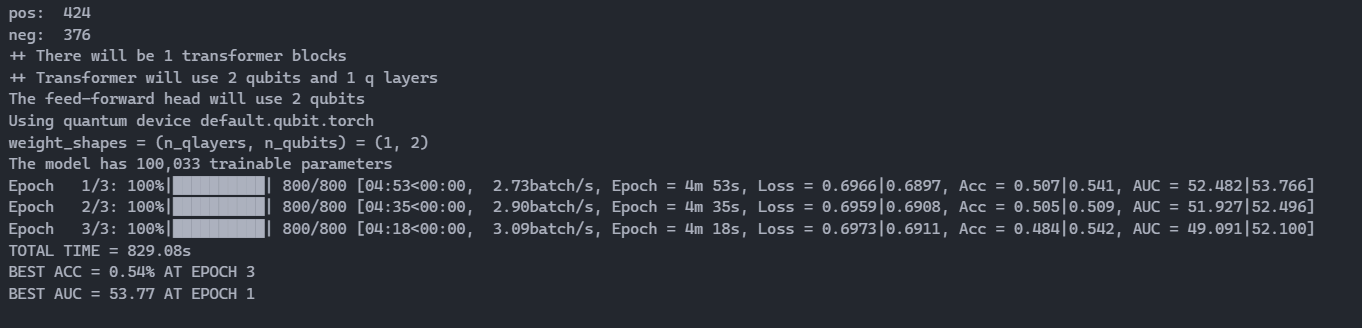


## Evaluation


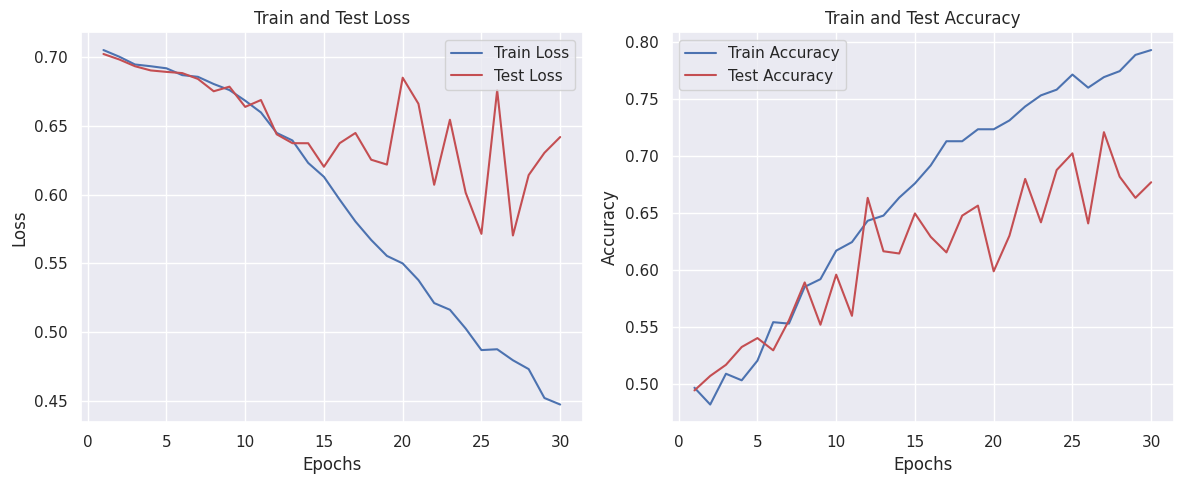

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

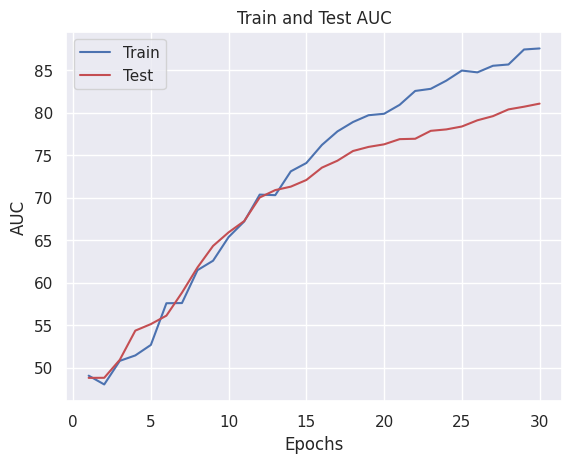

In [24]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [25]:
checkpoint = torch.load(
    ".models/model_and_metrics_epoch_10.pt"
)  # Replace x with the epoch number

# Load the metrics
epoch = checkpoint["epoch"]
train_loss = checkpoint["train_loss"]
train_acc = checkpoint["train_acc"]
train_auc = checkpoint["train_auc"]
test_loss = checkpoint["test_loss"]
test_acc = checkpoint["test_acc"]
test_auc = checkpoint["test_auc"]

test_acc

FileNotFoundError: [Errno 2] No such file or directory: '.models/model_and_metrics_epoch_10.pt'

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(auc, label="Quantum Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)